# Augmenting 5G data and reattempting classification task
Split into down, no change, and up reg in copper condition

Still try various models
* Linear model
* Kmer count model
* CNN model
* CNN + LSTM model


In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
random.seed(7)
import seaborn as sns
import tqdm

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
# import EarlyStopping
from pytorchtools import EarlyStopping

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Load 5G data

In [4]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

data_filename = "data/XY_lr_noCu_opFilt.tsv"
#data_filename = "data/XY_lr_noCu_opFilt_-400:100.tsv"
XYdf_og = pd.read_csv(data_filename,sep='\t')
XYdf_og

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.041825,0.199584,-0.158523,-2.684471,0.0,-0.492002,-0.037340,-0.221623,-1.266702,-0.361081,-1.081770,-0.714619
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.016197,-0.676160,-1.230196,-1.462699,0.0,0.029478,0.183147,0.010712,-0.086861,-0.712912,-1.430957,-1.390777
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.052273,-0.478136,-1.134588,-0.772442,0.0,-0.344101,0.053862,-0.268642,-0.258241,-0.916986,0.147953,0.006596
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,-0.150132,-0.534905,-0.811117,-0.723198,0.0,-0.072452,-0.199881,-0.117306,0.142879,-0.388531,0.209171,0.320237


In [5]:
loc2seq = dict([(x,z) for (x,z) in XYdf_og[['locus_tag','upstream_region']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA


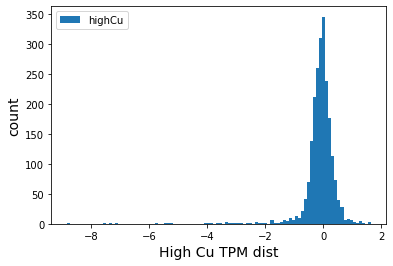

In [6]:
plt.hist(XYdf_og['highCu'].values,bins=100,label="highCu")

plt.legend()
plt.xlabel("High Cu TPM dist",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

### How many genes never change?

In [7]:
with open("data/conditions_to_include.txt",'r') as f:
    conds = [x.strip() for x in f.readlines()]
    
conds

['uMax',
 'lowO2_fast_growth',
 'lowCH4',
 'MeOH',
 'NoCu',
 'medCu',
 'highCu',
 'lowCu',
 'highO2_slow_growth',
 'NO3_lowO2_slow_growth',
 'WithLanthanum',
 'NoLanthanum']

In [8]:
data_filename = "data/XY_TPM_opFilt.tsv"
tpm_df = pd.read_csv(data_filename,sep='\t')
tpm_df

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,52.045884,35.736190,30.829331,23.333155,44.348687,44.920897,47.861477,42.973556,64.784508,32.050358,35.462185,33.444023
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,59.991257,43.159066,33.532522,18.915775,59.629360,65.011074,79.109490,61.209155,99.002970,43.656760,41.792237,43.689839
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,33.943076,27.325800,18.491160,18.453916,28.268717,29.419165,33.534043,28.828713,44.856281,21.351623,20.644554,23.172675
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,48.648085,33.463183,31.643505,16.960643,49.839406,48.729958,48.662214,50.966799,77.842263,41.684925,34.258335,42.367072
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,27.213395,27.232565,12.892833,10.720823,27.164218,25.769601,29.013530,25.968531,19.520794,23.027211,32.713854,34.374071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,8591.278232,9584.028559,7477.339715,1298.257682,8345.785345,5934.168113,8132.547467,7157.344557,3468.582202,6497.868109,3942.957792,5085.637409
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,43.551349,26.951394,18.356915,15.624619,43.065124,43.954096,48.894308,43.386082,40.548782,26.273485,15.972203,16.423284
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,46.058548,31.889009,20.231568,26.004364,44.419579,34.993692,46.109300,36.872718,37.139500,23.525245,49.216725,44.623117
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,31.182164,23.882390,19.721043,20.960234,34.601933,32.907138,30.125207,31.899782,38.204218,26.432667,40.000662,43.201743


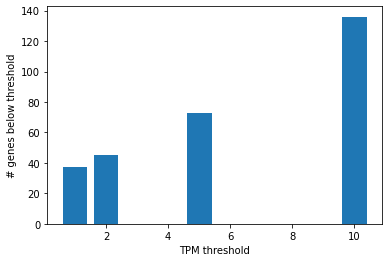

In [9]:
no_tx_genes1 = []
no_tx_genes2 = []
no_tx_genes5 = []
no_tx_genes10 = []
for i, row, in tpm_df.iterrows():
    tpms = row[conds].values
    if max(tpms) < 1.0:
        no_tx_genes1.append(row['locus_tag'])
    if max(tpms) < 2.0:
        no_tx_genes2.append(row['locus_tag'])
    if max(tpms) < 5.0:
        no_tx_genes5.append(row['locus_tag'])
    if max(tpms) < 10.0:
        no_tx_genes10.append(row['locus_tag'])

plt.bar([1,2,5,10],[len(no_tx_genes1),len(no_tx_genes2),len(no_tx_genes5),len(no_tx_genes10)])
plt.xlabel("TPM threshold")
plt.ylabel("# genes below threshold")
plt.show()

In [10]:
len(no_tx_genes10)

136

In [11]:
# do any of these show up in the log ratio up/down?
XYdf_og[XYdf_og['locus_tag'].isin(no_tx_genes2)].sort_values('highCu')[['locus_tag','highCu']]

,locus_tag,highCu
1165,EQU24_RS11910,-1.958143
118,EQU24_RS01215,-0.923850
17,EQU24_RS00205,-0.624566
1943,EQU24_RS19655,-0.624566
783,EQU24_RS07995,-0.170096
1178,EQU24_RS12090,0.000000
1243,EQU24_RS12810,0.000000
1584,EQU24_RS16040,0.000000
1669,EQU24_RS16985,0.000000
1745,EQU24_RS17885,0.000000


In [12]:
# filter out genes that never express above 2 tpms in any condition tested
XYdf = XYdf_og[~XYdf_og['locus_tag'].isin(no_tx_genes2)].reset_index().drop('index',axis=1)
XYdf['product'] = XYdf['locus_tag'].apply(lambda x: locus2info[x]['product'])

## Add regulatory class to XYdf

In [13]:
def set_reg_class_up_down(df, col,thresh=1.0):
    '''
    Given a dataframe of log ratio TPMS, add a column splitting genes into categories
    * Below -thresh: class 0
    * Between -thresh:thresh: class 1
    * Above thresh: class 2
    '''
    def get_class(val):
        if val < -thresh:
            return 0
        elif val > thresh:
            return 2
        else:
            return 1
    
    reg_col = f"{col}_reg_UD"
    df[reg_col] = df[col].apply(lambda x: get_class(x))
    
def set_reg_class_yes_no(df, col,thresh=1.0):
    '''
    Given a dataframe of log ratio TPMS, add a column splitting genes into categories
    * Below -thresh: class 0
    * Between -thresh:thresh: class 1
    * Above thresh: class 0
    '''
    def get_class(val):
        if val < -thresh:
            return 0
        elif val > thresh:
            return 0
        else:
            return 1
    
    reg_col = f"{col}_reg_YN"
    df[reg_col] = df[col].apply(lambda x: get_class(x))

In [14]:
set_reg_class_up_down(XYdf,'highCu',thresh=0.9)
set_reg_class_yes_no(XYdf,'highCu',thresh=0.9)
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,product,highCu_reg_UD,highCu_reg_YN
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143,chromosomal replication initiator protein DnaA,1,1
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725,DNA polymerase III subunit beta,1,1
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782,DNA replication/repair protein RecF,1,1
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343,hypothetical protein,1,1
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613,bifunctional diguanylate cyclase/phosphodieste...,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.041825,0.199584,-0.158523,-2.684471,0.0,-0.492002,-0.037340,-0.221623,-1.266702,-0.361081,-1.081770,-0.714619,hypothetical protein,1,1
2155,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.016197,-0.676160,-1.230196,-1.462699,0.0,0.029478,0.183147,0.010712,-0.086861,-0.712912,-1.430957,-1.390777,type II toxin-antitoxin system HicA family toxin,1,1
2156,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.052273,-0.478136,-1.134588,-0.772442,0.0,-0.344101,0.053862,-0.268642,-0.258241,-0.916986,0.147953,0.006596,DUF4102 domain-containing protein,1,1
2157,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,-0.150132,-0.534905,-0.811117,-0.723198,0.0,-0.072452,-0.199881,-0.117306,0.142879,-0.388531,0.209171,0.320237,NaN,1,1


In [15]:
XYdf['highCu_reg_UD'].value_counts()

1    2053
0      87
2      19
Name: highCu_reg_UD, dtype: int64

In [16]:
XYdf['highCu_reg_YN'].value_counts()

1    2053
0     106
Name: highCu_reg_YN, dtype: int64

In [17]:
XYdf[XYdf['highCu_reg_UD']==2].sort_values('highCu')[['locus_tag','product','highCu','highCu_reg_UD','highCu_reg_YN']]

,locus_tag,product,highCu,highCu_reg_UD,highCu_reg_YN
1848,EQU24_RS19170,porin,0.904056,2,0
1867,EQU24_RS19315,methane monooxygenase/ammonia monooxygenase su...,0.909567,2,0
869,EQU24_RS09010,formate/nitrite transporter family protein,0.910615,2,0
365,EQU24_RS03640,hypothetical protein,0.912364,2,0
1188,EQU24_RS12460,NaN,0.925678,2,0
511,EQU24_RS05300,TonB-dependent receptor,0.967838,2,0
1200,EQU24_RS12620,ABC transporter substrate-binding protein,1.003505,2,0
2079,EQU24_RS21320,hypothetical protein,1.034486,2,0
1901,EQU24_RS19620,multicopper oxidase,1.036516,2,0
1666,EQU24_RS17265,electron transport complex subunit RsxA,1.076514,2,0


In [18]:
XYdf[XYdf['highCu_reg_UD']==0].sort_values('highCu')[['locus_tag','product','highCu','highCu_reg_UD','highCu_reg_YN']]

,locus_tag,product,highCu,highCu_reg_UD,highCu_reg_YN
576,EQU24_RS05885,methane monooxygenase,-8.844506,0,0
577,EQU24_RS05905,soluble methane monooxygenase-binding protein ...,-7.574592,0,0
579,EQU24_RS05920,hypothetical protein,-7.357154,0,0
578,EQU24_RS05915,BLUF domain-containing protein,-7.275122,0,0
580,EQU24_RS05925,likely chaperone for smmo,-7.104795,0,0
...,...,...,...,...,...
471,EQU24_RS04905,PAS domain-containing protein,-0.916238,0,0
85,EQU24_RS00945,metal-binding protein,-0.908456,0,0
1965,EQU24_RS20320,DUF2442 domain-containing protein,-0.905213,0,0
1136,EQU24_RS11870,PepSY domain-containing protein,-0.902402,0,0


In [19]:
XYdf[XYdf['locus_tag']=='EQU24_RS19315']

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,product,highCu_reg_UD,highCu_reg_YN
1867,3671,EQU24_RS19315,ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAAT...,0.954381,1.313821,1.459975,-0.526926,0.0,0.600282,0.909567,0.389121,0.351281,1.326338,1.172579,1.305701,methane monooxygenase/ammonia monooxygenase su...,2,0


### Train/val/test splitting

In [20]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()
    
def plot_train_test_stacks(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores in categories, sanity check that its not skewed'''
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    temp_df = pd.concat([train_df,test_df])
    if val_df is not None:
        val_df['set'] = 'val'
        temp_df = pd.concat([temp_df,val_df])
        
    temp_df = temp_df.value_counts([score_col,'set']).to_frame('count').reset_index()
        
    #temp_df = pd.melt(temp_df[['locus_tag',score_col,'set']],id_vars['locus_tag'])
    sns.barplot(x=score_col, y = 'count', data = temp_df, hue = "set")
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,val_df,test_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"Distribution")
    plt.show()
    

def see_batch_class_dist(train_dl,classes=[0,1,2]):
    '''Check distribution of classes in each batch'''
    
    data = []
    for i,(xb, yb) in enumerate(train_dl):
        vals, counts = yb.unique(return_counts=True)
        z=dict(list(zip(np.array(vals),np.array(counts))))
        row = []
        for cls in classes:
            if cls in z:
                data.append((i,cls,z[cls]))
            else:
                print(f"WARNING: no instance of class {cls} in batch {i}")
                data.append((i,cls,0))

    batch_dist = pd.DataFrame(data, columns=['batch','class','count'])
    sns.barplot(x='batch', y = 'count', data = batch_dist, hue = "class")
    plt.show()


In [21]:
# specs for class partition dict
cpd = {
    0: {'train_test':0.8, 'train_val':0.8},
    1: {'train_test':0.8, 'train_val':0.8},
    2: {'train_test':0.75, 'train_val':0.66},
}

In [22]:
def stratified_partition(df, class_partition_dict,class_col='reg'):
    '''
    Given a specification for how to split specific classes into 
    train-test and train-val, implement those splits independently 
    and return final dfs for train/test/val splits
    '''
    
    # make sure classes and CPD specs match
    assert set(class_partition_dict.keys()) == set(df[class_col].unique())
    
    final_full_train = pd.DataFrame(columns=df.columns)
    final_test = pd.DataFrame(columns=df.columns)
    final_train = pd.DataFrame(columns=df.columns)
    final_val = pd.DataFrame(columns=df.columns)

    
    for c in cpd:
        temp_df = df[df[class_col]==c]
        print(f"class {c}: {temp_df.shape[0]} examples")
        full_train,test = tu.quick_split(temp_df, split_frac=cpd[c]['train_test'])
        train,val = tu.quick_split(full_train, split_frac=cpd[c]['train_val'])
        
        final_full_train = pd.concat([final_full_train, full_train])
        final_test = pd.concat([final_test, test])
        final_train = pd.concat([final_train, train])
        final_val = pd.concat([final_val, val])
        
    return final_full_train, final_test, final_train, final_val
        

In [23]:
full_train_df, \
test_df, \
train_df, \
val_df = stratified_partition(XYdf, cpd, class_col='highCu_reg_UD')

class 0: 87 examples
class 1: 2053 examples
class 2: 19 examples


In [24]:
display(full_train_df['highCu_reg_UD'].value_counts())
display(test_df['highCu_reg_UD'].value_counts())
display(train_df['highCu_reg_UD'].value_counts())
display(val_df['highCu_reg_UD'].value_counts())

1    1642
0      69
2      14
Name: highCu_reg_UD, dtype: int64

1    411
0     18
2      5
Name: highCu_reg_UD, dtype: int64

1    1313
0      55
2       9
Name: highCu_reg_UD, dtype: int64

1    329
0     14
2      5
Name: highCu_reg_UD, dtype: int64

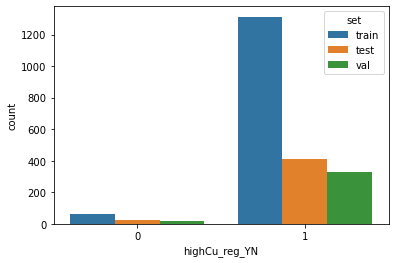

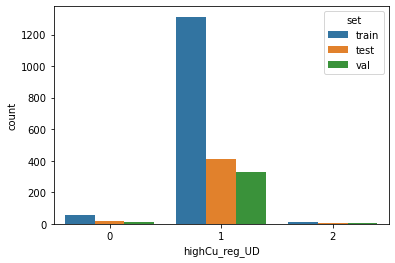

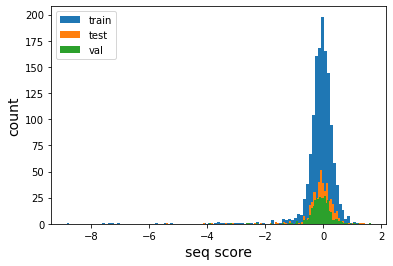

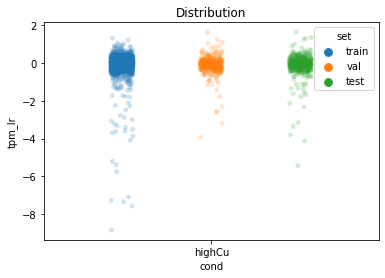

In [25]:
plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col='highCu_reg_YN')
plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col='highCu_reg_UD')
plot_train_test_hist(train_df, test_df,val_df=val_df,score_col='highCu',bins=100)
view_train_test_dist(train_df, test_df,["highCu"],val_df=val_df,id_col='locus_tag')


## Data augmentation strategies
TODO

## Load 5G seqs into data loaders

In [26]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [27]:
# full_train_df,test_df = tu.quick_split(XYdf)
# train_df, val_df = tu.quick_split(full_train_df)

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu_reg_UD',
    sampler=None
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

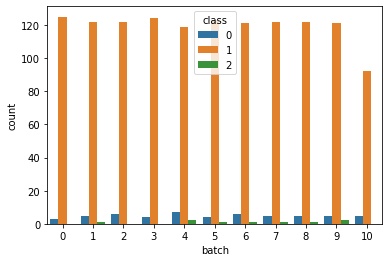

In [28]:
see_batch_class_dist(ohe_train_dl)

## Non-optuna regular ol training

In [29]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    #loss = loss_func(xb_out, yb.float())
    loss = loss_func(xb_out, yb.long().squeeze(1))
    # ^^ changes for CrossEntropyLoss...

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(DEVICE),yb.to(DEVICE)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(DEVICE),yb.to(DEVICE)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl,patience=1000):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # create early stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=False)
    
    # loops through epochs
    #for epoch in range(epochs): #tqdm?
    with tqdm.trange(epochs) as pbar:
        for i in pbar:
            
    
            train_loss = train_step(model, train_dl, loss_func, opt)
            train_losses.append(train_loss)


            val_loss = val_step(model, val_dl, loss_func)
            #print(epoch, val_loss)
            val_losses.append(val_loss)
            
            pbar.set_description(f"E:{i} | train loss:{train_loss:.3f} | val loss: {val_loss:.3f}")
            
            # copied from https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            early_stopping(val_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break
    # Stopped at epoch - patience, but what if early stopping isn't triggered?
    estop = i - patience if early_stopping.early_stop else i

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    # ^^ Does this need to be returned? I dont' think so... loads in place

    return train_losses, val_losses,estop

def run_model(train_dl,test_dl, model, loss_func, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop

    train_losses, test_losses,epoch_stop = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses,epoch_stop

In [30]:
class DNA_Linear_Deep(nn.Module):
    def __init__(
        self, 
        seq_len,
        h0_size=24,
        h1_size=24
    ):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h0_size, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 3), # 3 for 3 classes
            #nn.Softmax(dim=1)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 3),
            #nn.Softmax(dim=1)
            
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

class Kmer_Linear(nn.Module):
    def __init__(self,num_kmers,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin = nn.Sequential(
            nn.Linear(num_kmers, h1_size), ## TODO: Can this be combined? Bring num_kmers outside?
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True),
            nn.Linear(h2_size, 1),
        )
        
        
    def forward(self, xb):
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out

In [31]:
def plot_confusion(models,genes,oracle,objs):
    '''Get class predictions and plot confusion matrix'''
    dfs = {}
    for model_name,model,ds in models:
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            if ds.name == 'ohe':
                s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            elif ds.name == 'kmer':
                s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).to(DEVICE)
                # need unsqueeze?
            else:
                raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")

            actual = oracle[gene]
            preds = [x.topk(1) for x in model(s.float())]
            
            for i in range(len(preds)):
                prob,cls = [x.item() for x in preds[i]]
                data.append((gene,actual[i], cls,prob,objs[i],dna))
                
        df = pd.DataFrame(data, columns=['locus_tag','truth','pred','prob','task','seq'])
        c = confusion_matrix(df['truth'].values, df['pred'].values)
        disp = ConfusionMatrixDisplay(confusion_matrix=c)
        disp.plot()
        plt.title(f"{model_name} confusion matrix")
        plt.show()

        dfs[model_name] = (c,df)
        
    return dfs

### Deep linear

E:17 | train loss:0.207 | val loss: 0.247:   3%|▎         | 17/500 [00:00<00:18, 26.79it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000


E:24 | train loss:0.203 | val loss: 0.248:   5%|▌         | 25/500 [00:01<00:15, 29.80it/s]

EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:31 | train loss:0.201 | val loss: 0.248:   6%|▌         | 29/500 [00:01<00:15, 30.49it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:38 | train loss:0.198 | val loss: 0.249:   7%|▋         | 37/500 [00:01<00:14, 30.97it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000


E:45 | train loss:0.196 | val loss: 0.250:   9%|▉         | 45/500 [00:01<00:14, 31.57it/s]

EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000


E:52 | train loss:0.194 | val loss: 0.250:  11%|█         | 53/500 [00:01<00:13, 32.84it/s]

EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000


E:59 | train loss:0.191 | val loss: 0.251:  11%|█▏        | 57/500 [00:02<00:13, 32.95it/s]

EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000


E:66 | train loss:0.189 | val loss: 0.252:  13%|█▎        | 65/500 [00:02<00:13, 32.32it/s]

EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000
EarlyStopping counter: 53 out of 1000
EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000
EarlyStopping counter: 56 out of 1000


E:73 | train loss:0.186 | val loss: 0.252:  15%|█▍        | 73/500 [00:02<00:13, 31.97it/s]

EarlyStopping counter: 57 out of 1000
EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000
EarlyStopping counter: 60 out of 1000
EarlyStopping counter: 61 out of 1000
EarlyStopping counter: 62 out of 1000
EarlyStopping counter: 63 out of 1000


E:80 | train loss:0.183 | val loss: 0.253:  16%|█▌        | 81/500 [00:02<00:13, 31.74it/s]

EarlyStopping counter: 64 out of 1000
EarlyStopping counter: 65 out of 1000
EarlyStopping counter: 66 out of 1000
EarlyStopping counter: 67 out of 1000
EarlyStopping counter: 68 out of 1000
EarlyStopping counter: 69 out of 1000
EarlyStopping counter: 70 out of 1000


E:87 | train loss:0.180 | val loss: 0.254:  17%|█▋        | 85/500 [00:03<00:12, 32.18it/s]

EarlyStopping counter: 71 out of 1000
EarlyStopping counter: 72 out of 1000
EarlyStopping counter: 73 out of 1000
EarlyStopping counter: 74 out of 1000
EarlyStopping counter: 75 out of 1000
EarlyStopping counter: 76 out of 1000
EarlyStopping counter: 77 out of 1000


E:94 | train loss:0.177 | val loss: 0.254:  19%|█▊        | 93/500 [00:03<00:12, 32.25it/s]

EarlyStopping counter: 78 out of 1000
EarlyStopping counter: 79 out of 1000
EarlyStopping counter: 80 out of 1000
EarlyStopping counter: 81 out of 1000
EarlyStopping counter: 82 out of 1000
EarlyStopping counter: 83 out of 1000
EarlyStopping counter: 84 out of 1000


E:101 | train loss:0.173 | val loss: 0.255:  20%|██        | 101/500 [00:03<00:12, 32.26it/s]

EarlyStopping counter: 85 out of 1000
EarlyStopping counter: 86 out of 1000
EarlyStopping counter: 87 out of 1000
EarlyStopping counter: 88 out of 1000
EarlyStopping counter: 89 out of 1000
EarlyStopping counter: 90 out of 1000
EarlyStopping counter: 91 out of 1000


E:108 | train loss:0.169 | val loss: 0.256:  22%|██▏       | 109/500 [00:03<00:12, 31.41it/s]

EarlyStopping counter: 92 out of 1000
EarlyStopping counter: 93 out of 1000
EarlyStopping counter: 94 out of 1000
EarlyStopping counter: 95 out of 1000
EarlyStopping counter: 96 out of 1000
EarlyStopping counter: 97 out of 1000
EarlyStopping counter: 98 out of 1000


E:115 | train loss:0.164 | val loss: 0.257:  23%|██▎       | 113/500 [00:03<00:12, 31.28it/s]

EarlyStopping counter: 99 out of 1000
EarlyStopping counter: 100 out of 1000
EarlyStopping counter: 101 out of 1000
EarlyStopping counter: 102 out of 1000
EarlyStopping counter: 103 out of 1000
EarlyStopping counter: 104 out of 1000
EarlyStopping counter: 105 out of 1000


E:122 | train loss:0.159 | val loss: 0.259:  24%|██▍       | 121/500 [00:04<00:11, 32.09it/s]

EarlyStopping counter: 106 out of 1000
EarlyStopping counter: 107 out of 1000
EarlyStopping counter: 108 out of 1000
EarlyStopping counter: 109 out of 1000
EarlyStopping counter: 110 out of 1000
EarlyStopping counter: 111 out of 1000
EarlyStopping counter: 112 out of 1000


E:129 | train loss:0.154 | val loss: 0.261:  26%|██▌       | 129/500 [00:04<00:11, 32.06it/s]

EarlyStopping counter: 113 out of 1000
EarlyStopping counter: 114 out of 1000
EarlyStopping counter: 115 out of 1000
EarlyStopping counter: 116 out of 1000
EarlyStopping counter: 117 out of 1000
EarlyStopping counter: 118 out of 1000
EarlyStopping counter: 119 out of 1000


E:136 | train loss:0.148 | val loss: 0.263:  27%|██▋       | 137/500 [00:04<00:11, 32.00it/s]

EarlyStopping counter: 120 out of 1000
EarlyStopping counter: 121 out of 1000
EarlyStopping counter: 122 out of 1000
EarlyStopping counter: 123 out of 1000
EarlyStopping counter: 124 out of 1000
EarlyStopping counter: 125 out of 1000
EarlyStopping counter: 126 out of 1000


E:140 | train loss:0.145 | val loss: 0.265:  28%|██▊       | 141/500 [00:04<00:13, 25.99it/s]

EarlyStopping counter: 127 out of 1000
EarlyStopping counter: 128 out of 1000
EarlyStopping counter: 129 out of 1000
EarlyStopping counter: 130 out of 1000


E:147 | train loss:0.138 | val loss: 0.267:  29%|██▉       | 145/500 [00:04<00:12, 27.71it/s]

EarlyStopping counter: 131 out of 1000
EarlyStopping counter: 132 out of 1000
EarlyStopping counter: 133 out of 1000
EarlyStopping counter: 134 out of 1000
EarlyStopping counter: 135 out of 1000
EarlyStopping counter: 136 out of 1000
EarlyStopping counter: 137 out of 1000


E:154 | train loss:0.132 | val loss: 0.271:  31%|███       | 153/500 [00:05<00:11, 29.79it/s]

EarlyStopping counter: 138 out of 1000
EarlyStopping counter: 139 out of 1000
EarlyStopping counter: 140 out of 1000
EarlyStopping counter: 141 out of 1000
EarlyStopping counter: 142 out of 1000
EarlyStopping counter: 143 out of 1000
EarlyStopping counter: 144 out of 1000


E:161 | train loss:0.125 | val loss: 0.274:  32%|███▏      | 161/500 [00:05<00:11, 30.36it/s]

EarlyStopping counter: 145 out of 1000
EarlyStopping counter: 146 out of 1000
EarlyStopping counter: 147 out of 1000
EarlyStopping counter: 148 out of 1000
EarlyStopping counter: 149 out of 1000
EarlyStopping counter: 150 out of 1000
EarlyStopping counter: 151 out of 1000


E:168 | train loss:0.119 | val loss: 0.278:  34%|███▍      | 169/500 [00:05<00:10, 30.69it/s]

EarlyStopping counter: 152 out of 1000
EarlyStopping counter: 153 out of 1000
EarlyStopping counter: 154 out of 1000
EarlyStopping counter: 155 out of 1000
EarlyStopping counter: 156 out of 1000
EarlyStopping counter: 157 out of 1000
EarlyStopping counter: 158 out of 1000


E:175 | train loss:0.112 | val loss: 0.284:  35%|███▍      | 173/500 [00:05<00:10, 30.91it/s]

EarlyStopping counter: 159 out of 1000
EarlyStopping counter: 160 out of 1000
EarlyStopping counter: 161 out of 1000
EarlyStopping counter: 162 out of 1000
EarlyStopping counter: 163 out of 1000
EarlyStopping counter: 164 out of 1000
EarlyStopping counter: 165 out of 1000


E:182 | train loss:0.106 | val loss: 0.289:  36%|███▌      | 181/500 [00:06<00:10, 30.09it/s]

EarlyStopping counter: 166 out of 1000
EarlyStopping counter: 167 out of 1000
EarlyStopping counter: 168 out of 1000
EarlyStopping counter: 169 out of 1000
EarlyStopping counter: 170 out of 1000
EarlyStopping counter: 171 out of 1000
EarlyStopping counter: 172 out of 1000


E:188 | train loss:0.100 | val loss: 0.294:  38%|███▊      | 189/500 [00:06<00:10, 29.93it/s]

EarlyStopping counter: 173 out of 1000
EarlyStopping counter: 174 out of 1000
EarlyStopping counter: 175 out of 1000
EarlyStopping counter: 176 out of 1000
EarlyStopping counter: 177 out of 1000
EarlyStopping counter: 178 out of 1000


E:195 | train loss:0.094 | val loss: 0.300:  39%|███▊      | 193/500 [00:06<00:10, 30.70it/s]

EarlyStopping counter: 179 out of 1000
EarlyStopping counter: 180 out of 1000
EarlyStopping counter: 181 out of 1000
EarlyStopping counter: 182 out of 1000
EarlyStopping counter: 183 out of 1000
EarlyStopping counter: 184 out of 1000
EarlyStopping counter: 185 out of 1000


E:202 | train loss:0.088 | val loss: 0.309:  40%|████      | 201/500 [00:06<00:09, 31.42it/s]

EarlyStopping counter: 186 out of 1000
EarlyStopping counter: 187 out of 1000
EarlyStopping counter: 188 out of 1000
EarlyStopping counter: 189 out of 1000
EarlyStopping counter: 190 out of 1000
EarlyStopping counter: 191 out of 1000
EarlyStopping counter: 192 out of 1000


E:209 | train loss:0.083 | val loss: 0.317:  42%|████▏     | 209/500 [00:06<00:09, 31.28it/s]

EarlyStopping counter: 193 out of 1000
EarlyStopping counter: 194 out of 1000
EarlyStopping counter: 195 out of 1000
EarlyStopping counter: 196 out of 1000
EarlyStopping counter: 197 out of 1000
EarlyStopping counter: 198 out of 1000
EarlyStopping counter: 199 out of 1000


E:216 | train loss:0.077 | val loss: 0.323:  43%|████▎     | 217/500 [00:07<00:09, 30.96it/s]

EarlyStopping counter: 200 out of 1000
EarlyStopping counter: 201 out of 1000
EarlyStopping counter: 202 out of 1000
EarlyStopping counter: 203 out of 1000
EarlyStopping counter: 204 out of 1000
EarlyStopping counter: 205 out of 1000
EarlyStopping counter: 206 out of 1000


E:223 | train loss:0.072 | val loss: 0.330:  44%|████▍     | 221/500 [00:07<00:09, 30.98it/s]

EarlyStopping counter: 207 out of 1000
EarlyStopping counter: 208 out of 1000
EarlyStopping counter: 209 out of 1000
EarlyStopping counter: 210 out of 1000
EarlyStopping counter: 211 out of 1000
EarlyStopping counter: 212 out of 1000
EarlyStopping counter: 213 out of 1000


E:230 | train loss:0.067 | val loss: 0.339:  46%|████▌     | 229/500 [00:07<00:08, 31.16it/s]

EarlyStopping counter: 214 out of 1000
EarlyStopping counter: 215 out of 1000
EarlyStopping counter: 216 out of 1000
EarlyStopping counter: 217 out of 1000
EarlyStopping counter: 218 out of 1000
EarlyStopping counter: 219 out of 1000
EarlyStopping counter: 220 out of 1000


E:237 | train loss:0.063 | val loss: 0.346:  47%|████▋     | 237/500 [00:07<00:08, 31.45it/s]

EarlyStopping counter: 221 out of 1000
EarlyStopping counter: 222 out of 1000
EarlyStopping counter: 223 out of 1000
EarlyStopping counter: 224 out of 1000
EarlyStopping counter: 225 out of 1000
EarlyStopping counter: 226 out of 1000
EarlyStopping counter: 227 out of 1000


E:244 | train loss:0.059 | val loss: 0.355:  49%|████▉     | 245/500 [00:08<00:08, 31.72it/s]

EarlyStopping counter: 228 out of 1000
EarlyStopping counter: 229 out of 1000
EarlyStopping counter: 230 out of 1000
EarlyStopping counter: 231 out of 1000
EarlyStopping counter: 232 out of 1000
EarlyStopping counter: 233 out of 1000
EarlyStopping counter: 234 out of 1000


E:251 | train loss:0.055 | val loss: 0.365:  50%|████▉     | 249/500 [00:08<00:08, 30.75it/s]

EarlyStopping counter: 235 out of 1000
EarlyStopping counter: 236 out of 1000
EarlyStopping counter: 237 out of 1000
EarlyStopping counter: 238 out of 1000
EarlyStopping counter: 239 out of 1000
EarlyStopping counter: 240 out of 1000
EarlyStopping counter: 241 out of 1000


E:258 | train loss:0.051 | val loss: 0.371:  51%|█████▏    | 257/500 [00:08<00:07, 31.91it/s]

EarlyStopping counter: 242 out of 1000
EarlyStopping counter: 243 out of 1000
EarlyStopping counter: 244 out of 1000
EarlyStopping counter: 245 out of 1000
EarlyStopping counter: 246 out of 1000
EarlyStopping counter: 247 out of 1000
EarlyStopping counter: 248 out of 1000


E:265 | train loss:0.047 | val loss: 0.383:  53%|█████▎    | 265/500 [00:08<00:07, 31.87it/s]

EarlyStopping counter: 249 out of 1000
EarlyStopping counter: 250 out of 1000
EarlyStopping counter: 251 out of 1000
EarlyStopping counter: 252 out of 1000
EarlyStopping counter: 253 out of 1000
EarlyStopping counter: 254 out of 1000
EarlyStopping counter: 255 out of 1000


E:272 | train loss:0.044 | val loss: 0.390:  55%|█████▍    | 273/500 [00:08<00:07, 31.00it/s]

EarlyStopping counter: 256 out of 1000
EarlyStopping counter: 257 out of 1000
EarlyStopping counter: 258 out of 1000
EarlyStopping counter: 259 out of 1000
EarlyStopping counter: 260 out of 1000
EarlyStopping counter: 261 out of 1000
EarlyStopping counter: 262 out of 1000


E:279 | train loss:0.041 | val loss: 0.398:  55%|█████▌    | 277/500 [00:09<00:07, 30.95it/s]

EarlyStopping counter: 263 out of 1000
EarlyStopping counter: 264 out of 1000
EarlyStopping counter: 265 out of 1000
EarlyStopping counter: 266 out of 1000
EarlyStopping counter: 267 out of 1000
EarlyStopping counter: 268 out of 1000
EarlyStopping counter: 269 out of 1000


E:286 | train loss:0.039 | val loss: 0.408:  57%|█████▋    | 285/500 [00:09<00:06, 31.88it/s]

EarlyStopping counter: 270 out of 1000
EarlyStopping counter: 271 out of 1000
EarlyStopping counter: 272 out of 1000
EarlyStopping counter: 273 out of 1000
EarlyStopping counter: 274 out of 1000
EarlyStopping counter: 275 out of 1000
EarlyStopping counter: 276 out of 1000


E:293 | train loss:0.036 | val loss: 0.415:  59%|█████▊    | 293/500 [00:09<00:06, 31.67it/s]

EarlyStopping counter: 277 out of 1000
EarlyStopping counter: 278 out of 1000
EarlyStopping counter: 279 out of 1000
EarlyStopping counter: 280 out of 1000
EarlyStopping counter: 281 out of 1000
EarlyStopping counter: 282 out of 1000
EarlyStopping counter: 283 out of 1000


E:300 | train loss:0.034 | val loss: 0.424:  60%|██████    | 301/500 [00:09<00:06, 31.50it/s]

EarlyStopping counter: 284 out of 1000
EarlyStopping counter: 285 out of 1000
EarlyStopping counter: 286 out of 1000
EarlyStopping counter: 287 out of 1000
EarlyStopping counter: 288 out of 1000
EarlyStopping counter: 289 out of 1000
EarlyStopping counter: 290 out of 1000


E:307 | train loss:0.032 | val loss: 0.431:  61%|██████    | 305/500 [00:10<00:06, 31.65it/s]

EarlyStopping counter: 291 out of 1000
EarlyStopping counter: 292 out of 1000
EarlyStopping counter: 293 out of 1000
EarlyStopping counter: 294 out of 1000
EarlyStopping counter: 295 out of 1000
EarlyStopping counter: 296 out of 1000
EarlyStopping counter: 297 out of 1000


E:314 | train loss:0.031 | val loss: 0.441:  63%|██████▎   | 313/500 [00:10<00:05, 31.50it/s]

EarlyStopping counter: 298 out of 1000
EarlyStopping counter: 299 out of 1000
EarlyStopping counter: 300 out of 1000
EarlyStopping counter: 301 out of 1000
EarlyStopping counter: 302 out of 1000
EarlyStopping counter: 303 out of 1000
EarlyStopping counter: 304 out of 1000


E:321 | train loss:0.029 | val loss: 0.450:  64%|██████▍   | 321/500 [00:10<00:05, 31.09it/s]

EarlyStopping counter: 305 out of 1000
EarlyStopping counter: 306 out of 1000
EarlyStopping counter: 307 out of 1000
EarlyStopping counter: 308 out of 1000
EarlyStopping counter: 309 out of 1000
EarlyStopping counter: 310 out of 1000
EarlyStopping counter: 311 out of 1000


E:328 | train loss:0.028 | val loss: 0.455:  66%|██████▌   | 329/500 [00:10<00:05, 30.60it/s]

EarlyStopping counter: 312 out of 1000
EarlyStopping counter: 313 out of 1000
EarlyStopping counter: 314 out of 1000
EarlyStopping counter: 315 out of 1000
EarlyStopping counter: 316 out of 1000
EarlyStopping counter: 317 out of 1000
EarlyStopping counter: 318 out of 1000


E:335 | train loss:0.026 | val loss: 0.465:  67%|██████▋   | 333/500 [00:11<00:05, 30.65it/s]

EarlyStopping counter: 319 out of 1000
EarlyStopping counter: 320 out of 1000
EarlyStopping counter: 321 out of 1000
EarlyStopping counter: 322 out of 1000
EarlyStopping counter: 323 out of 1000
EarlyStopping counter: 324 out of 1000
EarlyStopping counter: 325 out of 1000


E:342 | train loss:0.025 | val loss: 0.470:  68%|██████▊   | 341/500 [00:11<00:05, 31.47it/s]

EarlyStopping counter: 326 out of 1000
EarlyStopping counter: 327 out of 1000
EarlyStopping counter: 328 out of 1000
EarlyStopping counter: 329 out of 1000
EarlyStopping counter: 330 out of 1000
EarlyStopping counter: 331 out of 1000
EarlyStopping counter: 332 out of 1000


E:349 | train loss:0.024 | val loss: 0.477:  70%|██████▉   | 349/500 [00:11<00:04, 30.77it/s]

EarlyStopping counter: 333 out of 1000
EarlyStopping counter: 334 out of 1000
EarlyStopping counter: 335 out of 1000
EarlyStopping counter: 336 out of 1000
EarlyStopping counter: 337 out of 1000
EarlyStopping counter: 338 out of 1000


E:355 | train loss:0.024 | val loss: 0.482:  71%|███████   | 353/500 [00:11<00:04, 30.75it/s]

EarlyStopping counter: 339 out of 1000
EarlyStopping counter: 340 out of 1000
EarlyStopping counter: 341 out of 1000
EarlyStopping counter: 342 out of 1000
EarlyStopping counter: 343 out of 1000
EarlyStopping counter: 344 out of 1000
EarlyStopping counter: 345 out of 1000


E:362 | train loss:0.023 | val loss: 0.491:  72%|███████▏  | 361/500 [00:11<00:04, 31.01it/s]

EarlyStopping counter: 346 out of 1000
EarlyStopping counter: 347 out of 1000
EarlyStopping counter: 348 out of 1000
EarlyStopping counter: 349 out of 1000
EarlyStopping counter: 350 out of 1000
EarlyStopping counter: 351 out of 1000
EarlyStopping counter: 352 out of 1000


E:369 | train loss:0.022 | val loss: 0.497:  74%|███████▍  | 369/500 [00:12<00:04, 31.39it/s]

EarlyStopping counter: 353 out of 1000
EarlyStopping counter: 354 out of 1000
EarlyStopping counter: 355 out of 1000
EarlyStopping counter: 356 out of 1000
EarlyStopping counter: 357 out of 1000
EarlyStopping counter: 358 out of 1000
EarlyStopping counter: 359 out of 1000


E:376 | train loss:0.021 | val loss: 0.502:  75%|███████▌  | 377/500 [00:12<00:03, 30.84it/s]

EarlyStopping counter: 360 out of 1000
EarlyStopping counter: 361 out of 1000
EarlyStopping counter: 362 out of 1000
EarlyStopping counter: 363 out of 1000
EarlyStopping counter: 364 out of 1000
EarlyStopping counter: 365 out of 1000
EarlyStopping counter: 366 out of 1000


E:383 | train loss:0.021 | val loss: 0.508:  76%|███████▌  | 381/500 [00:12<00:03, 31.40it/s]

EarlyStopping counter: 367 out of 1000
EarlyStopping counter: 368 out of 1000
EarlyStopping counter: 369 out of 1000
EarlyStopping counter: 370 out of 1000
EarlyStopping counter: 371 out of 1000
EarlyStopping counter: 372 out of 1000
EarlyStopping counter: 373 out of 1000


E:390 | train loss:0.020 | val loss: 0.513:  78%|███████▊  | 389/500 [00:12<00:03, 31.08it/s]

EarlyStopping counter: 374 out of 1000
EarlyStopping counter: 375 out of 1000
EarlyStopping counter: 376 out of 1000
EarlyStopping counter: 377 out of 1000
EarlyStopping counter: 378 out of 1000
EarlyStopping counter: 379 out of 1000
EarlyStopping counter: 380 out of 1000


E:397 | train loss:0.019 | val loss: 0.519:  79%|███████▉  | 397/500 [00:13<00:03, 30.38it/s]

EarlyStopping counter: 381 out of 1000
EarlyStopping counter: 382 out of 1000
EarlyStopping counter: 383 out of 1000
EarlyStopping counter: 384 out of 1000
EarlyStopping counter: 385 out of 1000
EarlyStopping counter: 386 out of 1000


E:403 | train loss:0.019 | val loss: 0.523:  80%|████████  | 401/500 [00:13<00:03, 30.93it/s]

EarlyStopping counter: 387 out of 1000
EarlyStopping counter: 388 out of 1000
EarlyStopping counter: 389 out of 1000
EarlyStopping counter: 390 out of 1000
EarlyStopping counter: 391 out of 1000
EarlyStopping counter: 392 out of 1000
EarlyStopping counter: 393 out of 1000


E:410 | train loss:0.018 | val loss: 0.528:  82%|████████▏ | 409/500 [00:13<00:02, 30.40it/s]

EarlyStopping counter: 394 out of 1000
EarlyStopping counter: 395 out of 1000
EarlyStopping counter: 396 out of 1000
EarlyStopping counter: 397 out of 1000
EarlyStopping counter: 398 out of 1000
EarlyStopping counter: 399 out of 1000
EarlyStopping counter: 400 out of 1000


E:417 | train loss:0.018 | val loss: 0.533:  83%|████████▎ | 417/500 [00:13<00:02, 30.17it/s]

EarlyStopping counter: 401 out of 1000
EarlyStopping counter: 402 out of 1000
EarlyStopping counter: 403 out of 1000
EarlyStopping counter: 404 out of 1000
EarlyStopping counter: 405 out of 1000
EarlyStopping counter: 406 out of 1000
EarlyStopping counter: 407 out of 1000


E:423 | train loss:0.018 | val loss: 0.537:  85%|████████▍ | 424/500 [00:13<00:02, 29.29it/s]

EarlyStopping counter: 408 out of 1000
EarlyStopping counter: 409 out of 1000
EarlyStopping counter: 410 out of 1000
EarlyStopping counter: 411 out of 1000
EarlyStopping counter: 412 out of 1000
EarlyStopping counter: 413 out of 1000


E:429 | train loss:0.017 | val loss: 0.541:  85%|████████▌ | 427/500 [00:14<00:02, 28.87it/s]

EarlyStopping counter: 414 out of 1000
EarlyStopping counter: 415 out of 1000
EarlyStopping counter: 416 out of 1000
EarlyStopping counter: 417 out of 1000
EarlyStopping counter: 418 out of 1000
EarlyStopping counter: 419 out of 1000


E:436 | train loss:0.017 | val loss: 0.547:  87%|████████▋ | 435/500 [00:14<00:02, 30.47it/s]

EarlyStopping counter: 420 out of 1000
EarlyStopping counter: 421 out of 1000
EarlyStopping counter: 422 out of 1000
EarlyStopping counter: 423 out of 1000
EarlyStopping counter: 424 out of 1000
EarlyStopping counter: 425 out of 1000
EarlyStopping counter: 426 out of 1000


E:443 | train loss:0.016 | val loss: 0.551:  89%|████████▊ | 443/500 [00:14<00:01, 31.21it/s]

EarlyStopping counter: 427 out of 1000
EarlyStopping counter: 428 out of 1000
EarlyStopping counter: 429 out of 1000
EarlyStopping counter: 430 out of 1000
EarlyStopping counter: 431 out of 1000
EarlyStopping counter: 432 out of 1000
EarlyStopping counter: 433 out of 1000


E:450 | train loss:0.016 | val loss: 0.555:  90%|█████████ | 451/500 [00:14<00:01, 31.36it/s]

EarlyStopping counter: 434 out of 1000
EarlyStopping counter: 435 out of 1000
EarlyStopping counter: 436 out of 1000
EarlyStopping counter: 437 out of 1000
EarlyStopping counter: 438 out of 1000
EarlyStopping counter: 439 out of 1000
EarlyStopping counter: 440 out of 1000


E:456 | train loss:0.016 | val loss: 0.558:  91%|█████████ | 455/500 [00:14<00:01, 30.14it/s]

EarlyStopping counter: 441 out of 1000
EarlyStopping counter: 442 out of 1000
EarlyStopping counter: 443 out of 1000
EarlyStopping counter: 444 out of 1000
EarlyStopping counter: 445 out of 1000
EarlyStopping counter: 446 out of 1000


E:463 | train loss:0.015 | val loss: 0.563:  93%|█████████▎| 463/500 [00:15<00:01, 29.89it/s]

EarlyStopping counter: 447 out of 1000
EarlyStopping counter: 448 out of 1000
EarlyStopping counter: 449 out of 1000
EarlyStopping counter: 450 out of 1000
EarlyStopping counter: 451 out of 1000
EarlyStopping counter: 452 out of 1000
EarlyStopping counter: 453 out of 1000


E:470 | train loss:0.015 | val loss: 0.567:  94%|█████████▍| 470/500 [00:15<00:00, 30.53it/s]

EarlyStopping counter: 454 out of 1000
EarlyStopping counter: 455 out of 1000
EarlyStopping counter: 456 out of 1000
EarlyStopping counter: 457 out of 1000
EarlyStopping counter: 458 out of 1000
EarlyStopping counter: 459 out of 1000
EarlyStopping counter: 460 out of 1000


E:477 | train loss:0.014 | val loss: 0.570:  96%|█████████▌| 478/500 [00:15<00:00, 30.73it/s]

EarlyStopping counter: 461 out of 1000
EarlyStopping counter: 462 out of 1000
EarlyStopping counter: 463 out of 1000
EarlyStopping counter: 464 out of 1000
EarlyStopping counter: 465 out of 1000
EarlyStopping counter: 466 out of 1000
EarlyStopping counter: 467 out of 1000


E:484 | train loss:0.014 | val loss: 0.574:  96%|█████████▋| 482/500 [00:15<00:00, 31.37it/s]

EarlyStopping counter: 468 out of 1000
EarlyStopping counter: 469 out of 1000
EarlyStopping counter: 470 out of 1000
EarlyStopping counter: 471 out of 1000
EarlyStopping counter: 472 out of 1000
EarlyStopping counter: 473 out of 1000
EarlyStopping counter: 474 out of 1000


E:491 | train loss:0.014 | val loss: 0.577:  98%|█████████▊| 490/500 [00:16<00:00, 31.05it/s]

EarlyStopping counter: 475 out of 1000
EarlyStopping counter: 476 out of 1000
EarlyStopping counter: 477 out of 1000
EarlyStopping counter: 478 out of 1000
EarlyStopping counter: 479 out of 1000
EarlyStopping counter: 480 out of 1000
EarlyStopping counter: 481 out of 1000


E:498 | train loss:0.013 | val loss: 0.581: 100%|█████████▉| 498/500 [00:16<00:00, 30.68it/s]

EarlyStopping counter: 482 out of 1000
EarlyStopping counter: 483 out of 1000
EarlyStopping counter: 484 out of 1000
EarlyStopping counter: 485 out of 1000
EarlyStopping counter: 486 out of 1000
EarlyStopping counter: 487 out of 1000
EarlyStopping counter: 488 out of 1000


E:499 | train loss:0.013 | val loss: 0.581: 100%|██████████| 500/500 [00:16<00:00, 30.55it/s]


EarlyStopping counter: 489 out of 1000


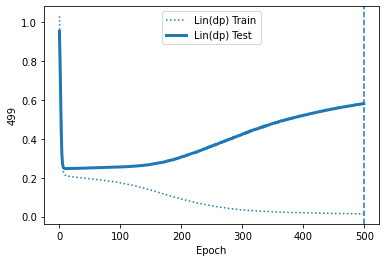

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=3, bias=True)
  )
)

In [32]:
seq_len = len(train_df['upstream_region'].values[0])

mer8motif_model_lin_d = DNA_Linear_Deep(
    seq_len,
    h0_size=100,
    h1_size=100,
)
mer8motif_model_lin_d.to(DEVICE)


#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d,estop = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_lin_d,
    loss_func,
    lr=0.01,
    epochs=500
)

# to plot loss
mer8motif_lin_d_data_label = [((mer8motif_train_losses_lin_d,mer8motif_test_losses_lin_d),"Lin(dp)",estop)]
tu.quick_loss_plot(mer8motif_lin_d_data_label,estop)

mer8motif_model_lin_d

In [33]:
mer8motif_model_lin_d

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=3, bias=True)
  )
)

### CNN model

In [34]:
class TINKER_DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters0=32,
                 num_filters1=32,
                 kernel_size0=8,
                 kernel_size1=8,
                 conv_pool_size0=1,
                 conv_pool_size1=1,
                 fc_node_num0 = 10,
                 fc_node_num1 = 10
                ):
        super().__init__()
        
        self.seq_len = seq_len
        
        # calculation for number of linear nodes need to come after final conv layer
        linear_node_num = int(np.floor((seq_len - kernel_size0 + 1)/conv_pool_size0))
        linear_node_num = int(np.floor((linear_node_num - kernel_size1 + 1)/conv_pool_size1))
        linear_node_num = linear_node_num*num_filters1
        #linear_node_num = linear_node_num*num_filters0
        
        self.conv_net = nn.Sequential(
            # Conv layer 0
            nn.Conv2d(1, num_filters0, kernel_size=(4,kernel_size0)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.MaxPool2d((1,conv_pool_size0)), # def stride = kernel_size
            nn.Dropout(0.5),

            # Conv layer 1
            nn.Conv2d(num_filters0, num_filters1, kernel_size=(1,kernel_size1)),
            nn.ReLU(),
            
            nn.Flatten(),
            # Fully connected layer 0
            nn.Linear(linear_node_num, fc_node_num0),
            nn.ReLU(),
            nn.Dropout(0.5),
            # Fully connected layer 0
#             nn.Linear(fc_node_num0, fc_node_num1),
#             nn.ReLU(),
            # final prediction
            nn.Linear(fc_node_num0, 3),
            #nn.Softmax(dim=1)
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        return out

E:6 | train loss:0.326 | val loss: 0.253:   0%|          | 6/2500 [00:00<02:47, 14.86it/s]

EarlyStopping counter: 1 out of 1000


E:13 | train loss:0.299 | val loss: 0.248:   0%|          | 12/2500 [00:00<02:18, 17.99it/s]

EarlyStopping counter: 1 out of 1000


E:19 | train loss:0.301 | val loss: 0.245:   1%|          | 19/2500 [00:01<02:09, 19.19it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 1 out of 1000


E:24 | train loss:0.266 | val loss: 0.248:   1%|          | 24/2500 [00:01<02:06, 19.64it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:28 | train loss:0.260 | val loss: 0.247:   1%|          | 28/2500 [00:01<02:06, 19.61it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:32 | train loss:0.247 | val loss: 0.247:   1%|▏         | 32/2500 [00:01<02:09, 19.02it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:37 | train loss:0.271 | val loss: 0.247:   1%|▏         | 36/2500 [00:02<02:07, 19.34it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:41 | train loss:0.264 | val loss: 0.249:   2%|▏         | 41/2500 [00:02<02:06, 19.49it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:46 | train loss:0.263 | val loss: 0.250:   2%|▏         | 45/2500 [00:02<02:05, 19.52it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000


E:51 | train loss:0.272 | val loss: 0.249:   2%|▏         | 50/2500 [00:02<02:04, 19.76it/s]

EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000


E:55 | train loss:0.254 | val loss: 0.250:   2%|▏         | 55/2500 [00:02<02:03, 19.77it/s]

EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000


E:59 | train loss:0.248 | val loss: 0.251:   2%|▏         | 59/2500 [00:03<02:03, 19.76it/s]

EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000


E:63 | train loss:0.275 | val loss: 0.249:   3%|▎         | 63/2500 [00:03<02:04, 19.58it/s]

EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000


E:67 | train loss:0.260 | val loss: 0.250:   3%|▎         | 67/2500 [00:03<02:04, 19.48it/s]

EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000


E:71 | train loss:0.242 | val loss: 0.253:   3%|▎         | 71/2500 [00:03<02:04, 19.47it/s]

EarlyStopping counter: 49 out of 1000
EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000


E:75 | train loss:0.250 | val loss: 0.252:   3%|▎         | 75/2500 [00:03<02:04, 19.49it/s]

EarlyStopping counter: 53 out of 1000
EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000
EarlyStopping counter: 56 out of 1000


E:79 | train loss:0.255 | val loss: 0.251:   3%|▎         | 79/2500 [00:04<02:04, 19.46it/s]

EarlyStopping counter: 57 out of 1000
EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000
EarlyStopping counter: 60 out of 1000


E:83 | train loss:0.247 | val loss: 0.251:   3%|▎         | 83/2500 [00:04<02:05, 19.31it/s]

EarlyStopping counter: 61 out of 1000
EarlyStopping counter: 62 out of 1000
EarlyStopping counter: 63 out of 1000
EarlyStopping counter: 64 out of 1000


E:87 | train loss:0.255 | val loss: 0.251:   3%|▎         | 87/2500 [00:04<02:04, 19.35it/s]

EarlyStopping counter: 65 out of 1000
EarlyStopping counter: 66 out of 1000
EarlyStopping counter: 67 out of 1000
EarlyStopping counter: 68 out of 1000


E:91 | train loss:0.248 | val loss: 0.251:   4%|▎         | 91/2500 [00:04<02:04, 19.41it/s]

EarlyStopping counter: 69 out of 1000
EarlyStopping counter: 70 out of 1000
EarlyStopping counter: 71 out of 1000
EarlyStopping counter: 72 out of 1000


E:95 | train loss:0.252 | val loss: 0.251:   4%|▍         | 95/2500 [00:05<02:03, 19.49it/s]

EarlyStopping counter: 73 out of 1000
EarlyStopping counter: 74 out of 1000
EarlyStopping counter: 75 out of 1000
EarlyStopping counter: 76 out of 1000


E:99 | train loss:0.249 | val loss: 0.252:   4%|▍         | 99/2500 [00:05<02:03, 19.44it/s]

EarlyStopping counter: 77 out of 1000
EarlyStopping counter: 78 out of 1000
EarlyStopping counter: 79 out of 1000
EarlyStopping counter: 80 out of 1000


E:104 | train loss:0.243 | val loss: 0.251:   4%|▍         | 105/2500 [00:05<02:00, 19.92it/s]

EarlyStopping counter: 81 out of 1000
EarlyStopping counter: 82 out of 1000
EarlyStopping counter: 83 out of 1000
EarlyStopping counter: 84 out of 1000
EarlyStopping counter: 85 out of 1000


E:109 | train loss:0.249 | val loss: 0.250:   4%|▍         | 108/2500 [00:05<01:59, 20.04it/s]

EarlyStopping counter: 86 out of 1000
EarlyStopping counter: 87 out of 1000
EarlyStopping counter: 88 out of 1000
EarlyStopping counter: 89 out of 1000
EarlyStopping counter: 90 out of 1000


E:114 | train loss:0.242 | val loss: 0.251:   5%|▍         | 114/2500 [00:05<01:58, 20.16it/s]

EarlyStopping counter: 91 out of 1000
EarlyStopping counter: 92 out of 1000
EarlyStopping counter: 93 out of 1000
EarlyStopping counter: 94 out of 1000
EarlyStopping counter: 95 out of 1000


E:118 | train loss:0.240 | val loss: 0.251:   5%|▍         | 117/2500 [00:06<01:58, 20.11it/s]

EarlyStopping counter: 96 out of 1000
EarlyStopping counter: 97 out of 1000
EarlyStopping counter: 98 out of 1000
EarlyStopping counter: 99 out of 1000


E:123 | train loss:0.243 | val loss: 0.250:   5%|▍         | 123/2500 [00:06<01:58, 20.09it/s]

EarlyStopping counter: 100 out of 1000
EarlyStopping counter: 101 out of 1000
EarlyStopping counter: 102 out of 1000
EarlyStopping counter: 103 out of 1000
EarlyStopping counter: 104 out of 1000


E:128 | train loss:0.248 | val loss: 0.250:   5%|▌         | 129/2500 [00:06<01:57, 20.21it/s]

EarlyStopping counter: 105 out of 1000
EarlyStopping counter: 106 out of 1000
EarlyStopping counter: 107 out of 1000
EarlyStopping counter: 108 out of 1000
EarlyStopping counter: 109 out of 1000


E:133 | train loss:0.259 | val loss: 0.250:   5%|▌         | 132/2500 [00:06<01:57, 20.23it/s]

EarlyStopping counter: 110 out of 1000
EarlyStopping counter: 111 out of 1000
EarlyStopping counter: 112 out of 1000
EarlyStopping counter: 113 out of 1000
EarlyStopping counter: 114 out of 1000


E:137 | train loss:0.237 | val loss: 0.250:   6%|▌         | 138/2500 [00:07<01:58, 20.01it/s]

EarlyStopping counter: 115 out of 1000
EarlyStopping counter: 116 out of 1000
EarlyStopping counter: 117 out of 1000
EarlyStopping counter: 118 out of 1000


E:142 | train loss:0.241 | val loss: 0.250:   6%|▌         | 141/2500 [00:07<01:57, 20.01it/s]

EarlyStopping counter: 119 out of 1000
EarlyStopping counter: 120 out of 1000
EarlyStopping counter: 121 out of 1000
EarlyStopping counter: 122 out of 1000
EarlyStopping counter: 123 out of 1000


E:146 | train loss:0.237 | val loss: 0.250:   6%|▌         | 147/2500 [00:07<01:58, 19.89it/s]

EarlyStopping counter: 124 out of 1000
EarlyStopping counter: 125 out of 1000
EarlyStopping counter: 126 out of 1000
EarlyStopping counter: 127 out of 1000


E:151 | train loss:0.240 | val loss: 0.250:   6%|▌         | 149/2500 [00:07<01:58, 19.76it/s]

EarlyStopping counter: 128 out of 1000
EarlyStopping counter: 129 out of 1000
EarlyStopping counter: 130 out of 1000
EarlyStopping counter: 131 out of 1000


E:155 | train loss:0.236 | val loss: 0.250:   6%|▌         | 154/2500 [00:08<01:59, 19.60it/s]

EarlyStopping counter: 132 out of 1000
EarlyStopping counter: 133 out of 1000
EarlyStopping counter: 134 out of 1000
EarlyStopping counter: 135 out of 1000
EarlyStopping counter: 136 out of 1000


E:159 | train loss:0.241 | val loss: 0.250:   6%|▋         | 159/2500 [00:08<01:58, 19.81it/s]

EarlyStopping counter: 137 out of 1000
EarlyStopping counter: 138 out of 1000
EarlyStopping counter: 139 out of 1000
EarlyStopping counter: 140 out of 1000


E:164 | train loss:0.247 | val loss: 0.250:   7%|▋         | 164/2500 [00:08<01:57, 19.84it/s]

EarlyStopping counter: 141 out of 1000
EarlyStopping counter: 142 out of 1000
EarlyStopping counter: 143 out of 1000
EarlyStopping counter: 144 out of 1000
EarlyStopping counter: 145 out of 1000


E:168 | train loss:0.237 | val loss: 0.250:   7%|▋         | 169/2500 [00:08<01:58, 19.64it/s]

EarlyStopping counter: 146 out of 1000
EarlyStopping counter: 147 out of 1000
EarlyStopping counter: 148 out of 1000
EarlyStopping counter: 149 out of 1000


E:173 | train loss:0.232 | val loss: 0.250:   7%|▋         | 172/2500 [00:08<01:57, 19.85it/s]

EarlyStopping counter: 150 out of 1000
EarlyStopping counter: 151 out of 1000
EarlyStopping counter: 152 out of 1000
EarlyStopping counter: 153 out of 1000
EarlyStopping counter: 154 out of 1000


E:177 | train loss:0.238 | val loss: 0.250:   7%|▋         | 177/2500 [00:09<01:57, 19.85it/s]

EarlyStopping counter: 155 out of 1000
EarlyStopping counter: 156 out of 1000
EarlyStopping counter: 157 out of 1000
EarlyStopping counter: 158 out of 1000


E:181 | train loss:0.228 | val loss: 0.250:   7%|▋         | 181/2500 [00:09<02:00, 19.24it/s]

EarlyStopping counter: 159 out of 1000
EarlyStopping counter: 160 out of 1000
EarlyStopping counter: 161 out of 1000
EarlyStopping counter: 162 out of 1000


E:185 | train loss:0.227 | val loss: 0.250:   7%|▋         | 185/2500 [00:09<02:02, 18.89it/s]

EarlyStopping counter: 163 out of 1000
EarlyStopping counter: 164 out of 1000
EarlyStopping counter: 165 out of 1000
EarlyStopping counter: 166 out of 1000


E:189 | train loss:0.239 | val loss: 0.250:   8%|▊         | 189/2500 [00:09<02:03, 18.73it/s]

EarlyStopping counter: 167 out of 1000
EarlyStopping counter: 168 out of 1000
EarlyStopping counter: 169 out of 1000
EarlyStopping counter: 170 out of 1000


E:193 | train loss:0.237 | val loss: 0.251:   8%|▊         | 193/2500 [00:09<02:01, 18.94it/s]

EarlyStopping counter: 171 out of 1000
EarlyStopping counter: 172 out of 1000
EarlyStopping counter: 173 out of 1000
EarlyStopping counter: 174 out of 1000


E:198 | train loss:0.231 | val loss: 0.250:   8%|▊         | 199/2500 [00:10<01:56, 19.76it/s]

EarlyStopping counter: 175 out of 1000
EarlyStopping counter: 176 out of 1000
EarlyStopping counter: 177 out of 1000
EarlyStopping counter: 178 out of 1000
EarlyStopping counter: 179 out of 1000


E:202 | train loss:0.238 | val loss: 0.249:   8%|▊         | 203/2500 [00:10<01:56, 19.75it/s]

EarlyStopping counter: 180 out of 1000
EarlyStopping counter: 181 out of 1000
EarlyStopping counter: 182 out of 1000
EarlyStopping counter: 183 out of 1000


E:206 | train loss:0.237 | val loss: 0.249:   8%|▊         | 207/2500 [00:10<01:59, 19.20it/s]

EarlyStopping counter: 184 out of 1000
EarlyStopping counter: 185 out of 1000
EarlyStopping counter: 186 out of 1000
EarlyStopping counter: 187 out of 1000


E:211 | train loss:0.237 | val loss: 0.250:   8%|▊         | 212/2500 [00:10<01:56, 19.61it/s]

EarlyStopping counter: 188 out of 1000
EarlyStopping counter: 189 out of 1000
EarlyStopping counter: 190 out of 1000
EarlyStopping counter: 191 out of 1000
EarlyStopping counter: 192 out of 1000


E:215 | train loss:0.230 | val loss: 0.250:   9%|▊         | 216/2500 [00:11<01:56, 19.64it/s]

EarlyStopping counter: 193 out of 1000
EarlyStopping counter: 194 out of 1000
EarlyStopping counter: 195 out of 1000
EarlyStopping counter: 196 out of 1000


E:219 | train loss:0.225 | val loss: 0.250:   9%|▉         | 220/2500 [00:11<01:56, 19.54it/s]

EarlyStopping counter: 197 out of 1000
EarlyStopping counter: 198 out of 1000
EarlyStopping counter: 199 out of 1000
EarlyStopping counter: 200 out of 1000


E:223 | train loss:0.234 | val loss: 0.249:   9%|▉         | 224/2500 [00:11<01:55, 19.63it/s]

EarlyStopping counter: 201 out of 1000
EarlyStopping counter: 202 out of 1000
EarlyStopping counter: 203 out of 1000
EarlyStopping counter: 204 out of 1000


E:228 | train loss:0.224 | val loss: 0.249:   9%|▉         | 227/2500 [00:11<01:54, 19.83it/s]

EarlyStopping counter: 205 out of 1000
EarlyStopping counter: 206 out of 1000
EarlyStopping counter: 207 out of 1000
EarlyStopping counter: 208 out of 1000
EarlyStopping counter: 209 out of 1000


E:232 | train loss:0.228 | val loss: 0.249:   9%|▉         | 232/2500 [00:11<01:54, 19.81it/s]

EarlyStopping counter: 210 out of 1000
EarlyStopping counter: 211 out of 1000
EarlyStopping counter: 212 out of 1000
EarlyStopping counter: 213 out of 1000


E:236 | train loss:0.231 | val loss: 0.249:   9%|▉         | 236/2500 [00:12<01:55, 19.61it/s]

EarlyStopping counter: 214 out of 1000
EarlyStopping counter: 215 out of 1000
EarlyStopping counter: 216 out of 1000
EarlyStopping counter: 217 out of 1000


E:240 | train loss:0.233 | val loss: 0.249:  10%|▉         | 240/2500 [00:12<01:56, 19.46it/s]

EarlyStopping counter: 218 out of 1000
EarlyStopping counter: 219 out of 1000
EarlyStopping counter: 220 out of 1000
EarlyStopping counter: 221 out of 1000


E:244 | train loss:0.233 | val loss: 0.250:  10%|▉         | 244/2500 [00:12<01:56, 19.44it/s]

EarlyStopping counter: 222 out of 1000
EarlyStopping counter: 223 out of 1000
EarlyStopping counter: 224 out of 1000
EarlyStopping counter: 225 out of 1000


E:248 | train loss:0.230 | val loss: 0.249:  10%|▉         | 248/2500 [00:12<01:55, 19.45it/s]

EarlyStopping counter: 226 out of 1000
EarlyStopping counter: 227 out of 1000
EarlyStopping counter: 228 out of 1000
EarlyStopping counter: 229 out of 1000


E:252 | train loss:0.226 | val loss: 0.249:  10%|█         | 252/2500 [00:13<01:55, 19.47it/s]

EarlyStopping counter: 230 out of 1000
EarlyStopping counter: 231 out of 1000
EarlyStopping counter: 232 out of 1000
EarlyStopping counter: 233 out of 1000


E:256 | train loss:0.224 | val loss: 0.250:  10%|█         | 257/2500 [00:13<01:55, 19.40it/s]

EarlyStopping counter: 234 out of 1000
EarlyStopping counter: 235 out of 1000
EarlyStopping counter: 236 out of 1000
EarlyStopping counter: 237 out of 1000


E:260 | train loss:0.229 | val loss: 0.249:  10%|█         | 261/2500 [00:13<01:54, 19.50it/s]

EarlyStopping counter: 238 out of 1000
EarlyStopping counter: 239 out of 1000
EarlyStopping counter: 240 out of 1000
EarlyStopping counter: 241 out of 1000


E:265 | train loss:0.224 | val loss: 0.249:  11%|█         | 266/2500 [00:13<01:52, 19.89it/s]

EarlyStopping counter: 242 out of 1000
EarlyStopping counter: 243 out of 1000
EarlyStopping counter: 244 out of 1000
EarlyStopping counter: 245 out of 1000
EarlyStopping counter: 246 out of 1000


E:270 | train loss:0.228 | val loss: 0.248:  11%|█         | 271/2500 [00:13<01:51, 19.98it/s]

EarlyStopping counter: 247 out of 1000
EarlyStopping counter: 248 out of 1000
EarlyStopping counter: 249 out of 1000
EarlyStopping counter: 250 out of 1000
EarlyStopping counter: 251 out of 1000


E:274 | train loss:0.220 | val loss: 0.249:  11%|█         | 275/2500 [00:14<01:52, 19.86it/s]

EarlyStopping counter: 252 out of 1000
EarlyStopping counter: 253 out of 1000
EarlyStopping counter: 254 out of 1000
EarlyStopping counter: 255 out of 1000


E:278 | train loss:0.227 | val loss: 0.249:  11%|█         | 279/2500 [00:14<01:52, 19.67it/s]

EarlyStopping counter: 256 out of 1000
EarlyStopping counter: 257 out of 1000
EarlyStopping counter: 258 out of 1000
EarlyStopping counter: 259 out of 1000


E:282 | train loss:0.213 | val loss: 0.250:  11%|█▏        | 282/2500 [00:14<01:51, 19.88it/s]

EarlyStopping counter: 260 out of 1000
EarlyStopping counter: 261 out of 1000
EarlyStopping counter: 262 out of 1000
EarlyStopping counter: 263 out of 1000


E:285 | train loss:0.228 | val loss: 0.249:  11%|█▏        | 286/2500 [00:14<01:54, 19.42it/s]

EarlyStopping counter: 264 out of 1000
EarlyStopping counter: 265 out of 1000
EarlyStopping counter: 266 out of 1000


E:289 | train loss:0.228 | val loss: 0.249:  12%|█▏        | 290/2500 [00:14<02:14, 16.46it/s]

EarlyStopping counter: 267 out of 1000
EarlyStopping counter: 268 out of 1000
EarlyStopping counter: 269 out of 1000
EarlyStopping counter: 270 out of 1000


E:294 | train loss:0.228 | val loss: 0.248:  12%|█▏        | 293/2500 [00:15<02:04, 17.74it/s]

EarlyStopping counter: 271 out of 1000
EarlyStopping counter: 272 out of 1000
EarlyStopping counter: 273 out of 1000
EarlyStopping counter: 274 out of 1000
EarlyStopping counter: 275 out of 1000


E:298 | train loss:0.227 | val loss: 0.249:  12%|█▏        | 298/2500 [00:15<02:00, 18.34it/s]

EarlyStopping counter: 276 out of 1000
EarlyStopping counter: 277 out of 1000
EarlyStopping counter: 278 out of 1000
EarlyStopping counter: 279 out of 1000


E:302 | train loss:0.221 | val loss: 0.249:  12%|█▏        | 302/2500 [00:15<01:58, 18.49it/s]

EarlyStopping counter: 280 out of 1000
EarlyStopping counter: 281 out of 1000
EarlyStopping counter: 282 out of 1000
EarlyStopping counter: 283 out of 1000


E:306 | train loss:0.215 | val loss: 0.249:  12%|█▏        | 306/2500 [00:15<01:59, 18.42it/s]

EarlyStopping counter: 284 out of 1000
EarlyStopping counter: 285 out of 1000
EarlyStopping counter: 286 out of 1000
EarlyStopping counter: 287 out of 1000


E:310 | train loss:0.220 | val loss: 0.250:  12%|█▏        | 310/2500 [00:16<01:56, 18.80it/s]

EarlyStopping counter: 288 out of 1000
EarlyStopping counter: 289 out of 1000
EarlyStopping counter: 290 out of 1000
EarlyStopping counter: 291 out of 1000


E:314 | train loss:0.219 | val loss: 0.249:  13%|█▎        | 314/2500 [00:16<01:55, 18.97it/s]

EarlyStopping counter: 292 out of 1000
EarlyStopping counter: 293 out of 1000
EarlyStopping counter: 294 out of 1000
EarlyStopping counter: 295 out of 1000


E:318 | train loss:0.222 | val loss: 0.249:  13%|█▎        | 318/2500 [00:16<01:53, 19.23it/s]

EarlyStopping counter: 296 out of 1000
EarlyStopping counter: 297 out of 1000
EarlyStopping counter: 298 out of 1000
EarlyStopping counter: 299 out of 1000


E:322 | train loss:0.214 | val loss: 0.250:  13%|█▎        | 322/2500 [00:16<01:52, 19.37it/s]

EarlyStopping counter: 300 out of 1000
EarlyStopping counter: 301 out of 1000
EarlyStopping counter: 302 out of 1000
EarlyStopping counter: 303 out of 1000


E:326 | train loss:0.215 | val loss: 0.249:  13%|█▎        | 327/2500 [00:16<01:50, 19.60it/s]

EarlyStopping counter: 304 out of 1000
EarlyStopping counter: 305 out of 1000
EarlyStopping counter: 306 out of 1000
EarlyStopping counter: 307 out of 1000


E:330 | train loss:0.214 | val loss: 0.249:  13%|█▎        | 331/2500 [00:17<01:51, 19.48it/s]

EarlyStopping counter: 308 out of 1000
EarlyStopping counter: 309 out of 1000
EarlyStopping counter: 310 out of 1000
EarlyStopping counter: 311 out of 1000


E:334 | train loss:0.220 | val loss: 0.249:  13%|█▎        | 335/2500 [00:17<01:50, 19.56it/s]

EarlyStopping counter: 312 out of 1000
EarlyStopping counter: 313 out of 1000
EarlyStopping counter: 314 out of 1000
EarlyStopping counter: 315 out of 1000


E:338 | train loss:0.219 | val loss: 0.249:  14%|█▎        | 339/2500 [00:17<01:51, 19.32it/s]

EarlyStopping counter: 316 out of 1000
EarlyStopping counter: 317 out of 1000
EarlyStopping counter: 318 out of 1000
EarlyStopping counter: 319 out of 1000


E:343 | train loss:0.218 | val loss: 0.249:  14%|█▎        | 342/2500 [00:17<01:49, 19.67it/s]

EarlyStopping counter: 320 out of 1000
EarlyStopping counter: 321 out of 1000
EarlyStopping counter: 322 out of 1000
EarlyStopping counter: 323 out of 1000
EarlyStopping counter: 324 out of 1000


E:348 | train loss:0.217 | val loss: 0.249:  14%|█▍        | 348/2500 [00:18<01:47, 20.02it/s]

EarlyStopping counter: 325 out of 1000
EarlyStopping counter: 326 out of 1000
EarlyStopping counter: 327 out of 1000
EarlyStopping counter: 328 out of 1000
EarlyStopping counter: 329 out of 1000


E:352 | train loss:0.211 | val loss: 0.249:  14%|█▍        | 351/2500 [00:18<01:46, 20.10it/s]

EarlyStopping counter: 330 out of 1000
EarlyStopping counter: 331 out of 1000
EarlyStopping counter: 332 out of 1000
EarlyStopping counter: 333 out of 1000


E:356 | train loss:0.215 | val loss: 0.249:  14%|█▍        | 356/2500 [00:18<01:48, 19.71it/s]

EarlyStopping counter: 334 out of 1000
EarlyStopping counter: 335 out of 1000
EarlyStopping counter: 336 out of 1000
EarlyStopping counter: 337 out of 1000


E:360 | train loss:0.214 | val loss: 0.249:  14%|█▍        | 360/2500 [00:18<01:49, 19.54it/s]

EarlyStopping counter: 338 out of 1000
EarlyStopping counter: 339 out of 1000
EarlyStopping counter: 340 out of 1000
EarlyStopping counter: 341 out of 1000


E:364 | train loss:0.220 | val loss: 0.249:  15%|█▍        | 365/2500 [00:18<01:48, 19.70it/s]

EarlyStopping counter: 342 out of 1000
EarlyStopping counter: 343 out of 1000
EarlyStopping counter: 344 out of 1000
EarlyStopping counter: 345 out of 1000


E:368 | train loss:0.217 | val loss: 0.249:  15%|█▍        | 369/2500 [00:19<01:49, 19.46it/s]

EarlyStopping counter: 346 out of 1000
EarlyStopping counter: 347 out of 1000
EarlyStopping counter: 348 out of 1000
EarlyStopping counter: 349 out of 1000


E:372 | train loss:0.218 | val loss: 0.248:  15%|█▍        | 373/2500 [00:19<01:50, 19.31it/s]

EarlyStopping counter: 350 out of 1000
EarlyStopping counter: 351 out of 1000
EarlyStopping counter: 352 out of 1000
EarlyStopping counter: 353 out of 1000


E:376 | train loss:0.218 | val loss: 0.248:  15%|█▌        | 377/2500 [00:19<01:49, 19.32it/s]

EarlyStopping counter: 354 out of 1000
EarlyStopping counter: 355 out of 1000
EarlyStopping counter: 356 out of 1000
EarlyStopping counter: 357 out of 1000


E:380 | train loss:0.212 | val loss: 0.249:  15%|█▌        | 381/2500 [00:19<01:50, 19.25it/s]

EarlyStopping counter: 358 out of 1000
EarlyStopping counter: 359 out of 1000
EarlyStopping counter: 360 out of 1000
EarlyStopping counter: 361 out of 1000


E:384 | train loss:0.220 | val loss: 0.249:  15%|█▌        | 385/2500 [00:19<01:51, 19.04it/s]

EarlyStopping counter: 362 out of 1000
EarlyStopping counter: 363 out of 1000
EarlyStopping counter: 364 out of 1000
EarlyStopping counter: 365 out of 1000


E:388 | train loss:0.213 | val loss: 0.249:  16%|█▌        | 389/2500 [00:20<01:50, 19.08it/s]

EarlyStopping counter: 366 out of 1000
EarlyStopping counter: 367 out of 1000
EarlyStopping counter: 368 out of 1000
EarlyStopping counter: 369 out of 1000


E:392 | train loss:0.202 | val loss: 0.250:  16%|█▌        | 393/2500 [00:20<01:50, 19.03it/s]

EarlyStopping counter: 370 out of 1000
EarlyStopping counter: 371 out of 1000
EarlyStopping counter: 372 out of 1000
EarlyStopping counter: 373 out of 1000


E:396 | train loss:0.216 | val loss: 0.249:  16%|█▌        | 397/2500 [00:20<01:48, 19.35it/s]

EarlyStopping counter: 374 out of 1000
EarlyStopping counter: 375 out of 1000
EarlyStopping counter: 376 out of 1000
EarlyStopping counter: 377 out of 1000


E:400 | train loss:0.210 | val loss: 0.249:  16%|█▌        | 401/2500 [00:20<01:47, 19.51it/s]

EarlyStopping counter: 378 out of 1000
EarlyStopping counter: 379 out of 1000
EarlyStopping counter: 380 out of 1000
EarlyStopping counter: 381 out of 1000


E:404 | train loss:0.204 | val loss: 0.249:  16%|█▌        | 403/2500 [00:20<01:48, 19.37it/s]

EarlyStopping counter: 382 out of 1000
EarlyStopping counter: 383 out of 1000
EarlyStopping counter: 384 out of 1000
EarlyStopping counter: 385 out of 1000


E:409 | train loss:0.209 | val loss: 0.249:  16%|█▋        | 409/2500 [00:21<01:45, 19.80it/s]

EarlyStopping counter: 386 out of 1000
EarlyStopping counter: 387 out of 1000
EarlyStopping counter: 388 out of 1000
EarlyStopping counter: 389 out of 1000
EarlyStopping counter: 390 out of 1000


E:414 | train loss:0.213 | val loss: 0.248:  17%|█▋        | 414/2500 [00:21<01:44, 19.94it/s]

EarlyStopping counter: 391 out of 1000
EarlyStopping counter: 392 out of 1000
EarlyStopping counter: 393 out of 1000
EarlyStopping counter: 394 out of 1000
EarlyStopping counter: 395 out of 1000


E:418 | train loss:0.209 | val loss: 0.248:  17%|█▋        | 418/2500 [00:21<01:44, 19.86it/s]

EarlyStopping counter: 396 out of 1000
EarlyStopping counter: 397 out of 1000
EarlyStopping counter: 398 out of 1000
EarlyStopping counter: 399 out of 1000


E:422 | train loss:0.203 | val loss: 0.249:  17%|█▋        | 422/2500 [00:21<01:46, 19.52it/s]

EarlyStopping counter: 400 out of 1000
EarlyStopping counter: 401 out of 1000
EarlyStopping counter: 402 out of 1000
EarlyStopping counter: 403 out of 1000


E:427 | train loss:0.210 | val loss: 0.250:  17%|█▋        | 426/2500 [00:22<01:46, 19.53it/s]

EarlyStopping counter: 404 out of 1000
EarlyStopping counter: 405 out of 1000
EarlyStopping counter: 406 out of 1000
EarlyStopping counter: 407 out of 1000
EarlyStopping counter: 408 out of 1000


E:431 | train loss:0.204 | val loss: 0.249:  17%|█▋        | 432/2500 [00:22<01:44, 19.87it/s]

EarlyStopping counter: 409 out of 1000
EarlyStopping counter: 410 out of 1000
EarlyStopping counter: 411 out of 1000
EarlyStopping counter: 412 out of 1000


E:435 | train loss:0.209 | val loss: 0.248:  17%|█▋        | 436/2500 [00:22<01:44, 19.68it/s]

EarlyStopping counter: 413 out of 1000
EarlyStopping counter: 414 out of 1000
EarlyStopping counter: 415 out of 1000
EarlyStopping counter: 416 out of 1000


E:440 | train loss:0.213 | val loss: 0.248:  18%|█▊        | 439/2500 [00:22<01:43, 19.88it/s]

EarlyStopping counter: 417 out of 1000
EarlyStopping counter: 418 out of 1000
EarlyStopping counter: 419 out of 1000
EarlyStopping counter: 420 out of 1000
EarlyStopping counter: 421 out of 1000


E:444 | train loss:0.211 | val loss: 0.248:  18%|█▊        | 444/2500 [00:22<01:44, 19.68it/s]

EarlyStopping counter: 422 out of 1000
EarlyStopping counter: 423 out of 1000
EarlyStopping counter: 424 out of 1000
EarlyStopping counter: 425 out of 1000


E:448 | train loss:0.205 | val loss: 0.250:  18%|█▊        | 448/2500 [00:23<01:45, 19.49it/s]

EarlyStopping counter: 426 out of 1000
EarlyStopping counter: 427 out of 1000
EarlyStopping counter: 428 out of 1000
EarlyStopping counter: 429 out of 1000


E:453 | train loss:0.206 | val loss: 0.249:  18%|█▊        | 452/2500 [00:23<01:44, 19.57it/s]

EarlyStopping counter: 430 out of 1000
EarlyStopping counter: 431 out of 1000
EarlyStopping counter: 432 out of 1000
EarlyStopping counter: 433 out of 1000


E:456 | train loss:0.203 | val loss: 0.249:  18%|█▊        | 457/2500 [00:23<01:44, 19.57it/s]

EarlyStopping counter: 434 out of 1000
EarlyStopping counter: 435 out of 1000
EarlyStopping counter: 436 out of 1000
EarlyStopping counter: 437 out of 1000


E:460 | train loss:0.199 | val loss: 0.250:  18%|█▊        | 459/2500 [00:23<01:44, 19.60it/s]

EarlyStopping counter: 438 out of 1000
EarlyStopping counter: 439 out of 1000
EarlyStopping counter: 440 out of 1000
EarlyStopping counter: 441 out of 1000


E:464 | train loss:0.201 | val loss: 0.249:  19%|█▊        | 464/2500 [00:23<01:44, 19.47it/s]

EarlyStopping counter: 442 out of 1000
EarlyStopping counter: 443 out of 1000
EarlyStopping counter: 444 out of 1000
EarlyStopping counter: 445 out of 1000


E:468 | train loss:0.203 | val loss: 0.250:  19%|█▉        | 469/2500 [00:24<01:43, 19.56it/s]

EarlyStopping counter: 446 out of 1000
EarlyStopping counter: 447 out of 1000
EarlyStopping counter: 448 out of 1000
EarlyStopping counter: 449 out of 1000


E:472 | train loss:0.199 | val loss: 0.249:  19%|█▉        | 473/2500 [00:24<01:45, 19.30it/s]

EarlyStopping counter: 450 out of 1000
EarlyStopping counter: 451 out of 1000
EarlyStopping counter: 452 out of 1000
EarlyStopping counter: 453 out of 1000


E:476 | train loss:0.204 | val loss: 0.250:  19%|█▉        | 475/2500 [00:24<01:45, 19.14it/s]

EarlyStopping counter: 454 out of 1000
EarlyStopping counter: 455 out of 1000
EarlyStopping counter: 456 out of 1000
EarlyStopping counter: 457 out of 1000


E:480 | train loss:0.200 | val loss: 0.251:  19%|█▉        | 480/2500 [00:24<01:44, 19.42it/s]

EarlyStopping counter: 458 out of 1000
EarlyStopping counter: 459 out of 1000
EarlyStopping counter: 460 out of 1000
EarlyStopping counter: 461 out of 1000


E:484 | train loss:0.204 | val loss: 0.250:  19%|█▉        | 485/2500 [00:24<01:42, 19.56it/s]

EarlyStopping counter: 462 out of 1000
EarlyStopping counter: 463 out of 1000
EarlyStopping counter: 464 out of 1000
EarlyStopping counter: 465 out of 1000


E:488 | train loss:0.201 | val loss: 0.250:  20%|█▉        | 489/2500 [00:25<01:43, 19.38it/s]

EarlyStopping counter: 466 out of 1000
EarlyStopping counter: 467 out of 1000
EarlyStopping counter: 468 out of 1000
EarlyStopping counter: 469 out of 1000


E:492 | train loss:0.203 | val loss: 0.249:  20%|█▉        | 493/2500 [00:25<01:43, 19.30it/s]

EarlyStopping counter: 470 out of 1000
EarlyStopping counter: 471 out of 1000
EarlyStopping counter: 472 out of 1000
EarlyStopping counter: 473 out of 1000


E:496 | train loss:0.194 | val loss: 0.252:  20%|█▉        | 497/2500 [00:25<01:43, 19.43it/s]

EarlyStopping counter: 474 out of 1000
EarlyStopping counter: 475 out of 1000
EarlyStopping counter: 476 out of 1000
EarlyStopping counter: 477 out of 1000


E:500 | train loss:0.195 | val loss: 0.252:  20%|██        | 501/2500 [00:25<01:43, 19.36it/s]

EarlyStopping counter: 478 out of 1000
EarlyStopping counter: 479 out of 1000
EarlyStopping counter: 480 out of 1000
EarlyStopping counter: 481 out of 1000


E:504 | train loss:0.200 | val loss: 0.250:  20%|██        | 505/2500 [00:26<01:42, 19.43it/s]

EarlyStopping counter: 482 out of 1000
EarlyStopping counter: 483 out of 1000
EarlyStopping counter: 484 out of 1000
EarlyStopping counter: 485 out of 1000


E:509 | train loss:0.202 | val loss: 0.250:  20%|██        | 508/2500 [00:26<01:40, 19.78it/s]

EarlyStopping counter: 486 out of 1000
EarlyStopping counter: 487 out of 1000
EarlyStopping counter: 488 out of 1000
EarlyStopping counter: 489 out of 1000
EarlyStopping counter: 490 out of 1000


E:514 | train loss:0.194 | val loss: 0.252:  21%|██        | 514/2500 [00:26<01:39, 20.00it/s]

EarlyStopping counter: 491 out of 1000
EarlyStopping counter: 492 out of 1000
EarlyStopping counter: 493 out of 1000
EarlyStopping counter: 494 out of 1000
EarlyStopping counter: 495 out of 1000


E:519 | train loss:0.194 | val loss: 0.251:  21%|██        | 520/2500 [00:26<01:38, 20.09it/s]

EarlyStopping counter: 496 out of 1000
EarlyStopping counter: 497 out of 1000
EarlyStopping counter: 498 out of 1000
EarlyStopping counter: 499 out of 1000
EarlyStopping counter: 500 out of 1000


E:524 | train loss:0.192 | val loss: 0.252:  21%|██        | 523/2500 [00:27<01:38, 20.15it/s]

EarlyStopping counter: 501 out of 1000
EarlyStopping counter: 502 out of 1000
EarlyStopping counter: 503 out of 1000
EarlyStopping counter: 504 out of 1000
EarlyStopping counter: 505 out of 1000


E:529 | train loss:0.191 | val loss: 0.252:  21%|██        | 529/2500 [00:27<01:37, 20.26it/s]

EarlyStopping counter: 506 out of 1000
EarlyStopping counter: 507 out of 1000
EarlyStopping counter: 508 out of 1000
EarlyStopping counter: 509 out of 1000
EarlyStopping counter: 510 out of 1000


E:534 | train loss:0.192 | val loss: 0.254:  21%|██▏       | 535/2500 [00:27<01:37, 20.18it/s]

EarlyStopping counter: 511 out of 1000
EarlyStopping counter: 512 out of 1000
EarlyStopping counter: 513 out of 1000
EarlyStopping counter: 514 out of 1000
EarlyStopping counter: 515 out of 1000


E:539 | train loss:0.190 | val loss: 0.255:  22%|██▏       | 538/2500 [00:27<01:37, 20.18it/s]

EarlyStopping counter: 516 out of 1000
EarlyStopping counter: 517 out of 1000
EarlyStopping counter: 518 out of 1000
EarlyStopping counter: 519 out of 1000
EarlyStopping counter: 520 out of 1000


E:544 | train loss:0.185 | val loss: 0.257:  22%|██▏       | 544/2500 [00:27<01:37, 20.02it/s]

EarlyStopping counter: 521 out of 1000
EarlyStopping counter: 522 out of 1000
EarlyStopping counter: 523 out of 1000
EarlyStopping counter: 524 out of 1000


E:547 | train loss:0.191 | val loss: 0.254:  22%|██▏       | 547/2500 [00:28<01:37, 20.07it/s]

EarlyStopping counter: 525 out of 1000
EarlyStopping counter: 526 out of 1000
EarlyStopping counter: 527 out of 1000
EarlyStopping counter: 528 out of 1000


E:551 | train loss:0.195 | val loss: 0.255:  22%|██▏       | 552/2500 [00:28<01:38, 19.73it/s]

EarlyStopping counter: 529 out of 1000
EarlyStopping counter: 530 out of 1000
EarlyStopping counter: 531 out of 1000
EarlyStopping counter: 532 out of 1000


E:555 | train loss:0.189 | val loss: 0.255:  22%|██▏       | 555/2500 [00:28<01:38, 19.76it/s]

EarlyStopping counter: 533 out of 1000
EarlyStopping counter: 534 out of 1000
EarlyStopping counter: 535 out of 1000
EarlyStopping counter: 536 out of 1000


E:559 | train loss:0.188 | val loss: 0.252:  22%|██▏       | 559/2500 [00:28<01:38, 19.71it/s]

EarlyStopping counter: 537 out of 1000
EarlyStopping counter: 538 out of 1000
EarlyStopping counter: 539 out of 1000
EarlyStopping counter: 540 out of 1000


E:564 | train loss:0.189 | val loss: 0.254:  23%|██▎       | 563/2500 [00:29<01:38, 19.61it/s]

EarlyStopping counter: 541 out of 1000
EarlyStopping counter: 542 out of 1000
EarlyStopping counter: 543 out of 1000
EarlyStopping counter: 544 out of 1000


E:569 | train loss:0.184 | val loss: 0.256:  23%|██▎       | 568/2500 [00:29<01:37, 19.81it/s]

EarlyStopping counter: 545 out of 1000
EarlyStopping counter: 546 out of 1000
EarlyStopping counter: 547 out of 1000
EarlyStopping counter: 548 out of 1000
EarlyStopping counter: 549 out of 1000
EarlyStopping counter: 550 out of 1000


E:573 | train loss:0.187 | val loss: 0.256:  23%|██▎       | 574/2500 [00:29<01:36, 19.97it/s]

EarlyStopping counter: 551 out of 1000
EarlyStopping counter: 552 out of 1000
EarlyStopping counter: 553 out of 1000
EarlyStopping counter: 554 out of 1000


E:577 | train loss:0.179 | val loss: 0.255:  23%|██▎       | 578/2500 [00:29<01:37, 19.63it/s]

EarlyStopping counter: 555 out of 1000
EarlyStopping counter: 556 out of 1000
EarlyStopping counter: 557 out of 1000
EarlyStopping counter: 558 out of 1000


E:582 | train loss:0.184 | val loss: 0.259:  23%|██▎       | 583/2500 [00:29<01:36, 19.89it/s]

EarlyStopping counter: 559 out of 1000
EarlyStopping counter: 560 out of 1000
EarlyStopping counter: 561 out of 1000
EarlyStopping counter: 562 out of 1000
EarlyStopping counter: 563 out of 1000


E:587 | train loss:0.181 | val loss: 0.258:  23%|██▎       | 586/2500 [00:30<01:35, 19.98it/s]

EarlyStopping counter: 564 out of 1000
EarlyStopping counter: 565 out of 1000
EarlyStopping counter: 566 out of 1000
EarlyStopping counter: 567 out of 1000
EarlyStopping counter: 568 out of 1000


E:592 | train loss:0.187 | val loss: 0.256:  24%|██▎       | 592/2500 [00:30<01:34, 20.13it/s]

EarlyStopping counter: 569 out of 1000
EarlyStopping counter: 570 out of 1000
EarlyStopping counter: 571 out of 1000
EarlyStopping counter: 572 out of 1000
EarlyStopping counter: 573 out of 1000


E:596 | train loss:0.181 | val loss: 0.260:  24%|██▍       | 597/2500 [00:30<01:36, 19.82it/s]

EarlyStopping counter: 574 out of 1000
EarlyStopping counter: 575 out of 1000
EarlyStopping counter: 576 out of 1000
EarlyStopping counter: 577 out of 1000


E:600 | train loss:0.182 | val loss: 0.260:  24%|██▍       | 601/2500 [00:30<01:36, 19.67it/s]

EarlyStopping counter: 578 out of 1000
EarlyStopping counter: 579 out of 1000
EarlyStopping counter: 580 out of 1000
EarlyStopping counter: 581 out of 1000


E:604 | train loss:0.178 | val loss: 0.263:  24%|██▍       | 605/2500 [00:31<01:37, 19.45it/s]

EarlyStopping counter: 582 out of 1000
EarlyStopping counter: 583 out of 1000
EarlyStopping counter: 584 out of 1000
EarlyStopping counter: 585 out of 1000


E:608 | train loss:0.177 | val loss: 0.265:  24%|██▍       | 609/2500 [00:31<01:37, 19.49it/s]

EarlyStopping counter: 586 out of 1000
EarlyStopping counter: 587 out of 1000
EarlyStopping counter: 588 out of 1000
EarlyStopping counter: 589 out of 1000


E:612 | train loss:0.188 | val loss: 0.260:  25%|██▍       | 613/2500 [00:31<01:37, 19.30it/s]

EarlyStopping counter: 590 out of 1000
EarlyStopping counter: 591 out of 1000
EarlyStopping counter: 592 out of 1000
EarlyStopping counter: 593 out of 1000


E:616 | train loss:0.177 | val loss: 0.263:  25%|██▍       | 617/2500 [00:31<01:37, 19.26it/s]

EarlyStopping counter: 594 out of 1000
EarlyStopping counter: 595 out of 1000
EarlyStopping counter: 596 out of 1000
EarlyStopping counter: 597 out of 1000


E:620 | train loss:0.172 | val loss: 0.262:  25%|██▍       | 619/2500 [00:31<01:37, 19.33it/s]

EarlyStopping counter: 598 out of 1000
EarlyStopping counter: 599 out of 1000
EarlyStopping counter: 600 out of 1000
EarlyStopping counter: 601 out of 1000


E:625 | train loss:0.180 | val loss: 0.264:  25%|██▍       | 624/2500 [00:32<01:36, 19.52it/s]

EarlyStopping counter: 602 out of 1000
EarlyStopping counter: 603 out of 1000
EarlyStopping counter: 604 out of 1000
EarlyStopping counter: 605 out of 1000


E:628 | train loss:0.175 | val loss: 0.262:  25%|██▌       | 629/2500 [00:32<01:34, 19.74it/s]

EarlyStopping counter: 606 out of 1000
EarlyStopping counter: 607 out of 1000
EarlyStopping counter: 608 out of 1000
EarlyStopping counter: 609 out of 1000


E:632 | train loss:0.175 | val loss: 0.262:  25%|██▌       | 633/2500 [00:32<01:34, 19.65it/s]

EarlyStopping counter: 610 out of 1000
EarlyStopping counter: 611 out of 1000
EarlyStopping counter: 612 out of 1000
EarlyStopping counter: 613 out of 1000


E:636 | train loss:0.175 | val loss: 0.267:  25%|██▌       | 637/2500 [00:32<01:35, 19.54it/s]

EarlyStopping counter: 614 out of 1000
EarlyStopping counter: 615 out of 1000
EarlyStopping counter: 616 out of 1000
EarlyStopping counter: 617 out of 1000


E:641 | train loss:0.175 | val loss: 0.269:  26%|██▌       | 641/2500 [00:32<01:34, 19.65it/s]

EarlyStopping counter: 618 out of 1000
EarlyStopping counter: 619 out of 1000
EarlyStopping counter: 620 out of 1000
EarlyStopping counter: 621 out of 1000


E:645 | train loss:0.172 | val loss: 0.264:  26%|██▌       | 644/2500 [00:33<01:33, 19.85it/s]

EarlyStopping counter: 622 out of 1000
EarlyStopping counter: 623 out of 1000
EarlyStopping counter: 624 out of 1000
EarlyStopping counter: 625 out of 1000
EarlyStopping counter: 626 out of 1000


E:650 | train loss:0.167 | val loss: 0.270:  26%|██▌       | 649/2500 [00:33<01:32, 19.93it/s]

EarlyStopping counter: 627 out of 1000
EarlyStopping counter: 628 out of 1000
EarlyStopping counter: 629 out of 1000
EarlyStopping counter: 630 out of 1000
EarlyStopping counter: 631 out of 1000


E:655 | train loss:0.174 | val loss: 0.264:  26%|██▌       | 655/2500 [00:33<01:32, 19.99it/s]

EarlyStopping counter: 632 out of 1000
EarlyStopping counter: 633 out of 1000
EarlyStopping counter: 634 out of 1000
EarlyStopping counter: 635 out of 1000
EarlyStopping counter: 636 out of 1000


E:659 | train loss:0.176 | val loss: 0.264:  26%|██▋       | 659/2500 [00:33<01:33, 19.71it/s]

EarlyStopping counter: 637 out of 1000
EarlyStopping counter: 638 out of 1000
EarlyStopping counter: 639 out of 1000
EarlyStopping counter: 640 out of 1000


E:663 | train loss:0.172 | val loss: 0.265:  27%|██▋       | 663/2500 [00:34<01:34, 19.54it/s]

EarlyStopping counter: 641 out of 1000
EarlyStopping counter: 642 out of 1000
EarlyStopping counter: 643 out of 1000
EarlyStopping counter: 644 out of 1000


E:667 | train loss:0.169 | val loss: 0.276:  27%|██▋       | 667/2500 [00:34<01:36, 18.97it/s]

EarlyStopping counter: 645 out of 1000
EarlyStopping counter: 646 out of 1000
EarlyStopping counter: 647 out of 1000
EarlyStopping counter: 648 out of 1000


E:671 | train loss:0.167 | val loss: 0.279:  27%|██▋       | 671/2500 [00:34<01:36, 19.05it/s]

EarlyStopping counter: 649 out of 1000
EarlyStopping counter: 650 out of 1000
EarlyStopping counter: 651 out of 1000
EarlyStopping counter: 652 out of 1000


E:676 | train loss:0.173 | val loss: 0.268:  27%|██▋       | 676/2500 [00:34<01:33, 19.54it/s]

EarlyStopping counter: 653 out of 1000
EarlyStopping counter: 654 out of 1000
EarlyStopping counter: 655 out of 1000
EarlyStopping counter: 656 out of 1000
EarlyStopping counter: 657 out of 1000


E:681 | train loss:0.172 | val loss: 0.276:  27%|██▋       | 681/2500 [00:34<01:31, 19.78it/s]

EarlyStopping counter: 658 out of 1000
EarlyStopping counter: 659 out of 1000
EarlyStopping counter: 660 out of 1000
EarlyStopping counter: 661 out of 1000


E:685 | train loss:0.162 | val loss: 0.277:  27%|██▋       | 686/2500 [00:35<01:32, 19.71it/s]

EarlyStopping counter: 662 out of 1000
EarlyStopping counter: 663 out of 1000
EarlyStopping counter: 664 out of 1000
EarlyStopping counter: 665 out of 1000
EarlyStopping counter: 666 out of 1000


E:690 | train loss:0.168 | val loss: 0.278:  28%|██▊       | 689/2500 [00:35<01:31, 19.87it/s]

EarlyStopping counter: 667 out of 1000
EarlyStopping counter: 668 out of 1000
EarlyStopping counter: 669 out of 1000
EarlyStopping counter: 670 out of 1000
EarlyStopping counter: 671 out of 1000


E:695 | train loss:0.163 | val loss: 0.283:  28%|██▊       | 695/2500 [00:35<01:30, 19.97it/s]

EarlyStopping counter: 672 out of 1000
EarlyStopping counter: 673 out of 1000
EarlyStopping counter: 674 out of 1000
EarlyStopping counter: 675 out of 1000


E:698 | train loss:0.158 | val loss: 0.275:  28%|██▊       | 699/2500 [00:35<01:31, 19.66it/s]

EarlyStopping counter: 676 out of 1000
EarlyStopping counter: 677 out of 1000
EarlyStopping counter: 678 out of 1000
EarlyStopping counter: 679 out of 1000


E:703 | train loss:0.165 | val loss: 0.275:  28%|██▊       | 704/2500 [00:36<01:30, 19.77it/s]

EarlyStopping counter: 680 out of 1000
EarlyStopping counter: 681 out of 1000
EarlyStopping counter: 682 out of 1000
EarlyStopping counter: 683 out of 1000
EarlyStopping counter: 684 out of 1000


E:707 | train loss:0.163 | val loss: 0.281:  28%|██▊       | 708/2500 [00:36<01:31, 19.48it/s]

EarlyStopping counter: 685 out of 1000
EarlyStopping counter: 686 out of 1000
EarlyStopping counter: 687 out of 1000
EarlyStopping counter: 688 out of 1000


E:711 | train loss:0.159 | val loss: 0.280:  28%|██▊       | 712/2500 [00:36<01:31, 19.56it/s]

EarlyStopping counter: 689 out of 1000
EarlyStopping counter: 690 out of 1000
EarlyStopping counter: 691 out of 1000
EarlyStopping counter: 692 out of 1000


E:716 | train loss:0.160 | val loss: 0.278:  29%|██▊       | 717/2500 [00:36<01:30, 19.79it/s]

EarlyStopping counter: 693 out of 1000
EarlyStopping counter: 694 out of 1000
EarlyStopping counter: 695 out of 1000
EarlyStopping counter: 696 out of 1000
EarlyStopping counter: 697 out of 1000


E:720 | train loss:0.162 | val loss: 0.295:  29%|██▉       | 721/2500 [00:36<01:31, 19.54it/s]

EarlyStopping counter: 698 out of 1000
EarlyStopping counter: 699 out of 1000
EarlyStopping counter: 700 out of 1000
EarlyStopping counter: 701 out of 1000


E:724 | train loss:0.159 | val loss: 0.285:  29%|██▉       | 725/2500 [00:37<01:33, 18.95it/s]

EarlyStopping counter: 702 out of 1000
EarlyStopping counter: 703 out of 1000
EarlyStopping counter: 704 out of 1000
EarlyStopping counter: 705 out of 1000


E:728 | train loss:0.160 | val loss: 0.277:  29%|██▉       | 729/2500 [00:37<01:33, 18.89it/s]

EarlyStopping counter: 706 out of 1000
EarlyStopping counter: 707 out of 1000
EarlyStopping counter: 708 out of 1000
EarlyStopping counter: 709 out of 1000


E:733 | train loss:0.157 | val loss: 0.288:  29%|██▉       | 733/2500 [00:37<01:31, 19.41it/s]

EarlyStopping counter: 710 out of 1000
EarlyStopping counter: 711 out of 1000
EarlyStopping counter: 712 out of 1000
EarlyStopping counter: 713 out of 1000
EarlyStopping counter: 714 out of 1000


E:737 | train loss:0.156 | val loss: 0.295:  30%|██▉       | 738/2500 [00:37<01:29, 19.72it/s]

EarlyStopping counter: 715 out of 1000
EarlyStopping counter: 716 out of 1000
EarlyStopping counter: 717 out of 1000
EarlyStopping counter: 718 out of 1000


E:741 | train loss:0.159 | val loss: 0.295:  30%|██▉       | 742/2500 [00:38<01:30, 19.51it/s]

EarlyStopping counter: 719 out of 1000
EarlyStopping counter: 720 out of 1000
EarlyStopping counter: 721 out of 1000
EarlyStopping counter: 722 out of 1000


E:745 | train loss:0.154 | val loss: 0.287:  30%|██▉       | 745/2500 [00:38<01:28, 19.72it/s]

EarlyStopping counter: 723 out of 1000
EarlyStopping counter: 724 out of 1000
EarlyStopping counter: 725 out of 1000
EarlyStopping counter: 726 out of 1000


E:750 | train loss:0.154 | val loss: 0.280:  30%|██▉       | 749/2500 [00:38<01:28, 19.74it/s]

EarlyStopping counter: 727 out of 1000
EarlyStopping counter: 728 out of 1000
EarlyStopping counter: 729 out of 1000
EarlyStopping counter: 730 out of 1000


E:754 | train loss:0.152 | val loss: 0.303:  30%|███       | 755/2500 [00:38<01:27, 19.84it/s]

EarlyStopping counter: 731 out of 1000
EarlyStopping counter: 732 out of 1000
EarlyStopping counter: 733 out of 1000
EarlyStopping counter: 734 out of 1000
EarlyStopping counter: 735 out of 1000


E:759 | train loss:0.156 | val loss: 0.286:  30%|███       | 760/2500 [00:38<01:27, 19.91it/s]

EarlyStopping counter: 736 out of 1000
EarlyStopping counter: 737 out of 1000
EarlyStopping counter: 738 out of 1000
EarlyStopping counter: 739 out of 1000
EarlyStopping counter: 740 out of 1000


E:763 | train loss:0.150 | val loss: 0.296:  31%|███       | 764/2500 [00:39<01:28, 19.71it/s]

EarlyStopping counter: 741 out of 1000
EarlyStopping counter: 742 out of 1000
EarlyStopping counter: 743 out of 1000
EarlyStopping counter: 744 out of 1000


E:767 | train loss:0.148 | val loss: 0.304:  31%|███       | 768/2500 [00:39<01:30, 19.19it/s]

EarlyStopping counter: 745 out of 1000
EarlyStopping counter: 746 out of 1000
EarlyStopping counter: 747 out of 1000
EarlyStopping counter: 748 out of 1000


E:771 | train loss:0.146 | val loss: 0.298:  31%|███       | 772/2500 [00:39<01:31, 18.80it/s]

EarlyStopping counter: 749 out of 1000
EarlyStopping counter: 750 out of 1000
EarlyStopping counter: 751 out of 1000
EarlyStopping counter: 752 out of 1000


E:775 | train loss:0.147 | val loss: 0.303:  31%|███       | 776/2500 [00:39<01:31, 18.79it/s]

EarlyStopping counter: 753 out of 1000
EarlyStopping counter: 754 out of 1000
EarlyStopping counter: 755 out of 1000
EarlyStopping counter: 756 out of 1000


E:779 | train loss:0.146 | val loss: 0.317:  31%|███       | 780/2500 [00:39<01:30, 18.99it/s]

EarlyStopping counter: 757 out of 1000
EarlyStopping counter: 758 out of 1000
EarlyStopping counter: 759 out of 1000
EarlyStopping counter: 760 out of 1000


E:783 | train loss:0.139 | val loss: 0.303:  31%|███▏      | 784/2500 [00:40<01:30, 19.04it/s]

EarlyStopping counter: 761 out of 1000
EarlyStopping counter: 762 out of 1000
EarlyStopping counter: 763 out of 1000
EarlyStopping counter: 764 out of 1000


E:788 | train loss:0.145 | val loss: 0.309:  32%|███▏      | 789/2500 [00:40<01:27, 19.54it/s]

EarlyStopping counter: 765 out of 1000
EarlyStopping counter: 766 out of 1000
EarlyStopping counter: 767 out of 1000
EarlyStopping counter: 768 out of 1000
EarlyStopping counter: 769 out of 1000


E:792 | train loss:0.151 | val loss: 0.293:  32%|███▏      | 793/2500 [00:40<01:27, 19.42it/s]

EarlyStopping counter: 770 out of 1000
EarlyStopping counter: 771 out of 1000
EarlyStopping counter: 772 out of 1000
EarlyStopping counter: 773 out of 1000


E:796 | train loss:0.142 | val loss: 0.295:  32%|███▏      | 796/2500 [00:40<01:26, 19.70it/s]

EarlyStopping counter: 774 out of 1000
EarlyStopping counter: 775 out of 1000
EarlyStopping counter: 776 out of 1000
EarlyStopping counter: 777 out of 1000


E:800 | train loss:0.144 | val loss: 0.302:  32%|███▏      | 800/2500 [00:41<01:26, 19.57it/s]

EarlyStopping counter: 778 out of 1000
EarlyStopping counter: 779 out of 1000
EarlyStopping counter: 780 out of 1000
EarlyStopping counter: 781 out of 1000


E:805 | train loss:0.144 | val loss: 0.320:  32%|███▏      | 805/2500 [00:41<01:25, 19.87it/s]

EarlyStopping counter: 782 out of 1000
EarlyStopping counter: 783 out of 1000
EarlyStopping counter: 784 out of 1000
EarlyStopping counter: 785 out of 1000
EarlyStopping counter: 786 out of 1000


E:810 | train loss:0.141 | val loss: 0.307:  32%|███▏      | 811/2500 [00:41<01:24, 20.04it/s]

EarlyStopping counter: 787 out of 1000
EarlyStopping counter: 788 out of 1000
EarlyStopping counter: 789 out of 1000
EarlyStopping counter: 790 out of 1000
EarlyStopping counter: 791 out of 1000


E:814 | train loss:0.140 | val loss: 0.318:  33%|███▎      | 814/2500 [00:41<01:24, 20.02it/s]

EarlyStopping counter: 792 out of 1000
EarlyStopping counter: 793 out of 1000
EarlyStopping counter: 794 out of 1000
EarlyStopping counter: 795 out of 1000


E:819 | train loss:0.142 | val loss: 0.309:  33%|███▎      | 819/2500 [00:42<01:24, 19.91it/s]

EarlyStopping counter: 796 out of 1000
EarlyStopping counter: 797 out of 1000
EarlyStopping counter: 798 out of 1000
EarlyStopping counter: 799 out of 1000
EarlyStopping counter: 800 out of 1000


E:824 | train loss:0.137 | val loss: 0.318:  33%|███▎      | 824/2500 [00:42<01:23, 20.00it/s]

EarlyStopping counter: 801 out of 1000
EarlyStopping counter: 802 out of 1000
EarlyStopping counter: 803 out of 1000
EarlyStopping counter: 804 out of 1000
EarlyStopping counter: 805 out of 1000


E:829 | train loss:0.128 | val loss: 0.323:  33%|███▎      | 830/2500 [00:42<01:23, 20.02it/s]

EarlyStopping counter: 806 out of 1000
EarlyStopping counter: 807 out of 1000
EarlyStopping counter: 808 out of 1000
EarlyStopping counter: 809 out of 1000
EarlyStopping counter: 810 out of 1000


E:833 | train loss:0.139 | val loss: 0.311:  33%|███▎      | 833/2500 [00:42<01:22, 20.11it/s]

EarlyStopping counter: 811 out of 1000
EarlyStopping counter: 812 out of 1000
EarlyStopping counter: 813 out of 1000
EarlyStopping counter: 814 out of 1000


E:837 | train loss:0.138 | val loss: 0.317:  34%|███▎      | 838/2500 [00:42<01:24, 19.63it/s]

EarlyStopping counter: 815 out of 1000
EarlyStopping counter: 816 out of 1000
EarlyStopping counter: 817 out of 1000
EarlyStopping counter: 818 out of 1000


E:841 | train loss:0.130 | val loss: 0.327:  34%|███▎      | 842/2500 [00:43<01:25, 19.48it/s]

EarlyStopping counter: 819 out of 1000
EarlyStopping counter: 820 out of 1000
EarlyStopping counter: 821 out of 1000
EarlyStopping counter: 822 out of 1000


E:845 | train loss:0.136 | val loss: 0.319:  34%|███▍      | 845/2500 [00:43<01:24, 19.69it/s]

EarlyStopping counter: 823 out of 1000
EarlyStopping counter: 824 out of 1000
EarlyStopping counter: 825 out of 1000
EarlyStopping counter: 826 out of 1000


E:850 | train loss:0.143 | val loss: 0.311:  34%|███▍      | 849/2500 [00:43<01:24, 19.65it/s]

EarlyStopping counter: 827 out of 1000
EarlyStopping counter: 828 out of 1000
EarlyStopping counter: 829 out of 1000
EarlyStopping counter: 830 out of 1000
EarlyStopping counter: 831 out of 1000


E:855 | train loss:0.135 | val loss: 0.335:  34%|███▍      | 854/2500 [00:43<01:23, 19.76it/s]

EarlyStopping counter: 832 out of 1000
EarlyStopping counter: 833 out of 1000
EarlyStopping counter: 834 out of 1000
EarlyStopping counter: 835 out of 1000


E:859 | train loss:0.127 | val loss: 0.309:  34%|███▍      | 860/2500 [00:44<01:21, 20.04it/s]

EarlyStopping counter: 836 out of 1000
EarlyStopping counter: 837 out of 1000
EarlyStopping counter: 838 out of 1000
EarlyStopping counter: 839 out of 1000
EarlyStopping counter: 840 out of 1000


E:863 | train loss:0.136 | val loss: 0.329:  35%|███▍      | 864/2500 [00:44<01:22, 19.89it/s]

EarlyStopping counter: 841 out of 1000
EarlyStopping counter: 842 out of 1000
EarlyStopping counter: 843 out of 1000
EarlyStopping counter: 844 out of 1000


E:867 | train loss:0.126 | val loss: 0.331:  35%|███▍      | 866/2500 [00:44<01:22, 19.75it/s]

EarlyStopping counter: 845 out of 1000
EarlyStopping counter: 846 out of 1000
EarlyStopping counter: 847 out of 1000
EarlyStopping counter: 848 out of 1000


E:871 | train loss:0.132 | val loss: 0.344:  35%|███▍      | 871/2500 [00:44<01:22, 19.75it/s]

EarlyStopping counter: 849 out of 1000
EarlyStopping counter: 850 out of 1000
EarlyStopping counter: 851 out of 1000
EarlyStopping counter: 852 out of 1000


E:875 | train loss:0.130 | val loss: 0.326:  35%|███▌      | 875/2500 [00:44<01:23, 19.57it/s]

EarlyStopping counter: 853 out of 1000
EarlyStopping counter: 854 out of 1000
EarlyStopping counter: 855 out of 1000
EarlyStopping counter: 856 out of 1000


E:879 | train loss:0.126 | val loss: 0.323:  35%|███▌      | 880/2500 [00:45<01:22, 19.55it/s]

EarlyStopping counter: 857 out of 1000
EarlyStopping counter: 858 out of 1000
EarlyStopping counter: 859 out of 1000
EarlyStopping counter: 860 out of 1000


E:884 | train loss:0.127 | val loss: 0.334:  35%|███▌      | 883/2500 [00:45<01:21, 19.83it/s]

EarlyStopping counter: 861 out of 1000
EarlyStopping counter: 862 out of 1000
EarlyStopping counter: 863 out of 1000
EarlyStopping counter: 864 out of 1000
EarlyStopping counter: 865 out of 1000


E:888 | train loss:0.124 | val loss: 0.345:  36%|███▌      | 888/2500 [00:45<01:20, 19.91it/s]

EarlyStopping counter: 866 out of 1000
EarlyStopping counter: 867 out of 1000
EarlyStopping counter: 868 out of 1000
EarlyStopping counter: 869 out of 1000


E:892 | train loss:0.129 | val loss: 0.346:  36%|███▌      | 892/2500 [00:45<01:22, 19.53it/s]

EarlyStopping counter: 870 out of 1000
EarlyStopping counter: 871 out of 1000
EarlyStopping counter: 872 out of 1000
EarlyStopping counter: 873 out of 1000


E:896 | train loss:0.124 | val loss: 0.353:  36%|███▌      | 896/2500 [00:45<01:23, 19.32it/s]

EarlyStopping counter: 874 out of 1000
EarlyStopping counter: 875 out of 1000
EarlyStopping counter: 876 out of 1000
EarlyStopping counter: 877 out of 1000


E:900 | train loss:0.112 | val loss: 0.343:  36%|███▌      | 900/2500 [00:46<01:23, 19.20it/s]

EarlyStopping counter: 878 out of 1000
EarlyStopping counter: 879 out of 1000
EarlyStopping counter: 880 out of 1000
EarlyStopping counter: 881 out of 1000


E:904 | train loss:0.130 | val loss: 0.346:  36%|███▌      | 904/2500 [00:46<01:23, 19.14it/s]

EarlyStopping counter: 882 out of 1000
EarlyStopping counter: 883 out of 1000
EarlyStopping counter: 884 out of 1000
EarlyStopping counter: 885 out of 1000


E:908 | train loss:0.122 | val loss: 0.359:  36%|███▋      | 908/2500 [00:46<01:23, 19.15it/s]

EarlyStopping counter: 886 out of 1000
EarlyStopping counter: 887 out of 1000
EarlyStopping counter: 888 out of 1000
EarlyStopping counter: 889 out of 1000


E:912 | train loss:0.129 | val loss: 0.334:  36%|███▋      | 912/2500 [00:46<01:24, 18.89it/s]

EarlyStopping counter: 890 out of 1000
EarlyStopping counter: 891 out of 1000
EarlyStopping counter: 892 out of 1000
EarlyStopping counter: 893 out of 1000


E:916 | train loss:0.124 | val loss: 0.335:  37%|███▋      | 916/2500 [00:46<01:24, 18.80it/s]

EarlyStopping counter: 894 out of 1000
EarlyStopping counter: 895 out of 1000
EarlyStopping counter: 896 out of 1000
EarlyStopping counter: 897 out of 1000


E:920 | train loss:0.120 | val loss: 0.342:  37%|███▋      | 920/2500 [00:47<01:24, 18.71it/s]

EarlyStopping counter: 898 out of 1000
EarlyStopping counter: 899 out of 1000
EarlyStopping counter: 900 out of 1000
EarlyStopping counter: 901 out of 1000


E:924 | train loss:0.126 | val loss: 0.361:  37%|███▋      | 924/2500 [00:47<01:24, 18.55it/s]

EarlyStopping counter: 902 out of 1000
EarlyStopping counter: 903 out of 1000
EarlyStopping counter: 904 out of 1000
EarlyStopping counter: 905 out of 1000


E:928 | train loss:0.128 | val loss: 0.343:  37%|███▋      | 928/2500 [00:47<01:23, 18.92it/s]

EarlyStopping counter: 906 out of 1000
EarlyStopping counter: 907 out of 1000
EarlyStopping counter: 908 out of 1000
EarlyStopping counter: 909 out of 1000


E:933 | train loss:0.117 | val loss: 0.325:  37%|███▋      | 932/2500 [00:47<01:20, 19.41it/s]

EarlyStopping counter: 910 out of 1000
EarlyStopping counter: 911 out of 1000
EarlyStopping counter: 912 out of 1000
EarlyStopping counter: 913 out of 1000


E:937 | train loss:0.121 | val loss: 0.356:  37%|███▋      | 937/2500 [00:48<01:19, 19.61it/s]

EarlyStopping counter: 914 out of 1000
EarlyStopping counter: 915 out of 1000
EarlyStopping counter: 916 out of 1000
EarlyStopping counter: 917 out of 1000
EarlyStopping counter: 918 out of 1000


E:942 | train loss:0.114 | val loss: 0.372:  38%|███▊      | 941/2500 [00:48<01:19, 19.67it/s]

EarlyStopping counter: 919 out of 1000
EarlyStopping counter: 920 out of 1000
EarlyStopping counter: 921 out of 1000
EarlyStopping counter: 922 out of 1000


E:945 | train loss:0.117 | val loss: 0.338:  38%|███▊      | 945/2500 [00:48<01:19, 19.54it/s]

EarlyStopping counter: 923 out of 1000
EarlyStopping counter: 924 out of 1000
EarlyStopping counter: 925 out of 1000
EarlyStopping counter: 926 out of 1000


E:949 | train loss:0.119 | val loss: 0.340:  38%|███▊      | 949/2500 [00:48<01:19, 19.57it/s]

EarlyStopping counter: 927 out of 1000
EarlyStopping counter: 928 out of 1000
EarlyStopping counter: 929 out of 1000
EarlyStopping counter: 930 out of 1000


E:953 | train loss:0.112 | val loss: 0.360:  38%|███▊      | 952/2500 [00:48<01:18, 19.77it/s]

EarlyStopping counter: 931 out of 1000
EarlyStopping counter: 932 out of 1000
EarlyStopping counter: 933 out of 1000
EarlyStopping counter: 934 out of 1000


E:957 | train loss:0.125 | val loss: 0.338:  38%|███▊      | 957/2500 [00:49<01:19, 19.33it/s]

EarlyStopping counter: 935 out of 1000
EarlyStopping counter: 936 out of 1000
EarlyStopping counter: 937 out of 1000
EarlyStopping counter: 938 out of 1000


E:961 | train loss:0.110 | val loss: 0.378:  38%|███▊      | 961/2500 [00:49<01:21, 18.83it/s]

EarlyStopping counter: 939 out of 1000
EarlyStopping counter: 940 out of 1000
EarlyStopping counter: 941 out of 1000
EarlyStopping counter: 942 out of 1000


E:965 | train loss:0.109 | val loss: 0.363:  39%|███▊      | 965/2500 [00:49<01:22, 18.63it/s]

EarlyStopping counter: 943 out of 1000
EarlyStopping counter: 944 out of 1000
EarlyStopping counter: 945 out of 1000
EarlyStopping counter: 946 out of 1000


E:970 | train loss:0.114 | val loss: 0.380:  39%|███▉      | 969/2500 [00:49<01:20, 19.10it/s]

EarlyStopping counter: 947 out of 1000
EarlyStopping counter: 948 out of 1000
EarlyStopping counter: 949 out of 1000
EarlyStopping counter: 950 out of 1000


E:973 | train loss:0.099 | val loss: 0.350:  39%|███▉      | 972/2500 [00:49<01:18, 19.51it/s]

EarlyStopping counter: 951 out of 1000
EarlyStopping counter: 952 out of 1000
EarlyStopping counter: 953 out of 1000
EarlyStopping counter: 954 out of 1000


E:977 | train loss:0.119 | val loss: 0.368:  39%|███▉      | 977/2500 [00:50<01:19, 19.21it/s]

EarlyStopping counter: 955 out of 1000
EarlyStopping counter: 956 out of 1000
EarlyStopping counter: 957 out of 1000
EarlyStopping counter: 958 out of 1000


E:981 | train loss:0.109 | val loss: 0.376:  39%|███▉      | 981/2500 [00:50<01:18, 19.23it/s]

EarlyStopping counter: 959 out of 1000
EarlyStopping counter: 960 out of 1000
EarlyStopping counter: 961 out of 1000
EarlyStopping counter: 962 out of 1000


E:985 | train loss:0.109 | val loss: 0.367:  39%|███▉      | 985/2500 [00:50<01:18, 19.28it/s]

EarlyStopping counter: 963 out of 1000
EarlyStopping counter: 964 out of 1000
EarlyStopping counter: 965 out of 1000
EarlyStopping counter: 966 out of 1000


E:990 | train loss:0.111 | val loss: 0.367:  40%|███▉      | 989/2500 [00:50<01:17, 19.41it/s]

EarlyStopping counter: 967 out of 1000
EarlyStopping counter: 968 out of 1000
EarlyStopping counter: 969 out of 1000
EarlyStopping counter: 970 out of 1000
EarlyStopping counter: 971 out of 1000


E:994 | train loss:0.114 | val loss: 0.367:  40%|███▉      | 994/2500 [00:51<01:16, 19.69it/s]

EarlyStopping counter: 972 out of 1000
EarlyStopping counter: 973 out of 1000
EarlyStopping counter: 974 out of 1000
EarlyStopping counter: 975 out of 1000


E:998 | train loss:0.114 | val loss: 0.378:  40%|███▉      | 998/2500 [00:51<01:27, 17.18it/s]

EarlyStopping counter: 976 out of 1000
EarlyStopping counter: 977 out of 1000
EarlyStopping counter: 978 out of 1000
EarlyStopping counter: 979 out of 1000


E:1002 | train loss:0.110 | val loss: 0.395:  40%|████      | 1002/2500 [00:51<01:22, 18.25it/s]

EarlyStopping counter: 980 out of 1000
EarlyStopping counter: 981 out of 1000
EarlyStopping counter: 982 out of 1000
EarlyStopping counter: 983 out of 1000


E:1006 | train loss:0.111 | val loss: 0.390:  40%|████      | 1006/2500 [00:51<01:20, 18.57it/s]

EarlyStopping counter: 984 out of 1000
EarlyStopping counter: 985 out of 1000
EarlyStopping counter: 986 out of 1000
EarlyStopping counter: 987 out of 1000


E:1010 | train loss:0.097 | val loss: 0.390:  40%|████      | 1010/2500 [00:51<01:19, 18.77it/s]

EarlyStopping counter: 988 out of 1000
EarlyStopping counter: 989 out of 1000
EarlyStopping counter: 990 out of 1000
EarlyStopping counter: 991 out of 1000


E:1014 | train loss:0.108 | val loss: 0.383:  41%|████      | 1014/2500 [00:52<01:18, 19.01it/s]

EarlyStopping counter: 992 out of 1000
EarlyStopping counter: 993 out of 1000
EarlyStopping counter: 994 out of 1000
EarlyStopping counter: 995 out of 1000


E:1018 | train loss:0.104 | val loss: 0.368:  41%|████      | 1018/2500 [00:52<01:16, 19.38it/s]

EarlyStopping counter: 996 out of 1000
EarlyStopping counter: 997 out of 1000
EarlyStopping counter: 998 out of 1000
EarlyStopping counter: 999 out of 1000


E:1019 | train loss:0.116 | val loss: 0.369:  41%|████      | 1019/2500 [00:52<01:16, 19.45it/s]


EarlyStopping counter: 1000 out of 1000
Early stopping


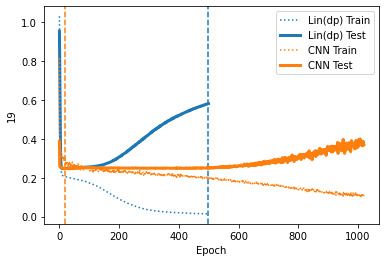

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2880, out_features=10, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [35]:
# make model
seq_len = len(train_df['upstream_region'].values[0])
mer8motif_model_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
mer8motif_model_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,10.0,10.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

# run model
mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn,\
estop = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn, 
    loss_func,
    lr=0.01,
    epochs=2500,
)

# to plot loss
mer8motif_cnn_data_label = [((mer8motif_train_losses_cnn,mer8motif_test_losses_cnn),'CNN',estop)]

tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label,estop)

mer8motif_model_cnn

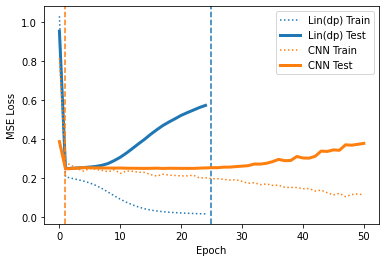

In [36]:
tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label,sparse_n=20)


Running LinearDeep


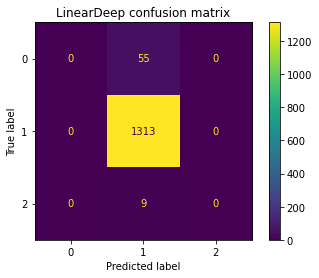

Running CNN


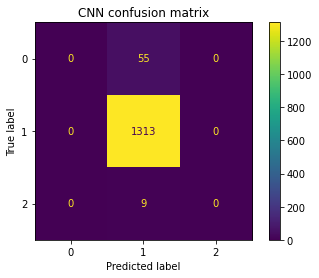

Running LinearDeep


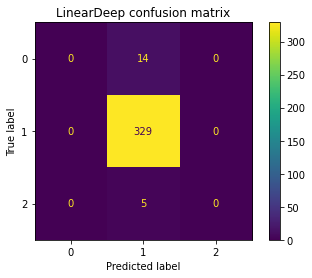

Running CNN


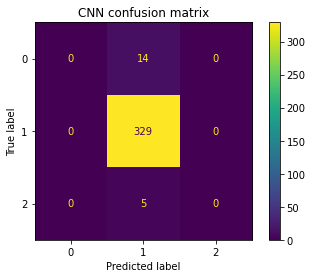

In [37]:
models = [
    ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


train_seqs =  train_df['locus_tag'].values #val_df['locus_tag'].values #
val_seqs =  val_df['locus_tag'].values #val_df['locus_tag'].values #
task = "6mer_motif_reg"

oracle_syn = dict([(a,[b]) for a,b in XYdf[['locus_tag','highCu_reg_UD']].values])


dfs_train = plot_confusion(models, train_seqs, oracle_syn,[task])
dfs_val = plot_confusion(models, val_seqs, oracle_syn,[task])

In [38]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,precision_recall_curve

def cls_report(df,model_name):
    '''Basic print out of precicion/recall/f1 scores'''
    
    acc = accuracy_score(df['truth'].values,df['pred'].values)
    print(f"{model_name} (acc={acc:.3f})")
    for a in ['micro','macro']:#,'weighted']:
        p = precision_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        r = recall_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        f1 = f1_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        print(f"{a}: p={p:.3f}\t r={r:.3f}\t f1={f1:.3f}")

def quick_classify(model, seqs,oracle):
    '''Given some sequences, get the model's predictions '''
    mis_classified = []
    for gene in seqs:
        dna = loc2seq[gene]
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        prob,cls = pred.topk(1)
        actual = oracle[gene][0]
        correct = (cls.item() == actual)
        if not correct:
            #print(f"{gene}: pred:{cls.item()} actual:{actual}")
            mis_classified.append(gene)
            print(f"{gene}: pred:{cls.item()} actual:{actual} ({pred.tolist()[0]})")

    print('done')
    return mis_classified
        

In [39]:
lind_res = dfs_val['LinearDeep'][1]
cnn_res = dfs_val['CNN'][1]

cls_report(lind_res,"LinearDeep")
print()
cls_report(cnn_res,"CNN")

LinearDeep (acc=0.945)
micro: p=0.945	 r=0.945	 f1=0.945
macro: p=0.315	 r=0.333	 f1=0.324

CNN (acc=0.945)
micro: p=0.945	 r=0.945	 f1=0.945
macro: p=0.315	 r=0.333	 f1=0.324


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
mis = quick_classify(mer8motif_model_cnn,val_seqs,oracle_syn)

EQU24_RS01895: pred:1 actual:0 ([-0.7960767149925232, 2.650484800338745, -1.6893763542175293])
EQU24_RS01940: pred:1 actual:0 ([-0.762789785861969, 2.553154230117798, -1.6186968088150024])
EQU24_RS04400: pred:1 actual:0 ([-0.7727301716804504, 2.6020472049713135, -1.663574457168579])
EQU24_RS10555: pred:1 actual:0 ([-0.7828880548477173, 2.634746551513672, -1.6775574684143066])
EQU24_RS10565: pred:1 actual:0 ([-0.8008055090904236, 2.6177282333374023, -1.6831341981887817])
EQU24_RS11840: pred:1 actual:0 ([-0.7560113072395325, 2.534128189086914, -1.5985326766967773])
EQU24_RS11870: pred:1 actual:0 ([-0.7678340077400208, 2.555464267730713, -1.6248232126235962])
EQU24_RS13085: pred:1 actual:0 ([-0.8015317320823669, 2.6469690799713135, -1.690592885017395])
EQU24_RS15800: pred:1 actual:0 ([-0.7766122817993164, 2.5812363624572754, -1.6354695558547974])
EQU24_RS16035: pred:1 actual:0 ([-0.7637396454811096, 2.572206974029541, -1.6516884565353394])
EQU24_RS18430: pred:1 actual:0 ([-0.7996608614921

## Rebalance sampler

In [41]:
from torch.utils.data.sampler import WeightedRandomSampler


In [42]:
def make_weighted_sampler(df, reg):
    '''
    Given a training dataframe, create a balanced sampler for the class
    indicated
    '''
    # make weighted sampler for data loader
    class_sample_count = df[reg].value_counts()
    # get 1/count as weight for each class
    weight = dict([(x,(1. / class_sample_count[x])) for x in class_sample_count.keys()])
    # apply new weight to each sample
    samples_weight = np.array([weight[t] for t in train_df[reg].values])
    samples_weight = torch.from_numpy(samples_weight).double()

    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [43]:
reg = "highCu_reg_UD"
sampler = make_weighted_sampler(train_df, reg)

In [44]:
# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col=reg,
    sampler=sampler,
    shuffle=False,
    #batch_size=32
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

In [45]:
print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)

(1725, 19)
(434, 20)
(1377, 21)
(348, 21)


In [46]:
train_df[reg].value_counts()

1    1313
0      55
2       9
Name: highCu_reg_UD, dtype: int64

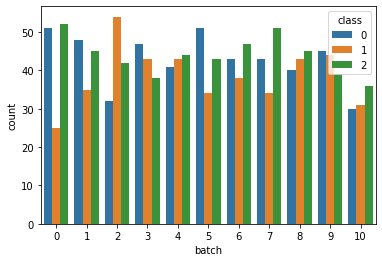

In [47]:
see_batch_class_dist(ohe_train_dl)
# the exact dist changes everytime

E:6 | train loss:1.085 | val loss: 1.159:   0%|          | 6/2500 [00:00<02:42, 15.35it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 1 out of 1000


E:13 | train loss:1.044 | val loss: 1.136:   0%|          | 12/2500 [00:00<02:16, 18.24it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:17 | train loss:1.008 | val loss: 1.151:   1%|          | 18/2500 [00:01<02:06, 19.59it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000


E:22 | train loss:0.966 | val loss: 1.023:   1%|          | 21/2500 [00:01<02:05, 19.77it/s]

EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 1 out of 1000


E:26 | train loss:0.913 | val loss: 1.073:   1%|          | 27/2500 [00:01<02:03, 19.95it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:30 | train loss:0.870 | val loss: 0.981:   1%|          | 31/2500 [00:01<02:05, 19.69it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 1 out of 1000


E:35 | train loss:0.819 | val loss: 1.001:   1%|▏         | 34/2500 [00:01<02:03, 19.90it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:42 | train loss:0.735 | val loss: 0.865:   2%|▏         | 40/2500 [00:02<02:01, 20.18it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:48 | train loss:0.694 | val loss: 0.896:   2%|▏         | 48/2500 [00:02<02:02, 20.10it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:52 | train loss:0.663 | val loss: 0.809:   2%|▏         | 51/2500 [00:02<02:01, 20.13it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:57 | train loss:0.623 | val loss: 0.813:   2%|▏         | 58/2500 [00:03<02:04, 19.69it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 1 out of 1000


E:62 | train loss:0.595 | val loss: 0.720:   3%|▎         | 63/2500 [00:03<02:01, 20.01it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:67 | train loss:0.591 | val loss: 0.660:   3%|▎         | 66/2500 [00:03<02:00, 20.13it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000


E:72 | train loss:0.565 | val loss: 0.664:   3%|▎         | 73/2500 [00:03<02:03, 19.65it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:77 | train loss:0.548 | val loss: 0.653:   3%|▎         | 76/2500 [00:04<02:02, 19.86it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000


E:82 | train loss:0.532 | val loss: 0.570:   3%|▎         | 82/2500 [00:04<02:00, 20.10it/s]

EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 1 out of 1000


E:87 | train loss:0.510 | val loss: 0.531:   4%|▎         | 88/2500 [00:04<01:59, 20.16it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:92 | train loss:0.490 | val loss: 0.570:   4%|▎         | 91/2500 [00:04<01:59, 20.11it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:97 | train loss:0.473 | val loss: 0.610:   4%|▍         | 97/2500 [00:04<01:58, 20.30it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:102 | train loss:0.480 | val loss: 0.650:   4%|▍         | 103/2500 [00:05<01:57, 20.36it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000


E:107 | train loss:0.461 | val loss: 0.742:   4%|▍         | 106/2500 [00:05<01:57, 20.30it/s]

EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:111 | train loss:0.437 | val loss: 0.604:   4%|▍         | 112/2500 [00:05<02:00, 19.74it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:115 | train loss:0.438 | val loss: 0.572:   5%|▍         | 116/2500 [00:05<02:01, 19.65it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:119 | train loss:0.451 | val loss: 0.597:   5%|▍         | 120/2500 [00:06<02:02, 19.43it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 1 out of 1000


E:124 | train loss:0.405 | val loss: 0.856:   5%|▌         | 125/2500 [00:06<02:00, 19.67it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 1 out of 1000


E:128 | train loss:0.392 | val loss: 0.528:   5%|▌         | 129/2500 [00:06<02:01, 19.55it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:132 | train loss:0.412 | val loss: 0.555:   5%|▌         | 133/2500 [00:06<02:01, 19.52it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:136 | train loss:0.394 | val loss: 0.541:   5%|▌         | 137/2500 [00:06<02:01, 19.50it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:141 | train loss:0.385 | val loss: 0.541:   6%|▌         | 142/2500 [00:07<01:58, 19.84it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000


E:146 | train loss:0.369 | val loss: 0.643:   6%|▌         | 145/2500 [00:07<01:57, 20.01it/s]

EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:151 | train loss:0.365 | val loss: 0.522:   6%|▌         | 152/2500 [00:07<01:59, 19.69it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:155 | train loss:0.345 | val loss: 0.594:   6%|▌         | 156/2500 [00:07<02:00, 19.39it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:160 | train loss:0.350 | val loss: 0.507:   6%|▋         | 159/2500 [00:08<01:58, 19.74it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:165 | train loss:0.348 | val loss: 0.530:   7%|▋         | 165/2500 [00:08<01:56, 20.11it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:170 | train loss:0.327 | val loss: 0.411:   7%|▋         | 171/2500 [00:08<01:56, 20.06it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:175 | train loss:0.323 | val loss: 0.533:   7%|▋         | 174/2500 [00:08<01:55, 20.18it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:178 | train loss:0.314 | val loss: 0.497:   7%|▋         | 177/2500 [00:09<01:54, 20.22it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 1 out of 1000


E:183 | train loss:0.311 | val loss: 0.467:   7%|▋         | 182/2500 [00:09<02:12, 17.46it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:186 | train loss:0.324 | val loss: 0.385:   7%|▋         | 186/2500 [00:09<02:06, 18.25it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:190 | train loss:0.327 | val loss: 0.487:   8%|▊         | 190/2500 [00:09<02:04, 18.61it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:194 | train loss:0.310 | val loss: 0.420:   8%|▊         | 195/2500 [00:09<01:59, 19.25it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:198 | train loss:0.280 | val loss: 0.418:   8%|▊         | 199/2500 [00:10<01:59, 19.28it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000


E:203 | train loss:0.295 | val loss: 0.441:   8%|▊         | 202/2500 [00:10<01:57, 19.57it/s]

EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:208 | train loss:0.323 | val loss: 0.412:   8%|▊         | 207/2500 [00:10<01:56, 19.74it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:212 | train loss:0.293 | val loss: 0.436:   9%|▊         | 213/2500 [00:10<01:54, 19.95it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000


E:217 | train loss:0.275 | val loss: 0.604:   9%|▊         | 217/2500 [00:11<01:54, 19.96it/s]

EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:222 | train loss:0.274 | val loss: 0.439:   9%|▉         | 223/2500 [00:11<01:54, 19.96it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:226 | train loss:0.297 | val loss: 0.371:   9%|▉         | 227/2500 [00:11<01:55, 19.65it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000


E:230 | train loss:0.286 | val loss: 0.378:   9%|▉         | 231/2500 [00:11<01:55, 19.59it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:235 | train loss:0.274 | val loss: 0.411:   9%|▉         | 234/2500 [00:12<01:54, 19.84it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:238 | train loss:0.259 | val loss: 0.379:  10%|▉         | 238/2500 [00:12<01:54, 19.69it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:243 | train loss:0.272 | val loss: 0.392:  10%|▉         | 243/2500 [00:12<01:53, 19.88it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:247 | train loss:0.253 | val loss: 0.377:  10%|▉         | 247/2500 [00:12<01:54, 19.71it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:251 | train loss:0.250 | val loss: 0.437:  10%|█         | 251/2500 [00:12<01:55, 19.40it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000


E:255 | train loss:0.248 | val loss: 0.393:  10%|█         | 255/2500 [00:13<01:56, 19.28it/s]

EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000


E:259 | train loss:0.257 | val loss: 0.370:  10%|█         | 260/2500 [00:13<01:55, 19.46it/s]

EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000


E:264 | train loss:0.251 | val loss: 0.395:  11%|█         | 265/2500 [00:13<01:53, 19.75it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:270 | train loss:0.245 | val loss: 0.390:  11%|█         | 269/2500 [00:13<01:52, 19.76it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:273 | train loss:0.264 | val loss: 0.380:  11%|█         | 274/2500 [00:14<01:55, 19.32it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:277 | train loss:0.270 | val loss: 0.443:  11%|█         | 278/2500 [00:14<01:55, 19.16it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:281 | train loss:0.256 | val loss: 0.418:  11%|█▏        | 282/2500 [00:14<01:56, 19.08it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 1 out of 1000


E:285 | train loss:0.233 | val loss: 0.422:  11%|█▏        | 286/2500 [00:14<01:55, 19.19it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:290 | train loss:0.251 | val loss: 0.424:  12%|█▏        | 291/2500 [00:14<01:52, 19.63it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:294 | train loss:0.248 | val loss: 0.408:  12%|█▏        | 295/2500 [00:15<01:52, 19.55it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:298 | train loss:0.219 | val loss: 0.368:  12%|█▏        | 298/2500 [00:15<01:51, 19.80it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:302 | train loss:0.243 | val loss: 0.421:  12%|█▏        | 302/2500 [00:15<01:53, 19.45it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:306 | train loss:0.244 | val loss: 0.475:  12%|█▏        | 306/2500 [00:15<01:52, 19.45it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000


E:310 | train loss:0.242 | val loss: 0.355:  12%|█▏        | 310/2500 [00:15<01:53, 19.32it/s]

EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000


E:314 | train loss:0.211 | val loss: 0.393:  13%|█▎        | 314/2500 [00:16<01:52, 19.37it/s]

EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000


E:318 | train loss:0.228 | val loss: 0.434:  13%|█▎        | 318/2500 [00:16<01:52, 19.43it/s]

EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000


E:322 | train loss:0.219 | val loss: 0.418:  13%|█▎        | 322/2500 [00:16<01:52, 19.41it/s]

EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000


E:327 | train loss:0.229 | val loss: 0.447:  13%|█▎        | 327/2500 [00:16<01:50, 19.72it/s]

EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000


E:330 | train loss:0.226 | val loss: 0.414:  13%|█▎        | 331/2500 [00:16<01:50, 19.57it/s]

EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000
EarlyStopping counter: 50 out of 1000


E:335 | train loss:0.213 | val loss: 0.392:  13%|█▎        | 336/2500 [00:17<01:49, 19.76it/s]

EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000
EarlyStopping counter: 53 out of 1000
EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000


E:340 | train loss:0.222 | val loss: 0.416:  14%|█▎        | 339/2500 [00:17<01:48, 19.88it/s]

EarlyStopping counter: 56 out of 1000
EarlyStopping counter: 57 out of 1000
EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000


E:343 | train loss:0.213 | val loss: 0.407:  14%|█▎        | 343/2500 [00:17<01:49, 19.69it/s]

EarlyStopping counter: 60 out of 1000
EarlyStopping counter: 61 out of 1000
EarlyStopping counter: 62 out of 1000
EarlyStopping counter: 63 out of 1000


E:348 | train loss:0.226 | val loss: 0.372:  14%|█▍        | 348/2500 [00:17<01:48, 19.87it/s]

EarlyStopping counter: 64 out of 1000
EarlyStopping counter: 65 out of 1000
EarlyStopping counter: 66 out of 1000
EarlyStopping counter: 67 out of 1000
EarlyStopping counter: 68 out of 1000


E:353 | train loss:0.200 | val loss: 0.389:  14%|█▍        | 353/2500 [00:18<01:47, 19.95it/s]

EarlyStopping counter: 69 out of 1000
EarlyStopping counter: 70 out of 1000
EarlyStopping counter: 71 out of 1000
EarlyStopping counter: 72 out of 1000
EarlyStopping counter: 73 out of 1000


E:357 | train loss:0.208 | val loss: 0.415:  14%|█▍        | 357/2500 [00:18<01:48, 19.80it/s]

EarlyStopping counter: 74 out of 1000
EarlyStopping counter: 75 out of 1000
EarlyStopping counter: 76 out of 1000
EarlyStopping counter: 77 out of 1000


E:361 | train loss:0.197 | val loss: 0.402:  14%|█▍        | 361/2500 [00:18<01:49, 19.45it/s]

EarlyStopping counter: 78 out of 1000
EarlyStopping counter: 79 out of 1000
EarlyStopping counter: 80 out of 1000
EarlyStopping counter: 81 out of 1000


E:365 | train loss:0.195 | val loss: 0.405:  15%|█▍        | 365/2500 [00:18<01:50, 19.29it/s]

EarlyStopping counter: 82 out of 1000
EarlyStopping counter: 83 out of 1000
EarlyStopping counter: 84 out of 1000
EarlyStopping counter: 85 out of 1000


E:369 | train loss:0.224 | val loss: 0.387:  15%|█▍        | 370/2500 [00:18<01:47, 19.72it/s]

EarlyStopping counter: 86 out of 1000
EarlyStopping counter: 87 out of 1000
EarlyStopping counter: 88 out of 1000
EarlyStopping counter: 89 out of 1000


E:373 | train loss:0.210 | val loss: 0.417:  15%|█▍        | 374/2500 [00:19<01:50, 19.30it/s]

EarlyStopping counter: 90 out of 1000
EarlyStopping counter: 91 out of 1000
EarlyStopping counter: 92 out of 1000
EarlyStopping counter: 93 out of 1000


E:378 | train loss:0.182 | val loss: 0.390:  15%|█▌        | 379/2500 [00:19<01:47, 19.67it/s]

EarlyStopping counter: 94 out of 1000
EarlyStopping counter: 95 out of 1000
EarlyStopping counter: 96 out of 1000
EarlyStopping counter: 97 out of 1000
EarlyStopping counter: 98 out of 1000


E:382 | train loss:0.212 | val loss: 0.385:  15%|█▌        | 382/2500 [00:19<01:46, 19.86it/s]

EarlyStopping counter: 99 out of 1000
EarlyStopping counter: 100 out of 1000
EarlyStopping counter: 101 out of 1000
EarlyStopping counter: 102 out of 1000


E:386 | train loss:0.219 | val loss: 0.403:  15%|█▌        | 386/2500 [00:19<01:48, 19.49it/s]

EarlyStopping counter: 103 out of 1000
EarlyStopping counter: 104 out of 1000
EarlyStopping counter: 105 out of 1000
EarlyStopping counter: 106 out of 1000


E:390 | train loss:0.195 | val loss: 0.377:  16%|█▌        | 390/2500 [00:20<01:50, 19.03it/s]

EarlyStopping counter: 107 out of 1000
EarlyStopping counter: 108 out of 1000
EarlyStopping counter: 109 out of 1000
EarlyStopping counter: 110 out of 1000


E:394 | train loss:0.186 | val loss: 0.393:  16%|█▌        | 394/2500 [00:20<01:52, 18.67it/s]

EarlyStopping counter: 111 out of 1000
EarlyStopping counter: 112 out of 1000
EarlyStopping counter: 113 out of 1000
EarlyStopping counter: 114 out of 1000


E:398 | train loss:0.198 | val loss: 0.382:  16%|█▌        | 398/2500 [00:20<01:53, 18.49it/s]

EarlyStopping counter: 115 out of 1000
EarlyStopping counter: 116 out of 1000
EarlyStopping counter: 117 out of 1000
EarlyStopping counter: 118 out of 1000


E:402 | train loss:0.190 | val loss: 0.448:  16%|█▌        | 402/2500 [00:20<01:51, 18.76it/s]

EarlyStopping counter: 119 out of 1000
EarlyStopping counter: 120 out of 1000
EarlyStopping counter: 121 out of 1000
EarlyStopping counter: 122 out of 1000


E:407 | train loss:0.202 | val loss: 0.382:  16%|█▋        | 407/2500 [00:20<01:47, 19.43it/s]

EarlyStopping counter: 123 out of 1000
EarlyStopping counter: 124 out of 1000
EarlyStopping counter: 125 out of 1000
EarlyStopping counter: 126 out of 1000
EarlyStopping counter: 127 out of 1000


E:411 | train loss:0.201 | val loss: 0.384:  16%|█▋        | 411/2500 [00:21<01:46, 19.53it/s]

EarlyStopping counter: 128 out of 1000
EarlyStopping counter: 129 out of 1000
EarlyStopping counter: 130 out of 1000
EarlyStopping counter: 131 out of 1000


E:415 | train loss:0.207 | val loss: 0.419:  17%|█▋        | 415/2500 [00:21<01:47, 19.42it/s]

EarlyStopping counter: 132 out of 1000
EarlyStopping counter: 133 out of 1000
EarlyStopping counter: 134 out of 1000
EarlyStopping counter: 135 out of 1000


E:419 | train loss:0.181 | val loss: 0.388:  17%|█▋        | 420/2500 [00:21<01:46, 19.50it/s]

EarlyStopping counter: 136 out of 1000
EarlyStopping counter: 137 out of 1000
EarlyStopping counter: 138 out of 1000
EarlyStopping counter: 139 out of 1000


E:424 | train loss:0.194 | val loss: 0.387:  17%|█▋        | 422/2500 [00:21<01:47, 19.42it/s]

EarlyStopping counter: 140 out of 1000
EarlyStopping counter: 141 out of 1000
EarlyStopping counter: 142 out of 1000
EarlyStopping counter: 143 out of 1000


E:429 | train loss:0.190 | val loss: 0.403:  17%|█▋        | 430/2500 [00:22<01:44, 19.89it/s]

EarlyStopping counter: 144 out of 1000
EarlyStopping counter: 145 out of 1000
EarlyStopping counter: 146 out of 1000
EarlyStopping counter: 147 out of 1000
EarlyStopping counter: 148 out of 1000
EarlyStopping counter: 149 out of 1000


E:433 | train loss:0.212 | val loss: 0.377:  17%|█▋        | 434/2500 [00:22<01:44, 19.69it/s]

EarlyStopping counter: 150 out of 1000
EarlyStopping counter: 151 out of 1000
EarlyStopping counter: 152 out of 1000
EarlyStopping counter: 153 out of 1000


E:437 | train loss:0.192 | val loss: 0.409:  18%|█▊        | 438/2500 [00:22<01:45, 19.47it/s]

EarlyStopping counter: 154 out of 1000
EarlyStopping counter: 155 out of 1000
EarlyStopping counter: 156 out of 1000
EarlyStopping counter: 157 out of 1000


E:441 | train loss:0.192 | val loss: 0.392:  18%|█▊        | 442/2500 [00:22<01:45, 19.48it/s]

EarlyStopping counter: 158 out of 1000
EarlyStopping counter: 159 out of 1000
EarlyStopping counter: 160 out of 1000
EarlyStopping counter: 161 out of 1000


E:445 | train loss:0.192 | val loss: 0.383:  18%|█▊        | 446/2500 [00:22<01:46, 19.26it/s]

EarlyStopping counter: 162 out of 1000
EarlyStopping counter: 163 out of 1000
EarlyStopping counter: 164 out of 1000
EarlyStopping counter: 165 out of 1000


E:450 | train loss:0.202 | val loss: 0.393:  18%|█▊        | 451/2500 [00:23<01:44, 19.67it/s]

EarlyStopping counter: 166 out of 1000
EarlyStopping counter: 167 out of 1000
EarlyStopping counter: 168 out of 1000
EarlyStopping counter: 169 out of 1000
EarlyStopping counter: 170 out of 1000


E:454 | train loss:0.170 | val loss: 0.401:  18%|█▊        | 455/2500 [00:23<01:44, 19.57it/s]

EarlyStopping counter: 171 out of 1000
EarlyStopping counter: 172 out of 1000
EarlyStopping counter: 173 out of 1000
EarlyStopping counter: 174 out of 1000


E:458 | train loss:0.191 | val loss: 0.416:  18%|█▊        | 459/2500 [00:23<01:44, 19.48it/s]

EarlyStopping counter: 175 out of 1000
EarlyStopping counter: 176 out of 1000
EarlyStopping counter: 177 out of 1000
EarlyStopping counter: 178 out of 1000


E:462 | train loss:0.187 | val loss: 0.396:  18%|█▊        | 461/2500 [00:23<01:45, 19.41it/s]

EarlyStopping counter: 179 out of 1000
EarlyStopping counter: 180 out of 1000
EarlyStopping counter: 181 out of 1000
EarlyStopping counter: 182 out of 1000


E:466 | train loss:0.200 | val loss: 0.375:  19%|█▊        | 466/2500 [00:23<01:44, 19.48it/s]

EarlyStopping counter: 183 out of 1000
EarlyStopping counter: 184 out of 1000
EarlyStopping counter: 185 out of 1000
EarlyStopping counter: 186 out of 1000


E:470 | train loss:0.161 | val loss: 0.433:  19%|█▉        | 470/2500 [00:24<01:44, 19.49it/s]

EarlyStopping counter: 187 out of 1000
EarlyStopping counter: 188 out of 1000
EarlyStopping counter: 189 out of 1000
EarlyStopping counter: 190 out of 1000


E:474 | train loss:0.177 | val loss: 0.411:  19%|█▉        | 474/2500 [00:24<01:43, 19.51it/s]

EarlyStopping counter: 191 out of 1000
EarlyStopping counter: 192 out of 1000
EarlyStopping counter: 193 out of 1000
EarlyStopping counter: 194 out of 1000


E:478 | train loss:0.174 | val loss: 0.381:  19%|█▉        | 478/2500 [00:24<01:45, 19.23it/s]

EarlyStopping counter: 195 out of 1000
EarlyStopping counter: 196 out of 1000
EarlyStopping counter: 197 out of 1000
EarlyStopping counter: 198 out of 1000


E:482 | train loss:0.150 | val loss: 0.422:  19%|█▉        | 482/2500 [00:24<01:45, 19.11it/s]

EarlyStopping counter: 199 out of 1000
EarlyStopping counter: 200 out of 1000
EarlyStopping counter: 201 out of 1000
EarlyStopping counter: 202 out of 1000


E:486 | train loss:0.191 | val loss: 0.381:  19%|█▉        | 486/2500 [00:24<01:45, 19.08it/s]

EarlyStopping counter: 203 out of 1000
EarlyStopping counter: 204 out of 1000
EarlyStopping counter: 205 out of 1000
EarlyStopping counter: 206 out of 1000


E:490 | train loss:0.185 | val loss: 0.398:  20%|█▉        | 490/2500 [00:25<01:45, 19.06it/s]

EarlyStopping counter: 207 out of 1000
EarlyStopping counter: 208 out of 1000
EarlyStopping counter: 209 out of 1000
EarlyStopping counter: 210 out of 1000


E:494 | train loss:0.182 | val loss: 0.411:  20%|█▉        | 494/2500 [00:25<01:45, 19.07it/s]

EarlyStopping counter: 211 out of 1000
EarlyStopping counter: 212 out of 1000
EarlyStopping counter: 213 out of 1000
EarlyStopping counter: 214 out of 1000


E:498 | train loss:0.187 | val loss: 0.406:  20%|█▉        | 498/2500 [00:25<01:45, 19.07it/s]

EarlyStopping counter: 215 out of 1000
EarlyStopping counter: 216 out of 1000
EarlyStopping counter: 217 out of 1000
EarlyStopping counter: 218 out of 1000


E:502 | train loss:0.179 | val loss: 0.414:  20%|██        | 502/2500 [00:25<01:44, 19.10it/s]

EarlyStopping counter: 219 out of 1000
EarlyStopping counter: 220 out of 1000
EarlyStopping counter: 221 out of 1000
EarlyStopping counter: 222 out of 1000


E:506 | train loss:0.179 | val loss: 0.388:  20%|██        | 506/2500 [00:26<01:44, 19.12it/s]

EarlyStopping counter: 223 out of 1000
EarlyStopping counter: 224 out of 1000
EarlyStopping counter: 225 out of 1000
EarlyStopping counter: 226 out of 1000


E:510 | train loss:0.175 | val loss: 0.420:  20%|██        | 510/2500 [00:26<01:43, 19.30it/s]

EarlyStopping counter: 227 out of 1000
EarlyStopping counter: 228 out of 1000
EarlyStopping counter: 229 out of 1000
EarlyStopping counter: 230 out of 1000


E:514 | train loss:0.177 | val loss: 0.431:  21%|██        | 514/2500 [00:26<01:43, 19.12it/s]

EarlyStopping counter: 231 out of 1000
EarlyStopping counter: 232 out of 1000
EarlyStopping counter: 233 out of 1000
EarlyStopping counter: 234 out of 1000


E:518 | train loss:0.172 | val loss: 0.416:  21%|██        | 518/2500 [00:26<01:43, 19.13it/s]

EarlyStopping counter: 235 out of 1000
EarlyStopping counter: 236 out of 1000
EarlyStopping counter: 237 out of 1000
EarlyStopping counter: 238 out of 1000


E:522 | train loss:0.166 | val loss: 0.403:  21%|██        | 522/2500 [00:26<01:43, 19.09it/s]

EarlyStopping counter: 239 out of 1000
EarlyStopping counter: 240 out of 1000
EarlyStopping counter: 241 out of 1000
EarlyStopping counter: 242 out of 1000


E:526 | train loss:0.181 | val loss: 0.414:  21%|██        | 526/2500 [00:27<01:43, 19.09it/s]

EarlyStopping counter: 243 out of 1000
EarlyStopping counter: 244 out of 1000
EarlyStopping counter: 245 out of 1000
EarlyStopping counter: 246 out of 1000


E:530 | train loss:0.176 | val loss: 0.386:  21%|██        | 530/2500 [00:27<01:43, 19.03it/s]

EarlyStopping counter: 247 out of 1000
EarlyStopping counter: 248 out of 1000
EarlyStopping counter: 249 out of 1000
EarlyStopping counter: 250 out of 1000


E:535 | train loss:0.199 | val loss: 0.418:  21%|██▏       | 535/2500 [00:27<01:40, 19.59it/s]

EarlyStopping counter: 251 out of 1000
EarlyStopping counter: 252 out of 1000
EarlyStopping counter: 253 out of 1000
EarlyStopping counter: 254 out of 1000
EarlyStopping counter: 255 out of 1000


E:539 | train loss:0.176 | val loss: 0.410:  22%|██▏       | 540/2500 [00:27<01:39, 19.79it/s]

EarlyStopping counter: 256 out of 1000
EarlyStopping counter: 257 out of 1000
EarlyStopping counter: 258 out of 1000
EarlyStopping counter: 259 out of 1000


E:543 | train loss:0.173 | val loss: 0.406:  22%|██▏       | 544/2500 [00:27<01:40, 19.48it/s]

EarlyStopping counter: 260 out of 1000
EarlyStopping counter: 261 out of 1000
EarlyStopping counter: 262 out of 1000
EarlyStopping counter: 263 out of 1000


E:547 | train loss:0.177 | val loss: 0.400:  22%|██▏       | 548/2500 [00:28<01:40, 19.33it/s]

EarlyStopping counter: 264 out of 1000
EarlyStopping counter: 265 out of 1000
EarlyStopping counter: 266 out of 1000
EarlyStopping counter: 267 out of 1000


E:551 | train loss:0.156 | val loss: 0.419:  22%|██▏       | 551/2500 [00:28<01:39, 19.62it/s]

EarlyStopping counter: 268 out of 1000
EarlyStopping counter: 269 out of 1000
EarlyStopping counter: 270 out of 1000
EarlyStopping counter: 271 out of 1000


E:556 | train loss:0.195 | val loss: 0.399:  22%|██▏       | 555/2500 [00:28<01:39, 19.58it/s]

EarlyStopping counter: 272 out of 1000
EarlyStopping counter: 273 out of 1000
EarlyStopping counter: 274 out of 1000
EarlyStopping counter: 275 out of 1000


E:560 | train loss:0.187 | val loss: 0.398:  22%|██▏       | 559/2500 [00:28<01:38, 19.74it/s]

EarlyStopping counter: 276 out of 1000
EarlyStopping counter: 277 out of 1000
EarlyStopping counter: 278 out of 1000
EarlyStopping counter: 279 out of 1000
EarlyStopping counter: 280 out of 1000


E:565 | train loss:0.177 | val loss: 0.425:  23%|██▎       | 565/2500 [00:29<01:37, 19.93it/s]

EarlyStopping counter: 281 out of 1000
EarlyStopping counter: 282 out of 1000
EarlyStopping counter: 283 out of 1000
EarlyStopping counter: 284 out of 1000
EarlyStopping counter: 285 out of 1000


E:570 | train loss:0.175 | val loss: 0.408:  23%|██▎       | 571/2500 [00:29<01:36, 19.96it/s]

EarlyStopping counter: 286 out of 1000
EarlyStopping counter: 287 out of 1000
EarlyStopping counter: 288 out of 1000
EarlyStopping counter: 289 out of 1000
EarlyStopping counter: 290 out of 1000


E:574 | train loss:0.169 | val loss: 0.420:  23%|██▎       | 573/2500 [00:29<01:36, 19.96it/s]

EarlyStopping counter: 291 out of 1000
EarlyStopping counter: 292 out of 1000
EarlyStopping counter: 293 out of 1000
EarlyStopping counter: 294 out of 1000


E:578 | train loss:0.177 | val loss: 0.401:  23%|██▎       | 578/2500 [00:29<01:39, 19.38it/s]

EarlyStopping counter: 295 out of 1000
EarlyStopping counter: 296 out of 1000
EarlyStopping counter: 297 out of 1000
EarlyStopping counter: 298 out of 1000


E:583 | train loss:0.163 | val loss: 0.420:  23%|██▎       | 583/2500 [00:29<01:38, 19.44it/s]

EarlyStopping counter: 299 out of 1000
EarlyStopping counter: 300 out of 1000
EarlyStopping counter: 301 out of 1000
EarlyStopping counter: 302 out of 1000
EarlyStopping counter: 303 out of 1000


E:588 | train loss:0.173 | val loss: 0.416:  23%|██▎       | 587/2500 [00:30<01:38, 19.50it/s]

EarlyStopping counter: 304 out of 1000
EarlyStopping counter: 305 out of 1000
EarlyStopping counter: 306 out of 1000
EarlyStopping counter: 307 out of 1000
EarlyStopping counter: 308 out of 1000


E:593 | train loss:0.178 | val loss: 0.404:  24%|██▎       | 593/2500 [00:30<01:35, 19.95it/s]

EarlyStopping counter: 309 out of 1000
EarlyStopping counter: 310 out of 1000
EarlyStopping counter: 311 out of 1000
EarlyStopping counter: 312 out of 1000
EarlyStopping counter: 313 out of 1000


E:597 | train loss:0.166 | val loss: 0.419:  24%|██▍       | 597/2500 [00:30<01:36, 19.74it/s]

EarlyStopping counter: 314 out of 1000
EarlyStopping counter: 315 out of 1000
EarlyStopping counter: 316 out of 1000
EarlyStopping counter: 317 out of 1000


E:601 | train loss:0.180 | val loss: 0.411:  24%|██▍       | 601/2500 [00:30<01:38, 19.25it/s]

EarlyStopping counter: 318 out of 1000
EarlyStopping counter: 319 out of 1000
EarlyStopping counter: 320 out of 1000
EarlyStopping counter: 321 out of 1000


E:605 | train loss:0.166 | val loss: 0.412:  24%|██▍       | 606/2500 [00:31<01:36, 19.59it/s]

EarlyStopping counter: 322 out of 1000
EarlyStopping counter: 323 out of 1000
EarlyStopping counter: 324 out of 1000
EarlyStopping counter: 325 out of 1000


E:609 | train loss:0.161 | val loss: 0.434:  24%|██▍       | 610/2500 [00:31<01:37, 19.30it/s]

EarlyStopping counter: 326 out of 1000
EarlyStopping counter: 327 out of 1000
EarlyStopping counter: 328 out of 1000
EarlyStopping counter: 329 out of 1000


E:613 | train loss:0.186 | val loss: 0.408:  25%|██▍       | 614/2500 [00:31<01:40, 18.85it/s]

EarlyStopping counter: 330 out of 1000
EarlyStopping counter: 331 out of 1000
EarlyStopping counter: 332 out of 1000
EarlyStopping counter: 333 out of 1000


E:617 | train loss:0.177 | val loss: 0.444:  25%|██▍       | 618/2500 [00:31<01:39, 18.87it/s]

EarlyStopping counter: 334 out of 1000
EarlyStopping counter: 335 out of 1000
EarlyStopping counter: 336 out of 1000
EarlyStopping counter: 337 out of 1000


E:621 | train loss:0.175 | val loss: 0.406:  25%|██▍       | 622/2500 [00:31<01:38, 19.04it/s]

EarlyStopping counter: 338 out of 1000
EarlyStopping counter: 339 out of 1000
EarlyStopping counter: 340 out of 1000
EarlyStopping counter: 341 out of 1000


E:625 | train loss:0.179 | val loss: 0.424:  25%|██▌       | 626/2500 [00:32<01:37, 19.12it/s]

EarlyStopping counter: 342 out of 1000
EarlyStopping counter: 343 out of 1000
EarlyStopping counter: 344 out of 1000
EarlyStopping counter: 345 out of 1000


E:629 | train loss:0.166 | val loss: 0.415:  25%|██▌       | 630/2500 [00:32<01:37, 19.13it/s]

EarlyStopping counter: 346 out of 1000
EarlyStopping counter: 347 out of 1000
EarlyStopping counter: 348 out of 1000
EarlyStopping counter: 349 out of 1000


E:633 | train loss:0.164 | val loss: 0.413:  25%|██▌       | 634/2500 [00:32<01:36, 19.34it/s]

EarlyStopping counter: 350 out of 1000
EarlyStopping counter: 351 out of 1000
EarlyStopping counter: 352 out of 1000
EarlyStopping counter: 353 out of 1000


E:637 | train loss:0.148 | val loss: 0.401:  26%|██▌       | 638/2500 [00:32<01:35, 19.44it/s]

EarlyStopping counter: 354 out of 1000
EarlyStopping counter: 355 out of 1000
EarlyStopping counter: 356 out of 1000
EarlyStopping counter: 357 out of 1000


E:641 | train loss:0.187 | val loss: 0.414:  26%|██▌       | 642/2500 [00:32<01:35, 19.45it/s]

EarlyStopping counter: 358 out of 1000
EarlyStopping counter: 359 out of 1000
EarlyStopping counter: 360 out of 1000
EarlyStopping counter: 361 out of 1000


E:645 | train loss:0.161 | val loss: 0.427:  26%|██▌       | 646/2500 [00:33<01:38, 18.87it/s]

EarlyStopping counter: 362 out of 1000
EarlyStopping counter: 363 out of 1000
EarlyStopping counter: 364 out of 1000
EarlyStopping counter: 365 out of 1000


E:649 | train loss:0.174 | val loss: 0.414:  26%|██▌       | 650/2500 [00:33<01:37, 19.00it/s]

EarlyStopping counter: 366 out of 1000
EarlyStopping counter: 367 out of 1000
EarlyStopping counter: 368 out of 1000
EarlyStopping counter: 369 out of 1000


E:653 | train loss:0.160 | val loss: 0.416:  26%|██▌       | 654/2500 [00:33<01:36, 19.05it/s]

EarlyStopping counter: 370 out of 1000
EarlyStopping counter: 371 out of 1000
EarlyStopping counter: 372 out of 1000
EarlyStopping counter: 373 out of 1000


E:657 | train loss:0.176 | val loss: 0.420:  26%|██▋       | 658/2500 [00:33<01:36, 19.06it/s]

EarlyStopping counter: 374 out of 1000
EarlyStopping counter: 375 out of 1000
EarlyStopping counter: 376 out of 1000
EarlyStopping counter: 377 out of 1000


E:661 | train loss:0.176 | val loss: 0.424:  26%|██▋       | 662/2500 [00:34<01:36, 19.09it/s]

EarlyStopping counter: 378 out of 1000
EarlyStopping counter: 379 out of 1000
EarlyStopping counter: 380 out of 1000
EarlyStopping counter: 381 out of 1000


E:665 | train loss:0.150 | val loss: 0.417:  27%|██▋       | 666/2500 [00:34<01:36, 19.10it/s]

EarlyStopping counter: 382 out of 1000
EarlyStopping counter: 383 out of 1000
EarlyStopping counter: 384 out of 1000
EarlyStopping counter: 385 out of 1000


E:669 | train loss:0.141 | val loss: 0.424:  27%|██▋       | 670/2500 [00:34<01:34, 19.31it/s]

EarlyStopping counter: 386 out of 1000
EarlyStopping counter: 387 out of 1000
EarlyStopping counter: 388 out of 1000
EarlyStopping counter: 389 out of 1000


E:673 | train loss:0.164 | val loss: 0.415:  27%|██▋       | 674/2500 [00:34<01:35, 19.20it/s]

EarlyStopping counter: 390 out of 1000
EarlyStopping counter: 391 out of 1000
EarlyStopping counter: 392 out of 1000
EarlyStopping counter: 393 out of 1000


E:678 | train loss:0.168 | val loss: 0.422:  27%|██▋       | 677/2500 [00:34<01:33, 19.56it/s]

EarlyStopping counter: 394 out of 1000
EarlyStopping counter: 395 out of 1000
EarlyStopping counter: 396 out of 1000
EarlyStopping counter: 397 out of 1000
EarlyStopping counter: 398 out of 1000


E:682 | train loss:0.159 | val loss: 0.436:  27%|██▋       | 682/2500 [00:35<01:32, 19.68it/s]

EarlyStopping counter: 399 out of 1000
EarlyStopping counter: 400 out of 1000
EarlyStopping counter: 401 out of 1000
EarlyStopping counter: 402 out of 1000


E:686 | train loss:0.177 | val loss: 0.433:  27%|██▋       | 686/2500 [00:35<01:33, 19.44it/s]

EarlyStopping counter: 403 out of 1000
EarlyStopping counter: 404 out of 1000
EarlyStopping counter: 405 out of 1000
EarlyStopping counter: 406 out of 1000


E:690 | train loss:0.158 | val loss: 0.415:  28%|██▊       | 690/2500 [00:35<01:33, 19.28it/s]

EarlyStopping counter: 407 out of 1000
EarlyStopping counter: 408 out of 1000
EarlyStopping counter: 409 out of 1000
EarlyStopping counter: 410 out of 1000


E:694 | train loss:0.156 | val loss: 0.439:  28%|██▊       | 694/2500 [00:35<01:33, 19.23it/s]

EarlyStopping counter: 411 out of 1000
EarlyStopping counter: 412 out of 1000
EarlyStopping counter: 413 out of 1000
EarlyStopping counter: 414 out of 1000


E:698 | train loss:0.179 | val loss: 0.417:  28%|██▊       | 698/2500 [00:35<01:33, 19.26it/s]

EarlyStopping counter: 415 out of 1000
EarlyStopping counter: 416 out of 1000
EarlyStopping counter: 417 out of 1000
EarlyStopping counter: 418 out of 1000


E:702 | train loss:0.157 | val loss: 0.436:  28%|██▊       | 702/2500 [00:36<01:33, 19.22it/s]

EarlyStopping counter: 419 out of 1000
EarlyStopping counter: 420 out of 1000
EarlyStopping counter: 421 out of 1000
EarlyStopping counter: 422 out of 1000


E:707 | train loss:0.157 | val loss: 0.417:  28%|██▊       | 706/2500 [00:36<01:32, 19.35it/s]

EarlyStopping counter: 423 out of 1000
EarlyStopping counter: 424 out of 1000
EarlyStopping counter: 425 out of 1000
EarlyStopping counter: 426 out of 1000


E:710 | train loss:0.159 | val loss: 0.419:  28%|██▊       | 711/2500 [00:36<01:30, 19.71it/s]

EarlyStopping counter: 427 out of 1000
EarlyStopping counter: 428 out of 1000
EarlyStopping counter: 429 out of 1000
EarlyStopping counter: 430 out of 1000


E:714 | train loss:0.186 | val loss: 0.418:  29%|██▊       | 715/2500 [00:36<01:31, 19.58it/s]

EarlyStopping counter: 431 out of 1000
EarlyStopping counter: 432 out of 1000
EarlyStopping counter: 433 out of 1000
EarlyStopping counter: 434 out of 1000


E:718 | train loss:0.168 | val loss: 0.414:  29%|██▊       | 717/2500 [00:36<01:32, 19.20it/s]

EarlyStopping counter: 435 out of 1000
EarlyStopping counter: 436 out of 1000
EarlyStopping counter: 437 out of 1000
EarlyStopping counter: 438 out of 1000


E:722 | train loss:0.139 | val loss: 0.414:  29%|██▉       | 722/2500 [00:37<01:31, 19.40it/s]

EarlyStopping counter: 439 out of 1000
EarlyStopping counter: 440 out of 1000
EarlyStopping counter: 441 out of 1000
EarlyStopping counter: 442 out of 1000


E:726 | train loss:0.177 | val loss: 0.422:  29%|██▉       | 726/2500 [00:37<01:31, 19.29it/s]

EarlyStopping counter: 443 out of 1000
EarlyStopping counter: 444 out of 1000
EarlyStopping counter: 445 out of 1000
EarlyStopping counter: 446 out of 1000


E:730 | train loss:0.169 | val loss: 0.427:  29%|██▉       | 730/2500 [00:37<01:32, 19.17it/s]

EarlyStopping counter: 447 out of 1000
EarlyStopping counter: 448 out of 1000
EarlyStopping counter: 449 out of 1000
EarlyStopping counter: 450 out of 1000


E:734 | train loss:0.166 | val loss: 0.425:  29%|██▉       | 735/2500 [00:37<01:30, 19.44it/s]

EarlyStopping counter: 451 out of 1000
EarlyStopping counter: 452 out of 1000
EarlyStopping counter: 453 out of 1000
EarlyStopping counter: 454 out of 1000


E:738 | train loss:0.160 | val loss: 0.426:  30%|██▉       | 738/2500 [00:37<01:29, 19.62it/s]

EarlyStopping counter: 455 out of 1000
EarlyStopping counter: 456 out of 1000
EarlyStopping counter: 457 out of 1000
EarlyStopping counter: 458 out of 1000


E:742 | train loss:0.178 | val loss: 0.423:  30%|██▉       | 742/2500 [00:38<01:29, 19.71it/s]

EarlyStopping counter: 459 out of 1000
EarlyStopping counter: 460 out of 1000
EarlyStopping counter: 461 out of 1000
EarlyStopping counter: 462 out of 1000


E:746 | train loss:0.158 | val loss: 0.423:  30%|██▉       | 746/2500 [00:38<01:30, 19.40it/s]

EarlyStopping counter: 463 out of 1000
EarlyStopping counter: 464 out of 1000
EarlyStopping counter: 465 out of 1000
EarlyStopping counter: 466 out of 1000


E:750 | train loss:0.148 | val loss: 0.430:  30%|███       | 750/2500 [00:38<01:31, 19.14it/s]

EarlyStopping counter: 467 out of 1000
EarlyStopping counter: 468 out of 1000
EarlyStopping counter: 469 out of 1000
EarlyStopping counter: 470 out of 1000


E:754 | train loss:0.159 | val loss: 0.433:  30%|███       | 754/2500 [00:38<01:31, 19.15it/s]

EarlyStopping counter: 471 out of 1000
EarlyStopping counter: 472 out of 1000
EarlyStopping counter: 473 out of 1000
EarlyStopping counter: 474 out of 1000


E:759 | train loss:0.158 | val loss: 0.423:  30%|███       | 759/2500 [00:39<01:28, 19.71it/s]

EarlyStopping counter: 475 out of 1000
EarlyStopping counter: 476 out of 1000
EarlyStopping counter: 477 out of 1000
EarlyStopping counter: 478 out of 1000
EarlyStopping counter: 479 out of 1000


E:763 | train loss:0.152 | val loss: 0.424:  31%|███       | 764/2500 [00:39<01:27, 19.73it/s]

EarlyStopping counter: 480 out of 1000
EarlyStopping counter: 481 out of 1000
EarlyStopping counter: 482 out of 1000
EarlyStopping counter: 483 out of 1000


E:767 | train loss:0.163 | val loss: 0.435:  31%|███       | 768/2500 [00:39<01:30, 19.04it/s]

EarlyStopping counter: 484 out of 1000
EarlyStopping counter: 485 out of 1000
EarlyStopping counter: 486 out of 1000
EarlyStopping counter: 487 out of 1000


E:771 | train loss:0.170 | val loss: 0.419:  31%|███       | 772/2500 [00:39<01:29, 19.26it/s]

EarlyStopping counter: 488 out of 1000
EarlyStopping counter: 489 out of 1000
EarlyStopping counter: 490 out of 1000
EarlyStopping counter: 491 out of 1000


E:776 | train loss:0.167 | val loss: 0.422:  31%|███       | 777/2500 [00:39<01:28, 19.56it/s]

EarlyStopping counter: 492 out of 1000
EarlyStopping counter: 493 out of 1000
EarlyStopping counter: 494 out of 1000
EarlyStopping counter: 495 out of 1000
EarlyStopping counter: 496 out of 1000


E:781 | train loss:0.158 | val loss: 0.429:  31%|███       | 779/2500 [00:40<01:28, 19.45it/s]

EarlyStopping counter: 497 out of 1000
EarlyStopping counter: 498 out of 1000
EarlyStopping counter: 499 out of 1000
EarlyStopping counter: 500 out of 1000
EarlyStopping counter: 501 out of 1000


E:784 | train loss:0.154 | val loss: 0.435:  31%|███▏      | 784/2500 [00:40<01:27, 19.57it/s]

EarlyStopping counter: 502 out of 1000
EarlyStopping counter: 503 out of 1000
EarlyStopping counter: 504 out of 1000


E:788 | train loss:0.167 | val loss: 0.445:  32%|███▏      | 789/2500 [00:40<01:27, 19.64it/s]

EarlyStopping counter: 505 out of 1000
EarlyStopping counter: 506 out of 1000
EarlyStopping counter: 507 out of 1000
EarlyStopping counter: 508 out of 1000


E:792 | train loss:0.162 | val loss: 0.433:  32%|███▏      | 793/2500 [00:40<01:28, 19.35it/s]

EarlyStopping counter: 509 out of 1000
EarlyStopping counter: 510 out of 1000
EarlyStopping counter: 511 out of 1000
EarlyStopping counter: 512 out of 1000


E:796 | train loss:0.147 | val loss: 0.446:  32%|███▏      | 796/2500 [00:40<01:26, 19.69it/s]

EarlyStopping counter: 513 out of 1000
EarlyStopping counter: 514 out of 1000
EarlyStopping counter: 515 out of 1000
EarlyStopping counter: 516 out of 1000


E:800 | train loss:0.155 | val loss: 0.435:  32%|███▏      | 800/2500 [00:41<01:27, 19.44it/s]

EarlyStopping counter: 517 out of 1000
EarlyStopping counter: 518 out of 1000
EarlyStopping counter: 519 out of 1000
EarlyStopping counter: 520 out of 1000


E:804 | train loss:0.154 | val loss: 0.433:  32%|███▏      | 804/2500 [00:41<01:27, 19.31it/s]

EarlyStopping counter: 521 out of 1000
EarlyStopping counter: 522 out of 1000
EarlyStopping counter: 523 out of 1000
EarlyStopping counter: 524 out of 1000


E:808 | train loss:0.131 | val loss: 0.442:  32%|███▏      | 808/2500 [00:41<01:28, 19.02it/s]

EarlyStopping counter: 525 out of 1000
EarlyStopping counter: 526 out of 1000
EarlyStopping counter: 527 out of 1000
EarlyStopping counter: 528 out of 1000


E:812 | train loss:0.146 | val loss: 0.431:  32%|███▏      | 812/2500 [00:41<01:30, 18.70it/s]

EarlyStopping counter: 529 out of 1000
EarlyStopping counter: 530 out of 1000
EarlyStopping counter: 531 out of 1000
EarlyStopping counter: 532 out of 1000


E:816 | train loss:0.163 | val loss: 0.443:  33%|███▎      | 816/2500 [00:42<01:30, 18.54it/s]

EarlyStopping counter: 533 out of 1000
EarlyStopping counter: 534 out of 1000
EarlyStopping counter: 535 out of 1000
EarlyStopping counter: 536 out of 1000


E:820 | train loss:0.160 | val loss: 0.436:  33%|███▎      | 820/2500 [00:42<01:29, 18.78it/s]

EarlyStopping counter: 537 out of 1000
EarlyStopping counter: 538 out of 1000
EarlyStopping counter: 539 out of 1000
EarlyStopping counter: 540 out of 1000


E:824 | train loss:0.157 | val loss: 0.433:  33%|███▎      | 824/2500 [00:42<01:26, 19.29it/s]

EarlyStopping counter: 541 out of 1000
EarlyStopping counter: 542 out of 1000
EarlyStopping counter: 543 out of 1000
EarlyStopping counter: 544 out of 1000


E:828 | train loss:0.146 | val loss: 0.462:  33%|███▎      | 828/2500 [00:42<01:28, 18.82it/s]

EarlyStopping counter: 545 out of 1000
EarlyStopping counter: 546 out of 1000
EarlyStopping counter: 547 out of 1000
EarlyStopping counter: 548 out of 1000


E:832 | train loss:0.155 | val loss: 0.438:  33%|███▎      | 832/2500 [00:42<01:28, 18.85it/s]

EarlyStopping counter: 549 out of 1000
EarlyStopping counter: 550 out of 1000
EarlyStopping counter: 551 out of 1000
EarlyStopping counter: 552 out of 1000


E:836 | train loss:0.152 | val loss: 0.442:  33%|███▎      | 836/2500 [00:43<01:27, 19.03it/s]

EarlyStopping counter: 553 out of 1000
EarlyStopping counter: 554 out of 1000
EarlyStopping counter: 555 out of 1000
EarlyStopping counter: 556 out of 1000


E:840 | train loss:0.186 | val loss: 0.436:  34%|███▎      | 840/2500 [00:43<01:27, 18.99it/s]

EarlyStopping counter: 557 out of 1000
EarlyStopping counter: 558 out of 1000
EarlyStopping counter: 559 out of 1000
EarlyStopping counter: 560 out of 1000


E:844 | train loss:0.151 | val loss: 0.449:  34%|███▍      | 844/2500 [00:43<01:27, 18.87it/s]

EarlyStopping counter: 561 out of 1000
EarlyStopping counter: 562 out of 1000
EarlyStopping counter: 563 out of 1000
EarlyStopping counter: 564 out of 1000


E:848 | train loss:0.152 | val loss: 0.447:  34%|███▍      | 848/2500 [00:43<01:25, 19.25it/s]

EarlyStopping counter: 565 out of 1000
EarlyStopping counter: 566 out of 1000
EarlyStopping counter: 567 out of 1000
EarlyStopping counter: 568 out of 1000


E:852 | train loss:0.144 | val loss: 0.450:  34%|███▍      | 852/2500 [00:43<01:25, 19.30it/s]

EarlyStopping counter: 569 out of 1000
EarlyStopping counter: 570 out of 1000
EarlyStopping counter: 571 out of 1000
EarlyStopping counter: 572 out of 1000


E:856 | train loss:0.147 | val loss: 0.440:  34%|███▍      | 856/2500 [00:44<01:27, 18.83it/s]

EarlyStopping counter: 573 out of 1000
EarlyStopping counter: 574 out of 1000
EarlyStopping counter: 575 out of 1000
EarlyStopping counter: 576 out of 1000


E:860 | train loss:0.153 | val loss: 0.445:  34%|███▍      | 860/2500 [00:44<01:28, 18.60it/s]

EarlyStopping counter: 577 out of 1000
EarlyStopping counter: 578 out of 1000
EarlyStopping counter: 579 out of 1000
EarlyStopping counter: 580 out of 1000


E:864 | train loss:0.155 | val loss: 0.456:  35%|███▍      | 865/2500 [00:44<01:24, 19.37it/s]

EarlyStopping counter: 581 out of 1000
EarlyStopping counter: 582 out of 1000
EarlyStopping counter: 583 out of 1000
EarlyStopping counter: 584 out of 1000


E:869 | train loss:0.159 | val loss: 0.451:  35%|███▍      | 870/2500 [00:44<01:23, 19.52it/s]

EarlyStopping counter: 585 out of 1000
EarlyStopping counter: 586 out of 1000
EarlyStopping counter: 587 out of 1000
EarlyStopping counter: 588 out of 1000
EarlyStopping counter: 589 out of 1000


E:873 | train loss:0.169 | val loss: 0.435:  35%|███▍      | 874/2500 [00:45<01:24, 19.27it/s]

EarlyStopping counter: 590 out of 1000
EarlyStopping counter: 591 out of 1000
EarlyStopping counter: 592 out of 1000
EarlyStopping counter: 593 out of 1000


E:877 | train loss:0.171 | val loss: 0.440:  35%|███▌      | 878/2500 [00:45<01:26, 18.77it/s]

EarlyStopping counter: 594 out of 1000
EarlyStopping counter: 595 out of 1000
EarlyStopping counter: 596 out of 1000
EarlyStopping counter: 597 out of 1000


E:881 | train loss:0.154 | val loss: 0.443:  35%|███▌      | 882/2500 [00:45<01:25, 18.91it/s]

EarlyStopping counter: 598 out of 1000
EarlyStopping counter: 599 out of 1000
EarlyStopping counter: 600 out of 1000
EarlyStopping counter: 601 out of 1000


E:886 | train loss:0.158 | val loss: 0.454:  35%|███▌      | 887/2500 [00:45<01:22, 19.52it/s]

EarlyStopping counter: 602 out of 1000
EarlyStopping counter: 603 out of 1000
EarlyStopping counter: 604 out of 1000
EarlyStopping counter: 605 out of 1000
EarlyStopping counter: 606 out of 1000


E:889 | train loss:0.146 | val loss: 0.454:  36%|███▌      | 889/2500 [00:45<01:38, 16.43it/s]

EarlyStopping counter: 607 out of 1000
EarlyStopping counter: 608 out of 1000
EarlyStopping counter: 609 out of 1000


E:893 | train loss:0.154 | val loss: 0.444:  36%|███▌      | 894/2500 [00:46<01:29, 17.99it/s]

EarlyStopping counter: 610 out of 1000
EarlyStopping counter: 611 out of 1000
EarlyStopping counter: 612 out of 1000
EarlyStopping counter: 613 out of 1000


E:898 | train loss:0.154 | val loss: 0.461:  36%|███▌      | 896/2500 [00:46<01:27, 18.25it/s]

EarlyStopping counter: 614 out of 1000
EarlyStopping counter: 615 out of 1000
EarlyStopping counter: 616 out of 1000
EarlyStopping counter: 617 out of 1000


E:901 | train loss:0.170 | val loss: 0.433:  36%|███▌      | 901/2500 [00:46<01:24, 18.98it/s]

EarlyStopping counter: 618 out of 1000
EarlyStopping counter: 619 out of 1000
EarlyStopping counter: 620 out of 1000
EarlyStopping counter: 621 out of 1000


E:905 | train loss:0.145 | val loss: 0.441:  36%|███▌      | 905/2500 [00:46<01:22, 19.25it/s]

EarlyStopping counter: 622 out of 1000
EarlyStopping counter: 623 out of 1000
EarlyStopping counter: 624 out of 1000
EarlyStopping counter: 625 out of 1000


E:910 | train loss:0.156 | val loss: 0.438:  36%|███▋      | 911/2500 [00:46<01:20, 19.78it/s]

EarlyStopping counter: 626 out of 1000
EarlyStopping counter: 627 out of 1000
EarlyStopping counter: 628 out of 1000
EarlyStopping counter: 629 out of 1000
EarlyStopping counter: 630 out of 1000


E:915 | train loss:0.155 | val loss: 0.453:  37%|███▋      | 915/2500 [00:47<01:19, 19.82it/s]

EarlyStopping counter: 631 out of 1000
EarlyStopping counter: 632 out of 1000
EarlyStopping counter: 633 out of 1000
EarlyStopping counter: 634 out of 1000


E:918 | train loss:0.160 | val loss: 0.452:  37%|███▋      | 919/2500 [00:47<01:21, 19.37it/s]

EarlyStopping counter: 635 out of 1000
EarlyStopping counter: 636 out of 1000
EarlyStopping counter: 637 out of 1000
EarlyStopping counter: 638 out of 1000


E:922 | train loss:0.159 | val loss: 0.439:  37%|███▋      | 923/2500 [00:47<01:22, 19.21it/s]

EarlyStopping counter: 639 out of 1000
EarlyStopping counter: 640 out of 1000
EarlyStopping counter: 641 out of 1000
EarlyStopping counter: 642 out of 1000


E:926 | train loss:0.165 | val loss: 0.455:  37%|███▋      | 927/2500 [00:47<01:22, 19.08it/s]

EarlyStopping counter: 643 out of 1000
EarlyStopping counter: 644 out of 1000
EarlyStopping counter: 645 out of 1000
EarlyStopping counter: 646 out of 1000


E:930 | train loss:0.145 | val loss: 0.456:  37%|███▋      | 931/2500 [00:48<01:21, 19.33it/s]

EarlyStopping counter: 647 out of 1000
EarlyStopping counter: 648 out of 1000
EarlyStopping counter: 649 out of 1000
EarlyStopping counter: 650 out of 1000


E:934 | train loss:0.138 | val loss: 0.443:  37%|███▋      | 935/2500 [00:48<01:21, 19.18it/s]

EarlyStopping counter: 651 out of 1000
EarlyStopping counter: 652 out of 1000
EarlyStopping counter: 653 out of 1000
EarlyStopping counter: 654 out of 1000


E:938 | train loss:0.146 | val loss: 0.475:  38%|███▊      | 939/2500 [00:48<01:21, 19.10it/s]

EarlyStopping counter: 655 out of 1000
EarlyStopping counter: 656 out of 1000
EarlyStopping counter: 657 out of 1000
EarlyStopping counter: 658 out of 1000


E:942 | train loss:0.153 | val loss: 0.439:  38%|███▊      | 943/2500 [00:48<01:20, 19.23it/s]

EarlyStopping counter: 659 out of 1000
EarlyStopping counter: 660 out of 1000
EarlyStopping counter: 661 out of 1000
EarlyStopping counter: 662 out of 1000


E:947 | train loss:0.175 | val loss: 0.445:  38%|███▊      | 947/2500 [00:48<01:19, 19.59it/s]

EarlyStopping counter: 663 out of 1000
EarlyStopping counter: 664 out of 1000
EarlyStopping counter: 665 out of 1000
EarlyStopping counter: 666 out of 1000
EarlyStopping counter: 667 out of 1000


E:951 | train loss:0.171 | val loss: 0.443:  38%|███▊      | 951/2500 [00:49<01:18, 19.64it/s]

EarlyStopping counter: 668 out of 1000
EarlyStopping counter: 669 out of 1000
EarlyStopping counter: 670 out of 1000
EarlyStopping counter: 671 out of 1000


E:955 | train loss:0.148 | val loss: 0.459:  38%|███▊      | 955/2500 [00:49<01:18, 19.66it/s]

EarlyStopping counter: 672 out of 1000
EarlyStopping counter: 673 out of 1000
EarlyStopping counter: 674 out of 1000
EarlyStopping counter: 675 out of 1000


E:959 | train loss:0.158 | val loss: 0.450:  38%|███▊      | 960/2500 [00:49<01:18, 19.73it/s]

EarlyStopping counter: 676 out of 1000
EarlyStopping counter: 677 out of 1000
EarlyStopping counter: 678 out of 1000
EarlyStopping counter: 679 out of 1000


E:963 | train loss:0.166 | val loss: 0.458:  39%|███▊      | 964/2500 [00:49<01:19, 19.42it/s]

EarlyStopping counter: 680 out of 1000
EarlyStopping counter: 681 out of 1000
EarlyStopping counter: 682 out of 1000
EarlyStopping counter: 683 out of 1000


E:967 | train loss:0.142 | val loss: 0.466:  39%|███▊      | 968/2500 [00:49<01:18, 19.40it/s]

EarlyStopping counter: 684 out of 1000
EarlyStopping counter: 685 out of 1000
EarlyStopping counter: 686 out of 1000
EarlyStopping counter: 687 out of 1000


E:971 | train loss:0.138 | val loss: 0.453:  39%|███▉      | 972/2500 [00:50<01:17, 19.67it/s]

EarlyStopping counter: 688 out of 1000
EarlyStopping counter: 689 out of 1000
EarlyStopping counter: 690 out of 1000
EarlyStopping counter: 691 out of 1000


E:975 | train loss:0.157 | val loss: 0.449:  39%|███▉      | 976/2500 [00:50<01:19, 19.27it/s]

EarlyStopping counter: 692 out of 1000
EarlyStopping counter: 693 out of 1000
EarlyStopping counter: 694 out of 1000
EarlyStopping counter: 695 out of 1000


E:979 | train loss:0.137 | val loss: 0.465:  39%|███▉      | 980/2500 [00:50<01:18, 19.31it/s]

EarlyStopping counter: 696 out of 1000
EarlyStopping counter: 697 out of 1000
EarlyStopping counter: 698 out of 1000
EarlyStopping counter: 699 out of 1000


E:983 | train loss:0.145 | val loss: 0.471:  39%|███▉      | 984/2500 [00:50<01:19, 19.17it/s]

EarlyStopping counter: 700 out of 1000
EarlyStopping counter: 701 out of 1000
EarlyStopping counter: 702 out of 1000
EarlyStopping counter: 703 out of 1000


E:987 | train loss:0.146 | val loss: 0.451:  40%|███▉      | 988/2500 [00:50<01:18, 19.28it/s]

EarlyStopping counter: 704 out of 1000
EarlyStopping counter: 705 out of 1000
EarlyStopping counter: 706 out of 1000
EarlyStopping counter: 707 out of 1000


E:991 | train loss:0.151 | val loss: 0.452:  40%|███▉      | 992/2500 [00:51<01:19, 18.94it/s]

EarlyStopping counter: 708 out of 1000
EarlyStopping counter: 709 out of 1000
EarlyStopping counter: 710 out of 1000
EarlyStopping counter: 711 out of 1000


E:995 | train loss:0.140 | val loss: 0.456:  40%|███▉      | 996/2500 [00:51<01:19, 18.99it/s]

EarlyStopping counter: 712 out of 1000
EarlyStopping counter: 713 out of 1000
EarlyStopping counter: 714 out of 1000
EarlyStopping counter: 715 out of 1000


E:999 | train loss:0.154 | val loss: 0.452:  40%|████      | 1000/2500 [00:51<01:18, 19.03it/s]

EarlyStopping counter: 716 out of 1000
EarlyStopping counter: 717 out of 1000
EarlyStopping counter: 718 out of 1000
EarlyStopping counter: 719 out of 1000


E:1003 | train loss:0.147 | val loss: 0.451:  40%|████      | 1004/2500 [00:51<01:20, 18.67it/s]

EarlyStopping counter: 720 out of 1000
EarlyStopping counter: 721 out of 1000
EarlyStopping counter: 722 out of 1000
EarlyStopping counter: 723 out of 1000


E:1007 | train loss:0.162 | val loss: 0.453:  40%|████      | 1008/2500 [00:52<01:19, 18.68it/s]

EarlyStopping counter: 724 out of 1000
EarlyStopping counter: 725 out of 1000
EarlyStopping counter: 726 out of 1000
EarlyStopping counter: 727 out of 1000


E:1011 | train loss:0.151 | val loss: 0.448:  40%|████      | 1012/2500 [00:52<01:17, 19.16it/s]

EarlyStopping counter: 728 out of 1000
EarlyStopping counter: 729 out of 1000
EarlyStopping counter: 730 out of 1000
EarlyStopping counter: 731 out of 1000


E:1015 | train loss:0.151 | val loss: 0.468:  41%|████      | 1016/2500 [00:52<01:16, 19.32it/s]

EarlyStopping counter: 732 out of 1000
EarlyStopping counter: 733 out of 1000
EarlyStopping counter: 734 out of 1000
EarlyStopping counter: 735 out of 1000


E:1019 | train loss:0.150 | val loss: 0.463:  41%|████      | 1019/2500 [00:52<01:15, 19.71it/s]

EarlyStopping counter: 736 out of 1000
EarlyStopping counter: 737 out of 1000
EarlyStopping counter: 738 out of 1000
EarlyStopping counter: 739 out of 1000


E:1023 | train loss:0.150 | val loss: 0.463:  41%|████      | 1023/2500 [00:52<01:16, 19.34it/s]

EarlyStopping counter: 740 out of 1000
EarlyStopping counter: 741 out of 1000
EarlyStopping counter: 742 out of 1000
EarlyStopping counter: 743 out of 1000


E:1027 | train loss:0.156 | val loss: 0.452:  41%|████      | 1027/2500 [00:53<01:15, 19.48it/s]

EarlyStopping counter: 744 out of 1000
EarlyStopping counter: 745 out of 1000
EarlyStopping counter: 746 out of 1000
EarlyStopping counter: 747 out of 1000


E:1031 | train loss:0.166 | val loss: 0.447:  41%|████      | 1031/2500 [00:53<01:15, 19.42it/s]

EarlyStopping counter: 748 out of 1000
EarlyStopping counter: 749 out of 1000
EarlyStopping counter: 750 out of 1000
EarlyStopping counter: 751 out of 1000


E:1035 | train loss:0.158 | val loss: 0.441:  41%|████▏     | 1035/2500 [00:53<01:15, 19.45it/s]

EarlyStopping counter: 752 out of 1000
EarlyStopping counter: 753 out of 1000
EarlyStopping counter: 754 out of 1000
EarlyStopping counter: 755 out of 1000


E:1040 | train loss:0.145 | val loss: 0.467:  42%|████▏     | 1039/2500 [00:53<01:15, 19.36it/s]

EarlyStopping counter: 756 out of 1000
EarlyStopping counter: 757 out of 1000
EarlyStopping counter: 758 out of 1000
EarlyStopping counter: 759 out of 1000


E:1044 | train loss:0.146 | val loss: 0.461:  42%|████▏     | 1045/2500 [00:53<01:13, 19.82it/s]

EarlyStopping counter: 760 out of 1000
EarlyStopping counter: 761 out of 1000
EarlyStopping counter: 762 out of 1000
EarlyStopping counter: 763 out of 1000
EarlyStopping counter: 764 out of 1000


E:1048 | train loss:0.175 | val loss: 0.464:  42%|████▏     | 1049/2500 [00:54<01:14, 19.45it/s]

EarlyStopping counter: 765 out of 1000
EarlyStopping counter: 766 out of 1000
EarlyStopping counter: 767 out of 1000
EarlyStopping counter: 768 out of 1000


E:1052 | train loss:0.148 | val loss: 0.449:  42%|████▏     | 1053/2500 [00:54<01:14, 19.49it/s]

EarlyStopping counter: 769 out of 1000
EarlyStopping counter: 770 out of 1000
EarlyStopping counter: 771 out of 1000
EarlyStopping counter: 772 out of 1000


E:1057 | train loss:0.162 | val loss: 0.465:  42%|████▏     | 1055/2500 [00:54<01:14, 19.42it/s]

EarlyStopping counter: 773 out of 1000
EarlyStopping counter: 774 out of 1000
EarlyStopping counter: 775 out of 1000
EarlyStopping counter: 776 out of 1000


E:1060 | train loss:0.146 | val loss: 0.463:  42%|████▏     | 1060/2500 [00:54<01:13, 19.72it/s]

EarlyStopping counter: 777 out of 1000
EarlyStopping counter: 778 out of 1000
EarlyStopping counter: 779 out of 1000
EarlyStopping counter: 780 out of 1000


E:1065 | train loss:0.148 | val loss: 0.456:  43%|████▎     | 1064/2500 [00:54<01:12, 19.78it/s]

EarlyStopping counter: 781 out of 1000
EarlyStopping counter: 782 out of 1000
EarlyStopping counter: 783 out of 1000
EarlyStopping counter: 784 out of 1000


E:1069 | train loss:0.163 | val loss: 0.481:  43%|████▎     | 1069/2500 [00:55<01:12, 19.76it/s]

EarlyStopping counter: 785 out of 1000
EarlyStopping counter: 786 out of 1000
EarlyStopping counter: 787 out of 1000
EarlyStopping counter: 788 out of 1000
EarlyStopping counter: 789 out of 1000


E:1074 | train loss:0.153 | val loss: 0.458:  43%|████▎     | 1074/2500 [00:55<01:11, 19.90it/s]

EarlyStopping counter: 790 out of 1000
EarlyStopping counter: 791 out of 1000
EarlyStopping counter: 792 out of 1000
EarlyStopping counter: 793 out of 1000
EarlyStopping counter: 794 out of 1000


E:1078 | train loss:0.139 | val loss: 0.468:  43%|████▎     | 1079/2500 [00:55<01:11, 19.96it/s]

EarlyStopping counter: 795 out of 1000
EarlyStopping counter: 796 out of 1000
EarlyStopping counter: 797 out of 1000
EarlyStopping counter: 798 out of 1000


E:1082 | train loss:0.139 | val loss: 0.451:  43%|████▎     | 1083/2500 [00:55<01:12, 19.54it/s]

EarlyStopping counter: 799 out of 1000
EarlyStopping counter: 800 out of 1000
EarlyStopping counter: 801 out of 1000
EarlyStopping counter: 802 out of 1000


E:1086 | train loss:0.129 | val loss: 0.455:  43%|████▎     | 1087/2500 [00:56<01:13, 19.30it/s]

EarlyStopping counter: 803 out of 1000
EarlyStopping counter: 804 out of 1000
EarlyStopping counter: 805 out of 1000
EarlyStopping counter: 806 out of 1000


E:1091 | train loss:0.154 | val loss: 0.455:  44%|████▎     | 1089/2500 [00:56<01:13, 19.25it/s]

EarlyStopping counter: 807 out of 1000
EarlyStopping counter: 808 out of 1000
EarlyStopping counter: 809 out of 1000
EarlyStopping counter: 810 out of 1000


E:1096 | train loss:0.180 | val loss: 0.455:  44%|████▍     | 1096/2500 [00:56<01:11, 19.76it/s]

EarlyStopping counter: 811 out of 1000
EarlyStopping counter: 812 out of 1000
EarlyStopping counter: 813 out of 1000
EarlyStopping counter: 814 out of 1000
EarlyStopping counter: 815 out of 1000
EarlyStopping counter: 816 out of 1000


E:1100 | train loss:0.152 | val loss: 0.474:  44%|████▍     | 1101/2500 [00:56<01:11, 19.69it/s]

EarlyStopping counter: 817 out of 1000
EarlyStopping counter: 818 out of 1000
EarlyStopping counter: 819 out of 1000
EarlyStopping counter: 820 out of 1000


E:1104 | train loss:0.157 | val loss: 0.460:  44%|████▍     | 1105/2500 [00:56<01:12, 19.25it/s]

EarlyStopping counter: 821 out of 1000
EarlyStopping counter: 822 out of 1000
EarlyStopping counter: 823 out of 1000
EarlyStopping counter: 824 out of 1000


E:1109 | train loss:0.142 | val loss: 0.463:  44%|████▍     | 1109/2500 [00:57<01:11, 19.59it/s]

EarlyStopping counter: 825 out of 1000
EarlyStopping counter: 826 out of 1000
EarlyStopping counter: 827 out of 1000
EarlyStopping counter: 828 out of 1000


E:1112 | train loss:0.144 | val loss: 0.468:  45%|████▍     | 1113/2500 [00:57<01:11, 19.47it/s]

EarlyStopping counter: 829 out of 1000
EarlyStopping counter: 830 out of 1000
EarlyStopping counter: 831 out of 1000
EarlyStopping counter: 832 out of 1000


E:1116 | train loss:0.148 | val loss: 0.461:  45%|████▍     | 1117/2500 [00:57<01:11, 19.27it/s]

EarlyStopping counter: 833 out of 1000
EarlyStopping counter: 834 out of 1000
EarlyStopping counter: 835 out of 1000
EarlyStopping counter: 836 out of 1000


E:1120 | train loss:0.155 | val loss: 0.470:  45%|████▍     | 1121/2500 [00:57<01:13, 18.85it/s]

EarlyStopping counter: 837 out of 1000
EarlyStopping counter: 838 out of 1000
EarlyStopping counter: 839 out of 1000
EarlyStopping counter: 840 out of 1000


E:1125 | train loss:0.156 | val loss: 0.458:  45%|████▌     | 1126/2500 [00:58<01:10, 19.54it/s]

EarlyStopping counter: 841 out of 1000
EarlyStopping counter: 842 out of 1000
EarlyStopping counter: 843 out of 1000
EarlyStopping counter: 844 out of 1000
EarlyStopping counter: 845 out of 1000


E:1129 | train loss:0.138 | val loss: 0.474:  45%|████▌     | 1129/2500 [00:58<01:09, 19.74it/s]

EarlyStopping counter: 846 out of 1000
EarlyStopping counter: 847 out of 1000
EarlyStopping counter: 848 out of 1000
EarlyStopping counter: 849 out of 1000


E:1133 | train loss:0.140 | val loss: 0.483:  45%|████▌     | 1133/2500 [00:58<01:10, 19.32it/s]

EarlyStopping counter: 850 out of 1000
EarlyStopping counter: 851 out of 1000
EarlyStopping counter: 852 out of 1000
EarlyStopping counter: 853 out of 1000


E:1137 | train loss:0.156 | val loss: 0.460:  45%|████▌     | 1137/2500 [00:58<01:11, 18.98it/s]

EarlyStopping counter: 854 out of 1000
EarlyStopping counter: 855 out of 1000
EarlyStopping counter: 856 out of 1000
EarlyStopping counter: 857 out of 1000


E:1141 | train loss:0.151 | val loss: 0.465:  46%|████▌     | 1141/2500 [00:58<01:10, 19.20it/s]

EarlyStopping counter: 858 out of 1000
EarlyStopping counter: 859 out of 1000
EarlyStopping counter: 860 out of 1000
EarlyStopping counter: 861 out of 1000


E:1146 | train loss:0.160 | val loss: 0.472:  46%|████▌     | 1146/2500 [00:59<01:08, 19.65it/s]

EarlyStopping counter: 862 out of 1000
EarlyStopping counter: 863 out of 1000
EarlyStopping counter: 864 out of 1000
EarlyStopping counter: 865 out of 1000
EarlyStopping counter: 866 out of 1000


E:1151 | train loss:0.154 | val loss: 0.459:  46%|████▌     | 1151/2500 [00:59<01:07, 19.87it/s]

EarlyStopping counter: 867 out of 1000
EarlyStopping counter: 868 out of 1000
EarlyStopping counter: 869 out of 1000
EarlyStopping counter: 870 out of 1000
EarlyStopping counter: 871 out of 1000


E:1156 | train loss:0.146 | val loss: 0.478:  46%|████▌     | 1155/2500 [00:59<01:07, 19.79it/s]

EarlyStopping counter: 872 out of 1000
EarlyStopping counter: 873 out of 1000
EarlyStopping counter: 874 out of 1000
EarlyStopping counter: 875 out of 1000
EarlyStopping counter: 876 out of 1000


E:1160 | train loss:0.131 | val loss: 0.477:  46%|████▋     | 1160/2500 [00:59<01:07, 19.88it/s]

EarlyStopping counter: 877 out of 1000
EarlyStopping counter: 878 out of 1000
EarlyStopping counter: 879 out of 1000
EarlyStopping counter: 880 out of 1000


E:1164 | train loss:0.153 | val loss: 0.479:  47%|████▋     | 1164/2500 [01:00<01:08, 19.65it/s]

EarlyStopping counter: 881 out of 1000
EarlyStopping counter: 882 out of 1000
EarlyStopping counter: 883 out of 1000
EarlyStopping counter: 884 out of 1000


E:1168 | train loss:0.153 | val loss: 0.463:  47%|████▋     | 1168/2500 [01:00<01:08, 19.36it/s]

EarlyStopping counter: 885 out of 1000
EarlyStopping counter: 886 out of 1000
EarlyStopping counter: 887 out of 1000
EarlyStopping counter: 888 out of 1000


E:1172 | train loss:0.143 | val loss: 0.467:  47%|████▋     | 1172/2500 [01:00<01:08, 19.28it/s]

EarlyStopping counter: 889 out of 1000
EarlyStopping counter: 890 out of 1000
EarlyStopping counter: 891 out of 1000
EarlyStopping counter: 892 out of 1000


E:1176 | train loss:0.151 | val loss: 0.459:  47%|████▋     | 1176/2500 [01:00<01:09, 19.19it/s]

EarlyStopping counter: 893 out of 1000
EarlyStopping counter: 894 out of 1000
EarlyStopping counter: 895 out of 1000
EarlyStopping counter: 896 out of 1000


E:1180 | train loss:0.159 | val loss: 0.467:  47%|████▋     | 1180/2500 [01:00<01:08, 19.28it/s]

EarlyStopping counter: 897 out of 1000
EarlyStopping counter: 898 out of 1000
EarlyStopping counter: 899 out of 1000
EarlyStopping counter: 900 out of 1000


E:1184 | train loss:0.150 | val loss: 0.458:  47%|████▋     | 1184/2500 [01:01<01:08, 19.26it/s]

EarlyStopping counter: 901 out of 1000
EarlyStopping counter: 902 out of 1000
EarlyStopping counter: 903 out of 1000
EarlyStopping counter: 904 out of 1000


E:1188 | train loss:0.142 | val loss: 0.485:  48%|████▊     | 1188/2500 [01:01<01:07, 19.44it/s]

EarlyStopping counter: 905 out of 1000
EarlyStopping counter: 906 out of 1000
EarlyStopping counter: 907 out of 1000
EarlyStopping counter: 908 out of 1000


E:1193 | train loss:0.141 | val loss: 0.466:  48%|████▊     | 1193/2500 [01:01<01:06, 19.75it/s]

EarlyStopping counter: 909 out of 1000
EarlyStopping counter: 910 out of 1000
EarlyStopping counter: 911 out of 1000
EarlyStopping counter: 912 out of 1000
EarlyStopping counter: 913 out of 1000


E:1197 | train loss:0.155 | val loss: 0.486:  48%|████▊     | 1198/2500 [01:01<01:06, 19.57it/s]

EarlyStopping counter: 914 out of 1000
EarlyStopping counter: 915 out of 1000
EarlyStopping counter: 916 out of 1000
EarlyStopping counter: 917 out of 1000


E:1202 | train loss:0.154 | val loss: 0.485:  48%|████▊     | 1203/2500 [01:02<01:05, 19.82it/s]

EarlyStopping counter: 918 out of 1000
EarlyStopping counter: 919 out of 1000
EarlyStopping counter: 920 out of 1000
EarlyStopping counter: 921 out of 1000
EarlyStopping counter: 922 out of 1000


E:1206 | train loss:0.135 | val loss: 0.479:  48%|████▊     | 1207/2500 [01:02<01:06, 19.45it/s]

EarlyStopping counter: 923 out of 1000
EarlyStopping counter: 924 out of 1000
EarlyStopping counter: 925 out of 1000
EarlyStopping counter: 926 out of 1000


E:1210 | train loss:0.122 | val loss: 0.495:  48%|████▊     | 1211/2500 [01:02<01:06, 19.41it/s]

EarlyStopping counter: 927 out of 1000
EarlyStopping counter: 928 out of 1000
EarlyStopping counter: 929 out of 1000
EarlyStopping counter: 930 out of 1000


E:1214 | train loss:0.139 | val loss: 0.479:  49%|████▊     | 1215/2500 [01:02<01:08, 18.86it/s]

EarlyStopping counter: 931 out of 1000
EarlyStopping counter: 932 out of 1000
EarlyStopping counter: 933 out of 1000
EarlyStopping counter: 934 out of 1000


E:1218 | train loss:0.158 | val loss: 0.482:  49%|████▉     | 1219/2500 [01:02<01:06, 19.37it/s]

EarlyStopping counter: 935 out of 1000
EarlyStopping counter: 936 out of 1000
EarlyStopping counter: 937 out of 1000
EarlyStopping counter: 938 out of 1000


E:1222 | train loss:0.140 | val loss: 0.474:  49%|████▉     | 1223/2500 [01:03<01:05, 19.39it/s]

EarlyStopping counter: 939 out of 1000
EarlyStopping counter: 940 out of 1000
EarlyStopping counter: 941 out of 1000
EarlyStopping counter: 942 out of 1000


E:1227 | train loss:0.139 | val loss: 0.488:  49%|████▉     | 1228/2500 [01:03<01:04, 19.77it/s]

EarlyStopping counter: 943 out of 1000
EarlyStopping counter: 944 out of 1000
EarlyStopping counter: 945 out of 1000
EarlyStopping counter: 946 out of 1000
EarlyStopping counter: 947 out of 1000


E:1231 | train loss:0.150 | val loss: 0.487:  49%|████▉     | 1232/2500 [01:03<01:04, 19.61it/s]

EarlyStopping counter: 948 out of 1000
EarlyStopping counter: 949 out of 1000
EarlyStopping counter: 950 out of 1000
EarlyStopping counter: 951 out of 1000


E:1235 | train loss:0.135 | val loss: 0.503:  49%|████▉     | 1236/2500 [01:03<01:04, 19.53it/s]

EarlyStopping counter: 952 out of 1000
EarlyStopping counter: 953 out of 1000
EarlyStopping counter: 954 out of 1000
EarlyStopping counter: 955 out of 1000


E:1239 | train loss:0.145 | val loss: 0.501:  50%|████▉     | 1240/2500 [01:03<01:05, 19.29it/s]

EarlyStopping counter: 956 out of 1000
EarlyStopping counter: 957 out of 1000
EarlyStopping counter: 958 out of 1000
EarlyStopping counter: 959 out of 1000


E:1244 | train loss:0.140 | val loss: 0.462:  50%|████▉     | 1245/2500 [01:04<01:04, 19.60it/s]

EarlyStopping counter: 960 out of 1000
EarlyStopping counter: 961 out of 1000
EarlyStopping counter: 962 out of 1000
EarlyStopping counter: 963 out of 1000
EarlyStopping counter: 964 out of 1000


E:1248 | train loss:0.157 | val loss: 0.480:  50%|████▉     | 1249/2500 [01:04<01:04, 19.33it/s]

EarlyStopping counter: 965 out of 1000
EarlyStopping counter: 966 out of 1000
EarlyStopping counter: 967 out of 1000
EarlyStopping counter: 968 out of 1000


E:1252 | train loss:0.155 | val loss: 0.473:  50%|█████     | 1253/2500 [01:04<01:04, 19.37it/s]

EarlyStopping counter: 969 out of 1000
EarlyStopping counter: 970 out of 1000
EarlyStopping counter: 971 out of 1000
EarlyStopping counter: 972 out of 1000


E:1256 | train loss:0.146 | val loss: 0.487:  50%|█████     | 1256/2500 [01:04<01:03, 19.62it/s]

EarlyStopping counter: 973 out of 1000
EarlyStopping counter: 974 out of 1000
EarlyStopping counter: 975 out of 1000
EarlyStopping counter: 976 out of 1000


E:1260 | train loss:0.134 | val loss: 0.484:  50%|█████     | 1260/2500 [01:04<01:04, 19.34it/s]

EarlyStopping counter: 977 out of 1000
EarlyStopping counter: 978 out of 1000
EarlyStopping counter: 979 out of 1000
EarlyStopping counter: 980 out of 1000


E:1264 | train loss:0.157 | val loss: 0.473:  51%|█████     | 1264/2500 [01:05<01:04, 19.20it/s]

EarlyStopping counter: 981 out of 1000
EarlyStopping counter: 982 out of 1000
EarlyStopping counter: 983 out of 1000
EarlyStopping counter: 984 out of 1000


E:1268 | train loss:0.135 | val loss: 0.485:  51%|█████     | 1269/2500 [01:05<01:03, 19.50it/s]

EarlyStopping counter: 985 out of 1000
EarlyStopping counter: 986 out of 1000
EarlyStopping counter: 987 out of 1000
EarlyStopping counter: 988 out of 1000


E:1272 | train loss:0.151 | val loss: 0.478:  51%|█████     | 1273/2500 [01:05<01:03, 19.30it/s]

EarlyStopping counter: 989 out of 1000
EarlyStopping counter: 990 out of 1000
EarlyStopping counter: 991 out of 1000
EarlyStopping counter: 992 out of 1000


E:1276 | train loss:0.140 | val loss: 0.478:  51%|█████     | 1277/2500 [01:05<01:03, 19.19it/s]

EarlyStopping counter: 993 out of 1000
EarlyStopping counter: 994 out of 1000
EarlyStopping counter: 995 out of 1000
EarlyStopping counter: 996 out of 1000


E:1280 | train loss:0.131 | val loss: 0.487:  51%|█████     | 1280/2500 [01:06<01:02, 19.39it/s]


EarlyStopping counter: 997 out of 1000
EarlyStopping counter: 998 out of 1000
EarlyStopping counter: 999 out of 1000
EarlyStopping counter: 1000 out of 1000
Early stopping


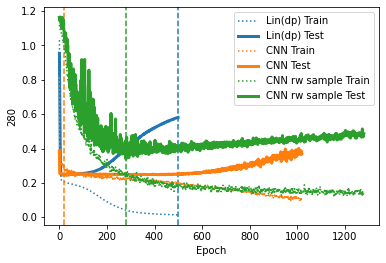

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2880, out_features=10, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [48]:
# make model
seq_len = len(train_df['upstream_region'].values[0])

mer8motif_model_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
mer8motif_model_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

# run model
mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn,\
estop = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn, 
    loss_func,
    lr=0.01,
    epochs=2500,
)

mer8motif_cnn_rw_data_label = [((mer8motif_train_losses_cnn,mer8motif_test_losses_cnn),'CNN rw sample',estop)]

tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label+mer8motif_cnn_rw_data_label,estop)

mer8motif_model_cnn

### Slow learning rate 

E:5 | train loss:1.117 | val loss: 0.892:   0%|          | 5/5000 [00:00<04:07, 20.17it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:9 | train loss:1.108 | val loss: 0.896:   0%|          | 8/5000 [00:00<04:06, 20.27it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:13 | train loss:1.104 | val loss: 0.902:   0%|          | 13/5000 [00:00<04:12, 19.72it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:17 | train loss:1.111 | val loss: 0.911:   0%|          | 17/5000 [00:00<04:16, 19.44it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:21 | train loss:1.109 | val loss: 0.921:   0%|          | 21/5000 [00:01<04:20, 19.13it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:25 | train loss:1.105 | val loss: 0.932:   0%|          | 25/5000 [00:01<04:25, 18.73it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000


E:29 | train loss:1.111 | val loss: 0.942:   1%|          | 29/5000 [00:01<04:27, 18.57it/s]

EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000


E:33 | train loss:1.105 | val loss: 0.953:   1%|          | 33/5000 [00:01<04:22, 18.89it/s]

EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000


E:37 | train loss:1.102 | val loss: 0.963:   1%|          | 38/5000 [00:01<04:17, 19.27it/s]

EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000


E:41 | train loss:1.101 | val loss: 0.973:   1%|          | 42/5000 [00:02<04:17, 19.29it/s]

EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000


E:45 | train loss:1.102 | val loss: 0.983:   1%|          | 46/5000 [00:02<04:17, 19.21it/s]

EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000


E:49 | train loss:1.101 | val loss: 0.990:   1%|          | 50/5000 [00:02<04:17, 19.25it/s]

EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000


E:53 | train loss:1.101 | val loss: 0.995:   1%|          | 54/5000 [00:02<04:15, 19.35it/s]

EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000
EarlyStopping counter: 53 out of 1000


E:57 | train loss:1.099 | val loss: 1.003:   1%|          | 58/5000 [00:03<04:16, 19.28it/s]

EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000
EarlyStopping counter: 56 out of 1000
EarlyStopping counter: 57 out of 1000


E:62 | train loss:1.098 | val loss: 1.013:   1%|          | 61/5000 [00:03<04:10, 19.73it/s]

EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000
EarlyStopping counter: 60 out of 1000
EarlyStopping counter: 61 out of 1000
EarlyStopping counter: 62 out of 1000


E:67 | train loss:1.103 | val loss: 1.020:   1%|▏         | 67/5000 [00:03<04:05, 20.06it/s]

EarlyStopping counter: 63 out of 1000
EarlyStopping counter: 64 out of 1000
EarlyStopping counter: 65 out of 1000
EarlyStopping counter: 66 out of 1000
EarlyStopping counter: 67 out of 1000


E:71 | train loss:1.099 | val loss: 1.016:   1%|▏         | 72/5000 [00:03<04:06, 19.98it/s]

EarlyStopping counter: 68 out of 1000
EarlyStopping counter: 69 out of 1000
EarlyStopping counter: 70 out of 1000
EarlyStopping counter: 71 out of 1000


E:75 | train loss:1.098 | val loss: 1.019:   2%|▏         | 76/5000 [00:03<04:10, 19.68it/s]

EarlyStopping counter: 72 out of 1000
EarlyStopping counter: 73 out of 1000
EarlyStopping counter: 74 out of 1000
EarlyStopping counter: 75 out of 1000


E:80 | train loss:1.098 | val loss: 1.022:   2%|▏         | 81/5000 [00:04<04:09, 19.74it/s]

EarlyStopping counter: 76 out of 1000
EarlyStopping counter: 77 out of 1000
EarlyStopping counter: 78 out of 1000
EarlyStopping counter: 79 out of 1000
EarlyStopping counter: 80 out of 1000


E:84 | train loss:1.097 | val loss: 1.023:   2%|▏         | 85/5000 [00:04<04:12, 19.45it/s]

EarlyStopping counter: 81 out of 1000
EarlyStopping counter: 82 out of 1000
EarlyStopping counter: 83 out of 1000
EarlyStopping counter: 84 out of 1000


E:88 | train loss:1.094 | val loss: 1.025:   2%|▏         | 87/5000 [00:04<04:16, 19.13it/s]

EarlyStopping counter: 85 out of 1000
EarlyStopping counter: 86 out of 1000
EarlyStopping counter: 87 out of 1000
EarlyStopping counter: 88 out of 1000


E:92 | train loss:1.099 | val loss: 1.025:   2%|▏         | 93/5000 [00:04<04:08, 19.76it/s]

EarlyStopping counter: 89 out of 1000
EarlyStopping counter: 90 out of 1000
EarlyStopping counter: 91 out of 1000
EarlyStopping counter: 92 out of 1000


E:97 | train loss:1.096 | val loss: 1.030:   2%|▏         | 98/5000 [00:05<04:07, 19.81it/s]

EarlyStopping counter: 93 out of 1000
EarlyStopping counter: 94 out of 1000
EarlyStopping counter: 95 out of 1000
EarlyStopping counter: 96 out of 1000
EarlyStopping counter: 97 out of 1000


E:102 | train loss:1.095 | val loss: 1.028:   2%|▏         | 103/5000 [00:05<04:05, 19.98it/s]

EarlyStopping counter: 98 out of 1000
EarlyStopping counter: 99 out of 1000
EarlyStopping counter: 100 out of 1000
EarlyStopping counter: 101 out of 1000
EarlyStopping counter: 102 out of 1000


E:107 | train loss:1.098 | val loss: 1.028:   2%|▏         | 108/5000 [00:05<04:04, 19.98it/s]

EarlyStopping counter: 103 out of 1000
EarlyStopping counter: 104 out of 1000
EarlyStopping counter: 105 out of 1000
EarlyStopping counter: 106 out of 1000
EarlyStopping counter: 107 out of 1000


E:111 | train loss:1.096 | val loss: 1.027:   2%|▏         | 112/5000 [00:05<04:09, 19.59it/s]

EarlyStopping counter: 108 out of 1000
EarlyStopping counter: 109 out of 1000
EarlyStopping counter: 110 out of 1000
EarlyStopping counter: 111 out of 1000


E:115 | train loss:1.099 | val loss: 1.026:   2%|▏         | 116/5000 [00:05<04:12, 19.31it/s]

EarlyStopping counter: 112 out of 1000
EarlyStopping counter: 113 out of 1000
EarlyStopping counter: 114 out of 1000
EarlyStopping counter: 115 out of 1000


E:119 | train loss:1.093 | val loss: 1.030:   2%|▏         | 119/5000 [00:06<04:09, 19.53it/s]

EarlyStopping counter: 116 out of 1000
EarlyStopping counter: 117 out of 1000
EarlyStopping counter: 118 out of 1000
EarlyStopping counter: 119 out of 1000


E:123 | train loss:1.097 | val loss: 1.028:   2%|▏         | 123/5000 [00:06<04:11, 19.38it/s]

EarlyStopping counter: 120 out of 1000
EarlyStopping counter: 121 out of 1000
EarlyStopping counter: 122 out of 1000
EarlyStopping counter: 123 out of 1000


E:128 | train loss:1.093 | val loss: 1.030:   3%|▎         | 127/5000 [00:06<04:10, 19.47it/s]

EarlyStopping counter: 124 out of 1000
EarlyStopping counter: 125 out of 1000
EarlyStopping counter: 126 out of 1000
EarlyStopping counter: 127 out of 1000
EarlyStopping counter: 128 out of 1000


E:132 | train loss:1.093 | val loss: 1.031:   3%|▎         | 132/5000 [00:06<04:10, 19.43it/s]

EarlyStopping counter: 129 out of 1000
EarlyStopping counter: 130 out of 1000
EarlyStopping counter: 131 out of 1000
EarlyStopping counter: 132 out of 1000


E:137 | train loss:1.094 | val loss: 1.031:   3%|▎         | 138/5000 [00:07<04:05, 19.83it/s]

EarlyStopping counter: 133 out of 1000
EarlyStopping counter: 134 out of 1000
EarlyStopping counter: 135 out of 1000
EarlyStopping counter: 136 out of 1000
EarlyStopping counter: 137 out of 1000


E:142 | train loss:1.094 | val loss: 1.031:   3%|▎         | 141/5000 [00:07<04:04, 19.91it/s]

EarlyStopping counter: 138 out of 1000
EarlyStopping counter: 139 out of 1000
EarlyStopping counter: 140 out of 1000
EarlyStopping counter: 141 out of 1000
EarlyStopping counter: 142 out of 1000


E:146 | train loss:1.094 | val loss: 1.028:   3%|▎         | 146/5000 [00:07<04:05, 19.78it/s]

EarlyStopping counter: 143 out of 1000
EarlyStopping counter: 144 out of 1000
EarlyStopping counter: 145 out of 1000
EarlyStopping counter: 146 out of 1000


E:150 | train loss:1.092 | val loss: 1.031:   3%|▎         | 150/5000 [00:07<04:11, 19.30it/s]

EarlyStopping counter: 147 out of 1000
EarlyStopping counter: 148 out of 1000
EarlyStopping counter: 149 out of 1000
EarlyStopping counter: 150 out of 1000


E:154 | train loss:1.091 | val loss: 1.030:   3%|▎         | 154/5000 [00:07<04:12, 19.17it/s]

EarlyStopping counter: 151 out of 1000
EarlyStopping counter: 152 out of 1000
EarlyStopping counter: 153 out of 1000
EarlyStopping counter: 154 out of 1000


E:158 | train loss:1.097 | val loss: 1.030:   3%|▎         | 158/5000 [00:08<04:12, 19.20it/s]

EarlyStopping counter: 155 out of 1000
EarlyStopping counter: 156 out of 1000
EarlyStopping counter: 157 out of 1000
EarlyStopping counter: 158 out of 1000


E:162 | train loss:1.096 | val loss: 1.030:   3%|▎         | 162/5000 [00:08<04:11, 19.26it/s]

EarlyStopping counter: 159 out of 1000
EarlyStopping counter: 160 out of 1000
EarlyStopping counter: 161 out of 1000
EarlyStopping counter: 162 out of 1000


E:166 | train loss:1.090 | val loss: 1.036:   3%|▎         | 166/5000 [00:08<04:13, 19.08it/s]

EarlyStopping counter: 163 out of 1000
EarlyStopping counter: 164 out of 1000
EarlyStopping counter: 165 out of 1000
EarlyStopping counter: 166 out of 1000


E:170 | train loss:1.092 | val loss: 1.040:   3%|▎         | 170/5000 [00:08<04:07, 19.51it/s]

EarlyStopping counter: 167 out of 1000
EarlyStopping counter: 168 out of 1000
EarlyStopping counter: 169 out of 1000
EarlyStopping counter: 170 out of 1000


E:175 | train loss:1.091 | val loss: 1.040:   4%|▎         | 175/5000 [00:09<04:04, 19.71it/s]

EarlyStopping counter: 171 out of 1000
EarlyStopping counter: 172 out of 1000
EarlyStopping counter: 173 out of 1000
EarlyStopping counter: 174 out of 1000
EarlyStopping counter: 175 out of 1000


E:180 | train loss:1.092 | val loss: 1.037:   4%|▎         | 180/5000 [00:09<04:02, 19.86it/s]

EarlyStopping counter: 176 out of 1000
EarlyStopping counter: 177 out of 1000
EarlyStopping counter: 178 out of 1000
EarlyStopping counter: 179 out of 1000


E:185 | train loss:1.091 | val loss: 1.037:   4%|▎         | 186/5000 [00:09<04:00, 20.04it/s]

EarlyStopping counter: 180 out of 1000
EarlyStopping counter: 181 out of 1000
EarlyStopping counter: 182 out of 1000
EarlyStopping counter: 183 out of 1000
EarlyStopping counter: 184 out of 1000
EarlyStopping counter: 185 out of 1000


E:189 | train loss:1.090 | val loss: 1.040:   4%|▍         | 190/5000 [00:09<04:01, 19.95it/s]

EarlyStopping counter: 186 out of 1000
EarlyStopping counter: 187 out of 1000
EarlyStopping counter: 188 out of 1000
EarlyStopping counter: 189 out of 1000


E:193 | train loss:1.090 | val loss: 1.040:   4%|▍         | 194/5000 [00:09<04:02, 19.80it/s]

EarlyStopping counter: 190 out of 1000
EarlyStopping counter: 191 out of 1000
EarlyStopping counter: 192 out of 1000
EarlyStopping counter: 193 out of 1000


E:198 | train loss:1.089 | val loss: 1.037:   4%|▍         | 199/5000 [00:10<04:00, 19.97it/s]

EarlyStopping counter: 194 out of 1000
EarlyStopping counter: 195 out of 1000
EarlyStopping counter: 196 out of 1000
EarlyStopping counter: 197 out of 1000
EarlyStopping counter: 198 out of 1000


E:202 | train loss:1.093 | val loss: 1.038:   4%|▍         | 203/5000 [00:10<04:04, 19.61it/s]

EarlyStopping counter: 199 out of 1000
EarlyStopping counter: 200 out of 1000
EarlyStopping counter: 201 out of 1000
EarlyStopping counter: 202 out of 1000


E:207 | train loss:1.089 | val loss: 1.040:   4%|▍         | 208/5000 [00:10<04:01, 19.81it/s]

EarlyStopping counter: 203 out of 1000
EarlyStopping counter: 204 out of 1000
EarlyStopping counter: 205 out of 1000
EarlyStopping counter: 206 out of 1000
EarlyStopping counter: 207 out of 1000


E:212 | train loss:1.087 | val loss: 1.040:   4%|▍         | 212/5000 [00:10<04:02, 19.75it/s]

EarlyStopping counter: 208 out of 1000
EarlyStopping counter: 209 out of 1000
EarlyStopping counter: 210 out of 1000
EarlyStopping counter: 211 out of 1000


E:217 | train loss:1.089 | val loss: 1.043:   4%|▍         | 217/5000 [00:11<03:59, 19.94it/s]

EarlyStopping counter: 212 out of 1000
EarlyStopping counter: 213 out of 1000
EarlyStopping counter: 214 out of 1000
EarlyStopping counter: 215 out of 1000
EarlyStopping counter: 216 out of 1000
EarlyStopping counter: 217 out of 1000


E:221 | train loss:1.086 | val loss: 1.043:   4%|▍         | 221/5000 [00:11<04:04, 19.54it/s]

EarlyStopping counter: 218 out of 1000
EarlyStopping counter: 219 out of 1000
EarlyStopping counter: 220 out of 1000
EarlyStopping counter: 221 out of 1000


E:225 | train loss:1.086 | val loss: 1.045:   5%|▍         | 226/5000 [00:11<04:03, 19.62it/s]

EarlyStopping counter: 222 out of 1000
EarlyStopping counter: 223 out of 1000
EarlyStopping counter: 224 out of 1000
EarlyStopping counter: 225 out of 1000


E:230 | train loss:1.087 | val loss: 1.049:   5%|▍         | 231/5000 [00:11<03:59, 19.89it/s]

EarlyStopping counter: 226 out of 1000
EarlyStopping counter: 227 out of 1000
EarlyStopping counter: 228 out of 1000
EarlyStopping counter: 229 out of 1000
EarlyStopping counter: 230 out of 1000


E:235 | train loss:1.082 | val loss: 1.053:   5%|▍         | 234/5000 [00:12<03:57, 20.07it/s]

EarlyStopping counter: 231 out of 1000
EarlyStopping counter: 232 out of 1000
EarlyStopping counter: 233 out of 1000
EarlyStopping counter: 234 out of 1000
EarlyStopping counter: 235 out of 1000


E:239 | train loss:1.083 | val loss: 1.053:   5%|▍         | 239/5000 [00:12<03:59, 19.89it/s]

EarlyStopping counter: 236 out of 1000
EarlyStopping counter: 237 out of 1000
EarlyStopping counter: 238 out of 1000
EarlyStopping counter: 239 out of 1000


E:243 | train loss:1.084 | val loss: 1.050:   5%|▍         | 243/5000 [00:12<04:02, 19.64it/s]

EarlyStopping counter: 240 out of 1000
EarlyStopping counter: 241 out of 1000
EarlyStopping counter: 242 out of 1000
EarlyStopping counter: 243 out of 1000


E:247 | train loss:1.082 | val loss: 1.051:   5%|▍         | 248/5000 [00:12<04:00, 19.76it/s]

EarlyStopping counter: 244 out of 1000
EarlyStopping counter: 245 out of 1000
EarlyStopping counter: 246 out of 1000
EarlyStopping counter: 247 out of 1000


E:251 | train loss:1.084 | val loss: 1.051:   5%|▌         | 252/5000 [00:12<04:01, 19.66it/s]

EarlyStopping counter: 248 out of 1000
EarlyStopping counter: 249 out of 1000
EarlyStopping counter: 250 out of 1000
EarlyStopping counter: 251 out of 1000


E:256 | train loss:1.085 | val loss: 1.050:   5%|▌         | 255/5000 [00:13<03:58, 19.86it/s]

EarlyStopping counter: 252 out of 1000
EarlyStopping counter: 253 out of 1000
EarlyStopping counter: 254 out of 1000
EarlyStopping counter: 255 out of 1000
EarlyStopping counter: 256 out of 1000


E:261 | train loss:1.082 | val loss: 1.046:   5%|▌         | 261/5000 [00:13<03:56, 20.06it/s]

EarlyStopping counter: 257 out of 1000
EarlyStopping counter: 258 out of 1000
EarlyStopping counter: 259 out of 1000
EarlyStopping counter: 260 out of 1000
EarlyStopping counter: 261 out of 1000


E:264 | train loss:1.084 | val loss: 1.048:   5%|▌         | 264/5000 [00:13<04:33, 17.33it/s]

EarlyStopping counter: 262 out of 1000
EarlyStopping counter: 263 out of 1000
EarlyStopping counter: 264 out of 1000


E:268 | train loss:1.081 | val loss: 1.046:   5%|▌         | 269/5000 [00:13<04:16, 18.47it/s]

EarlyStopping counter: 265 out of 1000
EarlyStopping counter: 266 out of 1000
EarlyStopping counter: 267 out of 1000
EarlyStopping counter: 268 out of 1000


E:273 | train loss:1.082 | val loss: 1.047:   5%|▌         | 271/5000 [00:14<04:14, 18.58it/s]

EarlyStopping counter: 269 out of 1000
EarlyStopping counter: 270 out of 1000
EarlyStopping counter: 271 out of 1000
EarlyStopping counter: 272 out of 1000


E:276 | train loss:1.083 | val loss: 1.045:   6%|▌         | 276/5000 [00:14<04:06, 19.19it/s]

EarlyStopping counter: 273 out of 1000
EarlyStopping counter: 274 out of 1000
EarlyStopping counter: 275 out of 1000
EarlyStopping counter: 276 out of 1000


E:280 | train loss:1.075 | val loss: 1.046:   6%|▌         | 280/5000 [00:14<04:04, 19.30it/s]

EarlyStopping counter: 277 out of 1000
EarlyStopping counter: 278 out of 1000
EarlyStopping counter: 279 out of 1000
EarlyStopping counter: 280 out of 1000


E:285 | train loss:1.078 | val loss: 1.045:   6%|▌         | 284/5000 [00:14<04:00, 19.62it/s]

EarlyStopping counter: 281 out of 1000
EarlyStopping counter: 282 out of 1000
EarlyStopping counter: 283 out of 1000
EarlyStopping counter: 284 out of 1000
EarlyStopping counter: 285 out of 1000


E:289 | train loss:1.080 | val loss: 1.046:   6%|▌         | 289/5000 [00:14<04:00, 19.61it/s]

EarlyStopping counter: 286 out of 1000
EarlyStopping counter: 287 out of 1000
EarlyStopping counter: 288 out of 1000
EarlyStopping counter: 289 out of 1000


E:293 | train loss:1.074 | val loss: 1.045:   6%|▌         | 293/5000 [00:15<04:05, 19.21it/s]

EarlyStopping counter: 290 out of 1000
EarlyStopping counter: 291 out of 1000
EarlyStopping counter: 292 out of 1000
EarlyStopping counter: 293 out of 1000


E:297 | train loss:1.077 | val loss: 1.043:   6%|▌         | 297/5000 [00:15<04:06, 19.08it/s]

EarlyStopping counter: 294 out of 1000
EarlyStopping counter: 295 out of 1000
EarlyStopping counter: 296 out of 1000
EarlyStopping counter: 297 out of 1000


E:302 | train loss:1.071 | val loss: 1.044:   6%|▌         | 301/5000 [00:15<04:03, 19.27it/s]

EarlyStopping counter: 298 out of 1000
EarlyStopping counter: 299 out of 1000
EarlyStopping counter: 300 out of 1000
EarlyStopping counter: 301 out of 1000


E:306 | train loss:1.074 | val loss: 1.046:   6%|▌         | 306/5000 [00:15<03:58, 19.69it/s]

EarlyStopping counter: 302 out of 1000
EarlyStopping counter: 303 out of 1000
EarlyStopping counter: 304 out of 1000
EarlyStopping counter: 305 out of 1000
EarlyStopping counter: 306 out of 1000


E:310 | train loss:1.073 | val loss: 1.041:   6%|▌         | 310/5000 [00:15<03:59, 19.62it/s]

EarlyStopping counter: 307 out of 1000
EarlyStopping counter: 308 out of 1000
EarlyStopping counter: 309 out of 1000
EarlyStopping counter: 310 out of 1000


E:315 | train loss:1.071 | val loss: 1.039:   6%|▋         | 314/5000 [00:16<03:59, 19.60it/s]

EarlyStopping counter: 311 out of 1000
EarlyStopping counter: 312 out of 1000
EarlyStopping counter: 313 out of 1000
EarlyStopping counter: 314 out of 1000


E:319 | train loss:1.065 | val loss: 1.042:   6%|▋         | 320/5000 [00:16<03:54, 19.98it/s]

EarlyStopping counter: 315 out of 1000
EarlyStopping counter: 316 out of 1000
EarlyStopping counter: 317 out of 1000
EarlyStopping counter: 318 out of 1000
EarlyStopping counter: 319 out of 1000


E:324 | train loss:1.068 | val loss: 1.043:   6%|▋         | 322/5000 [00:16<03:56, 19.77it/s]

EarlyStopping counter: 320 out of 1000
EarlyStopping counter: 321 out of 1000
EarlyStopping counter: 322 out of 1000
EarlyStopping counter: 323 out of 1000


E:327 | train loss:1.069 | val loss: 1.046:   7%|▋         | 327/5000 [00:16<03:57, 19.71it/s]

EarlyStopping counter: 324 out of 1000
EarlyStopping counter: 325 out of 1000
EarlyStopping counter: 326 out of 1000
EarlyStopping counter: 327 out of 1000


E:331 | train loss:1.063 | val loss: 1.052:   7%|▋         | 331/5000 [00:16<03:58, 19.57it/s]

EarlyStopping counter: 328 out of 1000
EarlyStopping counter: 329 out of 1000
EarlyStopping counter: 330 out of 1000
EarlyStopping counter: 331 out of 1000


E:336 | train loss:1.069 | val loss: 1.051:   7%|▋         | 336/5000 [00:17<03:55, 19.84it/s]

EarlyStopping counter: 332 out of 1000
EarlyStopping counter: 333 out of 1000
EarlyStopping counter: 334 out of 1000
EarlyStopping counter: 335 out of 1000
EarlyStopping counter: 336 out of 1000


E:341 | train loss:1.064 | val loss: 1.048:   7%|▋         | 341/5000 [00:17<03:53, 19.94it/s]

EarlyStopping counter: 337 out of 1000
EarlyStopping counter: 338 out of 1000
EarlyStopping counter: 339 out of 1000
EarlyStopping counter: 340 out of 1000
EarlyStopping counter: 341 out of 1000


E:345 | train loss:1.063 | val loss: 1.046:   7%|▋         | 346/5000 [00:17<03:55, 19.78it/s]

EarlyStopping counter: 342 out of 1000
EarlyStopping counter: 343 out of 1000
EarlyStopping counter: 344 out of 1000
EarlyStopping counter: 345 out of 1000


E:349 | train loss:1.058 | val loss: 1.046:   7%|▋         | 350/5000 [00:17<04:00, 19.37it/s]

EarlyStopping counter: 346 out of 1000
EarlyStopping counter: 347 out of 1000
EarlyStopping counter: 348 out of 1000
EarlyStopping counter: 349 out of 1000


E:353 | train loss:1.062 | val loss: 1.046:   7%|▋         | 354/5000 [00:18<03:59, 19.37it/s]

EarlyStopping counter: 350 out of 1000
EarlyStopping counter: 351 out of 1000
EarlyStopping counter: 352 out of 1000
EarlyStopping counter: 353 out of 1000


E:358 | train loss:1.063 | val loss: 1.051:   7%|▋         | 357/5000 [00:18<03:55, 19.69it/s]

EarlyStopping counter: 354 out of 1000
EarlyStopping counter: 355 out of 1000
EarlyStopping counter: 356 out of 1000
EarlyStopping counter: 357 out of 1000
EarlyStopping counter: 358 out of 1000


E:362 | train loss:1.057 | val loss: 1.048:   7%|▋         | 362/5000 [00:18<03:54, 19.74it/s]

EarlyStopping counter: 359 out of 1000
EarlyStopping counter: 360 out of 1000
EarlyStopping counter: 361 out of 1000
EarlyStopping counter: 362 out of 1000


E:367 | train loss:1.052 | val loss: 1.050:   7%|▋         | 366/5000 [00:18<03:53, 19.84it/s]

EarlyStopping counter: 363 out of 1000
EarlyStopping counter: 364 out of 1000
EarlyStopping counter: 365 out of 1000
EarlyStopping counter: 366 out of 1000
EarlyStopping counter: 367 out of 1000


E:372 | train loss:1.051 | val loss: 1.054:   7%|▋         | 372/5000 [00:19<03:51, 19.95it/s]

EarlyStopping counter: 368 out of 1000
EarlyStopping counter: 369 out of 1000
EarlyStopping counter: 370 out of 1000
EarlyStopping counter: 371 out of 1000


E:375 | train loss:1.055 | val loss: 1.054:   8%|▊         | 376/5000 [00:19<03:54, 19.68it/s]

EarlyStopping counter: 372 out of 1000
EarlyStopping counter: 373 out of 1000
EarlyStopping counter: 374 out of 1000
EarlyStopping counter: 375 out of 1000


E:379 | train loss:1.054 | val loss: 1.047:   8%|▊         | 379/5000 [00:19<03:53, 19.78it/s]

EarlyStopping counter: 376 out of 1000
EarlyStopping counter: 377 out of 1000
EarlyStopping counter: 378 out of 1000
EarlyStopping counter: 379 out of 1000


E:383 | train loss:1.049 | val loss: 1.047:   8%|▊         | 383/5000 [00:19<03:56, 19.49it/s]

EarlyStopping counter: 380 out of 1000
EarlyStopping counter: 381 out of 1000
EarlyStopping counter: 382 out of 1000
EarlyStopping counter: 383 out of 1000


E:388 | train loss:1.053 | val loss: 1.048:   8%|▊         | 388/5000 [00:19<03:52, 19.81it/s]

EarlyStopping counter: 384 out of 1000
EarlyStopping counter: 385 out of 1000
EarlyStopping counter: 386 out of 1000
EarlyStopping counter: 387 out of 1000
EarlyStopping counter: 388 out of 1000


E:392 | train loss:1.042 | val loss: 1.046:   8%|▊         | 393/5000 [00:20<03:53, 19.71it/s]

EarlyStopping counter: 389 out of 1000
EarlyStopping counter: 390 out of 1000
EarlyStopping counter: 391 out of 1000
EarlyStopping counter: 392 out of 1000


E:396 | train loss:1.042 | val loss: 1.045:   8%|▊         | 397/5000 [00:20<03:58, 19.26it/s]

EarlyStopping counter: 393 out of 1000
EarlyStopping counter: 394 out of 1000
EarlyStopping counter: 395 out of 1000
EarlyStopping counter: 396 out of 1000


E:401 | train loss:1.045 | val loss: 1.049:   8%|▊         | 399/5000 [00:20<04:00, 19.09it/s]

EarlyStopping counter: 397 out of 1000
EarlyStopping counter: 398 out of 1000
EarlyStopping counter: 399 out of 1000
EarlyStopping counter: 400 out of 1000


E:404 | train loss:1.044 | val loss: 1.045:   8%|▊         | 404/5000 [00:20<03:55, 19.48it/s]

EarlyStopping counter: 401 out of 1000
EarlyStopping counter: 402 out of 1000
EarlyStopping counter: 403 out of 1000
EarlyStopping counter: 404 out of 1000


E:408 | train loss:1.044 | val loss: 1.047:   8%|▊         | 408/5000 [00:20<03:57, 19.34it/s]

EarlyStopping counter: 405 out of 1000
EarlyStopping counter: 406 out of 1000
EarlyStopping counter: 407 out of 1000
EarlyStopping counter: 408 out of 1000


E:412 | train loss:1.033 | val loss: 1.045:   8%|▊         | 412/5000 [00:21<03:59, 19.17it/s]

EarlyStopping counter: 409 out of 1000
EarlyStopping counter: 410 out of 1000
EarlyStopping counter: 411 out of 1000
EarlyStopping counter: 412 out of 1000


E:416 | train loss:1.039 | val loss: 1.042:   8%|▊         | 416/5000 [00:21<04:00, 19.09it/s]

EarlyStopping counter: 413 out of 1000
EarlyStopping counter: 414 out of 1000
EarlyStopping counter: 415 out of 1000
EarlyStopping counter: 416 out of 1000


E:420 | train loss:1.038 | val loss: 1.043:   8%|▊         | 420/5000 [00:21<03:59, 19.12it/s]

EarlyStopping counter: 417 out of 1000
EarlyStopping counter: 418 out of 1000
EarlyStopping counter: 419 out of 1000
EarlyStopping counter: 420 out of 1000


E:425 | train loss:1.037 | val loss: 1.039:   8%|▊         | 424/5000 [00:21<03:55, 19.47it/s]

EarlyStopping counter: 421 out of 1000
EarlyStopping counter: 422 out of 1000
EarlyStopping counter: 423 out of 1000
EarlyStopping counter: 424 out of 1000
EarlyStopping counter: 425 out of 1000


E:429 | train loss:1.033 | val loss: 1.047:   9%|▊         | 429/5000 [00:22<03:55, 19.41it/s]

EarlyStopping counter: 426 out of 1000
EarlyStopping counter: 427 out of 1000
EarlyStopping counter: 428 out of 1000
EarlyStopping counter: 429 out of 1000


E:433 | train loss:1.030 | val loss: 1.045:   9%|▊         | 433/5000 [00:22<03:55, 19.36it/s]

EarlyStopping counter: 430 out of 1000
EarlyStopping counter: 431 out of 1000
EarlyStopping counter: 432 out of 1000
EarlyStopping counter: 433 out of 1000


E:437 | train loss:1.027 | val loss: 1.054:   9%|▊         | 437/5000 [00:22<03:57, 19.25it/s]

EarlyStopping counter: 434 out of 1000
EarlyStopping counter: 435 out of 1000
EarlyStopping counter: 436 out of 1000
EarlyStopping counter: 437 out of 1000


E:441 | train loss:1.031 | val loss: 1.057:   9%|▉         | 441/5000 [00:22<04:00, 18.98it/s]

EarlyStopping counter: 438 out of 1000
EarlyStopping counter: 439 out of 1000
EarlyStopping counter: 440 out of 1000
EarlyStopping counter: 441 out of 1000


E:445 | train loss:1.017 | val loss: 1.053:   9%|▉         | 445/5000 [00:22<04:02, 18.79it/s]

EarlyStopping counter: 442 out of 1000
EarlyStopping counter: 443 out of 1000
EarlyStopping counter: 444 out of 1000
EarlyStopping counter: 445 out of 1000


E:449 | train loss:1.023 | val loss: 1.038:   9%|▉         | 450/5000 [00:23<03:55, 19.29it/s]

EarlyStopping counter: 446 out of 1000
EarlyStopping counter: 447 out of 1000
EarlyStopping counter: 448 out of 1000
EarlyStopping counter: 449 out of 1000


E:454 | train loss:1.019 | val loss: 1.050:   9%|▉         | 454/5000 [00:23<03:53, 19.51it/s]

EarlyStopping counter: 450 out of 1000
EarlyStopping counter: 451 out of 1000
EarlyStopping counter: 452 out of 1000
EarlyStopping counter: 453 out of 1000


E:457 | train loss:1.025 | val loss: 1.050:   9%|▉         | 457/5000 [00:23<03:50, 19.71it/s]

EarlyStopping counter: 454 out of 1000
EarlyStopping counter: 455 out of 1000
EarlyStopping counter: 456 out of 1000
EarlyStopping counter: 457 out of 1000


E:461 | train loss:1.014 | val loss: 1.044:   9%|▉         | 461/5000 [00:23<03:50, 19.68it/s]

EarlyStopping counter: 458 out of 1000
EarlyStopping counter: 459 out of 1000
EarlyStopping counter: 460 out of 1000
EarlyStopping counter: 461 out of 1000


E:465 | train loss:1.012 | val loss: 1.047:   9%|▉         | 465/5000 [00:23<03:50, 19.67it/s]

EarlyStopping counter: 462 out of 1000
EarlyStopping counter: 463 out of 1000
EarlyStopping counter: 464 out of 1000
EarlyStopping counter: 465 out of 1000


E:470 | train loss:1.015 | val loss: 1.046:   9%|▉         | 471/5000 [00:24<03:47, 19.90it/s]

EarlyStopping counter: 466 out of 1000
EarlyStopping counter: 467 out of 1000
EarlyStopping counter: 468 out of 1000
EarlyStopping counter: 469 out of 1000
EarlyStopping counter: 470 out of 1000


E:474 | train loss:1.011 | val loss: 1.042:  10%|▉         | 475/5000 [00:24<03:51, 19.51it/s]

EarlyStopping counter: 471 out of 1000
EarlyStopping counter: 472 out of 1000
EarlyStopping counter: 473 out of 1000
EarlyStopping counter: 474 out of 1000


E:478 | train loss:1.009 | val loss: 1.041:  10%|▉         | 478/5000 [00:24<03:50, 19.62it/s]

EarlyStopping counter: 475 out of 1000
EarlyStopping counter: 476 out of 1000
EarlyStopping counter: 477 out of 1000
EarlyStopping counter: 478 out of 1000


E:482 | train loss:1.007 | val loss: 1.041:  10%|▉         | 482/5000 [00:24<03:50, 19.64it/s]

EarlyStopping counter: 479 out of 1000
EarlyStopping counter: 480 out of 1000
EarlyStopping counter: 481 out of 1000
EarlyStopping counter: 482 out of 1000


E:486 | train loss:1.001 | val loss: 1.043:  10%|▉         | 486/5000 [00:24<03:52, 19.44it/s]

EarlyStopping counter: 483 out of 1000
EarlyStopping counter: 484 out of 1000
EarlyStopping counter: 485 out of 1000
EarlyStopping counter: 486 out of 1000


E:491 | train loss:0.992 | val loss: 1.030:  10%|▉         | 492/5000 [00:25<03:46, 19.92it/s]

EarlyStopping counter: 487 out of 1000
EarlyStopping counter: 488 out of 1000
EarlyStopping counter: 489 out of 1000
EarlyStopping counter: 490 out of 1000
EarlyStopping counter: 491 out of 1000


E:496 | train loss:0.995 | val loss: 1.035:  10%|▉         | 495/5000 [00:25<03:44, 20.04it/s]

EarlyStopping counter: 492 out of 1000
EarlyStopping counter: 493 out of 1000
EarlyStopping counter: 494 out of 1000
EarlyStopping counter: 495 out of 1000
EarlyStopping counter: 496 out of 1000


E:500 | train loss:0.990 | val loss: 1.040:  10%|█         | 500/5000 [00:25<03:47, 19.76it/s]

EarlyStopping counter: 497 out of 1000
EarlyStopping counter: 498 out of 1000
EarlyStopping counter: 499 out of 1000
EarlyStopping counter: 500 out of 1000


E:504 | train loss:0.989 | val loss: 1.035:  10%|█         | 504/5000 [00:25<03:51, 19.46it/s]

EarlyStopping counter: 501 out of 1000
EarlyStopping counter: 502 out of 1000
EarlyStopping counter: 503 out of 1000
EarlyStopping counter: 504 out of 1000


E:508 | train loss:0.975 | val loss: 1.044:  10%|█         | 508/5000 [00:26<03:49, 19.55it/s]

EarlyStopping counter: 505 out of 1000
EarlyStopping counter: 506 out of 1000
EarlyStopping counter: 507 out of 1000
EarlyStopping counter: 508 out of 1000


E:512 | train loss:0.976 | val loss: 1.038:  10%|█         | 512/5000 [00:26<03:49, 19.59it/s]

EarlyStopping counter: 509 out of 1000
EarlyStopping counter: 510 out of 1000
EarlyStopping counter: 511 out of 1000
EarlyStopping counter: 512 out of 1000


E:516 | train loss:0.977 | val loss: 1.045:  10%|█         | 516/5000 [00:26<03:48, 19.65it/s]

EarlyStopping counter: 513 out of 1000
EarlyStopping counter: 514 out of 1000
EarlyStopping counter: 515 out of 1000
EarlyStopping counter: 516 out of 1000


E:521 | train loss:0.981 | val loss: 1.034:  10%|█         | 521/5000 [00:26<03:46, 19.79it/s]

EarlyStopping counter: 517 out of 1000
EarlyStopping counter: 518 out of 1000
EarlyStopping counter: 519 out of 1000
EarlyStopping counter: 520 out of 1000
EarlyStopping counter: 521 out of 1000


E:526 | train loss:0.972 | val loss: 1.041:  11%|█         | 527/5000 [00:26<03:43, 20.04it/s]

EarlyStopping counter: 522 out of 1000
EarlyStopping counter: 523 out of 1000
EarlyStopping counter: 524 out of 1000
EarlyStopping counter: 525 out of 1000
EarlyStopping counter: 526 out of 1000


E:530 | train loss:0.964 | val loss: 1.041:  11%|█         | 530/5000 [00:27<03:43, 20.00it/s]

EarlyStopping counter: 527 out of 1000
EarlyStopping counter: 528 out of 1000
EarlyStopping counter: 529 out of 1000
EarlyStopping counter: 530 out of 1000


E:534 | train loss:0.961 | val loss: 1.030:  11%|█         | 534/5000 [00:27<03:46, 19.73it/s]

EarlyStopping counter: 531 out of 1000
EarlyStopping counter: 532 out of 1000
EarlyStopping counter: 533 out of 1000
EarlyStopping counter: 534 out of 1000


E:539 | train loss:0.962 | val loss: 1.037:  11%|█         | 538/5000 [00:27<03:46, 19.69it/s]

EarlyStopping counter: 535 out of 1000
EarlyStopping counter: 536 out of 1000
EarlyStopping counter: 537 out of 1000
EarlyStopping counter: 538 out of 1000
EarlyStopping counter: 539 out of 1000


E:543 | train loss:0.950 | val loss: 1.032:  11%|█         | 543/5000 [00:27<03:45, 19.78it/s]

EarlyStopping counter: 540 out of 1000
EarlyStopping counter: 541 out of 1000
EarlyStopping counter: 542 out of 1000
EarlyStopping counter: 543 out of 1000


E:548 | train loss:0.961 | val loss: 1.024:  11%|█         | 547/5000 [00:28<03:45, 19.72it/s]

EarlyStopping counter: 544 out of 1000
EarlyStopping counter: 545 out of 1000
EarlyStopping counter: 546 out of 1000
EarlyStopping counter: 547 out of 1000


E:552 | train loss:0.941 | val loss: 1.030:  11%|█         | 553/5000 [00:28<03:41, 20.06it/s]

EarlyStopping counter: 548 out of 1000
EarlyStopping counter: 549 out of 1000
EarlyStopping counter: 550 out of 1000
EarlyStopping counter: 551 out of 1000
EarlyStopping counter: 552 out of 1000


E:556 | train loss:0.942 | val loss: 1.024:  11%|█         | 556/5000 [00:28<03:41, 20.05it/s]

EarlyStopping counter: 553 out of 1000
EarlyStopping counter: 554 out of 1000
EarlyStopping counter: 555 out of 1000
EarlyStopping counter: 556 out of 1000


E:560 | train loss:0.931 | val loss: 1.048:  11%|█         | 561/5000 [00:28<03:46, 19.57it/s]

EarlyStopping counter: 557 out of 1000
EarlyStopping counter: 558 out of 1000
EarlyStopping counter: 559 out of 1000
EarlyStopping counter: 560 out of 1000


E:564 | train loss:0.931 | val loss: 1.032:  11%|█▏        | 565/5000 [00:28<03:49, 19.34it/s]

EarlyStopping counter: 561 out of 1000
EarlyStopping counter: 562 out of 1000
EarlyStopping counter: 563 out of 1000
EarlyStopping counter: 564 out of 1000


E:568 | train loss:0.935 | val loss: 1.027:  11%|█▏        | 568/5000 [00:29<03:45, 19.62it/s]

EarlyStopping counter: 565 out of 1000
EarlyStopping counter: 566 out of 1000
EarlyStopping counter: 567 out of 1000
EarlyStopping counter: 568 out of 1000


E:572 | train loss:0.928 | val loss: 1.029:  11%|█▏        | 572/5000 [00:29<03:47, 19.49it/s]

EarlyStopping counter: 569 out of 1000
EarlyStopping counter: 570 out of 1000
EarlyStopping counter: 571 out of 1000
EarlyStopping counter: 572 out of 1000


E:576 | train loss:0.922 | val loss: 1.026:  12%|█▏        | 577/5000 [00:29<03:44, 19.67it/s]

EarlyStopping counter: 573 out of 1000
EarlyStopping counter: 574 out of 1000
EarlyStopping counter: 575 out of 1000
EarlyStopping counter: 576 out of 1000


E:580 | train loss:0.918 | val loss: 1.026:  12%|█▏        | 581/5000 [00:29<03:45, 19.56it/s]

EarlyStopping counter: 577 out of 1000
EarlyStopping counter: 578 out of 1000
EarlyStopping counter: 579 out of 1000
EarlyStopping counter: 580 out of 1000


E:585 | train loss:0.914 | val loss: 1.019:  12%|█▏        | 584/5000 [00:29<03:42, 19.82it/s]

EarlyStopping counter: 581 out of 1000
EarlyStopping counter: 582 out of 1000
EarlyStopping counter: 583 out of 1000
EarlyStopping counter: 584 out of 1000
EarlyStopping counter: 585 out of 1000


E:589 | train loss:0.910 | val loss: 1.017:  12%|█▏        | 589/5000 [00:30<03:43, 19.76it/s]

EarlyStopping counter: 586 out of 1000
EarlyStopping counter: 587 out of 1000
EarlyStopping counter: 588 out of 1000
EarlyStopping counter: 589 out of 1000


E:593 | train loss:0.910 | val loss: 1.021:  12%|█▏        | 593/5000 [00:30<03:45, 19.58it/s]

EarlyStopping counter: 590 out of 1000
EarlyStopping counter: 591 out of 1000
EarlyStopping counter: 592 out of 1000
EarlyStopping counter: 593 out of 1000


E:597 | train loss:0.908 | val loss: 1.014:  12%|█▏        | 598/5000 [00:30<03:42, 19.75it/s]

EarlyStopping counter: 594 out of 1000
EarlyStopping counter: 595 out of 1000
EarlyStopping counter: 596 out of 1000
EarlyStopping counter: 597 out of 1000


E:601 | train loss:0.902 | val loss: 1.010:  12%|█▏        | 602/5000 [00:30<03:44, 19.62it/s]

EarlyStopping counter: 598 out of 1000
EarlyStopping counter: 599 out of 1000
EarlyStopping counter: 600 out of 1000
EarlyStopping counter: 601 out of 1000


E:605 | train loss:0.898 | val loss: 1.008:  12%|█▏        | 606/5000 [00:30<03:45, 19.45it/s]

EarlyStopping counter: 602 out of 1000
EarlyStopping counter: 603 out of 1000
EarlyStopping counter: 604 out of 1000
EarlyStopping counter: 605 out of 1000


E:609 | train loss:0.904 | val loss: 1.004:  12%|█▏        | 608/5000 [00:31<03:47, 19.31it/s]

EarlyStopping counter: 606 out of 1000
EarlyStopping counter: 607 out of 1000
EarlyStopping counter: 608 out of 1000
EarlyStopping counter: 609 out of 1000


E:613 | train loss:0.899 | val loss: 1.006:  12%|█▏        | 613/5000 [00:31<03:45, 19.45it/s]

EarlyStopping counter: 610 out of 1000
EarlyStopping counter: 611 out of 1000
EarlyStopping counter: 612 out of 1000
EarlyStopping counter: 613 out of 1000


E:618 | train loss:0.874 | val loss: 1.024:  12%|█▏        | 617/5000 [00:31<03:45, 19.42it/s]

EarlyStopping counter: 614 out of 1000
EarlyStopping counter: 615 out of 1000
EarlyStopping counter: 616 out of 1000
EarlyStopping counter: 617 out of 1000
EarlyStopping counter: 618 out of 1000


E:623 | train loss:0.881 | val loss: 0.996:  12%|█▏        | 623/5000 [00:31<03:39, 19.93it/s]

EarlyStopping counter: 619 out of 1000
EarlyStopping counter: 620 out of 1000
EarlyStopping counter: 621 out of 1000
EarlyStopping counter: 622 out of 1000
EarlyStopping counter: 623 out of 1000


E:627 | train loss:0.879 | val loss: 1.004:  13%|█▎        | 628/5000 [00:32<03:41, 19.78it/s]

EarlyStopping counter: 624 out of 1000
EarlyStopping counter: 625 out of 1000
EarlyStopping counter: 626 out of 1000
EarlyStopping counter: 627 out of 1000


E:631 | train loss:0.864 | val loss: 1.004:  13%|█▎        | 631/5000 [00:32<03:39, 19.90it/s]

EarlyStopping counter: 628 out of 1000
EarlyStopping counter: 629 out of 1000
EarlyStopping counter: 630 out of 1000
EarlyStopping counter: 631 out of 1000


E:635 | train loss:0.868 | val loss: 1.000:  13%|█▎        | 635/5000 [00:32<03:43, 19.54it/s]

EarlyStopping counter: 632 out of 1000
EarlyStopping counter: 633 out of 1000
EarlyStopping counter: 634 out of 1000
EarlyStopping counter: 635 out of 1000


E:639 | train loss:0.858 | val loss: 0.992:  13%|█▎        | 639/5000 [00:32<03:45, 19.38it/s]

EarlyStopping counter: 636 out of 1000
EarlyStopping counter: 637 out of 1000
EarlyStopping counter: 638 out of 1000
EarlyStopping counter: 639 out of 1000


E:643 | train loss:0.865 | val loss: 0.992:  13%|█▎        | 643/5000 [00:32<03:44, 19.38it/s]

EarlyStopping counter: 640 out of 1000
EarlyStopping counter: 641 out of 1000
EarlyStopping counter: 642 out of 1000
EarlyStopping counter: 643 out of 1000


E:647 | train loss:0.865 | val loss: 0.983:  13%|█▎        | 647/5000 [00:33<03:46, 19.23it/s]

EarlyStopping counter: 644 out of 1000
EarlyStopping counter: 645 out of 1000
EarlyStopping counter: 646 out of 1000
EarlyStopping counter: 647 out of 1000


E:651 | train loss:0.859 | val loss: 0.983:  13%|█▎        | 651/5000 [00:33<03:42, 19.53it/s]

EarlyStopping counter: 648 out of 1000
EarlyStopping counter: 649 out of 1000
EarlyStopping counter: 650 out of 1000
EarlyStopping counter: 651 out of 1000


E:656 | train loss:0.847 | val loss: 0.996:  13%|█▎        | 657/5000 [00:33<03:39, 19.79it/s]

EarlyStopping counter: 652 out of 1000
EarlyStopping counter: 653 out of 1000
EarlyStopping counter: 654 out of 1000
EarlyStopping counter: 655 out of 1000
EarlyStopping counter: 656 out of 1000


E:660 | train loss:0.839 | val loss: 0.986:  13%|█▎        | 659/5000 [00:33<03:38, 19.83it/s]

EarlyStopping counter: 657 out of 1000
EarlyStopping counter: 658 out of 1000
EarlyStopping counter: 659 out of 1000
EarlyStopping counter: 660 out of 1000


E:664 | train loss:0.850 | val loss: 0.982:  13%|█▎        | 664/5000 [00:33<03:42, 19.50it/s]

EarlyStopping counter: 661 out of 1000
EarlyStopping counter: 662 out of 1000
EarlyStopping counter: 663 out of 1000
EarlyStopping counter: 664 out of 1000


E:668 | train loss:0.845 | val loss: 0.979:  13%|█▎        | 668/5000 [00:34<03:45, 19.25it/s]

EarlyStopping counter: 665 out of 1000
EarlyStopping counter: 666 out of 1000
EarlyStopping counter: 667 out of 1000
EarlyStopping counter: 668 out of 1000


E:673 | train loss:0.832 | val loss: 0.975:  13%|█▎        | 674/5000 [00:34<03:38, 19.78it/s]

EarlyStopping counter: 669 out of 1000
EarlyStopping counter: 670 out of 1000
EarlyStopping counter: 671 out of 1000
EarlyStopping counter: 672 out of 1000
EarlyStopping counter: 673 out of 1000


E:678 | train loss:0.825 | val loss: 0.979:  14%|█▎        | 677/5000 [00:34<03:37, 19.89it/s]

EarlyStopping counter: 674 out of 1000
EarlyStopping counter: 675 out of 1000
EarlyStopping counter: 676 out of 1000
EarlyStopping counter: 677 out of 1000
EarlyStopping counter: 678 out of 1000


E:683 | train loss:0.818 | val loss: 0.984:  14%|█▎        | 683/5000 [00:34<03:35, 20.02it/s]

EarlyStopping counter: 679 out of 1000
EarlyStopping counter: 680 out of 1000
EarlyStopping counter: 681 out of 1000
EarlyStopping counter: 682 out of 1000
EarlyStopping counter: 683 out of 1000


E:688 | train loss:0.820 | val loss: 0.972:  14%|█▍        | 689/5000 [00:35<03:34, 20.06it/s]

EarlyStopping counter: 684 out of 1000
EarlyStopping counter: 685 out of 1000
EarlyStopping counter: 686 out of 1000
EarlyStopping counter: 687 out of 1000
EarlyStopping counter: 688 out of 1000


E:693 | train loss:0.820 | val loss: 0.971:  14%|█▍        | 692/5000 [00:35<03:35, 20.02it/s]

EarlyStopping counter: 689 out of 1000
EarlyStopping counter: 690 out of 1000
EarlyStopping counter: 691 out of 1000
EarlyStopping counter: 692 out of 1000


E:696 | train loss:0.803 | val loss: 0.967:  14%|█▍        | 697/5000 [00:35<03:35, 19.98it/s]

EarlyStopping counter: 693 out of 1000
EarlyStopping counter: 694 out of 1000
EarlyStopping counter: 695 out of 1000
EarlyStopping counter: 696 out of 1000


E:700 | train loss:0.819 | val loss: 0.956:  14%|█▍        | 701/5000 [00:35<03:41, 19.44it/s]

EarlyStopping counter: 697 out of 1000
EarlyStopping counter: 698 out of 1000
EarlyStopping counter: 699 out of 1000
EarlyStopping counter: 700 out of 1000


E:705 | train loss:0.800 | val loss: 0.966:  14%|█▍        | 706/5000 [00:36<03:37, 19.78it/s]

EarlyStopping counter: 701 out of 1000
EarlyStopping counter: 702 out of 1000
EarlyStopping counter: 703 out of 1000
EarlyStopping counter: 704 out of 1000
EarlyStopping counter: 705 out of 1000


E:710 | train loss:0.802 | val loss: 0.952:  14%|█▍        | 709/5000 [00:36<03:35, 19.87it/s]

EarlyStopping counter: 706 out of 1000
EarlyStopping counter: 707 out of 1000
EarlyStopping counter: 708 out of 1000
EarlyStopping counter: 709 out of 1000
EarlyStopping counter: 710 out of 1000


E:715 | train loss:0.783 | val loss: 0.959:  14%|█▍        | 715/5000 [00:36<03:34, 19.99it/s]

EarlyStopping counter: 711 out of 1000
EarlyStopping counter: 712 out of 1000
EarlyStopping counter: 713 out of 1000
EarlyStopping counter: 714 out of 1000
EarlyStopping counter: 715 out of 1000


E:720 | train loss:0.795 | val loss: 0.949:  14%|█▍        | 720/5000 [00:36<03:33, 20.02it/s]

EarlyStopping counter: 716 out of 1000
EarlyStopping counter: 717 out of 1000
EarlyStopping counter: 718 out of 1000
EarlyStopping counter: 719 out of 1000
EarlyStopping counter: 720 out of 1000


E:724 | train loss:0.764 | val loss: 0.958:  14%|█▍        | 723/5000 [00:37<03:33, 20.04it/s]

EarlyStopping counter: 721 out of 1000
EarlyStopping counter: 722 out of 1000
EarlyStopping counter: 723 out of 1000
EarlyStopping counter: 724 out of 1000


E:728 | train loss:0.787 | val loss: 0.949:  15%|█▍        | 728/5000 [00:37<03:41, 19.26it/s]

EarlyStopping counter: 725 out of 1000
EarlyStopping counter: 726 out of 1000
EarlyStopping counter: 727 out of 1000
EarlyStopping counter: 728 out of 1000


E:732 | train loss:0.777 | val loss: 0.944:  15%|█▍        | 732/5000 [00:37<03:44, 19.03it/s]

EarlyStopping counter: 729 out of 1000
EarlyStopping counter: 730 out of 1000
EarlyStopping counter: 731 out of 1000
EarlyStopping counter: 732 out of 1000


E:736 | train loss:0.782 | val loss: 0.941:  15%|█▍        | 736/5000 [00:37<03:44, 18.98it/s]

EarlyStopping counter: 733 out of 1000
EarlyStopping counter: 734 out of 1000
EarlyStopping counter: 735 out of 1000
EarlyStopping counter: 736 out of 1000


E:740 | train loss:0.767 | val loss: 0.937:  15%|█▍        | 740/5000 [00:37<03:47, 18.75it/s]

EarlyStopping counter: 737 out of 1000
EarlyStopping counter: 738 out of 1000
EarlyStopping counter: 739 out of 1000
EarlyStopping counter: 740 out of 1000


E:744 | train loss:0.786 | val loss: 0.933:  15%|█▍        | 744/5000 [00:38<03:40, 19.27it/s]

EarlyStopping counter: 741 out of 1000
EarlyStopping counter: 742 out of 1000
EarlyStopping counter: 743 out of 1000
EarlyStopping counter: 744 out of 1000


E:749 | train loss:0.778 | val loss: 0.925:  15%|█▍        | 748/5000 [00:38<03:37, 19.58it/s]

EarlyStopping counter: 745 out of 1000
EarlyStopping counter: 746 out of 1000
EarlyStopping counter: 747 out of 1000
EarlyStopping counter: 748 out of 1000


E:754 | train loss:0.767 | val loss: 0.932:  15%|█▌        | 755/5000 [00:38<03:33, 19.87it/s]

EarlyStopping counter: 749 out of 1000
EarlyStopping counter: 750 out of 1000
EarlyStopping counter: 751 out of 1000
EarlyStopping counter: 752 out of 1000
EarlyStopping counter: 753 out of 1000
EarlyStopping counter: 754 out of 1000


E:759 | train loss:0.767 | val loss: 0.924:  15%|█▌        | 759/5000 [00:38<03:33, 19.86it/s]

EarlyStopping counter: 755 out of 1000
EarlyStopping counter: 756 out of 1000
EarlyStopping counter: 757 out of 1000
EarlyStopping counter: 758 out of 1000


E:763 | train loss:0.769 | val loss: 0.924:  15%|█▌        | 763/5000 [00:39<03:38, 19.42it/s]

EarlyStopping counter: 759 out of 1000
EarlyStopping counter: 760 out of 1000
EarlyStopping counter: 761 out of 1000
EarlyStopping counter: 762 out of 1000
EarlyStopping counter: 763 out of 1000


E:767 | train loss:0.764 | val loss: 0.930:  15%|█▌        | 768/5000 [00:39<03:36, 19.56it/s]

EarlyStopping counter: 764 out of 1000
EarlyStopping counter: 765 out of 1000
EarlyStopping counter: 766 out of 1000
EarlyStopping counter: 767 out of 1000


E:771 | train loss:0.737 | val loss: 0.926:  15%|█▌        | 772/5000 [00:39<03:39, 19.28it/s]

EarlyStopping counter: 768 out of 1000
EarlyStopping counter: 769 out of 1000
EarlyStopping counter: 770 out of 1000
EarlyStopping counter: 771 out of 1000


E:775 | train loss:0.759 | val loss: 0.917:  16%|█▌        | 776/5000 [00:39<03:38, 19.37it/s]

EarlyStopping counter: 772 out of 1000
EarlyStopping counter: 773 out of 1000
EarlyStopping counter: 774 out of 1000
EarlyStopping counter: 775 out of 1000


E:780 | train loss:0.749 | val loss: 0.917:  16%|█▌        | 780/5000 [00:39<03:35, 19.62it/s]

EarlyStopping counter: 776 out of 1000
EarlyStopping counter: 777 out of 1000
EarlyStopping counter: 778 out of 1000
EarlyStopping counter: 779 out of 1000
EarlyStopping counter: 780 out of 1000


E:784 | train loss:0.754 | val loss: 0.915:  16%|█▌        | 785/5000 [00:40<03:34, 19.65it/s]

EarlyStopping counter: 781 out of 1000
EarlyStopping counter: 782 out of 1000
EarlyStopping counter: 783 out of 1000
EarlyStopping counter: 784 out of 1000


E:789 | train loss:0.753 | val loss: 0.904:  16%|█▌        | 790/5000 [00:40<03:32, 19.78it/s]

EarlyStopping counter: 785 out of 1000
EarlyStopping counter: 786 out of 1000
EarlyStopping counter: 787 out of 1000
EarlyStopping counter: 788 out of 1000
EarlyStopping counter: 789 out of 1000


E:794 | train loss:0.749 | val loss: 0.900:  16%|█▌        | 795/5000 [00:40<03:30, 19.94it/s]

EarlyStopping counter: 790 out of 1000
EarlyStopping counter: 791 out of 1000
EarlyStopping counter: 792 out of 1000
EarlyStopping counter: 793 out of 1000
EarlyStopping counter: 794 out of 1000


E:798 | train loss:0.744 | val loss: 0.889:  16%|█▌        | 799/5000 [00:40<03:33, 19.70it/s]

EarlyStopping counter: 795 out of 1000
EarlyStopping counter: 796 out of 1000
EarlyStopping counter: 797 out of 1000
EarlyStopping counter: 798 out of 1000


E:803 | train loss:0.742 | val loss: 0.898:  16%|█▌        | 803/5000 [00:41<03:32, 19.79it/s]

EarlyStopping counter: 799 out of 1000
EarlyStopping counter: 800 out of 1000
EarlyStopping counter: 801 out of 1000
EarlyStopping counter: 802 out of 1000


E:807 | train loss:0.747 | val loss: 0.892:  16%|█▌        | 806/5000 [00:41<03:30, 19.91it/s]

EarlyStopping counter: 803 out of 1000
EarlyStopping counter: 804 out of 1000
EarlyStopping counter: 805 out of 1000
EarlyStopping counter: 806 out of 1000
EarlyStopping counter: 807 out of 1000


E:811 | train loss:0.727 | val loss: 0.887:  16%|█▌        | 811/5000 [00:41<03:33, 19.65it/s]

EarlyStopping counter: 808 out of 1000
EarlyStopping counter: 809 out of 1000
EarlyStopping counter: 810 out of 1000


E:815 | train loss:0.723 | val loss: 0.883:  16%|█▋        | 815/5000 [00:41<03:38, 19.20it/s]

EarlyStopping counter: 1 out of 1000


E:819 | train loss:0.723 | val loss: 0.880:  16%|█▋        | 819/5000 [00:41<03:38, 19.16it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000


E:824 | train loss:0.724 | val loss: 0.883:  16%|█▋        | 824/5000 [00:42<03:33, 19.60it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:828 | train loss:0.723 | val loss: 0.885:  17%|█▋        | 828/5000 [00:42<03:32, 19.59it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:832 | train loss:0.720 | val loss: 0.877:  17%|█▋        | 832/5000 [00:42<03:36, 19.27it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:837 | train loss:0.702 | val loss: 0.879:  17%|█▋        | 838/5000 [00:42<03:38, 19.08it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:841 | train loss:0.686 | val loss: 0.874:  17%|█▋        | 841/5000 [00:43<03:35, 19.26it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:846 | train loss:0.720 | val loss: 0.865:  17%|█▋        | 847/5000 [00:43<03:37, 19.07it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:851 | train loss:0.708 | val loss: 0.860:  17%|█▋        | 851/5000 [00:43<03:36, 19.18it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000


E:855 | train loss:0.720 | val loss: 0.863:  17%|█▋        | 855/5000 [00:43<03:33, 19.39it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:859 | train loss:0.695 | val loss: 0.871:  17%|█▋        | 859/5000 [00:43<03:34, 19.28it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:863 | train loss:0.709 | val loss: 0.856:  17%|█▋        | 863/5000 [00:44<03:34, 19.32it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:867 | train loss:0.699 | val loss: 0.851:  17%|█▋        | 867/5000 [00:44<03:40, 18.74it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:871 | train loss:0.682 | val loss: 0.841:  17%|█▋        | 871/5000 [00:44<03:37, 18.95it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:875 | train loss:0.677 | val loss: 0.856:  18%|█▊        | 875/5000 [00:44<03:41, 18.59it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:879 | train loss:0.677 | val loss: 0.843:  18%|█▊        | 879/5000 [00:45<03:47, 18.15it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 1 out of 1000


E:883 | train loss:0.697 | val loss: 0.829:  18%|█▊        | 884/5000 [00:45<03:42, 18.46it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000


E:888 | train loss:0.692 | val loss: 0.839:  18%|█▊        | 889/5000 [00:45<03:35, 19.08it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:892 | train loss:0.692 | val loss: 0.835:  18%|█▊        | 893/5000 [00:45<03:37, 18.90it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:896 | train loss:0.709 | val loss: 0.828:  18%|█▊        | 897/5000 [00:45<03:40, 18.60it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 1 out of 1000


E:900 | train loss:0.685 | val loss: 0.821:  18%|█▊        | 901/5000 [00:46<03:37, 18.85it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:904 | train loss:0.680 | val loss: 0.830:  18%|█▊        | 903/5000 [00:46<03:35, 19.02it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 1 out of 1000


E:909 | train loss:0.683 | val loss: 0.814:  18%|█▊        | 908/5000 [00:46<03:30, 19.48it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:914 | train loss:0.682 | val loss: 0.812:  18%|█▊        | 913/5000 [00:46<03:25, 19.87it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:919 | train loss:0.692 | val loss: 0.812:  18%|█▊        | 919/5000 [00:47<03:23, 20.05it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:924 | train loss:0.674 | val loss: 0.808:  18%|█▊        | 925/5000 [00:47<03:25, 19.85it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000


E:928 | train loss:0.677 | val loss: 0.802:  19%|█▊        | 928/5000 [00:47<03:24, 19.94it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000


E:932 | train loss:0.675 | val loss: 0.798:  19%|█▊        | 932/5000 [00:47<03:27, 19.63it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:936 | train loss:0.658 | val loss: 0.813:  19%|█▊        | 937/5000 [00:47<03:24, 19.87it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:940 | train loss:0.666 | val loss: 0.805:  19%|█▉        | 939/5000 [00:48<03:28, 19.44it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:944 | train loss:0.645 | val loss: 0.807:  19%|█▉        | 945/5000 [00:48<03:24, 19.83it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:949 | train loss:0.656 | val loss: 0.797:  19%|█▉        | 947/5000 [00:48<03:24, 19.78it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000


E:953 | train loss:0.670 | val loss: 0.799:  19%|█▉        | 953/5000 [00:48<03:25, 19.70it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 1 out of 1000


E:957 | train loss:0.678 | val loss: 0.790:  19%|█▉        | 957/5000 [00:49<03:26, 19.58it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:963 | train loss:0.664 | val loss: 0.812:  19%|█▉        | 964/5000 [00:49<03:24, 19.76it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:968 | train loss:0.646 | val loss: 0.803:  19%|█▉        | 969/5000 [00:49<03:22, 19.92it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000


E:971 | train loss:0.688 | val loss: 0.787:  19%|█▉        | 971/5000 [00:49<03:22, 19.92it/s]

EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:976 | train loss:0.643 | val loss: 0.802:  20%|█▉        | 975/5000 [00:50<03:51, 17.40it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:980 | train loss:0.651 | val loss: 0.784:  20%|█▉        | 980/5000 [00:50<03:34, 18.70it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000


E:984 | train loss:0.656 | val loss: 0.787:  20%|█▉        | 984/5000 [00:50<03:29, 19.15it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:989 | train loss:0.634 | val loss: 0.795:  20%|█▉        | 990/5000 [00:50<03:25, 19.47it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:993 | train loss:0.648 | val loss: 0.789:  20%|█▉        | 993/5000 [00:50<03:23, 19.68it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:997 | train loss:0.657 | val loss: 0.779:  20%|█▉        | 997/5000 [00:51<03:26, 19.35it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000


E:1001 | train loss:0.630 | val loss: 0.801:  20%|██        | 1001/5000 [00:51<03:25, 19.43it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1005 | train loss:0.634 | val loss: 0.780:  20%|██        | 1006/5000 [00:51<03:23, 19.60it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:1010 | train loss:0.651 | val loss: 0.781:  20%|██        | 1010/5000 [00:51<03:22, 19.73it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000


E:1014 | train loss:0.651 | val loss: 0.785:  20%|██        | 1015/5000 [00:52<03:20, 19.89it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1018 | train loss:0.637 | val loss: 0.776:  20%|██        | 1019/5000 [00:52<03:24, 19.46it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 1 out of 1000


E:1022 | train loss:0.622 | val loss: 0.787:  20%|██        | 1023/5000 [00:52<03:23, 19.55it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1026 | train loss:0.652 | val loss: 0.772:  21%|██        | 1027/5000 [00:52<03:23, 19.50it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:1031 | train loss:0.638 | val loss: 0.777:  21%|██        | 1030/5000 [00:52<03:20, 19.81it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:1036 | train loss:0.627 | val loss: 0.770:  21%|██        | 1036/5000 [00:53<03:18, 19.99it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000


E:1040 | train loss:0.642 | val loss: 0.776:  21%|██        | 1040/5000 [00:53<03:21, 19.65it/s]

EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000


E:1045 | train loss:0.639 | val loss: 0.772:  21%|██        | 1045/5000 [00:53<03:19, 19.84it/s]

EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000


E:1049 | train loss:0.631 | val loss: 0.781:  21%|██        | 1049/5000 [00:53<03:22, 19.47it/s]

EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000


E:1053 | train loss:0.652 | val loss: 0.755:  21%|██        | 1054/5000 [00:53<03:20, 19.65it/s]

EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000


E:1058 | train loss:0.633 | val loss: 0.776:  21%|██        | 1058/5000 [00:54<03:19, 19.79it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1063 | train loss:0.630 | val loss: 0.763:  21%|██▏       | 1063/5000 [00:54<03:17, 19.92it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:1068 | train loss:0.613 | val loss: 0.764:  21%|██▏       | 1068/5000 [00:54<03:16, 19.98it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000


E:1073 | train loss:0.616 | val loss: 0.758:  21%|██▏       | 1073/5000 [00:54<03:16, 20.03it/s]

EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000


E:1077 | train loss:0.593 | val loss: 0.773:  22%|██▏       | 1076/5000 [00:55<03:15, 20.12it/s]

EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000


E:1082 | train loss:0.614 | val loss: 0.757:  22%|██▏       | 1081/5000 [00:55<03:17, 19.88it/s]

EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000


E:1087 | train loss:0.627 | val loss: 0.758:  22%|██▏       | 1088/5000 [00:55<03:19, 19.57it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1091 | train loss:0.620 | val loss: 0.768:  22%|██▏       | 1092/5000 [00:55<03:25, 18.99it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:1095 | train loss:0.622 | val loss: 0.763:  22%|██▏       | 1094/5000 [00:56<03:25, 19.02it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:1099 | train loss:0.656 | val loss: 0.770:  22%|██▏       | 1099/5000 [00:56<03:25, 18.97it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000


E:1104 | train loss:0.614 | val loss: 0.758:  22%|██▏       | 1104/5000 [00:56<03:20, 19.44it/s]

EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:1109 | train loss:0.619 | val loss: 0.764:  22%|██▏       | 1110/5000 [00:56<03:15, 19.91it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000


E:1113 | train loss:0.621 | val loss: 0.761:  22%|██▏       | 1113/5000 [00:57<03:15, 19.91it/s]

EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000


E:1117 | train loss:0.593 | val loss: 0.752:  22%|██▏       | 1117/5000 [00:57<03:18, 19.54it/s]

EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000


E:1121 | train loss:0.627 | val loss: 0.765:  22%|██▏       | 1122/5000 [00:57<03:16, 19.72it/s]

EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000


E:1125 | train loss:0.582 | val loss: 0.769:  23%|██▎       | 1126/5000 [00:57<03:18, 19.53it/s]

EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000


E:1129 | train loss:0.625 | val loss: 0.757:  23%|██▎       | 1130/5000 [00:57<03:19, 19.38it/s]

EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000


E:1133 | train loss:0.625 | val loss: 0.744:  23%|██▎       | 1134/5000 [00:58<03:25, 18.77it/s]

EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000


E:1137 | train loss:0.614 | val loss: 0.762:  23%|██▎       | 1137/5000 [00:58<03:23, 19.02it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1141 | train loss:0.604 | val loss: 0.755:  23%|██▎       | 1141/5000 [00:58<03:26, 18.65it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:1145 | train loss:0.588 | val loss: 0.761:  23%|██▎       | 1145/5000 [00:58<03:28, 18.52it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:1150 | train loss:0.618 | val loss: 0.757:  23%|██▎       | 1150/5000 [00:58<03:20, 19.18it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:1154 | train loss:0.611 | val loss: 0.756:  23%|██▎       | 1154/5000 [00:59<03:20, 19.20it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:1159 | train loss:0.594 | val loss: 0.749:  23%|██▎       | 1158/5000 [00:59<03:18, 19.32it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000


E:1165 | train loss:0.604 | val loss: 0.752:  23%|██▎       | 1164/5000 [00:59<03:13, 19.86it/s]

EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1170 | train loss:0.601 | val loss: 0.748:  23%|██▎       | 1170/5000 [00:59<03:10, 20.06it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:1175 | train loss:0.608 | val loss: 0.747:  24%|██▎       | 1176/5000 [01:00<03:10, 20.04it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000


E:1180 | train loss:0.600 | val loss: 0.757:  24%|██▎       | 1179/5000 [01:00<03:11, 20.00it/s]

EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000


E:1184 | train loss:0.610 | val loss: 0.755:  24%|██▎       | 1185/5000 [01:00<03:11, 19.94it/s]

EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000


E:1189 | train loss:0.612 | val loss: 0.745:  24%|██▍       | 1190/5000 [01:00<03:11, 19.90it/s]

EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000


E:1196 | train loss:0.604 | val loss: 0.742:  24%|██▍       | 1197/5000 [01:01<03:11, 19.89it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1200 | train loss:0.603 | val loss: 0.749:  24%|██▍       | 1201/5000 [01:01<03:15, 19.47it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:1204 | train loss:0.586 | val loss: 0.745:  24%|██▍       | 1205/5000 [01:01<03:15, 19.43it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:1208 | train loss:0.580 | val loss: 0.742:  24%|██▍       | 1209/5000 [01:01<03:12, 19.67it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:1212 | train loss:0.578 | val loss: 0.732:  24%|██▍       | 1213/5000 [01:02<03:15, 19.34it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000


E:1217 | train loss:0.621 | val loss: 0.731:  24%|██▍       | 1218/5000 [01:02<03:11, 19.73it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1222 | train loss:0.578 | val loss: 0.741:  24%|██▍       | 1221/5000 [01:02<03:09, 19.96it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1227 | train loss:0.601 | val loss: 0.739:  25%|██▍       | 1227/5000 [01:02<03:06, 20.20it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:1232 | train loss:0.587 | val loss: 0.739:  25%|██▍       | 1233/5000 [01:03<03:05, 20.27it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000


E:1238 | train loss:0.583 | val loss: 0.749:  25%|██▍       | 1239/5000 [01:03<03:05, 20.31it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1243 | train loss:0.574 | val loss: 0.746:  25%|██▍       | 1242/5000 [01:03<03:04, 20.32it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:1248 | train loss:0.599 | val loss: 0.733:  25%|██▍       | 1248/5000 [01:03<03:04, 20.35it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:1251 | train loss:0.574 | val loss: 0.752:  25%|██▌       | 1251/5000 [01:04<03:08, 19.90it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:1256 | train loss:0.605 | val loss: 0.735:  25%|██▌       | 1256/5000 [01:04<03:08, 19.85it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000


E:1260 | train loss:0.597 | val loss: 0.730:  25%|██▌       | 1261/5000 [01:04<03:09, 19.77it/s]

EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000


E:1264 | train loss:0.585 | val loss: 0.736:  25%|██▌       | 1265/5000 [01:04<03:14, 19.23it/s]

EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000


E:1268 | train loss:0.579 | val loss: 0.728:  25%|██▌       | 1269/5000 [01:04<03:15, 19.04it/s]

EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000


E:1272 | train loss:0.602 | val loss: 0.730:  25%|██▌       | 1273/5000 [01:05<03:14, 19.15it/s]

EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000


E:1276 | train loss:0.595 | val loss: 0.738:  26%|██▌       | 1277/5000 [01:05<03:17, 18.89it/s]

EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000


E:1280 | train loss:0.576 | val loss: 0.725:  26%|██▌       | 1281/5000 [01:05<03:12, 19.31it/s]

EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000


E:1285 | train loss:0.595 | val loss: 0.749:  26%|██▌       | 1286/5000 [01:05<03:07, 19.76it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1290 | train loss:0.587 | val loss: 0.737:  26%|██▌       | 1289/5000 [01:06<03:06, 19.93it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:1294 | train loss:0.585 | val loss: 0.748:  26%|██▌       | 1294/5000 [01:06<03:05, 19.94it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:1298 | train loss:0.576 | val loss: 0.735:  26%|██▌       | 1298/5000 [01:06<03:08, 19.64it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 1 out of 1000


E:1302 | train loss:0.584 | val loss: 0.715:  26%|██▌       | 1303/5000 [01:06<03:08, 19.57it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1306 | train loss:0.588 | val loss: 0.727:  26%|██▌       | 1306/5000 [01:06<03:08, 19.59it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1311 | train loss:0.583 | val loss: 0.724:  26%|██▌       | 1312/5000 [01:07<03:05, 19.89it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:1315 | train loss:0.579 | val loss: 0.728:  26%|██▋       | 1316/5000 [01:07<03:08, 19.55it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:1319 | train loss:0.570 | val loss: 0.726:  26%|██▋       | 1320/5000 [01:07<03:08, 19.52it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:1323 | train loss:0.562 | val loss: 0.746:  26%|██▋       | 1324/5000 [01:07<03:11, 19.19it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:1328 | train loss:0.563 | val loss: 0.745:  27%|██▋       | 1327/5000 [01:07<03:07, 19.56it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000


E:1333 | train loss:0.580 | val loss: 0.738:  27%|██▋       | 1333/5000 [01:08<03:03, 19.96it/s]

EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000


E:1337 | train loss:0.575 | val loss: 0.714:  27%|██▋       | 1337/5000 [01:08<03:06, 19.60it/s]

EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 1 out of 1000


E:1341 | train loss:0.591 | val loss: 0.720:  27%|██▋       | 1341/5000 [01:08<03:08, 19.41it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1345 | train loss:0.558 | val loss: 0.730:  27%|██▋       | 1345/5000 [01:08<03:09, 19.33it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:1349 | train loss:0.573 | val loss: 0.729:  27%|██▋       | 1350/5000 [01:09<03:05, 19.65it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:1353 | train loss:0.566 | val loss: 0.731:  27%|██▋       | 1354/5000 [01:09<03:09, 19.21it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 1 out of 1000


E:1357 | train loss:0.593 | val loss: 0.719:  27%|██▋       | 1356/5000 [01:09<03:10, 19.17it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:1361 | train loss:0.592 | val loss: 0.712:  27%|██▋       | 1361/5000 [01:09<03:08, 19.30it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1366 | train loss:0.574 | val loss: 0.722:  27%|██▋       | 1366/5000 [01:09<03:04, 19.68it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 1 out of 1000


E:1371 | train loss:0.569 | val loss: 0.717:  27%|██▋       | 1372/5000 [01:10<03:01, 19.96it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:1376 | train loss:0.575 | val loss: 0.731:  28%|██▊       | 1376/5000 [01:10<03:01, 19.96it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1380 | train loss:0.571 | val loss: 0.719:  28%|██▊       | 1380/5000 [01:10<03:05, 19.50it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 1 out of 1000


E:1384 | train loss:0.560 | val loss: 0.722:  28%|██▊       | 1384/5000 [01:10<03:09, 19.13it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1388 | train loss:0.565 | val loss: 0.720:  28%|██▊       | 1388/5000 [01:11<03:11, 18.89it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 1 out of 1000


E:1392 | train loss:0.554 | val loss: 0.700:  28%|██▊       | 1392/5000 [01:11<03:10, 18.94it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1397 | train loss:0.580 | val loss: 0.716:  28%|██▊       | 1397/5000 [01:11<03:05, 19.46it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1401 | train loss:0.572 | val loss: 0.706:  28%|██▊       | 1402/5000 [01:11<03:02, 19.71it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:1405 | train loss:0.563 | val loss: 0.708:  28%|██▊       | 1406/5000 [01:11<03:04, 19.44it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:1409 | train loss:0.529 | val loss: 0.731:  28%|██▊       | 1408/5000 [01:12<03:04, 19.43it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:1413 | train loss:0.551 | val loss: 0.724:  28%|██▊       | 1413/5000 [01:12<03:03, 19.58it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:1417 | train loss:0.588 | val loss: 0.708:  28%|██▊       | 1417/5000 [01:12<03:02, 19.60it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000


E:1421 | train loss:0.553 | val loss: 0.710:  28%|██▊       | 1421/5000 [01:12<03:02, 19.61it/s]

EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000


E:1426 | train loss:0.553 | val loss: 0.706:  29%|██▊       | 1426/5000 [01:13<03:00, 19.79it/s]

EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000


E:1429 | train loss:0.552 | val loss: 0.719:  29%|██▊       | 1430/5000 [01:13<03:04, 19.38it/s]

EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000


E:1433 | train loss:0.529 | val loss: 0.700:  29%|██▊       | 1434/5000 [01:13<03:05, 19.26it/s]

EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000


E:1439 | train loss:0.563 | val loss: 0.720:  29%|██▉       | 1438/5000 [01:13<03:02, 19.55it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1444 | train loss:0.542 | val loss: 0.715:  29%|██▉       | 1444/5000 [01:13<02:58, 19.89it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:1448 | train loss:0.535 | val loss: 0.702:  29%|██▉       | 1448/5000 [01:14<03:03, 19.39it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:1453 | train loss:0.546 | val loss: 0.701:  29%|██▉       | 1453/5000 [01:14<03:01, 19.60it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000


E:1457 | train loss:0.567 | val loss: 0.704:  29%|██▉       | 1457/5000 [01:14<03:00, 19.59it/s]

EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000


E:1461 | train loss:0.542 | val loss: 0.711:  29%|██▉       | 1461/5000 [01:14<03:00, 19.56it/s]

EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000


E:1466 | train loss:0.547 | val loss: 0.699:  29%|██▉       | 1466/5000 [01:15<02:59, 19.69it/s]

EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000


E:1471 | train loss:0.545 | val loss: 0.707:  29%|██▉       | 1471/5000 [01:15<02:57, 19.88it/s]

EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000


E:1476 | train loss:0.548 | val loss: 0.702:  30%|██▉       | 1476/5000 [01:15<02:56, 19.97it/s]

EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000


E:1481 | train loss:0.553 | val loss: 0.711:  30%|██▉       | 1479/5000 [01:15<02:55, 20.01it/s]

EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000


E:1485 | train loss:0.542 | val loss: 0.707:  30%|██▉       | 1486/5000 [01:16<03:00, 19.45it/s]

EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 1 out of 1000


E:1489 | train loss:0.538 | val loss: 0.700:  30%|██▉       | 1490/5000 [01:16<03:00, 19.44it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1494 | train loss:0.533 | val loss: 0.698:  30%|██▉       | 1493/5000 [01:16<02:57, 19.75it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:1499 | train loss:0.530 | val loss: 0.716:  30%|██▉       | 1499/5000 [01:16<02:54, 20.05it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000


E:1504 | train loss:0.518 | val loss: 0.697:  30%|███       | 1502/5000 [01:16<02:53, 20.16it/s]

EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 1 out of 1000


E:1508 | train loss:0.531 | val loss: 0.706:  30%|███       | 1507/5000 [01:17<02:55, 19.96it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:1512 | train loss:0.520 | val loss: 0.710:  30%|███       | 1512/5000 [01:17<02:55, 19.93it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 1 out of 1000


E:1516 | train loss:0.533 | val loss: 0.706:  30%|███       | 1516/5000 [01:17<02:56, 19.76it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1522 | train loss:0.533 | val loss: 0.687:  30%|███       | 1521/5000 [01:17<02:55, 19.81it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1527 | train loss:0.516 | val loss: 0.698:  31%|███       | 1526/5000 [01:18<02:54, 19.94it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:1530 | train loss:0.524 | val loss: 0.709:  31%|███       | 1530/5000 [01:18<02:56, 19.68it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:1534 | train loss:0.527 | val loss: 0.680:  31%|███       | 1534/5000 [01:18<03:00, 19.20it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:1539 | train loss:0.545 | val loss: 0.676:  31%|███       | 1538/5000 [01:18<02:57, 19.52it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1543 | train loss:0.524 | val loss: 0.693:  31%|███       | 1542/5000 [01:18<02:57, 19.45it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1547 | train loss:0.524 | val loss: 0.692:  31%|███       | 1547/5000 [01:19<02:56, 19.56it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:1552 | train loss:0.526 | val loss: 0.694:  31%|███       | 1552/5000 [01:19<02:53, 19.84it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:1557 | train loss:0.522 | val loss: 0.685:  31%|███       | 1557/5000 [01:19<02:52, 19.92it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:1561 | train loss:0.541 | val loss: 0.691:  31%|███       | 1561/5000 [01:19<02:53, 19.77it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:1565 | train loss:0.538 | val loss: 0.706:  31%|███▏      | 1565/5000 [01:20<02:54, 19.70it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000


E:1570 | train loss:0.522 | val loss: 0.691:  31%|███▏      | 1569/5000 [01:20<02:53, 19.80it/s]

EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000


E:1573 | train loss:0.529 | val loss: 0.697:  31%|███▏      | 1573/5000 [01:20<02:54, 19.64it/s]

EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000


E:1577 | train loss:0.530 | val loss: 0.679:  32%|███▏      | 1578/5000 [01:20<02:52, 19.78it/s]

EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000


E:1581 | train loss:0.514 | val loss: 0.702:  32%|███▏      | 1582/5000 [01:20<02:57, 19.23it/s]

EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000


E:1585 | train loss:0.524 | val loss: 0.681:  32%|███▏      | 1586/5000 [01:21<03:01, 18.77it/s]

EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000


E:1589 | train loss:0.542 | val loss: 0.684:  32%|███▏      | 1590/5000 [01:21<03:02, 18.73it/s]

EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 1 out of 1000


E:1593 | train loss:0.512 | val loss: 0.687:  32%|███▏      | 1593/5000 [01:21<02:57, 19.18it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 1 out of 1000


E:1597 | train loss:0.493 | val loss: 0.680:  32%|███▏      | 1597/5000 [01:21<03:02, 18.67it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 1 out of 1000


E:1602 | train loss:0.540 | val loss: 0.671:  32%|███▏      | 1602/5000 [01:22<02:57, 19.18it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1607 | train loss:0.510 | val loss: 0.678:  32%|███▏      | 1606/5000 [01:22<02:53, 19.51it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:1611 | train loss:0.516 | val loss: 0.689:  32%|███▏      | 1612/5000 [01:22<02:50, 19.87it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:1616 | train loss:0.511 | val loss: 0.684:  32%|███▏      | 1616/5000 [01:22<02:50, 19.81it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000


E:1622 | train loss:0.517 | val loss: 0.670:  32%|███▏      | 1623/5000 [01:23<02:49, 19.95it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1626 | train loss:0.513 | val loss: 0.661:  33%|███▎      | 1627/5000 [01:23<02:50, 19.77it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:1630 | train loss:0.519 | val loss: 0.660:  33%|███▎      | 1631/5000 [01:23<02:51, 19.66it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000


E:1634 | train loss:0.521 | val loss: 0.679:  33%|███▎      | 1635/5000 [01:23<02:50, 19.73it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1639 | train loss:0.512 | val loss: 0.689:  33%|███▎      | 1640/5000 [01:23<02:49, 19.87it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:1643 | train loss:0.496 | val loss: 0.686:  33%|███▎      | 1644/5000 [01:24<02:48, 19.89it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:1647 | train loss:0.517 | val loss: 0.663:  33%|███▎      | 1648/5000 [01:24<02:52, 19.45it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:1652 | train loss:0.509 | val loss: 0.677:  33%|███▎      | 1653/5000 [01:24<02:48, 19.81it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:1657 | train loss:0.503 | val loss: 0.676:  33%|███▎      | 1658/5000 [01:24<02:48, 19.85it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000


E:1662 | train loss:0.507 | val loss: 0.657:  33%|███▎      | 1661/5000 [01:25<02:47, 19.91it/s]

EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 1 out of 1000


E:1667 | train loss:0.499 | val loss: 0.670:  33%|███▎      | 1665/5000 [01:25<02:49, 19.73it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1671 | train loss:0.498 | val loss: 0.672:  33%|███▎      | 1672/5000 [01:25<02:48, 19.74it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:1675 | train loss:0.500 | val loss: 0.662:  34%|███▎      | 1676/5000 [01:25<02:51, 19.42it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:1680 | train loss:0.519 | val loss: 0.646:  34%|███▎      | 1678/5000 [01:25<02:51, 19.36it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:1684 | train loss:0.491 | val loss: 0.667:  34%|███▎      | 1685/5000 [01:26<03:19, 16.59it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1688 | train loss:0.474 | val loss: 0.678:  34%|███▍      | 1689/5000 [01:26<03:04, 17.94it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:1692 | train loss:0.499 | val loss: 0.665:  34%|███▍      | 1693/5000 [01:26<02:57, 18.67it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:1697 | train loss:0.514 | val loss: 0.668:  34%|███▍      | 1696/5000 [01:26<02:51, 19.25it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:1702 | train loss:0.491 | val loss: 0.649:  34%|███▍      | 1702/5000 [01:27<02:46, 19.78it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:1707 | train loss:0.509 | val loss: 0.662:  34%|███▍      | 1708/5000 [01:27<02:44, 20.03it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000


E:1712 | train loss:0.498 | val loss: 0.668:  34%|███▍      | 1711/5000 [01:27<02:44, 20.05it/s]

EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000


E:1716 | train loss:0.512 | val loss: 0.642:  34%|███▍      | 1716/5000 [01:27<02:45, 19.81it/s]

EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000


E:1720 | train loss:0.506 | val loss: 0.658:  34%|███▍      | 1720/5000 [01:28<02:46, 19.66it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1724 | train loss:0.504 | val loss: 0.660:  34%|███▍      | 1724/5000 [01:28<02:46, 19.69it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:1728 | train loss:0.489 | val loss: 0.656:  35%|███▍      | 1728/5000 [01:28<02:49, 19.31it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:1732 | train loss:0.490 | val loss: 0.673:  35%|███▍      | 1732/5000 [01:28<02:50, 19.18it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000


E:1737 | train loss:0.498 | val loss: 0.660:  35%|███▍      | 1735/5000 [01:28<02:47, 19.53it/s]

EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000


E:1740 | train loss:0.482 | val loss: 0.644:  35%|███▍      | 1740/5000 [01:29<02:47, 19.45it/s]

EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000


E:1744 | train loss:0.485 | val loss: 0.661:  35%|███▍      | 1745/5000 [01:29<02:44, 19.73it/s]

EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000


E:1749 | train loss:0.498 | val loss: 0.663:  35%|███▍      | 1747/5000 [01:29<02:46, 19.59it/s]

EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000


E:1753 | train loss:0.486 | val loss: 0.651:  35%|███▌      | 1754/5000 [01:29<02:43, 19.86it/s]

EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000


E:1757 | train loss:0.501 | val loss: 0.661:  35%|███▌      | 1758/5000 [01:29<02:49, 19.14it/s]

EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000


E:1761 | train loss:0.497 | val loss: 0.650:  35%|███▌      | 1762/5000 [01:30<02:47, 19.28it/s]

EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000


E:1765 | train loss:0.480 | val loss: 0.644:  35%|███▌      | 1766/5000 [01:30<02:48, 19.15it/s]

EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000


E:1769 | train loss:0.507 | val loss: 0.655:  35%|███▌      | 1769/5000 [01:30<02:45, 19.54it/s]

EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000
EarlyStopping counter: 53 out of 1000


E:1773 | train loss:0.479 | val loss: 0.643:  35%|███▌      | 1773/5000 [01:30<02:48, 19.12it/s]

EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000
EarlyStopping counter: 56 out of 1000
EarlyStopping counter: 57 out of 1000


E:1777 | train loss:0.497 | val loss: 0.665:  36%|███▌      | 1777/5000 [01:31<02:48, 19.11it/s]

EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000
EarlyStopping counter: 60 out of 1000
EarlyStopping counter: 61 out of 1000


E:1782 | train loss:0.484 | val loss: 0.652:  36%|███▌      | 1782/5000 [01:31<02:46, 19.38it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1786 | train loss:0.496 | val loss: 0.655:  36%|███▌      | 1786/5000 [01:31<02:46, 19.30it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:1790 | train loss:0.463 | val loss: 0.662:  36%|███▌      | 1790/5000 [01:31<02:46, 19.34it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:1794 | train loss:0.464 | val loss: 0.673:  36%|███▌      | 1794/5000 [01:31<02:44, 19.46it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:1799 | train loss:0.475 | val loss: 0.652:  36%|███▌      | 1799/5000 [01:32<02:41, 19.76it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000


E:1804 | train loss:0.485 | val loss: 0.637:  36%|███▌      | 1804/5000 [01:32<02:40, 19.91it/s]

EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000


E:1808 | train loss:0.485 | val loss: 0.645:  36%|███▌      | 1808/5000 [01:32<02:42, 19.60it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 1 out of 1000


E:1813 | train loss:0.484 | val loss: 0.647:  36%|███▋      | 1814/5000 [01:32<02:39, 19.96it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:1817 | train loss:0.479 | val loss: 0.661:  36%|███▋      | 1817/5000 [01:33<02:38, 20.02it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:1821 | train loss:0.477 | val loss: 0.639:  36%|███▋      | 1821/5000 [01:33<02:44, 19.36it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:1826 | train loss:0.486 | val loss: 0.640:  37%|███▋      | 1826/5000 [01:33<02:41, 19.71it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000


E:1830 | train loss:0.480 | val loss: 0.628:  37%|███▋      | 1830/5000 [01:33<02:41, 19.58it/s]

EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000


E:1834 | train loss:0.484 | val loss: 0.665:  37%|███▋      | 1834/5000 [01:33<02:43, 19.35it/s]

EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000


E:1838 | train loss:0.494 | val loss: 0.654:  37%|███▋      | 1838/5000 [01:34<02:46, 19.05it/s]

EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000


E:1842 | train loss:0.468 | val loss: 0.666:  37%|███▋      | 1842/5000 [01:34<02:44, 19.21it/s]

EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000


E:1846 | train loss:0.499 | val loss: 0.638:  37%|███▋      | 1846/5000 [01:34<02:42, 19.38it/s]

EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000


E:1850 | train loss:0.473 | val loss: 0.641:  37%|███▋      | 1850/5000 [01:34<02:41, 19.56it/s]

EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000


E:1854 | train loss:0.491 | val loss: 0.642:  37%|███▋      | 1854/5000 [01:34<02:42, 19.38it/s]

EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000


E:1858 | train loss:0.477 | val loss: 0.650:  37%|███▋      | 1858/5000 [01:35<02:41, 19.48it/s]

EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000
EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000


E:1862 | train loss:0.466 | val loss: 0.645:  37%|███▋      | 1862/5000 [01:35<02:40, 19.54it/s]

EarlyStopping counter: 52 out of 1000
EarlyStopping counter: 53 out of 1000
EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000


E:1867 | train loss:0.478 | val loss: 0.624:  37%|███▋      | 1866/5000 [01:35<02:40, 19.54it/s]

EarlyStopping counter: 56 out of 1000
EarlyStopping counter: 57 out of 1000
EarlyStopping counter: 1 out of 1000


E:1870 | train loss:0.472 | val loss: 0.654:  37%|███▋      | 1871/5000 [01:35<02:39, 19.56it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1875 | train loss:0.469 | val loss: 0.638:  38%|███▊      | 1876/5000 [01:36<02:38, 19.70it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:1879 | train loss:0.478 | val loss: 0.629:  38%|███▊      | 1880/5000 [01:36<02:37, 19.76it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:1883 | train loss:0.475 | val loss: 0.644:  38%|███▊      | 1884/5000 [01:36<02:38, 19.63it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:1887 | train loss:0.467 | val loss: 0.622:  38%|███▊      | 1888/5000 [01:36<02:39, 19.57it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:1891 | train loss:0.461 | val loss: 0.629:  38%|███▊      | 1892/5000 [01:36<02:37, 19.76it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1895 | train loss:0.463 | val loss: 0.633:  38%|███▊      | 1896/5000 [01:37<02:38, 19.60it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:1900 | train loss:0.476 | val loss: 0.627:  38%|███▊      | 1898/5000 [01:37<02:37, 19.72it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 1 out of 1000


E:1905 | train loss:0.475 | val loss: 0.628:  38%|███▊      | 1906/5000 [01:37<02:36, 19.82it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000


E:1910 | train loss:0.460 | val loss: 0.638:  38%|███▊      | 1909/5000 [01:37<02:34, 20.00it/s]

EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:1915 | train loss:0.464 | val loss: 0.633:  38%|███▊      | 1915/5000 [01:38<02:33, 20.14it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:1920 | train loss:0.472 | val loss: 0.635:  38%|███▊      | 1918/5000 [01:38<02:33, 20.13it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:1925 | train loss:0.451 | val loss: 0.653:  39%|███▊      | 1926/5000 [01:38<02:33, 20.00it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000


E:1929 | train loss:0.463 | val loss: 0.609:  39%|███▊      | 1930/5000 [01:38<02:35, 19.69it/s]

EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000


E:1934 | train loss:0.455 | val loss: 0.620:  39%|███▊      | 1935/5000 [01:38<02:34, 19.88it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1939 | train loss:0.456 | val loss: 0.621:  39%|███▉      | 1940/5000 [01:39<02:33, 19.95it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000


E:1944 | train loss:0.464 | val loss: 0.614:  39%|███▉      | 1943/5000 [01:39<02:32, 20.01it/s]

EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:1949 | train loss:0.453 | val loss: 0.629:  39%|███▉      | 1949/5000 [01:39<02:32, 20.03it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:1954 | train loss:0.475 | val loss: 0.631:  39%|███▉      | 1954/5000 [01:40<02:36, 19.51it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1958 | train loss:0.451 | val loss: 0.619:  39%|███▉      | 1958/5000 [01:40<02:38, 19.14it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:1962 | train loss:0.444 | val loss: 0.616:  39%|███▉      | 1963/5000 [01:40<02:38, 19.19it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:1967 | train loss:0.448 | val loss: 0.630:  39%|███▉      | 1966/5000 [01:40<02:35, 19.53it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:1973 | train loss:0.462 | val loss: 0.599:  39%|███▉      | 1974/5000 [01:40<02:32, 19.89it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:1978 | train loss:0.434 | val loss: 0.622:  40%|███▉      | 1979/5000 [01:41<02:31, 19.97it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:1983 | train loss:0.445 | val loss: 0.625:  40%|███▉      | 1984/5000 [01:41<02:30, 20.00it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:1987 | train loss:0.459 | val loss: 0.640:  40%|███▉      | 1988/5000 [01:41<02:34, 19.55it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:1991 | train loss:0.455 | val loss: 0.609:  40%|███▉      | 1992/5000 [01:41<02:34, 19.51it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:1995 | train loss:0.451 | val loss: 0.603:  40%|███▉      | 1996/5000 [01:42<02:38, 18.92it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:1999 | train loss:0.466 | val loss: 0.613:  40%|████      | 2000/5000 [01:42<02:38, 18.87it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000


E:2004 | train loss:0.486 | val loss: 0.609:  40%|████      | 2005/5000 [01:42<02:33, 19.49it/s]

EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000


E:2008 | train loss:0.449 | val loss: 0.617:  40%|████      | 2009/5000 [01:42<02:33, 19.51it/s]

EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 1 out of 1000


E:2012 | train loss:0.461 | val loss: 0.622:  40%|████      | 2011/5000 [01:42<02:36, 19.15it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:2017 | train loss:0.440 | val loss: 0.619:  40%|████      | 2017/5000 [01:43<02:31, 19.68it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:2021 | train loss:0.472 | val loss: 0.609:  40%|████      | 2022/5000 [01:43<02:30, 19.85it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:2025 | train loss:0.441 | val loss: 0.609:  41%|████      | 2026/5000 [01:43<02:30, 19.80it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:2030 | train loss:0.462 | val loss: 0.602:  41%|████      | 2029/5000 [01:43<02:29, 19.89it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000


E:2035 | train loss:0.464 | val loss: 0.602:  41%|████      | 2034/5000 [01:44<02:28, 19.92it/s]

EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000


E:2038 | train loss:0.442 | val loss: 0.611:  41%|████      | 2038/5000 [01:44<02:30, 19.72it/s]

EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000


E:2042 | train loss:0.453 | val loss: 0.622:  41%|████      | 2042/5000 [01:44<02:31, 19.50it/s]

EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000


E:2046 | train loss:0.442 | val loss: 0.603:  41%|████      | 2046/5000 [01:44<02:36, 18.87it/s]

EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000


E:2050 | train loss:0.424 | val loss: 0.595:  41%|████      | 2050/5000 [01:44<02:38, 18.57it/s]

EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000


E:2054 | train loss:0.444 | val loss: 0.613:  41%|████      | 2054/5000 [01:45<02:34, 19.03it/s]

EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000


E:2059 | train loss:0.455 | val loss: 0.638:  41%|████      | 2059/5000 [01:45<02:30, 19.49it/s]

EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000
EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000


E:2063 | train loss:0.435 | val loss: 0.602:  41%|████▏     | 2063/5000 [01:45<02:29, 19.62it/s]

EarlyStopping counter: 53 out of 1000
EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000
EarlyStopping counter: 56 out of 1000


E:2068 | train loss:0.456 | val loss: 0.593:  41%|████▏     | 2068/5000 [01:45<02:28, 19.77it/s]

EarlyStopping counter: 57 out of 1000
EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000
EarlyStopping counter: 60 out of 1000
EarlyStopping counter: 61 out of 1000


E:2073 | train loss:0.464 | val loss: 0.592:  41%|████▏     | 2072/5000 [01:46<02:27, 19.79it/s]

EarlyStopping counter: 62 out of 1000
EarlyStopping counter: 63 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:2077 | train loss:0.447 | val loss: 0.605:  42%|████▏     | 2077/5000 [01:46<02:27, 19.87it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:2081 | train loss:0.445 | val loss: 0.597:  42%|████▏     | 2081/5000 [01:46<02:27, 19.84it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:2085 | train loss:0.442 | val loss: 0.602:  42%|████▏     | 2085/5000 [01:46<02:28, 19.65it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:2089 | train loss:0.435 | val loss: 0.598:  42%|████▏     | 2089/5000 [01:46<02:30, 19.36it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:2093 | train loss:0.450 | val loss: 0.586:  42%|████▏     | 2093/5000 [01:47<02:31, 19.21it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:2098 | train loss:0.423 | val loss: 0.595:  42%|████▏     | 2098/5000 [01:47<02:28, 19.52it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:2103 | train loss:0.444 | val loss: 0.600:  42%|████▏     | 2104/5000 [01:47<02:25, 19.89it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:2107 | train loss:0.446 | val loss: 0.597:  42%|████▏     | 2108/5000 [01:47<02:26, 19.70it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:2111 | train loss:0.428 | val loss: 0.603:  42%|████▏     | 2112/5000 [01:48<02:31, 19.05it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:2115 | train loss:0.456 | val loss: 0.597:  42%|████▏     | 2115/5000 [01:48<02:27, 19.51it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:2119 | train loss:0.460 | val loss: 0.601:  42%|████▏     | 2119/5000 [01:48<02:27, 19.48it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:2123 | train loss:0.445 | val loss: 0.607:  42%|████▏     | 2123/5000 [01:48<02:26, 19.66it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:2127 | train loss:0.436 | val loss: 0.618:  43%|████▎     | 2128/5000 [01:48<02:25, 19.77it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:2131 | train loss:0.432 | val loss: 0.609:  43%|████▎     | 2132/5000 [01:49<02:30, 19.11it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:2136 | train loss:0.426 | val loss: 0.605:  43%|████▎     | 2137/5000 [01:49<02:26, 19.57it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000


E:2140 | train loss:0.438 | val loss: 0.603:  43%|████▎     | 2140/5000 [01:49<02:24, 19.75it/s]

EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000


E:2145 | train loss:0.429 | val loss: 0.614:  43%|████▎     | 2146/5000 [01:49<02:30, 18.91it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:2149 | train loss:0.417 | val loss: 0.614:  43%|████▎     | 2150/5000 [01:50<02:29, 19.09it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:2154 | train loss:0.445 | val loss: 0.582:  43%|████▎     | 2154/5000 [01:50<02:31, 18.82it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:2158 | train loss:0.439 | val loss: 0.593:  43%|████▎     | 2158/5000 [01:50<02:33, 18.48it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 1 out of 1000


E:2162 | train loss:0.430 | val loss: 0.595:  43%|████▎     | 2162/5000 [01:50<02:33, 18.47it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:2166 | train loss:0.445 | val loss: 0.576:  43%|████▎     | 2166/5000 [01:50<02:30, 18.79it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:2170 | train loss:0.430 | val loss: 0.599:  43%|████▎     | 2170/5000 [01:51<02:29, 18.98it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:2174 | train loss:0.422 | val loss: 0.570:  43%|████▎     | 2174/5000 [01:51<02:27, 19.20it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:2178 | train loss:0.439 | val loss: 0.582:  44%|████▎     | 2178/5000 [01:51<02:24, 19.57it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:2182 | train loss:0.430 | val loss: 0.571:  44%|████▎     | 2182/5000 [01:51<02:27, 19.11it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000


E:2186 | train loss:0.426 | val loss: 0.596:  44%|████▎     | 2186/5000 [01:51<02:30, 18.65it/s]

EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:2190 | train loss:0.441 | val loss: 0.604:  44%|████▍     | 2190/5000 [01:52<02:26, 19.12it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:2194 | train loss:0.435 | val loss: 0.568:  44%|████▍     | 2194/5000 [01:52<02:26, 19.20it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:2198 | train loss:0.417 | val loss: 0.574:  44%|████▍     | 2198/5000 [01:52<02:26, 19.16it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:2202 | train loss:0.425 | val loss: 0.566:  44%|████▍     | 2202/5000 [01:52<02:26, 19.09it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:2206 | train loss:0.438 | val loss: 0.575:  44%|████▍     | 2206/5000 [01:53<02:27, 18.98it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 1 out of 1000


E:2210 | train loss:0.429 | val loss: 0.592:  44%|████▍     | 2210/5000 [01:53<02:25, 19.21it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:2214 | train loss:0.414 | val loss: 0.563:  44%|████▍     | 2214/5000 [01:53<02:25, 19.20it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 1 out of 1000


E:2218 | train loss:0.432 | val loss: 0.573:  44%|████▍     | 2219/5000 [01:53<02:24, 19.27it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:2223 | train loss:0.423 | val loss: 0.559:  44%|████▍     | 2222/5000 [01:53<02:21, 19.57it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:2228 | train loss:0.420 | val loss: 0.598:  45%|████▍     | 2229/5000 [01:54<02:19, 19.83it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:2232 | train loss:0.424 | val loss: 0.560:  45%|████▍     | 2233/5000 [01:54<02:19, 19.84it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 1 out of 1000


E:2236 | train loss:0.424 | val loss: 0.560:  45%|████▍     | 2237/5000 [01:54<02:20, 19.64it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:2240 | train loss:0.423 | val loss: 0.579:  45%|████▍     | 2241/5000 [01:54<02:23, 19.25it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:2244 | train loss:0.412 | val loss: 0.570:  45%|████▍     | 2245/5000 [01:54<02:23, 19.19it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:2248 | train loss:0.433 | val loss: 0.577:  45%|████▍     | 2249/5000 [01:55<02:23, 19.13it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:2252 | train loss:0.420 | val loss: 0.558:  45%|████▌     | 2253/5000 [01:55<02:22, 19.29it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:2257 | train loss:0.426 | val loss: 0.573:  45%|████▌     | 2258/5000 [01:55<02:19, 19.65it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000


E:2262 | train loss:0.426 | val loss: 0.560:  45%|████▌     | 2263/5000 [01:55<02:18, 19.81it/s]

EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000


E:2267 | train loss:0.406 | val loss: 0.571:  45%|████▌     | 2266/5000 [01:56<02:17, 19.95it/s]

EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000


E:2271 | train loss:0.412 | val loss: 0.574:  45%|████▌     | 2271/5000 [01:56<02:16, 19.95it/s]

EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000


E:2275 | train loss:0.422 | val loss: 0.579:  46%|████▌     | 2275/5000 [01:56<02:17, 19.84it/s]

EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000


E:2280 | train loss:0.420 | val loss: 0.550:  46%|████▌     | 2280/5000 [01:56<02:17, 19.84it/s]

EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000


E:2284 | train loss:0.422 | val loss: 0.548:  46%|████▌     | 2284/5000 [01:56<02:17, 19.78it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 1 out of 1000


E:2288 | train loss:0.411 | val loss: 0.569:  46%|████▌     | 2289/5000 [01:57<02:18, 19.59it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:2292 | train loss:0.406 | val loss: 0.543:  46%|████▌     | 2292/5000 [01:57<02:18, 19.55it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000


E:2297 | train loss:0.408 | val loss: 0.550:  46%|████▌     | 2296/5000 [01:57<02:18, 19.54it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000


E:2301 | train loss:0.436 | val loss: 0.566:  46%|████▌     | 2300/5000 [01:57<02:17, 19.64it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 1 out of 1000


E:2304 | train loss:0.408 | val loss: 0.545:  46%|████▌     | 2305/5000 [01:58<02:17, 19.65it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:2308 | train loss:0.414 | val loss: 0.554:  46%|████▌     | 2309/5000 [01:58<02:19, 19.34it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:2313 | train loss:0.413 | val loss: 0.575:  46%|████▋     | 2314/5000 [01:58<02:15, 19.75it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:2317 | train loss:0.431 | val loss: 0.559:  46%|████▋     | 2318/5000 [01:58<02:16, 19.58it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:2321 | train loss:0.408 | val loss: 0.551:  46%|████▋     | 2322/5000 [01:58<02:21, 18.92it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:2325 | train loss:0.406 | val loss: 0.530:  47%|████▋     | 2326/5000 [01:59<02:24, 18.55it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000


E:2329 | train loss:0.393 | val loss: 0.552:  47%|████▋     | 2330/5000 [01:59<02:23, 18.61it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:2333 | train loss:0.432 | val loss: 0.542:  47%|████▋     | 2334/5000 [01:59<02:20, 18.98it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:2337 | train loss:0.409 | val loss: 0.563:  47%|████▋     | 2338/5000 [01:59<02:19, 19.09it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:2341 | train loss:0.391 | val loss: 0.543:  47%|████▋     | 2340/5000 [01:59<02:18, 19.19it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000


E:2345 | train loss:0.412 | val loss: 0.543:  47%|████▋     | 2345/5000 [02:00<02:19, 19.06it/s]

EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000


E:2349 | train loss:0.406 | val loss: 0.544:  47%|████▋     | 2349/5000 [02:00<02:18, 19.14it/s]

EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000


E:2354 | train loss:0.383 | val loss: 0.556:  47%|████▋     | 2354/5000 [02:00<02:14, 19.65it/s]

EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000


E:2359 | train loss:0.398 | val loss: 0.547:  47%|████▋     | 2359/5000 [02:00<02:13, 19.84it/s]

EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000


E:2363 | train loss:0.391 | val loss: 0.538:  47%|████▋     | 2363/5000 [02:01<02:13, 19.83it/s]

EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000


E:2367 | train loss:0.403 | val loss: 0.554:  47%|████▋     | 2367/5000 [02:01<02:13, 19.72it/s]

EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000


E:2372 | train loss:0.378 | val loss: 0.532:  47%|████▋     | 2372/5000 [02:01<02:12, 19.86it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:2377 | train loss:0.383 | val loss: 0.548:  48%|████▊     | 2376/5000 [02:01<02:12, 19.73it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000


E:2382 | train loss:0.391 | val loss: 0.571:  48%|████▊     | 2382/5000 [02:02<02:10, 20.02it/s]

EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:2387 | train loss:0.394 | val loss: 0.534:  48%|████▊     | 2387/5000 [02:02<02:10, 20.06it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:2390 | train loss:0.403 | val loss: 0.554:  48%|████▊     | 2390/5000 [02:02<02:11, 19.85it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000


E:2395 | train loss:0.412 | val loss: 0.544:  48%|████▊     | 2395/5000 [02:02<02:27, 17.70it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:2399 | train loss:0.383 | val loss: 0.519:  48%|████▊     | 2399/5000 [02:02<02:23, 18.07it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000


E:2403 | train loss:0.395 | val loss: 0.521:  48%|████▊     | 2403/5000 [02:03<02:21, 18.32it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:2407 | train loss:0.391 | val loss: 0.541:  48%|████▊     | 2407/5000 [02:03<02:19, 18.65it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:2411 | train loss:0.381 | val loss: 0.536:  48%|████▊     | 2411/5000 [02:03<02:17, 18.85it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:2415 | train loss:0.394 | val loss: 0.533:  48%|████▊     | 2415/5000 [02:03<02:15, 19.14it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 1 out of 1000


E:2419 | train loss:0.385 | val loss: 0.538:  48%|████▊     | 2419/5000 [02:04<02:14, 19.26it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:2423 | train loss:0.375 | val loss: 0.532:  48%|████▊     | 2423/5000 [02:04<02:13, 19.37it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:2428 | train loss:0.395 | val loss: 0.522:  49%|████▊     | 2429/5000 [02:04<02:09, 19.78it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000


E:2432 | train loss:0.383 | val loss: 0.551:  49%|████▊     | 2433/5000 [02:04<02:11, 19.48it/s]

EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000


E:2436 | train loss:0.382 | val loss: 0.533:  49%|████▊     | 2437/5000 [02:04<02:12, 19.30it/s]

EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000


E:2440 | train loss:0.397 | val loss: 0.536:  49%|████▉     | 2441/5000 [02:05<02:11, 19.41it/s]

EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000


E:2444 | train loss:0.370 | val loss: 0.501:  49%|████▉     | 2445/5000 [02:05<02:12, 19.35it/s]

EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:2449 | train loss:0.390 | val loss: 0.526:  49%|████▉     | 2450/5000 [02:05<02:09, 19.62it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:2453 | train loss:0.387 | val loss: 0.518:  49%|████▉     | 2454/5000 [02:05<02:11, 19.34it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:2457 | train loss:0.373 | val loss: 0.552:  49%|████▉     | 2457/5000 [02:05<02:09, 19.64it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:2461 | train loss:0.382 | val loss: 0.551:  49%|████▉     | 2461/5000 [02:06<02:12, 19.16it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000


E:2465 | train loss:0.386 | val loss: 0.517:  49%|████▉     | 2465/5000 [02:06<02:13, 18.97it/s]

EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000


E:2469 | train loss:0.391 | val loss: 0.516:  49%|████▉     | 2469/5000 [02:06<02:13, 18.94it/s]

EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000


E:2473 | train loss:0.395 | val loss: 0.514:  49%|████▉     | 2473/5000 [02:06<02:12, 19.02it/s]

EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000


E:2477 | train loss:0.392 | val loss: 0.511:  50%|████▉     | 2477/5000 [02:07<02:10, 19.39it/s]

EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000


E:2482 | train loss:0.378 | val loss: 0.500:  50%|████▉     | 2481/5000 [02:07<02:08, 19.58it/s]

EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 1 out of 1000


E:2486 | train loss:0.401 | val loss: 0.518:  50%|████▉     | 2487/5000 [02:07<02:06, 19.92it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:2490 | train loss:0.396 | val loss: 0.536:  50%|████▉     | 2491/5000 [02:07<02:09, 19.34it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:2494 | train loss:0.372 | val loss: 0.517:  50%|████▉     | 2495/5000 [02:07<02:10, 19.23it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:2498 | train loss:0.382 | val loss: 0.525:  50%|████▉     | 2498/5000 [02:08<02:09, 19.34it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:2502 | train loss:0.373 | val loss: 0.501:  50%|█████     | 2502/5000 [02:08<02:10, 19.09it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:2507 | train loss:0.405 | val loss: 0.511:  50%|█████     | 2507/5000 [02:08<02:07, 19.59it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000


E:2511 | train loss:0.398 | val loss: 0.513:  50%|█████     | 2511/5000 [02:08<02:07, 19.51it/s]

EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000


E:2515 | train loss:0.388 | val loss: 0.517:  50%|█████     | 2516/5000 [02:08<02:07, 19.53it/s]

EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000


E:2519 | train loss:0.386 | val loss: 0.497:  50%|█████     | 2520/5000 [02:09<02:11, 18.86it/s]

EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 1 out of 1000


E:2523 | train loss:0.369 | val loss: 0.499:  50%|█████     | 2524/5000 [02:09<02:11, 18.86it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:2527 | train loss:0.396 | val loss: 0.503:  51%|█████     | 2528/5000 [02:09<02:08, 19.24it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:2531 | train loss:0.394 | val loss: 0.504:  51%|█████     | 2532/5000 [02:09<02:07, 19.38it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:2535 | train loss:0.383 | val loss: 0.499:  51%|█████     | 2535/5000 [02:10<02:05, 19.66it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:2539 | train loss:0.378 | val loss: 0.507:  51%|█████     | 2539/5000 [02:10<02:05, 19.63it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:2543 | train loss:0.376 | val loss: 0.503:  51%|█████     | 2543/5000 [02:10<02:06, 19.43it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000


E:2547 | train loss:0.386 | val loss: 0.510:  51%|█████     | 2547/5000 [02:10<02:10, 18.86it/s]

EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000


E:2551 | train loss:0.387 | val loss: 0.494:  51%|█████     | 2551/5000 [02:10<02:11, 18.57it/s]

EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000


E:2555 | train loss:0.373 | val loss: 0.511:  51%|█████     | 2555/5000 [02:11<02:13, 18.36it/s]

EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000


E:2559 | train loss:0.388 | val loss: 0.498:  51%|█████     | 2559/5000 [02:11<02:13, 18.34it/s]

EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000


E:2563 | train loss:0.354 | val loss: 0.519:  51%|█████▏    | 2563/5000 [02:11<02:11, 18.54it/s]

EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000


E:2567 | train loss:0.377 | val loss: 0.482:  51%|█████▏    | 2567/5000 [02:11<02:09, 18.83it/s]

EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000


E:2571 | train loss:0.377 | val loss: 0.497:  51%|█████▏    | 2571/5000 [02:11<02:08, 18.93it/s]

EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000
EarlyStopping counter: 53 out of 1000


E:2575 | train loss:0.391 | val loss: 0.492:  52%|█████▏    | 2575/5000 [02:12<02:07, 19.00it/s]

EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000
EarlyStopping counter: 56 out of 1000
EarlyStopping counter: 57 out of 1000


E:2579 | train loss:0.346 | val loss: 0.507:  52%|█████▏    | 2579/5000 [02:12<02:07, 19.03it/s]

EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000
EarlyStopping counter: 60 out of 1000
EarlyStopping counter: 61 out of 1000


E:2583 | train loss:0.386 | val loss: 0.495:  52%|█████▏    | 2583/5000 [02:12<02:06, 19.08it/s]

EarlyStopping counter: 62 out of 1000
EarlyStopping counter: 63 out of 1000
EarlyStopping counter: 64 out of 1000
EarlyStopping counter: 65 out of 1000


E:2587 | train loss:0.398 | val loss: 0.491:  52%|█████▏    | 2587/5000 [02:12<02:06, 19.06it/s]

EarlyStopping counter: 66 out of 1000
EarlyStopping counter: 67 out of 1000
EarlyStopping counter: 68 out of 1000
EarlyStopping counter: 69 out of 1000


E:2591 | train loss:0.369 | val loss: 0.507:  52%|█████▏    | 2591/5000 [02:12<02:05, 19.27it/s]

EarlyStopping counter: 70 out of 1000
EarlyStopping counter: 71 out of 1000
EarlyStopping counter: 72 out of 1000
EarlyStopping counter: 73 out of 1000


E:2595 | train loss:0.360 | val loss: 0.492:  52%|█████▏    | 2595/5000 [02:13<02:05, 19.12it/s]

EarlyStopping counter: 74 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:2599 | train loss:0.365 | val loss: 0.489:  52%|█████▏    | 2599/5000 [02:13<02:06, 19.02it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 1 out of 1000


E:2603 | train loss:0.382 | val loss: 0.508:  52%|█████▏    | 2603/5000 [02:13<02:05, 19.12it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:2607 | train loss:0.382 | val loss: 0.503:  52%|█████▏    | 2607/5000 [02:13<02:07, 18.74it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:2611 | train loss:0.383 | val loss: 0.508:  52%|█████▏    | 2611/5000 [02:14<02:06, 18.91it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:2615 | train loss:0.375 | val loss: 0.494:  52%|█████▏    | 2615/5000 [02:14<02:05, 18.93it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:2619 | train loss:0.375 | val loss: 0.513:  52%|█████▏    | 2619/5000 [02:14<02:05, 18.99it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:2623 | train loss:0.377 | val loss: 0.491:  52%|█████▏    | 2623/5000 [02:14<02:05, 19.02it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:2628 | train loss:0.374 | val loss: 0.490:  53%|█████▎    | 2628/5000 [02:14<02:01, 19.60it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000


E:2633 | train loss:0.378 | val loss: 0.479:  53%|█████▎    | 2632/5000 [02:15<01:59, 19.74it/s]

EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:2637 | train loss:0.369 | val loss: 0.490:  53%|█████▎    | 2637/5000 [02:15<02:00, 19.58it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000


E:2641 | train loss:0.361 | val loss: 0.471:  53%|█████▎    | 2641/5000 [02:15<02:01, 19.43it/s]

EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000


E:2645 | train loss:0.370 | val loss: 0.485:  53%|█████▎    | 2645/5000 [02:15<02:01, 19.31it/s]

EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000


E:2649 | train loss:0.353 | val loss: 0.504:  53%|█████▎    | 2650/5000 [02:15<02:00, 19.52it/s]

EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000


E:2654 | train loss:0.399 | val loss: 0.480:  53%|█████▎    | 2655/5000 [02:16<01:58, 19.85it/s]

EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000


E:2659 | train loss:0.354 | val loss: 0.493:  53%|█████▎    | 2658/5000 [02:16<01:56, 20.02it/s]

EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000


E:2664 | train loss:0.378 | val loss: 0.483:  53%|█████▎    | 2664/5000 [02:16<01:56, 20.04it/s]

EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000


E:2669 | train loss:0.354 | val loss: 0.475:  53%|█████▎    | 2670/5000 [02:16<01:55, 20.11it/s]

EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000


E:2673 | train loss:0.368 | val loss: 0.467:  53%|█████▎    | 2673/5000 [02:17<01:57, 19.84it/s]

EarlyStopping counter: 49 out of 1000
EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000


E:2677 | train loss:0.367 | val loss: 0.494:  54%|█████▎    | 2678/5000 [02:17<01:58, 19.58it/s]

EarlyStopping counter: 53 out of 1000
EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000
EarlyStopping counter: 56 out of 1000


E:2682 | train loss:0.354 | val loss: 0.468:  54%|█████▎    | 2681/5000 [02:17<01:57, 19.72it/s]

EarlyStopping counter: 57 out of 1000
EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000
EarlyStopping counter: 60 out of 1000
EarlyStopping counter: 61 out of 1000


E:2688 | train loss:0.359 | val loss: 0.486:  54%|█████▍    | 2689/5000 [02:17<01:56, 19.91it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:2693 | train loss:0.337 | val loss: 0.454:  54%|█████▍    | 2691/5000 [02:18<01:56, 19.84it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:2697 | train loss:0.344 | val loss: 0.479:  54%|█████▍    | 2698/5000 [02:18<01:57, 19.59it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:2701 | train loss:0.379 | val loss: 0.478:  54%|█████▍    | 2702/5000 [02:18<01:58, 19.38it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:2705 | train loss:0.364 | val loss: 0.477:  54%|█████▍    | 2705/5000 [02:18<01:56, 19.71it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:2709 | train loss:0.355 | val loss: 0.471:  54%|█████▍    | 2709/5000 [02:19<01:57, 19.57it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000


E:2713 | train loss:0.351 | val loss: 0.491:  54%|█████▍    | 2713/5000 [02:19<01:57, 19.51it/s]

EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000


E:2718 | train loss:0.358 | val loss: 0.468:  54%|█████▍    | 2717/5000 [02:19<01:56, 19.55it/s]

EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000


E:2722 | train loss:0.352 | val loss: 0.478:  54%|█████▍    | 2723/5000 [02:19<01:53, 19.99it/s]

EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000


E:2727 | train loss:0.377 | val loss: 0.458:  55%|█████▍    | 2727/5000 [02:19<01:54, 19.87it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:2732 | train loss:0.367 | val loss: 0.478:  55%|█████▍    | 2732/5000 [02:20<01:53, 20.00it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:2737 | train loss:0.371 | val loss: 0.470:  55%|█████▍    | 2736/5000 [02:20<01:54, 19.81it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:2742 | train loss:0.380 | val loss: 0.474:  55%|█████▍    | 2742/5000 [02:20<01:52, 20.02it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000


E:2746 | train loss:0.359 | val loss: 0.478:  55%|█████▍    | 2746/5000 [02:20<01:53, 19.90it/s]

EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000


E:2751 | train loss:0.338 | val loss: 0.495:  55%|█████▌    | 2751/5000 [02:21<01:52, 19.91it/s]

EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000


E:2756 | train loss:0.350 | val loss: 0.479:  55%|█████▌    | 2756/5000 [02:21<01:52, 19.96it/s]

EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000


E:2760 | train loss:0.366 | val loss: 0.460:  55%|█████▌    | 2760/5000 [02:21<01:52, 19.84it/s]

EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000


E:2764 | train loss:0.363 | val loss: 0.457:  55%|█████▌    | 2764/5000 [02:21<01:55, 19.32it/s]

EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000


E:2768 | train loss:0.359 | val loss: 0.472:  55%|█████▌    | 2768/5000 [02:22<01:58, 18.81it/s]

EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000


E:2772 | train loss:0.351 | val loss: 0.478:  55%|█████▌    | 2772/5000 [02:22<01:55, 19.22it/s]

EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000


E:2776 | train loss:0.347 | val loss: 0.471:  56%|█████▌    | 2776/5000 [02:22<01:55, 19.27it/s]

EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000
EarlyStopping counter: 53 out of 1000


E:2780 | train loss:0.342 | val loss: 0.461:  56%|█████▌    | 2780/5000 [02:22<01:55, 19.14it/s]

EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:2784 | train loss:0.338 | val loss: 0.457:  56%|█████▌    | 2784/5000 [02:22<01:55, 19.12it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:2788 | train loss:0.336 | val loss: 0.464:  56%|█████▌    | 2788/5000 [02:23<01:53, 19.55it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:2794 | train loss:0.359 | val loss: 0.453:  56%|█████▌    | 2793/5000 [02:23<01:52, 19.64it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:2798 | train loss:0.355 | val loss: 0.464:  56%|█████▌    | 2798/5000 [02:23<01:51, 19.71it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:2802 | train loss:0.347 | val loss: 0.475:  56%|█████▌    | 2802/5000 [02:23<01:51, 19.65it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:2807 | train loss:0.356 | val loss: 0.451:  56%|█████▌    | 2807/5000 [02:24<01:50, 19.86it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:2812 | train loss:0.351 | val loss: 0.465:  56%|█████▌    | 2812/5000 [02:24<01:49, 19.96it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000


E:2816 | train loss:0.346 | val loss: 0.458:  56%|█████▋    | 2816/5000 [02:24<01:51, 19.56it/s]

EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000


E:2820 | train loss:0.344 | val loss: 0.449:  56%|█████▋    | 2821/5000 [02:24<01:51, 19.57it/s]

EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:2824 | train loss:0.320 | val loss: 0.463:  56%|█████▋    | 2825/5000 [02:24<01:52, 19.31it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:2829 | train loss:0.360 | val loss: 0.453:  57%|█████▋    | 2828/5000 [02:25<01:50, 19.62it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000


E:2833 | train loss:0.342 | val loss: 0.448:  57%|█████▋    | 2833/5000 [02:25<01:50, 19.66it/s]

EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000


E:2837 | train loss:0.351 | val loss: 0.464:  57%|█████▋    | 2838/5000 [02:25<01:49, 19.78it/s]

EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000


E:2842 | train loss:0.356 | val loss: 0.455:  57%|█████▋    | 2843/5000 [02:25<01:48, 19.83it/s]

EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000


E:2846 | train loss:0.353 | val loss: 0.449:  57%|█████▋    | 2846/5000 [02:25<01:48, 19.92it/s]

EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000


E:2851 | train loss:0.343 | val loss: 0.457:  57%|█████▋    | 2850/5000 [02:26<01:48, 19.76it/s]

EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000


E:2856 | train loss:0.360 | val loss: 0.444:  57%|█████▋    | 2856/5000 [02:26<01:48, 19.82it/s]

EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000


E:2860 | train loss:0.344 | val loss: 0.447:  57%|█████▋    | 2860/5000 [02:26<01:50, 19.45it/s]

EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 1 out of 1000


E:2864 | train loss:0.335 | val loss: 0.457:  57%|█████▋    | 2865/5000 [02:26<01:48, 19.71it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:2868 | train loss:0.322 | val loss: 0.447:  57%|█████▋    | 2869/5000 [02:27<01:50, 19.27it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:2873 | train loss:0.320 | val loss: 0.438:  57%|█████▋    | 2873/5000 [02:27<01:48, 19.55it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:2876 | train loss:0.342 | val loss: 0.449:  58%|█████▊    | 2877/5000 [02:27<01:51, 19.11it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:2880 | train loss:0.355 | val loss: 0.447:  58%|█████▊    | 2881/5000 [02:27<01:50, 19.13it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:2884 | train loss:0.337 | val loss: 0.436:  58%|█████▊    | 2885/5000 [02:27<01:50, 19.11it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000


E:2888 | train loss:0.348 | val loss: 0.433:  58%|█████▊    | 2889/5000 [02:28<01:50, 19.02it/s]

EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000


E:2892 | train loss:0.342 | val loss: 0.455:  58%|█████▊    | 2893/5000 [02:28<01:51, 18.81it/s]

EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000


E:2896 | train loss:0.343 | val loss: 0.455:  58%|█████▊    | 2897/5000 [02:28<01:53, 18.53it/s]

EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000


E:2900 | train loss:0.328 | val loss: 0.443:  58%|█████▊    | 2901/5000 [02:28<01:53, 18.43it/s]

EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000


E:2904 | train loss:0.330 | val loss: 0.437:  58%|█████▊    | 2905/5000 [02:29<01:52, 18.58it/s]

EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000


E:2908 | train loss:0.329 | val loss: 0.444:  58%|█████▊    | 2909/5000 [02:29<01:50, 18.86it/s]

EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000


E:2912 | train loss:0.342 | val loss: 0.424:  58%|█████▊    | 2913/5000 [02:29<01:48, 19.19it/s]

EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000


E:2916 | train loss:0.347 | val loss: 0.433:  58%|█████▊    | 2916/5000 [02:29<01:48, 19.29it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:2920 | train loss:0.349 | val loss: 0.446:  58%|█████▊    | 2920/5000 [02:29<01:50, 18.80it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:2924 | train loss:0.320 | val loss: 0.451:  58%|█████▊    | 2924/5000 [02:30<01:52, 18.50it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:2928 | train loss:0.336 | val loss: 0.439:  59%|█████▊    | 2928/5000 [02:30<01:52, 18.43it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000


E:2932 | train loss:0.337 | val loss: 0.449:  59%|█████▊    | 2932/5000 [02:30<01:52, 18.40it/s]

EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000


E:2936 | train loss:0.330 | val loss: 0.447:  59%|█████▊    | 2936/5000 [02:30<01:52, 18.38it/s]

EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000


E:2940 | train loss:0.340 | val loss: 0.447:  59%|█████▉    | 2940/5000 [02:30<01:50, 18.62it/s]

EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000


E:2944 | train loss:0.334 | val loss: 0.443:  59%|█████▉    | 2944/5000 [02:31<01:48, 18.86it/s]

EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000


E:2948 | train loss:0.348 | val loss: 0.443:  59%|█████▉    | 2948/5000 [02:31<01:48, 18.95it/s]

EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000


E:2952 | train loss:0.328 | val loss: 0.434:  59%|█████▉    | 2952/5000 [02:31<01:49, 18.67it/s]

EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000


E:2956 | train loss:0.351 | val loss: 0.464:  59%|█████▉    | 2956/5000 [02:31<01:49, 18.67it/s]

EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000


E:2961 | train loss:0.353 | val loss: 0.434:  59%|█████▉    | 2962/5000 [02:32<01:48, 18.81it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:2966 | train loss:0.345 | val loss: 0.449:  59%|█████▉    | 2965/5000 [02:32<01:45, 19.32it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:2971 | train loss:0.340 | val loss: 0.429:  59%|█████▉    | 2970/5000 [02:32<01:43, 19.62it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:2974 | train loss:0.327 | val loss: 0.447:  60%|█████▉    | 2975/5000 [02:32<01:45, 19.22it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:2978 | train loss:0.332 | val loss: 0.431:  60%|█████▉    | 2979/5000 [02:32<01:45, 19.09it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:2982 | train loss:0.334 | val loss: 0.436:  60%|█████▉    | 2983/5000 [02:33<01:45, 19.08it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:2986 | train loss:0.364 | val loss: 0.437:  60%|█████▉    | 2987/5000 [02:33<01:45, 19.06it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:2990 | train loss:0.350 | val loss: 0.438:  60%|█████▉    | 2991/5000 [02:33<01:45, 19.01it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:2994 | train loss:0.353 | val loss: 0.429:  60%|█████▉    | 2995/5000 [02:33<01:45, 19.00it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:2999 | train loss:0.327 | val loss: 0.435:  60%|█████▉    | 2998/5000 [02:34<01:42, 19.51it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000


E:3004 | train loss:0.354 | val loss: 0.448:  60%|██████    | 3004/5000 [02:34<01:40, 19.84it/s]

EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000


E:3008 | train loss:0.325 | val loss: 0.424:  60%|██████    | 3008/5000 [02:34<01:41, 19.66it/s]

EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000


E:3013 | train loss:0.330 | val loss: 0.433:  60%|██████    | 3014/5000 [02:34<01:39, 20.04it/s]

EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000


E:3018 | train loss:0.326 | val loss: 0.414:  60%|██████    | 3017/5000 [02:34<01:38, 20.12it/s]

EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000


E:3023 | train loss:0.332 | val loss: 0.441:  60%|██████    | 3023/5000 [02:35<01:37, 20.19it/s]

EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000


E:3027 | train loss:0.338 | val loss: 0.424:  61%|██████    | 3028/5000 [02:35<01:39, 19.86it/s]

EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000


E:3031 | train loss:0.318 | val loss: 0.421:  61%|██████    | 3031/5000 [02:35<01:38, 19.89it/s]

EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000


E:3036 | train loss:0.321 | val loss: 0.441:  61%|██████    | 3036/5000 [02:35<01:38, 19.90it/s]

EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000


E:3040 | train loss:0.349 | val loss: 0.436:  61%|██████    | 3040/5000 [02:36<01:39, 19.72it/s]

EarlyStopping counter: 49 out of 1000
EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000


E:3044 | train loss:0.341 | val loss: 0.430:  61%|██████    | 3045/5000 [02:36<01:38, 19.92it/s]

EarlyStopping counter: 53 out of 1000
EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000
EarlyStopping counter: 56 out of 1000


E:3048 | train loss:0.345 | val loss: 0.434:  61%|██████    | 3049/5000 [02:36<01:38, 19.74it/s]

EarlyStopping counter: 57 out of 1000
EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000
EarlyStopping counter: 60 out of 1000


E:3052 | train loss:0.333 | val loss: 0.417:  61%|██████    | 3053/5000 [02:36<01:39, 19.52it/s]

EarlyStopping counter: 61 out of 1000
EarlyStopping counter: 62 out of 1000
EarlyStopping counter: 63 out of 1000
EarlyStopping counter: 64 out of 1000


E:3056 | train loss:0.320 | val loss: 0.431:  61%|██████    | 3057/5000 [02:36<01:39, 19.47it/s]

EarlyStopping counter: 65 out of 1000
EarlyStopping counter: 66 out of 1000
EarlyStopping counter: 67 out of 1000
EarlyStopping counter: 68 out of 1000


E:3060 | train loss:0.324 | val loss: 0.431:  61%|██████    | 3060/5000 [02:37<01:38, 19.64it/s]

EarlyStopping counter: 69 out of 1000
EarlyStopping counter: 70 out of 1000
EarlyStopping counter: 71 out of 1000
EarlyStopping counter: 72 out of 1000


E:3064 | train loss:0.333 | val loss: 0.426:  61%|██████▏   | 3064/5000 [02:37<01:38, 19.73it/s]

EarlyStopping counter: 73 out of 1000
EarlyStopping counter: 74 out of 1000
EarlyStopping counter: 75 out of 1000
EarlyStopping counter: 76 out of 1000


E:3068 | train loss:0.345 | val loss: 0.416:  61%|██████▏   | 3068/5000 [02:37<01:39, 19.40it/s]

EarlyStopping counter: 77 out of 1000
EarlyStopping counter: 78 out of 1000
EarlyStopping counter: 79 out of 1000
EarlyStopping counter: 80 out of 1000


E:3072 | train loss:0.331 | val loss: 0.440:  61%|██████▏   | 3071/5000 [02:37<01:38, 19.64it/s]

EarlyStopping counter: 81 out of 1000
EarlyStopping counter: 82 out of 1000
EarlyStopping counter: 83 out of 1000
EarlyStopping counter: 84 out of 1000


E:3076 | train loss:0.325 | val loss: 0.431:  62%|██████▏   | 3076/5000 [02:37<01:38, 19.62it/s]

EarlyStopping counter: 85 out of 1000
EarlyStopping counter: 86 out of 1000
EarlyStopping counter: 87 out of 1000
EarlyStopping counter: 88 out of 1000


E:3080 | train loss:0.316 | val loss: 0.437:  62%|██████▏   | 3081/5000 [02:38<01:39, 19.27it/s]

EarlyStopping counter: 89 out of 1000
EarlyStopping counter: 90 out of 1000
EarlyStopping counter: 91 out of 1000
EarlyStopping counter: 92 out of 1000


E:3085 | train loss:0.311 | val loss: 0.438:  62%|██████▏   | 3085/5000 [02:38<01:39, 19.21it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:3089 | train loss:0.332 | val loss: 0.432:  62%|██████▏   | 3089/5000 [02:38<01:38, 19.35it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:3093 | train loss:0.330 | val loss: 0.408:  62%|██████▏   | 3094/5000 [02:38<01:37, 19.45it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000


E:3098 | train loss:0.314 | val loss: 0.420:  62%|██████▏   | 3097/5000 [02:39<01:36, 19.73it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:3102 | train loss:0.323 | val loss: 0.419:  62%|██████▏   | 3102/5000 [02:39<01:47, 17.65it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:3107 | train loss:0.333 | val loss: 0.436:  62%|██████▏   | 3106/5000 [02:39<01:41, 18.59it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:3110 | train loss:0.354 | val loss: 0.405:  62%|██████▏   | 3110/5000 [02:39<01:38, 19.17it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000


E:3114 | train loss:0.337 | val loss: 0.414:  62%|██████▏   | 3114/5000 [02:39<01:38, 19.13it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:3119 | train loss:0.310 | val loss: 0.429:  62%|██████▏   | 3118/5000 [02:40<01:37, 19.25it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:3123 | train loss:0.313 | val loss: 0.415:  62%|██████▏   | 3124/5000 [02:40<01:34, 19.85it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:3127 | train loss:0.341 | val loss: 0.436:  63%|██████▎   | 3127/5000 [02:40<01:34, 19.85it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:3132 | train loss:0.326 | val loss: 0.413:  63%|██████▎   | 3131/5000 [02:40<01:34, 19.78it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:3136 | train loss:0.323 | val loss: 0.406:  63%|██████▎   | 3136/5000 [02:41<01:33, 19.90it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000


E:3139 | train loss:0.328 | val loss: 0.440:  63%|██████▎   | 3140/5000 [02:41<01:33, 19.79it/s]

EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000


E:3143 | train loss:0.327 | val loss: 0.410:  63%|██████▎   | 3144/5000 [02:41<01:34, 19.66it/s]

EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000


E:3148 | train loss:0.306 | val loss: 0.423:  63%|██████▎   | 3147/5000 [02:41<01:33, 19.87it/s]

EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000


E:3153 | train loss:0.328 | val loss: 0.429:  63%|██████▎   | 3153/5000 [02:41<01:32, 20.01it/s]

EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000


E:3157 | train loss:0.323 | val loss: 0.418:  63%|██████▎   | 3158/5000 [02:42<01:32, 19.87it/s]

EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000


E:3161 | train loss:0.324 | val loss: 0.413:  63%|██████▎   | 3161/5000 [02:42<01:32, 19.87it/s]

EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000
EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000


E:3165 | train loss:0.322 | val loss: 0.410:  63%|██████▎   | 3165/5000 [02:42<01:33, 19.69it/s]

EarlyStopping counter: 52 out of 1000
EarlyStopping counter: 53 out of 1000
EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000


E:3170 | train loss:0.328 | val loss: 0.414:  63%|██████▎   | 3171/5000 [02:42<01:35, 19.08it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:3175 | train loss:0.323 | val loss: 0.417:  63%|██████▎   | 3173/5000 [02:43<01:36, 19.00it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:3179 | train loss:0.313 | val loss: 0.426:  64%|██████▎   | 3180/5000 [02:43<01:34, 19.25it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000


E:3183 | train loss:0.332 | val loss: 0.423:  64%|██████▎   | 3184/5000 [02:43<01:35, 19.11it/s]

EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000


E:3187 | train loss:0.328 | val loss: 0.396:  64%|██████▍   | 3188/5000 [02:43<01:35, 19.01it/s]

EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:3192 | train loss:0.330 | val loss: 0.407:  64%|██████▍   | 3192/5000 [02:43<01:33, 19.28it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:3196 | train loss:0.321 | val loss: 0.431:  64%|██████▍   | 3196/5000 [02:44<01:32, 19.44it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:3201 | train loss:0.327 | val loss: 0.432:  64%|██████▍   | 3200/5000 [02:44<01:31, 19.66it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:3205 | train loss:0.329 | val loss: 0.413:  64%|██████▍   | 3204/5000 [02:44<01:30, 19.81it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:3210 | train loss:0.330 | val loss: 0.403:  64%|██████▍   | 3209/5000 [02:44<01:29, 19.91it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:3214 | train loss:0.320 | val loss: 0.423:  64%|██████▍   | 3214/5000 [02:45<01:30, 19.84it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000


E:3219 | train loss:0.325 | val loss: 0.412:  64%|██████▍   | 3220/5000 [02:45<01:28, 20.03it/s]

EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:3224 | train loss:0.303 | val loss: 0.398:  64%|██████▍   | 3223/5000 [02:45<01:28, 20.14it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000


E:3229 | train loss:0.320 | val loss: 0.413:  65%|██████▍   | 3229/5000 [02:45<01:27, 20.16it/s]

EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:3234 | train loss:0.328 | val loss: 0.402:  65%|██████▍   | 3235/5000 [02:46<01:27, 20.23it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:3239 | train loss:0.301 | val loss: 0.421:  65%|██████▍   | 3238/5000 [02:46<01:27, 20.24it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:3244 | train loss:0.299 | val loss: 0.415:  65%|██████▍   | 3244/5000 [02:46<01:26, 20.28it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000


E:3249 | train loss:0.335 | val loss: 0.399:  65%|██████▌   | 3250/5000 [02:46<01:26, 20.32it/s]

EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000


E:3254 | train loss:0.309 | val loss: 0.396:  65%|██████▌   | 3253/5000 [02:47<01:25, 20.32it/s]

EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000


E:3258 | train loss:0.294 | val loss: 0.413:  65%|██████▌   | 3259/5000 [02:47<01:26, 20.04it/s]

EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000


E:3262 | train loss:0.289 | val loss: 0.400:  65%|██████▌   | 3262/5000 [02:47<01:26, 20.09it/s]

EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000


E:3266 | train loss:0.294 | val loss: 0.397:  65%|██████▌   | 3267/5000 [02:47<01:28, 19.65it/s]

EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000


E:3270 | train loss:0.326 | val loss: 0.417:  65%|██████▌   | 3271/5000 [02:47<01:29, 19.39it/s]

EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000
EarlyStopping counter: 53 out of 1000


E:3274 | train loss:0.311 | val loss: 0.394:  66%|██████▌   | 3275/5000 [02:48<01:29, 19.18it/s]

EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000
EarlyStopping counter: 56 out of 1000


E:3279 | train loss:0.292 | val loss: 0.410:  66%|██████▌   | 3279/5000 [02:48<01:30, 19.11it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:3284 | train loss:0.306 | val loss: 0.399:  66%|██████▌   | 3282/5000 [02:48<01:27, 19.56it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 1 out of 1000


E:3287 | train loss:0.319 | val loss: 0.414:  66%|██████▌   | 3287/5000 [02:48<01:28, 19.45it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:3291 | train loss:0.315 | val loss: 0.415:  66%|██████▌   | 3291/5000 [02:48<01:27, 19.42it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:3296 | train loss:0.324 | val loss: 0.397:  66%|██████▌   | 3295/5000 [02:49<01:26, 19.67it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:3300 | train loss:0.301 | val loss: 0.404:  66%|██████▌   | 3300/5000 [02:49<01:26, 19.64it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:3304 | train loss:0.298 | val loss: 0.406:  66%|██████▌   | 3304/5000 [02:49<01:29, 18.94it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 1 out of 1000


E:3308 | train loss:0.314 | val loss: 0.393:  66%|██████▌   | 3308/5000 [02:49<01:31, 18.50it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 1 out of 1000


E:3312 | train loss:0.332 | val loss: 0.393:  66%|██████▌   | 3312/5000 [02:50<01:28, 19.09it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:3316 | train loss:0.320 | val loss: 0.390:  66%|██████▋   | 3316/5000 [02:50<01:28, 19.10it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:3320 | train loss:0.329 | val loss: 0.403:  66%|██████▋   | 3320/5000 [02:50<01:28, 19.06it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:3324 | train loss:0.305 | val loss: 0.413:  66%|██████▋   | 3324/5000 [02:50<01:27, 19.19it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:3328 | train loss:0.317 | val loss: 0.375:  67%|██████▋   | 3328/5000 [02:50<01:27, 19.18it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000


E:3333 | train loss:0.285 | val loss: 0.394:  67%|██████▋   | 3333/5000 [02:51<01:24, 19.61it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:3337 | train loss:0.310 | val loss: 0.396:  67%|██████▋   | 3336/5000 [02:51<01:24, 19.77it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:3341 | train loss:0.307 | val loss: 0.397:  67%|██████▋   | 3341/5000 [02:51<01:24, 19.60it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:3346 | train loss:0.316 | val loss: 0.380:  67%|██████▋   | 3346/5000 [02:51<01:23, 19.76it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:3351 | train loss:0.326 | val loss: 0.389:  67%|██████▋   | 3352/5000 [02:52<01:22, 19.95it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000


E:3355 | train loss:0.310 | val loss: 0.404:  67%|██████▋   | 3355/5000 [02:52<01:22, 19.98it/s]

EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000


E:3359 | train loss:0.283 | val loss: 0.394:  67%|██████▋   | 3359/5000 [02:52<01:23, 19.60it/s]

EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000


E:3363 | train loss:0.305 | val loss: 0.391:  67%|██████▋   | 3363/5000 [02:52<01:25, 19.04it/s]

EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000


E:3367 | train loss:0.289 | val loss: 0.380:  67%|██████▋   | 3367/5000 [02:52<01:25, 19.17it/s]

EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000


E:3372 | train loss:0.320 | val loss: 0.386:  67%|██████▋   | 3371/5000 [02:53<01:24, 19.24it/s]

EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000


E:3376 | train loss:0.296 | val loss: 0.387:  68%|██████▊   | 3377/5000 [02:53<01:21, 19.85it/s]

EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000


E:3381 | train loss:0.307 | val loss: 0.397:  68%|██████▊   | 3380/5000 [02:53<01:20, 20.02it/s]

EarlyStopping counter: 49 out of 1000
EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000
EarlyStopping counter: 53 out of 1000


E:3386 | train loss:0.300 | val loss: 0.401:  68%|██████▊   | 3386/5000 [02:53<01:20, 20.15it/s]

EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000


E:3391 | train loss:0.308 | val loss: 0.404:  68%|██████▊   | 3392/5000 [02:54<01:19, 20.14it/s]

EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:3396 | train loss:0.318 | val loss: 0.392:  68%|██████▊   | 3395/5000 [02:54<01:19, 20.11it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:3401 | train loss:0.325 | val loss: 0.398:  68%|██████▊   | 3401/5000 [02:54<01:19, 20.13it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:3405 | train loss:0.320 | val loss: 0.393:  68%|██████▊   | 3406/5000 [02:54<01:20, 19.73it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:3409 | train loss:0.316 | val loss: 0.390:  68%|██████▊   | 3409/5000 [02:54<01:20, 19.81it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000


E:3413 | train loss:0.307 | val loss: 0.376:  68%|██████▊   | 3413/5000 [02:55<01:22, 19.30it/s]

EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 1 out of 1000


E:3417 | train loss:0.299 | val loss: 0.386:  68%|██████▊   | 3417/5000 [02:55<01:22, 19.29it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:3422 | train loss:0.316 | val loss: 0.407:  68%|██████▊   | 3422/5000 [02:55<01:20, 19.60it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:3426 | train loss:0.303 | val loss: 0.399:  69%|██████▊   | 3426/5000 [02:55<01:22, 19.11it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:3430 | train loss:0.279 | val loss: 0.410:  69%|██████▊   | 3430/5000 [02:56<01:21, 19.24it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:3434 | train loss:0.317 | val loss: 0.387:  69%|██████▊   | 3434/5000 [02:56<01:20, 19.38it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:3439 | train loss:0.297 | val loss: 0.409:  69%|██████▉   | 3438/5000 [02:56<01:20, 19.52it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000


E:3443 | train loss:0.294 | val loss: 0.400:  69%|██████▉   | 3443/5000 [02:56<01:19, 19.53it/s]

EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000


E:3447 | train loss:0.310 | val loss: 0.399:  69%|██████▉   | 3447/5000 [02:56<01:19, 19.49it/s]

EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000


E:3451 | train loss:0.300 | val loss: 0.376:  69%|██████▉   | 3451/5000 [02:57<01:18, 19.71it/s]

EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000


E:3455 | train loss:0.306 | val loss: 0.398:  69%|██████▉   | 3455/5000 [02:57<01:18, 19.62it/s]

EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000


E:3459 | train loss:0.291 | val loss: 0.394:  69%|██████▉   | 3459/5000 [02:57<01:20, 19.13it/s]

EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000


E:3464 | train loss:0.299 | val loss: 0.394:  69%|██████▉   | 3464/5000 [02:57<01:18, 19.47it/s]

EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000
EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000


E:3469 | train loss:0.293 | val loss: 0.396:  69%|██████▉   | 3469/5000 [02:58<01:17, 19.78it/s]

EarlyStopping counter: 53 out of 1000
EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000
EarlyStopping counter: 56 out of 1000
EarlyStopping counter: 57 out of 1000


E:3474 | train loss:0.306 | val loss: 0.384:  69%|██████▉   | 3473/5000 [02:58<01:16, 19.85it/s]

EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000
EarlyStopping counter: 60 out of 1000
EarlyStopping counter: 61 out of 1000
EarlyStopping counter: 62 out of 1000


E:3478 | train loss:0.301 | val loss: 0.389:  70%|██████▉   | 3478/5000 [02:58<01:16, 19.99it/s]

EarlyStopping counter: 63 out of 1000
EarlyStopping counter: 64 out of 1000
EarlyStopping counter: 65 out of 1000
EarlyStopping counter: 66 out of 1000


E:3482 | train loss:0.284 | val loss: 0.378:  70%|██████▉   | 3483/5000 [02:58<01:16, 19.95it/s]

EarlyStopping counter: 67 out of 1000
EarlyStopping counter: 68 out of 1000
EarlyStopping counter: 69 out of 1000
EarlyStopping counter: 70 out of 1000


E:3486 | train loss:0.302 | val loss: 0.402:  70%|██████▉   | 3487/5000 [02:58<01:16, 19.69it/s]

EarlyStopping counter: 71 out of 1000
EarlyStopping counter: 72 out of 1000
EarlyStopping counter: 73 out of 1000
EarlyStopping counter: 74 out of 1000


E:3491 | train loss:0.307 | val loss: 0.389:  70%|██████▉   | 3492/5000 [02:59<01:16, 19.79it/s]

EarlyStopping counter: 75 out of 1000
EarlyStopping counter: 76 out of 1000
EarlyStopping counter: 77 out of 1000
EarlyStopping counter: 78 out of 1000
EarlyStopping counter: 79 out of 1000


E:3496 | train loss:0.301 | val loss: 0.390:  70%|██████▉   | 3497/5000 [02:59<01:15, 19.95it/s]

EarlyStopping counter: 80 out of 1000
EarlyStopping counter: 81 out of 1000
EarlyStopping counter: 82 out of 1000
EarlyStopping counter: 83 out of 1000
EarlyStopping counter: 84 out of 1000


E:3501 | train loss:0.295 | val loss: 0.387:  70%|███████   | 3502/5000 [02:59<01:14, 20.01it/s]

EarlyStopping counter: 85 out of 1000
EarlyStopping counter: 86 out of 1000
EarlyStopping counter: 87 out of 1000
EarlyStopping counter: 88 out of 1000
EarlyStopping counter: 89 out of 1000


E:3505 | train loss:0.298 | val loss: 0.391:  70%|███████   | 3505/5000 [02:59<01:14, 20.00it/s]

EarlyStopping counter: 90 out of 1000
EarlyStopping counter: 91 out of 1000
EarlyStopping counter: 92 out of 1000
EarlyStopping counter: 93 out of 1000


E:3510 | train loss:0.318 | val loss: 0.388:  70%|███████   | 3510/5000 [03:00<01:14, 19.89it/s]

EarlyStopping counter: 94 out of 1000
EarlyStopping counter: 95 out of 1000
EarlyStopping counter: 96 out of 1000
EarlyStopping counter: 97 out of 1000
EarlyStopping counter: 98 out of 1000


E:3515 | train loss:0.310 | val loss: 0.378:  70%|███████   | 3515/5000 [03:00<01:14, 19.91it/s]

EarlyStopping counter: 99 out of 1000
EarlyStopping counter: 100 out of 1000
EarlyStopping counter: 101 out of 1000
EarlyStopping counter: 102 out of 1000
EarlyStopping counter: 103 out of 1000


E:3520 | train loss:0.290 | val loss: 0.411:  70%|███████   | 3521/5000 [03:00<01:13, 20.05it/s]

EarlyStopping counter: 104 out of 1000
EarlyStopping counter: 105 out of 1000
EarlyStopping counter: 106 out of 1000
EarlyStopping counter: 107 out of 1000
EarlyStopping counter: 108 out of 1000


E:3524 | train loss:0.313 | val loss: 0.376:  70%|███████   | 3524/5000 [03:00<01:14, 19.78it/s]

EarlyStopping counter: 109 out of 1000
EarlyStopping counter: 110 out of 1000
EarlyStopping counter: 111 out of 1000
EarlyStopping counter: 112 out of 1000


E:3528 | train loss:0.292 | val loss: 0.392:  71%|███████   | 3528/5000 [03:01<01:14, 19.68it/s]

EarlyStopping counter: 113 out of 1000
EarlyStopping counter: 114 out of 1000
EarlyStopping counter: 115 out of 1000
EarlyStopping counter: 116 out of 1000


E:3532 | train loss:0.300 | val loss: 0.397:  71%|███████   | 3532/5000 [03:01<01:17, 19.06it/s]

EarlyStopping counter: 117 out of 1000
EarlyStopping counter: 118 out of 1000
EarlyStopping counter: 119 out of 1000
EarlyStopping counter: 120 out of 1000


E:3536 | train loss:0.267 | val loss: 0.390:  71%|███████   | 3536/5000 [03:01<01:16, 19.05it/s]

EarlyStopping counter: 121 out of 1000
EarlyStopping counter: 122 out of 1000
EarlyStopping counter: 123 out of 1000
EarlyStopping counter: 124 out of 1000


E:3540 | train loss:0.302 | val loss: 0.401:  71%|███████   | 3540/5000 [03:01<01:15, 19.38it/s]

EarlyStopping counter: 125 out of 1000
EarlyStopping counter: 126 out of 1000
EarlyStopping counter: 127 out of 1000
EarlyStopping counter: 128 out of 1000


E:3544 | train loss:0.306 | val loss: 0.388:  71%|███████   | 3544/5000 [03:01<01:15, 19.22it/s]

EarlyStopping counter: 129 out of 1000
EarlyStopping counter: 130 out of 1000
EarlyStopping counter: 131 out of 1000
EarlyStopping counter: 132 out of 1000


E:3548 | train loss:0.300 | val loss: 0.389:  71%|███████   | 3548/5000 [03:02<01:16, 19.07it/s]

EarlyStopping counter: 133 out of 1000
EarlyStopping counter: 134 out of 1000
EarlyStopping counter: 135 out of 1000
EarlyStopping counter: 136 out of 1000


E:3552 | train loss:0.316 | val loss: 0.387:  71%|███████   | 3552/5000 [03:02<01:15, 19.06it/s]

EarlyStopping counter: 137 out of 1000
EarlyStopping counter: 138 out of 1000
EarlyStopping counter: 139 out of 1000
EarlyStopping counter: 140 out of 1000


E:3556 | train loss:0.299 | val loss: 0.390:  71%|███████   | 3556/5000 [03:02<01:15, 19.06it/s]

EarlyStopping counter: 141 out of 1000
EarlyStopping counter: 142 out of 1000
EarlyStopping counter: 143 out of 1000
EarlyStopping counter: 144 out of 1000


E:3561 | train loss:0.292 | val loss: 0.386:  71%|███████   | 3561/5000 [03:02<01:13, 19.55it/s]

EarlyStopping counter: 145 out of 1000
EarlyStopping counter: 146 out of 1000
EarlyStopping counter: 147 out of 1000
EarlyStopping counter: 148 out of 1000
EarlyStopping counter: 149 out of 1000


E:3565 | train loss:0.316 | val loss: 0.384:  71%|███████▏  | 3565/5000 [03:02<01:14, 19.38it/s]

EarlyStopping counter: 150 out of 1000
EarlyStopping counter: 151 out of 1000
EarlyStopping counter: 152 out of 1000
EarlyStopping counter: 153 out of 1000


E:3570 | train loss:0.312 | val loss: 0.371:  71%|███████▏  | 3571/5000 [03:03<01:12, 19.77it/s]

EarlyStopping counter: 154 out of 1000
EarlyStopping counter: 155 out of 1000
EarlyStopping counter: 156 out of 1000
EarlyStopping counter: 157 out of 1000


E:3574 | train loss:0.286 | val loss: 0.377:  71%|███████▏  | 3574/5000 [03:03<01:11, 19.91it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:3578 | train loss:0.293 | val loss: 0.371:  72%|███████▏  | 3578/5000 [03:03<01:12, 19.57it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:3582 | train loss:0.287 | val loss: 0.388:  72%|███████▏  | 3583/5000 [03:03<01:11, 19.76it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:3586 | train loss:0.286 | val loss: 0.374:  72%|███████▏  | 3587/5000 [03:04<01:12, 19.43it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000


E:3590 | train loss:0.295 | val loss: 0.385:  72%|███████▏  | 3591/5000 [03:04<01:12, 19.40it/s]

EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000


E:3594 | train loss:0.289 | val loss: 0.401:  72%|███████▏  | 3595/5000 [03:04<01:13, 19.23it/s]

EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:3598 | train loss:0.312 | val loss: 0.385:  72%|███████▏  | 3599/5000 [03:04<01:12, 19.22it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:3602 | train loss:0.282 | val loss: 0.383:  72%|███████▏  | 3603/5000 [03:04<01:12, 19.17it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:3606 | train loss:0.295 | val loss: 0.385:  72%|███████▏  | 3607/5000 [03:05<01:14, 18.82it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:3610 | train loss:0.304 | val loss: 0.387:  72%|███████▏  | 3610/5000 [03:05<01:12, 19.24it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:3614 | train loss:0.297 | val loss: 0.382:  72%|███████▏  | 3614/5000 [03:05<01:11, 19.26it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:3618 | train loss:0.297 | val loss: 0.385:  72%|███████▏  | 3618/5000 [03:05<01:11, 19.21it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000


E:3622 | train loss:0.300 | val loss: 0.373:  72%|███████▏  | 3622/5000 [03:05<01:12, 18.91it/s]

EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000


E:3627 | train loss:0.276 | val loss: 0.370:  73%|███████▎  | 3627/5000 [03:06<01:10, 19.49it/s]

EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000


E:3632 | train loss:0.310 | val loss: 0.391:  73%|███████▎  | 3631/5000 [03:06<01:10, 19.55it/s]

EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000


E:3637 | train loss:0.292 | val loss: 0.391:  73%|███████▎  | 3637/5000 [03:06<01:08, 19.94it/s]

EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000


E:3641 | train loss:0.287 | val loss: 0.378:  73%|███████▎  | 3641/5000 [03:06<01:08, 19.81it/s]

EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000


E:3646 | train loss:0.309 | val loss: 0.386:  73%|███████▎  | 3645/5000 [03:07<01:08, 19.72it/s]

EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000
EarlyStopping counter: 53 out of 1000


E:3649 | train loss:0.307 | val loss: 0.379:  73%|███████▎  | 3650/5000 [03:07<01:08, 19.78it/s]

EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000
EarlyStopping counter: 56 out of 1000
EarlyStopping counter: 57 out of 1000


E:3654 | train loss:0.290 | val loss: 0.373:  73%|███████▎  | 3653/5000 [03:07<01:07, 19.93it/s]

EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000
EarlyStopping counter: 60 out of 1000
EarlyStopping counter: 61 out of 1000
EarlyStopping counter: 62 out of 1000


E:3659 | train loss:0.276 | val loss: 0.372:  73%|███████▎  | 3659/5000 [03:07<01:06, 20.12it/s]

EarlyStopping counter: 63 out of 1000
EarlyStopping counter: 64 out of 1000
EarlyStopping counter: 65 out of 1000
EarlyStopping counter: 66 out of 1000
EarlyStopping counter: 67 out of 1000


E:3663 | train loss:0.305 | val loss: 0.373:  73%|███████▎  | 3664/5000 [03:07<01:07, 19.70it/s]

EarlyStopping counter: 68 out of 1000
EarlyStopping counter: 69 out of 1000
EarlyStopping counter: 70 out of 1000
EarlyStopping counter: 71 out of 1000


E:3667 | train loss:0.312 | val loss: 0.369:  73%|███████▎  | 3668/5000 [03:08<01:08, 19.35it/s]

EarlyStopping counter: 72 out of 1000
EarlyStopping counter: 73 out of 1000
EarlyStopping counter: 1 out of 1000


E:3671 | train loss:0.313 | val loss: 0.383:  73%|███████▎  | 3672/5000 [03:08<01:09, 19.22it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:3675 | train loss:0.277 | val loss: 0.365:  74%|███████▎  | 3676/5000 [03:08<01:09, 19.06it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:3679 | train loss:0.273 | val loss: 0.385:  74%|███████▎  | 3680/5000 [03:08<01:09, 19.11it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:3684 | train loss:0.288 | val loss: 0.373:  74%|███████▎  | 3685/5000 [03:09<01:07, 19.58it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:3688 | train loss:0.286 | val loss: 0.371:  74%|███████▍  | 3689/5000 [03:09<01:06, 19.61it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:3693 | train loss:0.269 | val loss: 0.377:  74%|███████▍  | 3692/5000 [03:09<01:06, 19.68it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:3696 | train loss:0.277 | val loss: 0.388:  74%|███████▍  | 3697/5000 [03:09<01:06, 19.73it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:3701 | train loss:0.314 | val loss: 0.371:  74%|███████▍  | 3701/5000 [03:09<01:05, 19.82it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000


E:3705 | train loss:0.300 | val loss: 0.376:  74%|███████▍  | 3705/5000 [03:10<01:05, 19.85it/s]

EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000


E:3708 | train loss:0.288 | val loss: 0.387:  74%|███████▍  | 3709/5000 [03:10<01:04, 19.88it/s]

EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000


E:3713 | train loss:0.280 | val loss: 0.375:  74%|███████▍  | 3713/5000 [03:10<01:04, 19.91it/s]

EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000


E:3716 | train loss:0.285 | val loss: 0.374:  74%|███████▍  | 3717/5000 [03:10<01:05, 19.45it/s]

EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000


E:3720 | train loss:0.290 | val loss: 0.385:  74%|███████▍  | 3719/5000 [03:10<01:07, 19.07it/s]

EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000


E:3724 | train loss:0.282 | val loss: 0.366:  74%|███████▍  | 3724/5000 [03:11<01:05, 19.52it/s]

EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000


E:3728 | train loss:0.275 | val loss: 0.396:  75%|███████▍  | 3728/5000 [03:11<01:06, 19.10it/s]

EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000
EarlyStopping counter: 53 out of 1000


E:3732 | train loss:0.292 | val loss: 0.395:  75%|███████▍  | 3732/5000 [03:11<01:06, 19.13it/s]

EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000
EarlyStopping counter: 56 out of 1000
EarlyStopping counter: 57 out of 1000


E:3736 | train loss:0.284 | val loss: 0.383:  75%|███████▍  | 3736/5000 [03:11<01:06, 19.11it/s]

EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000
EarlyStopping counter: 60 out of 1000
EarlyStopping counter: 61 out of 1000


E:3740 | train loss:0.300 | val loss: 0.374:  75%|███████▍  | 3740/5000 [03:11<01:05, 19.10it/s]

EarlyStopping counter: 62 out of 1000
EarlyStopping counter: 63 out of 1000
EarlyStopping counter: 64 out of 1000
EarlyStopping counter: 65 out of 1000


E:3745 | train loss:0.291 | val loss: 0.382:  75%|███████▍  | 3746/5000 [03:12<01:05, 19.07it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:3749 | train loss:0.316 | val loss: 0.365:  75%|███████▌  | 3750/5000 [03:12<01:05, 19.17it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:3754 | train loss:0.287 | val loss: 0.382:  75%|███████▌  | 3753/5000 [03:12<01:03, 19.58it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:3759 | train loss:0.286 | val loss: 0.382:  75%|███████▌  | 3759/5000 [03:12<01:02, 20.00it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:3763 | train loss:0.309 | val loss: 0.383:  75%|███████▌  | 3763/5000 [03:13<01:02, 19.75it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:3767 | train loss:0.293 | val loss: 0.371:  75%|███████▌  | 3768/5000 [03:13<01:02, 19.71it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000


E:3771 | train loss:0.271 | val loss: 0.374:  75%|███████▌  | 3771/5000 [03:13<01:02, 19.76it/s]

EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000


E:3776 | train loss:0.277 | val loss: 0.386:  76%|███████▌  | 3776/5000 [03:13<01:01, 19.93it/s]

EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000


E:3781 | train loss:0.291 | val loss: 0.386:  76%|███████▌  | 3781/5000 [03:13<01:00, 20.07it/s]

EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000


E:3785 | train loss:0.279 | val loss: 0.374:  76%|███████▌  | 3786/5000 [03:14<01:01, 19.60it/s]

EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000


E:3789 | train loss:0.289 | val loss: 0.375:  76%|███████▌  | 3790/5000 [03:14<01:02, 19.37it/s]

EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000


E:3793 | train loss:0.281 | val loss: 0.370:  76%|███████▌  | 3794/5000 [03:14<01:02, 19.32it/s]

EarlyStopping counter: 49 out of 1000
EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000


E:3797 | train loss:0.276 | val loss: 0.379:  76%|███████▌  | 3798/5000 [03:14<01:02, 19.12it/s]

EarlyStopping counter: 53 out of 1000
EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000
EarlyStopping counter: 56 out of 1000


E:3801 | train loss:0.288 | val loss: 0.381:  76%|███████▌  | 3801/5000 [03:15<01:01, 19.58it/s]

EarlyStopping counter: 57 out of 1000
EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000
EarlyStopping counter: 60 out of 1000


E:3807 | train loss:0.297 | val loss: 0.375:  76%|███████▌  | 3806/5000 [03:15<01:01, 19.56it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 1 out of 1000


E:3809 | train loss:0.297 | val loss: 0.381:  76%|███████▌  | 3810/5000 [03:15<01:12, 16.49it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:3814 | train loss:0.279 | val loss: 0.362:  76%|███████▋  | 3815/5000 [03:15<01:04, 18.26it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:3818 | train loss:0.301 | val loss: 0.386:  76%|███████▋  | 3819/5000 [03:15<01:02, 18.90it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:3823 | train loss:0.284 | val loss: 0.373:  76%|███████▋  | 3823/5000 [03:16<01:01, 19.29it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:3827 | train loss:0.309 | val loss: 0.356:  77%|███████▋  | 3826/5000 [03:16<00:59, 19.60it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:3831 | train loss:0.293 | val loss: 0.368:  77%|███████▋  | 3831/5000 [03:16<00:59, 19.59it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000


E:3836 | train loss:0.267 | val loss: 0.365:  77%|███████▋  | 3837/5000 [03:16<00:58, 19.71it/s]

EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000


E:3840 | train loss:0.275 | val loss: 0.381:  77%|███████▋  | 3841/5000 [03:17<01:00, 19.19it/s]

EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000


E:3844 | train loss:0.277 | val loss: 0.371:  77%|███████▋  | 3845/5000 [03:17<00:59, 19.32it/s]

EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000


E:3848 | train loss:0.283 | val loss: 0.374:  77%|███████▋  | 3848/5000 [03:17<00:58, 19.65it/s]

EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000


E:3852 | train loss:0.291 | val loss: 0.371:  77%|███████▋  | 3852/5000 [03:17<00:58, 19.53it/s]

EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000


E:3856 | train loss:0.294 | val loss: 0.372:  77%|███████▋  | 3857/5000 [03:17<00:58, 19.54it/s]

EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000
EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000


E:3860 | train loss:0.276 | val loss: 0.371:  77%|███████▋  | 3861/5000 [03:18<01:00, 18.95it/s]

EarlyStopping counter: 52 out of 1000
EarlyStopping counter: 53 out of 1000
EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000


E:3864 | train loss:0.273 | val loss: 0.367:  77%|███████▋  | 3865/5000 [03:18<00:59, 19.17it/s]

EarlyStopping counter: 56 out of 1000
EarlyStopping counter: 57 out of 1000
EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000


E:3869 | train loss:0.284 | val loss: 0.378:  77%|███████▋  | 3867/5000 [03:18<00:59, 19.18it/s]

EarlyStopping counter: 60 out of 1000
EarlyStopping counter: 61 out of 1000
EarlyStopping counter: 62 out of 1000
EarlyStopping counter: 63 out of 1000
EarlyStopping counter: 64 out of 1000


E:3873 | train loss:0.286 | val loss: 0.365:  77%|███████▋  | 3874/5000 [03:18<00:58, 19.09it/s]

EarlyStopping counter: 65 out of 1000
EarlyStopping counter: 66 out of 1000
EarlyStopping counter: 67 out of 1000
EarlyStopping counter: 68 out of 1000


E:3877 | train loss:0.278 | val loss: 0.356:  78%|███████▊  | 3878/5000 [03:19<00:59, 18.71it/s]

EarlyStopping counter: 69 out of 1000
EarlyStopping counter: 70 out of 1000
EarlyStopping counter: 71 out of 1000
EarlyStopping counter: 72 out of 1000


E:3881 | train loss:0.296 | val loss: 0.361:  78%|███████▊  | 3882/5000 [03:19<01:00, 18.52it/s]

EarlyStopping counter: 73 out of 1000
EarlyStopping counter: 74 out of 1000
EarlyStopping counter: 75 out of 1000
EarlyStopping counter: 76 out of 1000


E:3886 | train loss:0.268 | val loss: 0.376:  78%|███████▊  | 3887/5000 [03:19<00:57, 19.38it/s]

EarlyStopping counter: 77 out of 1000
EarlyStopping counter: 78 out of 1000
EarlyStopping counter: 79 out of 1000
EarlyStopping counter: 80 out of 1000
EarlyStopping counter: 81 out of 1000


E:3890 | train loss:0.276 | val loss: 0.379:  78%|███████▊  | 3891/5000 [03:19<00:57, 19.20it/s]

EarlyStopping counter: 82 out of 1000
EarlyStopping counter: 83 out of 1000
EarlyStopping counter: 84 out of 1000
EarlyStopping counter: 85 out of 1000


E:3894 | train loss:0.280 | val loss: 0.375:  78%|███████▊  | 3893/5000 [03:19<00:57, 19.17it/s]

EarlyStopping counter: 86 out of 1000
EarlyStopping counter: 87 out of 1000
EarlyStopping counter: 88 out of 1000
EarlyStopping counter: 89 out of 1000


E:3898 | train loss:0.288 | val loss: 0.374:  78%|███████▊  | 3898/5000 [03:20<00:57, 19.25it/s]

EarlyStopping counter: 90 out of 1000
EarlyStopping counter: 91 out of 1000
EarlyStopping counter: 92 out of 1000
EarlyStopping counter: 93 out of 1000


E:3903 | train loss:0.266 | val loss: 0.369:  78%|███████▊  | 3903/5000 [03:20<00:55, 19.74it/s]

EarlyStopping counter: 94 out of 1000
EarlyStopping counter: 95 out of 1000
EarlyStopping counter: 96 out of 1000
EarlyStopping counter: 97 out of 1000
EarlyStopping counter: 98 out of 1000


E:3907 | train loss:0.312 | val loss: 0.374:  78%|███████▊  | 3908/5000 [03:20<00:55, 19.56it/s]

EarlyStopping counter: 99 out of 1000
EarlyStopping counter: 100 out of 1000
EarlyStopping counter: 101 out of 1000
EarlyStopping counter: 102 out of 1000


E:3911 | train loss:0.292 | val loss: 0.369:  78%|███████▊  | 3912/5000 [03:20<00:56, 19.21it/s]

EarlyStopping counter: 103 out of 1000
EarlyStopping counter: 104 out of 1000
EarlyStopping counter: 105 out of 1000
EarlyStopping counter: 106 out of 1000


E:3915 | train loss:0.273 | val loss: 0.364:  78%|███████▊  | 3916/5000 [03:20<00:56, 19.12it/s]

EarlyStopping counter: 107 out of 1000
EarlyStopping counter: 108 out of 1000
EarlyStopping counter: 109 out of 1000
EarlyStopping counter: 110 out of 1000


E:3919 | train loss:0.268 | val loss: 0.363:  78%|███████▊  | 3920/5000 [03:21<00:56, 19.08it/s]

EarlyStopping counter: 111 out of 1000
EarlyStopping counter: 112 out of 1000
EarlyStopping counter: 113 out of 1000
EarlyStopping counter: 114 out of 1000


E:3923 | train loss:0.292 | val loss: 0.365:  78%|███████▊  | 3924/5000 [03:21<00:56, 19.15it/s]

EarlyStopping counter: 115 out of 1000
EarlyStopping counter: 116 out of 1000
EarlyStopping counter: 117 out of 1000
EarlyStopping counter: 118 out of 1000


E:3927 | train loss:0.305 | val loss: 0.370:  79%|███████▊  | 3928/5000 [03:21<00:55, 19.18it/s]

EarlyStopping counter: 119 out of 1000
EarlyStopping counter: 120 out of 1000
EarlyStopping counter: 121 out of 1000
EarlyStopping counter: 122 out of 1000


E:3932 | train loss:0.293 | val loss: 0.375:  79%|███████▊  | 3933/5000 [03:21<00:54, 19.66it/s]

EarlyStopping counter: 123 out of 1000
EarlyStopping counter: 124 out of 1000
EarlyStopping counter: 125 out of 1000
EarlyStopping counter: 126 out of 1000
EarlyStopping counter: 127 out of 1000


E:3937 | train loss:0.272 | val loss: 0.368:  79%|███████▉  | 3938/5000 [03:22<00:53, 19.84it/s]

EarlyStopping counter: 128 out of 1000
EarlyStopping counter: 129 out of 1000
EarlyStopping counter: 130 out of 1000
EarlyStopping counter: 131 out of 1000
EarlyStopping counter: 132 out of 1000


E:3941 | train loss:0.287 | val loss: 0.364:  79%|███████▉  | 3942/5000 [03:22<00:53, 19.63it/s]

EarlyStopping counter: 133 out of 1000
EarlyStopping counter: 134 out of 1000
EarlyStopping counter: 135 out of 1000
EarlyStopping counter: 136 out of 1000


E:3946 | train loss:0.276 | val loss: 0.370:  79%|███████▉  | 3947/5000 [03:22<00:53, 19.73it/s]

EarlyStopping counter: 137 out of 1000
EarlyStopping counter: 138 out of 1000
EarlyStopping counter: 139 out of 1000
EarlyStopping counter: 140 out of 1000
EarlyStopping counter: 141 out of 1000


E:3950 | train loss:0.267 | val loss: 0.363:  79%|███████▉  | 3949/5000 [03:22<00:53, 19.78it/s]

EarlyStopping counter: 142 out of 1000
EarlyStopping counter: 143 out of 1000
EarlyStopping counter: 144 out of 1000
EarlyStopping counter: 145 out of 1000


E:3954 | train loss:0.295 | val loss: 0.369:  79%|███████▉  | 3954/5000 [03:22<00:54, 19.36it/s]

EarlyStopping counter: 146 out of 1000
EarlyStopping counter: 147 out of 1000
EarlyStopping counter: 148 out of 1000
EarlyStopping counter: 149 out of 1000


E:3958 | train loss:0.289 | val loss: 0.348:  79%|███████▉  | 3958/5000 [03:23<00:55, 18.90it/s]

EarlyStopping counter: 150 out of 1000
EarlyStopping counter: 151 out of 1000
EarlyStopping counter: 152 out of 1000


E:3962 | train loss:0.278 | val loss: 0.369:  79%|███████▉  | 3962/5000 [03:23<00:55, 18.58it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:3966 | train loss:0.265 | val loss: 0.374:  79%|███████▉  | 3966/5000 [03:23<00:55, 18.79it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:3970 | train loss:0.282 | val loss: 0.365:  79%|███████▉  | 3970/5000 [03:23<00:54, 18.74it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:3974 | train loss:0.269 | val loss: 0.366:  79%|███████▉  | 3974/5000 [03:24<00:55, 18.56it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000


E:3978 | train loss:0.272 | val loss: 0.362:  80%|███████▉  | 3978/5000 [03:24<00:54, 18.83it/s]

EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000


E:3982 | train loss:0.265 | val loss: 0.380:  80%|███████▉  | 3982/5000 [03:24<00:53, 18.98it/s]

EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000


E:3987 | train loss:0.287 | val loss: 0.366:  80%|███████▉  | 3986/5000 [03:24<00:52, 19.32it/s]

EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000


E:3991 | train loss:0.282 | val loss: 0.377:  80%|███████▉  | 3992/5000 [03:24<00:50, 19.79it/s]

EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000


E:3995 | train loss:0.274 | val loss: 0.358:  80%|███████▉  | 3995/5000 [03:25<00:50, 19.96it/s]

EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000


E:4000 | train loss:0.264 | val loss: 0.362:  80%|███████▉  | 3999/5000 [03:25<00:50, 19.72it/s]

EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000


E:4003 | train loss:0.260 | val loss: 0.368:  80%|████████  | 4004/5000 [03:25<00:50, 19.70it/s]

EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000


E:4010 | train loss:0.283 | val loss: 0.358:  80%|████████  | 4011/5000 [03:25<00:49, 19.79it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:4014 | train loss:0.283 | val loss: 0.360:  80%|████████  | 4014/5000 [03:26<00:49, 19.92it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:4018 | train loss:0.287 | val loss: 0.364:  80%|████████  | 4018/5000 [03:26<00:50, 19.58it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:4023 | train loss:0.283 | val loss: 0.360:  80%|████████  | 4022/5000 [03:26<00:49, 19.72it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:4027 | train loss:0.264 | val loss: 0.357:  81%|████████  | 4028/5000 [03:26<00:48, 19.93it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:4032 | train loss:0.265 | val loss: 0.372:  81%|████████  | 4032/5000 [03:27<00:48, 19.77it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000


E:4036 | train loss:0.301 | val loss: 0.363:  81%|████████  | 4037/5000 [03:27<00:48, 19.86it/s]

EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000


E:4040 | train loss:0.277 | val loss: 0.356:  81%|████████  | 4039/5000 [03:27<00:48, 19.64it/s]

EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000


E:4045 | train loss:0.272 | val loss: 0.367:  81%|████████  | 4045/5000 [03:27<00:48, 19.89it/s]

EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000


E:4050 | train loss:0.272 | val loss: 0.372:  81%|████████  | 4049/5000 [03:27<00:47, 19.90it/s]

EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000


E:4054 | train loss:0.291 | val loss: 0.367:  81%|████████  | 4053/5000 [03:28<00:47, 19.91it/s]

EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000


E:4057 | train loss:0.274 | val loss: 0.355:  81%|████████  | 4057/5000 [03:28<00:48, 19.44it/s]

EarlyStopping counter: 49 out of 1000
EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000


E:4061 | train loss:0.275 | val loss: 0.368:  81%|████████  | 4061/5000 [03:28<00:48, 19.37it/s]

EarlyStopping counter: 53 out of 1000
EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000
EarlyStopping counter: 56 out of 1000


E:4065 | train loss:0.296 | val loss: 0.361:  81%|████████▏ | 4065/5000 [03:28<00:47, 19.56it/s]

EarlyStopping counter: 57 out of 1000
EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000
EarlyStopping counter: 60 out of 1000


E:4069 | train loss:0.262 | val loss: 0.366:  81%|████████▏ | 4069/5000 [03:28<00:49, 18.94it/s]

EarlyStopping counter: 61 out of 1000
EarlyStopping counter: 62 out of 1000
EarlyStopping counter: 63 out of 1000
EarlyStopping counter: 64 out of 1000


E:4073 | train loss:0.278 | val loss: 0.366:  81%|████████▏ | 4073/5000 [03:29<00:49, 18.66it/s]

EarlyStopping counter: 65 out of 1000
EarlyStopping counter: 66 out of 1000
EarlyStopping counter: 67 out of 1000
EarlyStopping counter: 68 out of 1000


E:4077 | train loss:0.273 | val loss: 0.359:  82%|████████▏ | 4078/5000 [03:29<00:48, 19.09it/s]

EarlyStopping counter: 69 out of 1000
EarlyStopping counter: 70 out of 1000
EarlyStopping counter: 71 out of 1000
EarlyStopping counter: 72 out of 1000


E:4081 | train loss:0.279 | val loss: 0.369:  82%|████████▏ | 4082/5000 [03:29<00:48, 18.78it/s]

EarlyStopping counter: 73 out of 1000
EarlyStopping counter: 74 out of 1000
EarlyStopping counter: 75 out of 1000
EarlyStopping counter: 76 out of 1000


E:4085 | train loss:0.280 | val loss: 0.359:  82%|████████▏ | 4086/5000 [03:29<00:49, 18.57it/s]

EarlyStopping counter: 77 out of 1000
EarlyStopping counter: 78 out of 1000
EarlyStopping counter: 79 out of 1000
EarlyStopping counter: 80 out of 1000


E:4089 | train loss:0.273 | val loss: 0.346:  82%|████████▏ | 4090/5000 [03:29<00:48, 18.72it/s]

EarlyStopping counter: 81 out of 1000
EarlyStopping counter: 82 out of 1000
EarlyStopping counter: 83 out of 1000
EarlyStopping counter: 84 out of 1000


E:4094 | train loss:0.273 | val loss: 0.363:  82%|████████▏ | 4094/5000 [03:30<00:47, 19.26it/s]

EarlyStopping counter: 85 out of 1000
EarlyStopping counter: 86 out of 1000
EarlyStopping counter: 87 out of 1000
EarlyStopping counter: 88 out of 1000
EarlyStopping counter: 89 out of 1000


E:4098 | train loss:0.271 | val loss: 0.373:  82%|████████▏ | 4098/5000 [03:30<00:47, 19.15it/s]

EarlyStopping counter: 90 out of 1000
EarlyStopping counter: 91 out of 1000
EarlyStopping counter: 92 out of 1000
EarlyStopping counter: 93 out of 1000


E:4103 | train loss:0.297 | val loss: 0.368:  82%|████████▏ | 4103/5000 [03:30<00:45, 19.61it/s]

EarlyStopping counter: 94 out of 1000
EarlyStopping counter: 95 out of 1000
EarlyStopping counter: 96 out of 1000
EarlyStopping counter: 97 out of 1000


E:4106 | train loss:0.274 | val loss: 0.346:  82%|████████▏ | 4107/5000 [03:30<00:46, 19.39it/s]

EarlyStopping counter: 98 out of 1000
EarlyStopping counter: 99 out of 1000
EarlyStopping counter: 100 out of 1000
EarlyStopping counter: 101 out of 1000


E:4111 | train loss:0.279 | val loss: 0.360:  82%|████████▏ | 4112/5000 [03:31<00:44, 19.76it/s]

EarlyStopping counter: 102 out of 1000
EarlyStopping counter: 103 out of 1000
EarlyStopping counter: 104 out of 1000
EarlyStopping counter: 105 out of 1000
EarlyStopping counter: 106 out of 1000


E:4115 | train loss:0.274 | val loss: 0.363:  82%|████████▏ | 4116/5000 [03:31<00:45, 19.62it/s]

EarlyStopping counter: 107 out of 1000
EarlyStopping counter: 108 out of 1000
EarlyStopping counter: 109 out of 1000
EarlyStopping counter: 110 out of 1000


E:4119 | train loss:0.277 | val loss: 0.363:  82%|████████▏ | 4119/5000 [03:31<00:44, 19.81it/s]

EarlyStopping counter: 111 out of 1000
EarlyStopping counter: 112 out of 1000
EarlyStopping counter: 113 out of 1000
EarlyStopping counter: 114 out of 1000


E:4123 | train loss:0.274 | val loss: 0.376:  82%|████████▏ | 4123/5000 [03:31<00:44, 19.50it/s]

EarlyStopping counter: 115 out of 1000
EarlyStopping counter: 116 out of 1000
EarlyStopping counter: 117 out of 1000
EarlyStopping counter: 118 out of 1000


E:4127 | train loss:0.262 | val loss: 0.364:  83%|████████▎ | 4127/5000 [03:31<00:45, 19.36it/s]

EarlyStopping counter: 119 out of 1000
EarlyStopping counter: 120 out of 1000
EarlyStopping counter: 121 out of 1000
EarlyStopping counter: 122 out of 1000


E:4132 | train loss:0.275 | val loss: 0.370:  83%|████████▎ | 4132/5000 [03:32<00:43, 19.77it/s]

EarlyStopping counter: 123 out of 1000
EarlyStopping counter: 124 out of 1000
EarlyStopping counter: 125 out of 1000
EarlyStopping counter: 126 out of 1000
EarlyStopping counter: 127 out of 1000


E:4136 | train loss:0.271 | val loss: 0.369:  83%|████████▎ | 4136/5000 [03:32<00:43, 19.86it/s]

EarlyStopping counter: 128 out of 1000
EarlyStopping counter: 129 out of 1000
EarlyStopping counter: 130 out of 1000
EarlyStopping counter: 131 out of 1000


E:4140 | train loss:0.278 | val loss: 0.355:  83%|████████▎ | 4140/5000 [03:32<00:44, 19.46it/s]

EarlyStopping counter: 132 out of 1000
EarlyStopping counter: 133 out of 1000
EarlyStopping counter: 134 out of 1000
EarlyStopping counter: 135 out of 1000


E:4145 | train loss:0.266 | val loss: 0.362:  83%|████████▎ | 4145/5000 [03:32<00:43, 19.49it/s]

EarlyStopping counter: 136 out of 1000
EarlyStopping counter: 137 out of 1000
EarlyStopping counter: 138 out of 1000
EarlyStopping counter: 139 out of 1000
EarlyStopping counter: 140 out of 1000


E:4149 | train loss:0.272 | val loss: 0.375:  83%|████████▎ | 4150/5000 [03:33<00:43, 19.57it/s]

EarlyStopping counter: 141 out of 1000
EarlyStopping counter: 142 out of 1000
EarlyStopping counter: 143 out of 1000
EarlyStopping counter: 144 out of 1000


E:4153 | train loss:0.273 | val loss: 0.368:  83%|████████▎ | 4154/5000 [03:33<00:43, 19.38it/s]

EarlyStopping counter: 145 out of 1000
EarlyStopping counter: 146 out of 1000
EarlyStopping counter: 147 out of 1000
EarlyStopping counter: 148 out of 1000


E:4157 | train loss:0.293 | val loss: 0.365:  83%|████████▎ | 4157/5000 [03:33<00:42, 19.68it/s]

EarlyStopping counter: 149 out of 1000
EarlyStopping counter: 150 out of 1000
EarlyStopping counter: 151 out of 1000
EarlyStopping counter: 152 out of 1000


E:4161 | train loss:0.278 | val loss: 0.362:  83%|████████▎ | 4161/5000 [03:33<00:43, 19.43it/s]

EarlyStopping counter: 153 out of 1000
EarlyStopping counter: 154 out of 1000
EarlyStopping counter: 155 out of 1000
EarlyStopping counter: 156 out of 1000


E:4165 | train loss:0.282 | val loss: 0.358:  83%|████████▎ | 4165/5000 [03:33<00:43, 19.06it/s]

EarlyStopping counter: 157 out of 1000
EarlyStopping counter: 158 out of 1000
EarlyStopping counter: 159 out of 1000
EarlyStopping counter: 160 out of 1000


E:4169 | train loss:0.277 | val loss: 0.364:  83%|████████▎ | 4169/5000 [03:34<00:44, 18.70it/s]

EarlyStopping counter: 161 out of 1000
EarlyStopping counter: 162 out of 1000
EarlyStopping counter: 163 out of 1000
EarlyStopping counter: 164 out of 1000


E:4174 | train loss:0.283 | val loss: 0.357:  83%|████████▎ | 4174/5000 [03:34<00:43, 19.16it/s]

EarlyStopping counter: 165 out of 1000
EarlyStopping counter: 166 out of 1000
EarlyStopping counter: 167 out of 1000
EarlyStopping counter: 168 out of 1000
EarlyStopping counter: 169 out of 1000


E:4179 | train loss:0.280 | val loss: 0.362:  84%|████████▎ | 4178/5000 [03:34<00:42, 19.48it/s]

EarlyStopping counter: 170 out of 1000
EarlyStopping counter: 171 out of 1000
EarlyStopping counter: 172 out of 1000
EarlyStopping counter: 173 out of 1000


E:4183 | train loss:0.265 | val loss: 0.369:  84%|████████▎ | 4184/5000 [03:34<00:41, 19.85it/s]

EarlyStopping counter: 174 out of 1000
EarlyStopping counter: 175 out of 1000
EarlyStopping counter: 176 out of 1000
EarlyStopping counter: 177 out of 1000
EarlyStopping counter: 178 out of 1000


E:4187 | train loss:0.275 | val loss: 0.356:  84%|████████▍ | 4188/5000 [03:35<00:42, 19.16it/s]

EarlyStopping counter: 179 out of 1000
EarlyStopping counter: 180 out of 1000
EarlyStopping counter: 181 out of 1000
EarlyStopping counter: 182 out of 1000


E:4191 | train loss:0.254 | val loss: 0.361:  84%|████████▍ | 4190/5000 [03:35<00:42, 19.12it/s]

EarlyStopping counter: 183 out of 1000
EarlyStopping counter: 184 out of 1000
EarlyStopping counter: 185 out of 1000
EarlyStopping counter: 186 out of 1000


E:4196 | train loss:0.303 | val loss: 0.359:  84%|████████▍ | 4195/5000 [03:35<00:41, 19.60it/s]

EarlyStopping counter: 187 out of 1000
EarlyStopping counter: 188 out of 1000
EarlyStopping counter: 189 out of 1000
EarlyStopping counter: 190 out of 1000


E:4200 | train loss:0.254 | val loss: 0.379:  84%|████████▍ | 4201/5000 [03:35<00:40, 19.83it/s]

EarlyStopping counter: 191 out of 1000
EarlyStopping counter: 192 out of 1000
EarlyStopping counter: 193 out of 1000
EarlyStopping counter: 194 out of 1000
EarlyStopping counter: 195 out of 1000


E:4204 | train loss:0.290 | val loss: 0.352:  84%|████████▍ | 4205/5000 [03:35<00:40, 19.51it/s]

EarlyStopping counter: 196 out of 1000
EarlyStopping counter: 197 out of 1000
EarlyStopping counter: 198 out of 1000
EarlyStopping counter: 199 out of 1000


E:4209 | train loss:0.290 | val loss: 0.369:  84%|████████▍ | 4208/5000 [03:36<00:40, 19.72it/s]

EarlyStopping counter: 200 out of 1000
EarlyStopping counter: 201 out of 1000
EarlyStopping counter: 202 out of 1000
EarlyStopping counter: 203 out of 1000
EarlyStopping counter: 204 out of 1000


E:4214 | train loss:0.272 | val loss: 0.370:  84%|████████▍ | 4213/5000 [03:36<00:39, 19.75it/s]

EarlyStopping counter: 205 out of 1000
EarlyStopping counter: 206 out of 1000
EarlyStopping counter: 207 out of 1000
EarlyStopping counter: 208 out of 1000


E:4218 | train loss:0.283 | val loss: 0.348:  84%|████████▍ | 4218/5000 [03:36<00:39, 19.82it/s]

EarlyStopping counter: 209 out of 1000
EarlyStopping counter: 210 out of 1000
EarlyStopping counter: 211 out of 1000
EarlyStopping counter: 212 out of 1000
EarlyStopping counter: 213 out of 1000


E:4222 | train loss:0.261 | val loss: 0.351:  84%|████████▍ | 4222/5000 [03:36<00:39, 19.50it/s]

EarlyStopping counter: 214 out of 1000
EarlyStopping counter: 215 out of 1000
EarlyStopping counter: 216 out of 1000
EarlyStopping counter: 217 out of 1000


E:4227 | train loss:0.280 | val loss: 0.366:  85%|████████▍ | 4228/5000 [03:37<00:39, 19.36it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:4232 | train loss:0.252 | val loss: 0.359:  85%|████████▍ | 4231/5000 [03:37<00:39, 19.67it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:4237 | train loss:0.272 | val loss: 0.351:  85%|████████▍ | 4237/5000 [03:37<00:38, 20.00it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:4242 | train loss:0.270 | val loss: 0.371:  85%|████████▍ | 4241/5000 [03:37<00:38, 19.86it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:4245 | train loss:0.269 | val loss: 0.367:  85%|████████▍ | 4246/5000 [03:37<00:38, 19.80it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:4249 | train loss:0.262 | val loss: 0.346:  85%|████████▌ | 4250/5000 [03:38<00:38, 19.68it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000


E:4254 | train loss:0.255 | val loss: 0.360:  85%|████████▌ | 4254/5000 [03:38<00:37, 19.72it/s]

EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000


E:4258 | train loss:0.264 | val loss: 0.364:  85%|████████▌ | 4257/5000 [03:38<00:37, 19.87it/s]

EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000


E:4263 | train loss:0.286 | val loss: 0.365:  85%|████████▌ | 4263/5000 [03:38<00:36, 20.07it/s]

EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000


E:4267 | train loss:0.295 | val loss: 0.344:  85%|████████▌ | 4266/5000 [03:39<00:36, 20.13it/s]

EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 1 out of 1000


E:4271 | train loss:0.269 | val loss: 0.346:  85%|████████▌ | 4271/5000 [03:39<00:36, 19.90it/s]

EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:4276 | train loss:0.283 | val loss: 0.368:  86%|████████▌ | 4276/5000 [03:39<00:36, 19.98it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:4280 | train loss:0.262 | val loss: 0.366:  86%|████████▌ | 4279/5000 [03:39<00:35, 20.04it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:4285 | train loss:0.255 | val loss: 0.347:  86%|████████▌ | 4285/5000 [03:39<00:35, 19.93it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000


E:4289 | train loss:0.257 | val loss: 0.357:  86%|████████▌ | 4289/5000 [03:40<00:36, 19.73it/s]

EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000


E:4294 | train loss:0.277 | val loss: 0.358:  86%|████████▌ | 4294/5000 [03:40<00:35, 19.79it/s]

EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000


E:4299 | train loss:0.277 | val loss: 0.360:  86%|████████▌ | 4299/5000 [03:40<00:35, 19.90it/s]

EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000


E:4303 | train loss:0.273 | val loss: 0.375:  86%|████████▌ | 4304/5000 [03:40<00:35, 19.75it/s]

EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000


E:4307 | train loss:0.265 | val loss: 0.347:  86%|████████▌ | 4308/5000 [03:41<00:35, 19.28it/s]

EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000


E:4312 | train loss:0.290 | val loss: 0.351:  86%|████████▌ | 4312/5000 [03:41<00:35, 19.53it/s]

EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000


E:4315 | train loss:0.262 | val loss: 0.353:  86%|████████▋ | 4315/5000 [03:41<00:34, 19.73it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:4319 | train loss:0.278 | val loss: 0.368:  86%|████████▋ | 4319/5000 [03:41<00:35, 19.42it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:4323 | train loss:0.247 | val loss: 0.352:  86%|████████▋ | 4323/5000 [03:41<00:35, 19.21it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000


E:4327 | train loss:0.252 | val loss: 0.362:  87%|████████▋ | 4327/5000 [03:42<00:35, 19.20it/s]

EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000


E:4331 | train loss:0.279 | val loss: 0.358:  87%|████████▋ | 4331/5000 [03:42<00:34, 19.19it/s]

EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000


E:4335 | train loss:0.259 | val loss: 0.349:  87%|████████▋ | 4335/5000 [03:42<00:34, 19.30it/s]

EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000


E:4339 | train loss:0.272 | val loss: 0.353:  87%|████████▋ | 4339/5000 [03:42<00:34, 18.96it/s]

EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000


E:4343 | train loss:0.269 | val loss: 0.364:  87%|████████▋ | 4343/5000 [03:42<00:35, 18.64it/s]

EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000


E:4347 | train loss:0.281 | val loss: 0.349:  87%|████████▋ | 4347/5000 [03:43<00:35, 18.49it/s]

EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:4351 | train loss:0.270 | val loss: 0.350:  87%|████████▋ | 4351/5000 [03:43<00:33, 19.15it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:4355 | train loss:0.267 | val loss: 0.355:  87%|████████▋ | 4355/5000 [03:43<00:34, 18.90it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000


E:4360 | train loss:0.267 | val loss: 0.350:  87%|████████▋ | 4360/5000 [03:43<00:32, 19.57it/s]

EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000


E:4364 | train loss:0.295 | val loss: 0.357:  87%|████████▋ | 4364/5000 [03:44<00:32, 19.56it/s]

EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000


E:4369 | train loss:0.257 | val loss: 0.348:  87%|████████▋ | 4369/5000 [03:44<00:31, 19.83it/s]

EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000


E:4373 | train loss:0.269 | val loss: 0.354:  87%|████████▋ | 4373/5000 [03:44<00:31, 19.76it/s]

EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000


E:4377 | train loss:0.274 | val loss: 0.356:  88%|████████▊ | 4377/5000 [03:44<00:32, 19.44it/s]

EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000


E:4381 | train loss:0.282 | val loss: 0.351:  88%|████████▊ | 4381/5000 [03:44<00:32, 19.32it/s]

EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000


E:4385 | train loss:0.282 | val loss: 0.368:  88%|████████▊ | 4385/5000 [03:45<00:31, 19.48it/s]

EarlyStopping counter: 49 out of 1000
EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000


E:4390 | train loss:0.267 | val loss: 0.356:  88%|████████▊ | 4390/5000 [03:45<00:30, 19.68it/s]

EarlyStopping counter: 53 out of 1000
EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000
EarlyStopping counter: 56 out of 1000
EarlyStopping counter: 57 out of 1000


E:4395 | train loss:0.276 | val loss: 0.349:  88%|████████▊ | 4396/5000 [03:45<00:30, 19.94it/s]

EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000
EarlyStopping counter: 60 out of 1000
EarlyStopping counter: 61 out of 1000
EarlyStopping counter: 62 out of 1000


E:4400 | train loss:0.285 | val loss: 0.353:  88%|████████▊ | 4400/5000 [03:45<00:30, 19.94it/s]

EarlyStopping counter: 63 out of 1000
EarlyStopping counter: 64 out of 1000
EarlyStopping counter: 65 out of 1000
EarlyStopping counter: 66 out of 1000


E:4403 | train loss:0.265 | val loss: 0.355:  88%|████████▊ | 4404/5000 [03:46<00:30, 19.79it/s]

EarlyStopping counter: 67 out of 1000
EarlyStopping counter: 68 out of 1000
EarlyStopping counter: 69 out of 1000
EarlyStopping counter: 70 out of 1000


E:4407 | train loss:0.292 | val loss: 0.367:  88%|████████▊ | 4408/5000 [03:46<00:30, 19.67it/s]

EarlyStopping counter: 71 out of 1000
EarlyStopping counter: 72 out of 1000
EarlyStopping counter: 73 out of 1000
EarlyStopping counter: 74 out of 1000


E:4411 | train loss:0.263 | val loss: 0.354:  88%|████████▊ | 4412/5000 [03:46<00:30, 19.52it/s]

EarlyStopping counter: 75 out of 1000
EarlyStopping counter: 76 out of 1000
EarlyStopping counter: 77 out of 1000
EarlyStopping counter: 78 out of 1000


E:4415 | train loss:0.268 | val loss: 0.359:  88%|████████▊ | 4416/5000 [03:46<00:30, 19.25it/s]

EarlyStopping counter: 79 out of 1000
EarlyStopping counter: 80 out of 1000
EarlyStopping counter: 81 out of 1000
EarlyStopping counter: 82 out of 1000


E:4419 | train loss:0.271 | val loss: 0.358:  88%|████████▊ | 4420/5000 [03:46<00:30, 19.25it/s]

EarlyStopping counter: 83 out of 1000
EarlyStopping counter: 84 out of 1000
EarlyStopping counter: 85 out of 1000
EarlyStopping counter: 86 out of 1000


E:4423 | train loss:0.252 | val loss: 0.357:  88%|████████▊ | 4424/5000 [03:47<00:30, 19.12it/s]

EarlyStopping counter: 87 out of 1000
EarlyStopping counter: 88 out of 1000
EarlyStopping counter: 89 out of 1000
EarlyStopping counter: 90 out of 1000


E:4427 | train loss:0.277 | val loss: 0.356:  89%|████████▊ | 4428/5000 [03:47<00:29, 19.11it/s]

EarlyStopping counter: 91 out of 1000
EarlyStopping counter: 92 out of 1000
EarlyStopping counter: 93 out of 1000
EarlyStopping counter: 94 out of 1000


E:4431 | train loss:0.270 | val loss: 0.367:  89%|████████▊ | 4432/5000 [03:47<00:29, 19.17it/s]

EarlyStopping counter: 95 out of 1000
EarlyStopping counter: 96 out of 1000
EarlyStopping counter: 97 out of 1000
EarlyStopping counter: 98 out of 1000


E:4435 | train loss:0.273 | val loss: 0.344:  89%|████████▊ | 4435/5000 [03:47<00:28, 19.53it/s]

EarlyStopping counter: 99 out of 1000
EarlyStopping counter: 100 out of 1000
EarlyStopping counter: 101 out of 1000
EarlyStopping counter: 102 out of 1000


E:4439 | train loss:0.288 | val loss: 0.353:  89%|████████▉ | 4439/5000 [03:47<00:29, 19.00it/s]

EarlyStopping counter: 103 out of 1000
EarlyStopping counter: 104 out of 1000
EarlyStopping counter: 105 out of 1000
EarlyStopping counter: 106 out of 1000


E:4444 | train loss:0.282 | val loss: 0.344:  89%|████████▉ | 4444/5000 [03:48<00:28, 19.47it/s]

EarlyStopping counter: 107 out of 1000
EarlyStopping counter: 108 out of 1000
EarlyStopping counter: 109 out of 1000
EarlyStopping counter: 110 out of 1000
EarlyStopping counter: 111 out of 1000


E:4449 | train loss:0.265 | val loss: 0.351:  89%|████████▉ | 4449/5000 [03:48<00:27, 19.72it/s]

EarlyStopping counter: 112 out of 1000
EarlyStopping counter: 113 out of 1000
EarlyStopping counter: 114 out of 1000
EarlyStopping counter: 115 out of 1000


E:4453 | train loss:0.261 | val loss: 0.348:  89%|████████▉ | 4452/5000 [03:48<00:27, 19.84it/s]

EarlyStopping counter: 116 out of 1000
EarlyStopping counter: 117 out of 1000
EarlyStopping counter: 118 out of 1000
EarlyStopping counter: 119 out of 1000


E:4457 | train loss:0.262 | val loss: 0.355:  89%|████████▉ | 4458/5000 [03:48<00:27, 19.65it/s]

EarlyStopping counter: 120 out of 1000
EarlyStopping counter: 121 out of 1000
EarlyStopping counter: 122 out of 1000
EarlyStopping counter: 123 out of 1000
EarlyStopping counter: 124 out of 1000


E:4462 | train loss:0.285 | val loss: 0.364:  89%|████████▉ | 4463/5000 [03:49<00:27, 19.71it/s]

EarlyStopping counter: 125 out of 1000
EarlyStopping counter: 126 out of 1000
EarlyStopping counter: 127 out of 1000
EarlyStopping counter: 128 out of 1000
EarlyStopping counter: 129 out of 1000


E:4467 | train loss:0.264 | val loss: 0.352:  89%|████████▉ | 4466/5000 [03:49<00:26, 19.84it/s]

EarlyStopping counter: 130 out of 1000
EarlyStopping counter: 131 out of 1000
EarlyStopping counter: 132 out of 1000
EarlyStopping counter: 133 out of 1000
EarlyStopping counter: 134 out of 1000


E:4472 | train loss:0.268 | val loss: 0.354:  89%|████████▉ | 4472/5000 [03:49<00:26, 19.98it/s]

EarlyStopping counter: 135 out of 1000
EarlyStopping counter: 136 out of 1000
EarlyStopping counter: 137 out of 1000
EarlyStopping counter: 138 out of 1000
EarlyStopping counter: 139 out of 1000


E:4477 | train loss:0.279 | val loss: 0.351:  90%|████████▉ | 4477/5000 [03:49<00:26, 20.02it/s]

EarlyStopping counter: 140 out of 1000
EarlyStopping counter: 141 out of 1000
EarlyStopping counter: 142 out of 1000
EarlyStopping counter: 143 out of 1000
EarlyStopping counter: 144 out of 1000


E:4481 | train loss:0.288 | val loss: 0.351:  90%|████████▉ | 4481/5000 [03:50<00:26, 19.40it/s]

EarlyStopping counter: 145 out of 1000
EarlyStopping counter: 146 out of 1000
EarlyStopping counter: 147 out of 1000
EarlyStopping counter: 148 out of 1000


E:4485 | train loss:0.255 | val loss: 0.347:  90%|████████▉ | 4485/5000 [03:50<00:26, 19.43it/s]

EarlyStopping counter: 149 out of 1000
EarlyStopping counter: 150 out of 1000
EarlyStopping counter: 151 out of 1000
EarlyStopping counter: 152 out of 1000


E:4489 | train loss:0.270 | val loss: 0.349:  90%|████████▉ | 4489/5000 [03:50<00:26, 19.32it/s]

EarlyStopping counter: 153 out of 1000
EarlyStopping counter: 154 out of 1000
EarlyStopping counter: 155 out of 1000
EarlyStopping counter: 156 out of 1000


E:4493 | train loss:0.267 | val loss: 0.343:  90%|████████▉ | 4493/5000 [03:50<00:26, 19.20it/s]

EarlyStopping counter: 157 out of 1000
EarlyStopping counter: 158 out of 1000
EarlyStopping counter: 159 out of 1000
EarlyStopping counter: 160 out of 1000


E:4497 | train loss:0.253 | val loss: 0.351:  90%|████████▉ | 4497/5000 [03:50<00:26, 19.17it/s]

EarlyStopping counter: 161 out of 1000
EarlyStopping counter: 162 out of 1000
EarlyStopping counter: 163 out of 1000
EarlyStopping counter: 164 out of 1000


E:4502 | train loss:0.256 | val loss: 0.350:  90%|█████████ | 4502/5000 [03:51<00:25, 19.54it/s]

EarlyStopping counter: 165 out of 1000
EarlyStopping counter: 166 out of 1000
EarlyStopping counter: 167 out of 1000
EarlyStopping counter: 168 out of 1000
EarlyStopping counter: 169 out of 1000


E:4507 | train loss:0.275 | val loss: 0.348:  90%|█████████ | 4507/5000 [03:51<00:24, 19.80it/s]

EarlyStopping counter: 170 out of 1000
EarlyStopping counter: 171 out of 1000
EarlyStopping counter: 172 out of 1000
EarlyStopping counter: 173 out of 1000


E:4512 | train loss:0.265 | val loss: 0.360:  90%|█████████ | 4512/5000 [03:51<00:24, 19.94it/s]

EarlyStopping counter: 174 out of 1000
EarlyStopping counter: 175 out of 1000
EarlyStopping counter: 176 out of 1000
EarlyStopping counter: 177 out of 1000
EarlyStopping counter: 178 out of 1000
EarlyStopping counter: 179 out of 1000


E:4516 | train loss:0.251 | val loss: 0.345:  90%|█████████ | 4517/5000 [03:51<00:24, 19.99it/s]

EarlyStopping counter: 180 out of 1000
EarlyStopping counter: 181 out of 1000
EarlyStopping counter: 182 out of 1000
EarlyStopping counter: 183 out of 1000


E:4521 | train loss:0.293 | val loss: 0.349:  90%|█████████ | 4522/5000 [03:52<00:26, 17.82it/s]

EarlyStopping counter: 184 out of 1000
EarlyStopping counter: 185 out of 1000
EarlyStopping counter: 186 out of 1000
EarlyStopping counter: 187 out of 1000
EarlyStopping counter: 188 out of 1000


E:4526 | train loss:0.270 | val loss: 0.354:  91%|█████████ | 4527/5000 [03:52<00:25, 18.90it/s]

EarlyStopping counter: 189 out of 1000
EarlyStopping counter: 190 out of 1000
EarlyStopping counter: 191 out of 1000
EarlyStopping counter: 192 out of 1000
EarlyStopping counter: 193 out of 1000


E:4531 | train loss:0.249 | val loss: 0.351:  91%|█████████ | 4531/5000 [03:52<00:24, 19.35it/s]

EarlyStopping counter: 194 out of 1000
EarlyStopping counter: 195 out of 1000
EarlyStopping counter: 196 out of 1000
EarlyStopping counter: 197 out of 1000


E:4534 | train loss:0.256 | val loss: 0.348:  91%|█████████ | 4535/5000 [03:52<00:24, 19.31it/s]

EarlyStopping counter: 198 out of 1000
EarlyStopping counter: 199 out of 1000
EarlyStopping counter: 200 out of 1000
EarlyStopping counter: 201 out of 1000


E:4538 | train loss:0.264 | val loss: 0.346:  91%|█████████ | 4539/5000 [03:53<00:24, 19.16it/s]

EarlyStopping counter: 202 out of 1000
EarlyStopping counter: 203 out of 1000
EarlyStopping counter: 204 out of 1000
EarlyStopping counter: 205 out of 1000


E:4543 | train loss:0.251 | val loss: 0.350:  91%|█████████ | 4542/5000 [03:53<00:23, 19.61it/s]

EarlyStopping counter: 206 out of 1000
EarlyStopping counter: 207 out of 1000
EarlyStopping counter: 208 out of 1000
EarlyStopping counter: 209 out of 1000
EarlyStopping counter: 210 out of 1000


E:4547 | train loss:0.285 | val loss: 0.351:  91%|█████████ | 4548/5000 [03:53<00:22, 19.87it/s]

EarlyStopping counter: 211 out of 1000
EarlyStopping counter: 212 out of 1000
EarlyStopping counter: 213 out of 1000
EarlyStopping counter: 214 out of 1000


E:4551 | train loss:0.269 | val loss: 0.344:  91%|█████████ | 4550/5000 [03:53<00:22, 19.78it/s]

EarlyStopping counter: 215 out of 1000
EarlyStopping counter: 216 out of 1000
EarlyStopping counter: 217 out of 1000
EarlyStopping counter: 218 out of 1000


E:4555 | train loss:0.260 | val loss: 0.343:  91%|█████████ | 4555/5000 [03:53<00:22, 19.73it/s]

EarlyStopping counter: 219 out of 1000
EarlyStopping counter: 220 out of 1000
EarlyStopping counter: 221 out of 1000
EarlyStopping counter: 222 out of 1000


E:4559 | train loss:0.255 | val loss: 0.355:  91%|█████████ | 4559/5000 [03:54<00:22, 19.54it/s]

EarlyStopping counter: 223 out of 1000
EarlyStopping counter: 224 out of 1000
EarlyStopping counter: 225 out of 1000
EarlyStopping counter: 226 out of 1000


E:4563 | train loss:0.261 | val loss: 0.353:  91%|█████████▏| 4563/5000 [03:54<00:22, 19.46it/s]

EarlyStopping counter: 227 out of 1000
EarlyStopping counter: 228 out of 1000
EarlyStopping counter: 229 out of 1000
EarlyStopping counter: 230 out of 1000


E:4567 | train loss:0.274 | val loss: 0.352:  91%|█████████▏| 4567/5000 [03:54<00:22, 19.54it/s]

EarlyStopping counter: 231 out of 1000
EarlyStopping counter: 232 out of 1000
EarlyStopping counter: 233 out of 1000
EarlyStopping counter: 234 out of 1000


E:4571 | train loss:0.271 | val loss: 0.347:  91%|█████████▏| 4571/5000 [03:54<00:22, 19.32it/s]

EarlyStopping counter: 235 out of 1000
EarlyStopping counter: 236 out of 1000
EarlyStopping counter: 237 out of 1000
EarlyStopping counter: 238 out of 1000


E:4575 | train loss:0.302 | val loss: 0.341:  92%|█████████▏| 4576/5000 [03:54<00:21, 19.53it/s]

EarlyStopping counter: 239 out of 1000
EarlyStopping counter: 240 out of 1000
EarlyStopping counter: 241 out of 1000
EarlyStopping counter: 242 out of 1000


E:4579 | train loss:0.271 | val loss: 0.344:  92%|█████████▏| 4580/5000 [03:55<00:21, 19.28it/s]

EarlyStopping counter: 243 out of 1000
EarlyStopping counter: 244 out of 1000
EarlyStopping counter: 245 out of 1000
EarlyStopping counter: 246 out of 1000


E:4583 | train loss:0.253 | val loss: 0.347:  92%|█████████▏| 4584/5000 [03:55<00:21, 19.44it/s]

EarlyStopping counter: 247 out of 1000
EarlyStopping counter: 248 out of 1000
EarlyStopping counter: 249 out of 1000
EarlyStopping counter: 250 out of 1000


E:4587 | train loss:0.273 | val loss: 0.346:  92%|█████████▏| 4588/5000 [03:55<00:21, 19.53it/s]

EarlyStopping counter: 251 out of 1000
EarlyStopping counter: 252 out of 1000
EarlyStopping counter: 253 out of 1000
EarlyStopping counter: 254 out of 1000


E:4592 | train loss:0.272 | val loss: 0.353:  92%|█████████▏| 4592/5000 [03:55<00:20, 19.75it/s]

EarlyStopping counter: 255 out of 1000
EarlyStopping counter: 256 out of 1000
EarlyStopping counter: 257 out of 1000
EarlyStopping counter: 258 out of 1000
EarlyStopping counter: 259 out of 1000


E:4596 | train loss:0.249 | val loss: 0.346:  92%|█████████▏| 4596/5000 [03:55<00:20, 19.85it/s]

EarlyStopping counter: 260 out of 1000
EarlyStopping counter: 261 out of 1000
EarlyStopping counter: 262 out of 1000
EarlyStopping counter: 263 out of 1000


E:4600 | train loss:0.271 | val loss: 0.344:  92%|█████████▏| 4600/5000 [03:56<00:20, 19.78it/s]

EarlyStopping counter: 264 out of 1000
EarlyStopping counter: 265 out of 1000
EarlyStopping counter: 266 out of 1000
EarlyStopping counter: 267 out of 1000


E:4605 | train loss:0.267 | val loss: 0.358:  92%|█████████▏| 4606/5000 [03:56<00:19, 20.04it/s]

EarlyStopping counter: 268 out of 1000
EarlyStopping counter: 269 out of 1000
EarlyStopping counter: 270 out of 1000
EarlyStopping counter: 271 out of 1000
EarlyStopping counter: 272 out of 1000


E:4610 | train loss:0.272 | val loss: 0.351:  92%|█████████▏| 4609/5000 [03:56<00:19, 20.14it/s]

EarlyStopping counter: 273 out of 1000
EarlyStopping counter: 274 out of 1000
EarlyStopping counter: 275 out of 1000
EarlyStopping counter: 276 out of 1000
EarlyStopping counter: 277 out of 1000


E:4614 | train loss:0.274 | val loss: 0.355:  92%|█████████▏| 4615/5000 [03:56<00:19, 20.16it/s]

EarlyStopping counter: 278 out of 1000
EarlyStopping counter: 279 out of 1000
EarlyStopping counter: 280 out of 1000
EarlyStopping counter: 281 out of 1000


E:4618 | train loss:0.249 | val loss: 0.351:  92%|█████████▏| 4618/5000 [03:57<00:19, 19.82it/s]

EarlyStopping counter: 282 out of 1000
EarlyStopping counter: 283 out of 1000
EarlyStopping counter: 284 out of 1000
EarlyStopping counter: 285 out of 1000


E:4623 | train loss:0.259 | val loss: 0.348:  92%|█████████▏| 4623/5000 [03:57<00:18, 19.93it/s]

EarlyStopping counter: 286 out of 1000
EarlyStopping counter: 287 out of 1000
EarlyStopping counter: 288 out of 1000
EarlyStopping counter: 289 out of 1000
EarlyStopping counter: 290 out of 1000


E:4628 | train loss:0.261 | val loss: 0.339:  93%|█████████▎| 4629/5000 [03:57<00:18, 20.08it/s]

EarlyStopping counter: 291 out of 1000
EarlyStopping counter: 292 out of 1000
EarlyStopping counter: 293 out of 1000
EarlyStopping counter: 294 out of 1000
EarlyStopping counter: 295 out of 1000


E:4633 | train loss:0.271 | val loss: 0.346:  93%|█████████▎| 4632/5000 [03:57<00:18, 20.05it/s]

EarlyStopping counter: 296 out of 1000
EarlyStopping counter: 297 out of 1000
EarlyStopping counter: 298 out of 1000
EarlyStopping counter: 299 out of 1000
EarlyStopping counter: 300 out of 1000


E:4637 | train loss:0.263 | val loss: 0.361:  93%|█████████▎| 4638/5000 [03:58<00:18, 20.01it/s]

EarlyStopping counter: 301 out of 1000
EarlyStopping counter: 302 out of 1000
EarlyStopping counter: 303 out of 1000
EarlyStopping counter: 304 out of 1000


E:4641 | train loss:0.268 | val loss: 0.341:  93%|█████████▎| 4641/5000 [03:58<00:18, 19.64it/s]

EarlyStopping counter: 305 out of 1000
EarlyStopping counter: 306 out of 1000
EarlyStopping counter: 307 out of 1000
EarlyStopping counter: 308 out of 1000


E:4646 | train loss:0.269 | val loss: 0.347:  93%|█████████▎| 4646/5000 [03:58<00:17, 19.83it/s]

EarlyStopping counter: 309 out of 1000
EarlyStopping counter: 310 out of 1000
EarlyStopping counter: 311 out of 1000
EarlyStopping counter: 312 out of 1000


E:4649 | train loss:0.259 | val loss: 0.353:  93%|█████████▎| 4650/5000 [03:58<00:17, 19.60it/s]

EarlyStopping counter: 313 out of 1000
EarlyStopping counter: 314 out of 1000
EarlyStopping counter: 315 out of 1000
EarlyStopping counter: 316 out of 1000


E:4653 | train loss:0.265 | val loss: 0.344:  93%|█████████▎| 4654/5000 [03:58<00:18, 18.96it/s]

EarlyStopping counter: 317 out of 1000
EarlyStopping counter: 318 out of 1000
EarlyStopping counter: 319 out of 1000
EarlyStopping counter: 320 out of 1000


E:4658 | train loss:0.270 | val loss: 0.341:  93%|█████████▎| 4656/5000 [03:59<00:18, 18.90it/s]

EarlyStopping counter: 321 out of 1000
EarlyStopping counter: 322 out of 1000
EarlyStopping counter: 323 out of 1000
EarlyStopping counter: 324 out of 1000


E:4663 | train loss:0.285 | val loss: 0.351:  93%|█████████▎| 4664/5000 [03:59<00:17, 19.73it/s]

EarlyStopping counter: 325 out of 1000
EarlyStopping counter: 326 out of 1000
EarlyStopping counter: 327 out of 1000
EarlyStopping counter: 328 out of 1000
EarlyStopping counter: 329 out of 1000
EarlyStopping counter: 330 out of 1000


E:4667 | train loss:0.263 | val loss: 0.344:  93%|█████████▎| 4667/5000 [03:59<00:16, 19.74it/s]

EarlyStopping counter: 331 out of 1000
EarlyStopping counter: 332 out of 1000
EarlyStopping counter: 333 out of 1000
EarlyStopping counter: 334 out of 1000


E:4672 | train loss:0.273 | val loss: 0.341:  93%|█████████▎| 4672/5000 [03:59<00:16, 19.83it/s]

EarlyStopping counter: 335 out of 1000
EarlyStopping counter: 336 out of 1000
EarlyStopping counter: 337 out of 1000
EarlyStopping counter: 338 out of 1000
EarlyStopping counter: 339 out of 1000


E:4676 | train loss:0.253 | val loss: 0.348:  94%|█████████▎| 4677/5000 [04:00<00:16, 19.72it/s]

EarlyStopping counter: 340 out of 1000
EarlyStopping counter: 341 out of 1000
EarlyStopping counter: 342 out of 1000
EarlyStopping counter: 343 out of 1000


E:4680 | train loss:0.253 | val loss: 0.346:  94%|█████████▎| 4681/5000 [04:00<00:16, 19.30it/s]

EarlyStopping counter: 344 out of 1000
EarlyStopping counter: 345 out of 1000
EarlyStopping counter: 346 out of 1000
EarlyStopping counter: 347 out of 1000


E:4685 | train loss:0.268 | val loss: 0.350:  94%|█████████▎| 4686/5000 [04:00<00:15, 19.66it/s]

EarlyStopping counter: 348 out of 1000
EarlyStopping counter: 349 out of 1000
EarlyStopping counter: 350 out of 1000
EarlyStopping counter: 351 out of 1000
EarlyStopping counter: 352 out of 1000


E:4689 | train loss:0.264 | val loss: 0.344:  94%|█████████▍| 4690/5000 [04:00<00:15, 19.67it/s]

EarlyStopping counter: 353 out of 1000
EarlyStopping counter: 354 out of 1000
EarlyStopping counter: 355 out of 1000
EarlyStopping counter: 356 out of 1000


E:4694 | train loss:0.254 | val loss: 0.343:  94%|█████████▍| 4694/5000 [04:00<00:15, 19.79it/s]

EarlyStopping counter: 357 out of 1000
EarlyStopping counter: 358 out of 1000
EarlyStopping counter: 359 out of 1000
EarlyStopping counter: 360 out of 1000


E:4698 | train loss:0.255 | val loss: 0.359:  94%|█████████▍| 4699/5000 [04:01<00:15, 19.91it/s]

EarlyStopping counter: 361 out of 1000
EarlyStopping counter: 362 out of 1000
EarlyStopping counter: 363 out of 1000
EarlyStopping counter: 364 out of 1000
EarlyStopping counter: 365 out of 1000


E:4702 | train loss:0.240 | val loss: 0.342:  94%|█████████▍| 4703/5000 [04:01<00:15, 19.68it/s]

EarlyStopping counter: 366 out of 1000
EarlyStopping counter: 367 out of 1000
EarlyStopping counter: 368 out of 1000
EarlyStopping counter: 369 out of 1000


E:4706 | train loss:0.242 | val loss: 0.347:  94%|█████████▍| 4706/5000 [04:01<00:14, 19.85it/s]

EarlyStopping counter: 370 out of 1000
EarlyStopping counter: 371 out of 1000
EarlyStopping counter: 372 out of 1000
EarlyStopping counter: 373 out of 1000


E:4710 | train loss:0.244 | val loss: 0.344:  94%|█████████▍| 4710/5000 [04:01<00:14, 19.49it/s]

EarlyStopping counter: 374 out of 1000
EarlyStopping counter: 375 out of 1000
EarlyStopping counter: 376 out of 1000
EarlyStopping counter: 377 out of 1000


E:4714 | train loss:0.251 | val loss: 0.357:  94%|█████████▍| 4715/5000 [04:01<00:14, 19.55it/s]

EarlyStopping counter: 378 out of 1000
EarlyStopping counter: 379 out of 1000
EarlyStopping counter: 380 out of 1000
EarlyStopping counter: 381 out of 1000


E:4718 | train loss:0.271 | val loss: 0.342:  94%|█████████▍| 4719/5000 [04:02<00:14, 18.93it/s]

EarlyStopping counter: 382 out of 1000
EarlyStopping counter: 383 out of 1000
EarlyStopping counter: 384 out of 1000
EarlyStopping counter: 385 out of 1000


E:4723 | train loss:0.242 | val loss: 0.358:  94%|█████████▍| 4721/5000 [04:02<00:14, 18.89it/s]

EarlyStopping counter: 386 out of 1000
EarlyStopping counter: 387 out of 1000
EarlyStopping counter: 388 out of 1000
EarlyStopping counter: 389 out of 1000


E:4727 | train loss:0.262 | val loss: 0.353:  95%|█████████▍| 4728/5000 [04:02<00:14, 19.31it/s]

EarlyStopping counter: 390 out of 1000
EarlyStopping counter: 391 out of 1000
EarlyStopping counter: 392 out of 1000
EarlyStopping counter: 393 out of 1000
EarlyStopping counter: 394 out of 1000


E:4732 | train loss:0.249 | val loss: 0.343:  95%|█████████▍| 4732/5000 [04:02<00:13, 19.51it/s]

EarlyStopping counter: 395 out of 1000
EarlyStopping counter: 396 out of 1000
EarlyStopping counter: 397 out of 1000
EarlyStopping counter: 398 out of 1000


E:4736 | train loss:0.274 | val loss: 0.351:  95%|█████████▍| 4737/5000 [04:03<00:13, 19.82it/s]

EarlyStopping counter: 399 out of 1000
EarlyStopping counter: 400 out of 1000
EarlyStopping counter: 401 out of 1000
EarlyStopping counter: 402 out of 1000
EarlyStopping counter: 403 out of 1000


E:4741 | train loss:0.247 | val loss: 0.337:  95%|█████████▍| 4742/5000 [04:03<00:12, 19.86it/s]

EarlyStopping counter: 404 out of 1000
EarlyStopping counter: 405 out of 1000
EarlyStopping counter: 406 out of 1000
EarlyStopping counter: 407 out of 1000
EarlyStopping counter: 408 out of 1000


E:4746 | train loss:0.267 | val loss: 0.339:  95%|█████████▍| 4745/5000 [04:03<00:12, 19.98it/s]

EarlyStopping counter: 409 out of 1000
EarlyStopping counter: 410 out of 1000
EarlyStopping counter: 411 out of 1000
EarlyStopping counter: 412 out of 1000
EarlyStopping counter: 413 out of 1000


E:4751 | train loss:0.268 | val loss: 0.347:  95%|█████████▌| 4751/5000 [04:03<00:12, 20.15it/s]

EarlyStopping counter: 414 out of 1000
EarlyStopping counter: 415 out of 1000
EarlyStopping counter: 416 out of 1000
EarlyStopping counter: 417 out of 1000


E:4754 | train loss:0.267 | val loss: 0.331:  95%|█████████▌| 4754/5000 [04:03<00:12, 19.72it/s]

EarlyStopping counter: 418 out of 1000
EarlyStopping counter: 419 out of 1000


E:4758 | train loss:0.265 | val loss: 0.347:  95%|█████████▌| 4758/5000 [04:04<00:12, 19.38it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000


E:4763 | train loss:0.252 | val loss: 0.336:  95%|█████████▌| 4762/5000 [04:04<00:12, 19.42it/s]

EarlyStopping counter: 5 out of 1000
EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000


E:4768 | train loss:0.249 | val loss: 0.351:  95%|█████████▌| 4768/5000 [04:04<00:11, 19.83it/s]

EarlyStopping counter: 9 out of 1000
EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000
EarlyStopping counter: 14 out of 1000


E:4772 | train loss:0.255 | val loss: 0.347:  95%|█████████▌| 4772/5000 [04:04<00:11, 19.74it/s]

EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000
EarlyStopping counter: 18 out of 1000


E:4777 | train loss:0.277 | val loss: 0.354:  96%|█████████▌| 4777/5000 [04:05<00:11, 19.97it/s]

EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000
EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000


E:4781 | train loss:0.265 | val loss: 0.336:  96%|█████████▌| 4782/5000 [04:05<00:10, 20.00it/s]

EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000
EarlyStopping counter: 27 out of 1000


E:4786 | train loss:0.261 | val loss: 0.349:  96%|█████████▌| 4787/5000 [04:05<00:10, 20.01it/s]

EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000
EarlyStopping counter: 32 out of 1000


E:4791 | train loss:0.234 | val loss: 0.344:  96%|█████████▌| 4790/5000 [04:05<00:10, 20.12it/s]

EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000
EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000


E:4795 | train loss:0.260 | val loss: 0.342:  96%|█████████▌| 4796/5000 [04:06<00:10, 20.09it/s]

EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000
EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000


E:4799 | train loss:0.279 | val loss: 0.354:  96%|█████████▌| 4799/5000 [04:06<00:10, 19.73it/s]

EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000
EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000


E:4804 | train loss:0.250 | val loss: 0.348:  96%|█████████▌| 4803/5000 [04:06<00:10, 19.61it/s]

EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000
EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000


E:4807 | train loss:0.261 | val loss: 0.350:  96%|█████████▌| 4808/5000 [04:06<00:09, 19.61it/s]

EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000
EarlyStopping counter: 52 out of 1000
EarlyStopping counter: 53 out of 1000


E:4811 | train loss:0.268 | val loss: 0.351:  96%|█████████▌| 4812/5000 [04:06<00:09, 19.10it/s]

EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000
EarlyStopping counter: 56 out of 1000
EarlyStopping counter: 57 out of 1000


E:4815 | train loss:0.262 | val loss: 0.348:  96%|█████████▋| 4816/5000 [04:07<00:09, 18.80it/s]

EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000
EarlyStopping counter: 60 out of 1000
EarlyStopping counter: 61 out of 1000


E:4819 | train loss:0.243 | val loss: 0.340:  96%|█████████▋| 4820/5000 [04:07<00:09, 19.35it/s]

EarlyStopping counter: 62 out of 1000
EarlyStopping counter: 63 out of 1000
EarlyStopping counter: 64 out of 1000
EarlyStopping counter: 65 out of 1000


E:4823 | train loss:0.271 | val loss: 0.348:  96%|█████████▋| 4824/5000 [04:07<00:08, 19.62it/s]

EarlyStopping counter: 66 out of 1000
EarlyStopping counter: 67 out of 1000
EarlyStopping counter: 68 out of 1000
EarlyStopping counter: 69 out of 1000


E:4827 | train loss:0.260 | val loss: 0.340:  97%|█████████▋| 4828/5000 [04:07<00:08, 19.77it/s]

EarlyStopping counter: 70 out of 1000
EarlyStopping counter: 71 out of 1000
EarlyStopping counter: 72 out of 1000
EarlyStopping counter: 73 out of 1000


E:4831 | train loss:0.261 | val loss: 0.345:  97%|█████████▋| 4832/5000 [04:07<00:08, 19.84it/s]

EarlyStopping counter: 74 out of 1000
EarlyStopping counter: 75 out of 1000
EarlyStopping counter: 76 out of 1000
EarlyStopping counter: 77 out of 1000


E:4837 | train loss:0.269 | val loss: 0.342:  97%|█████████▋| 4837/5000 [04:08<00:08, 19.89it/s]

EarlyStopping counter: 1 out of 1000
EarlyStopping counter: 2 out of 1000
EarlyStopping counter: 3 out of 1000
EarlyStopping counter: 4 out of 1000
EarlyStopping counter: 5 out of 1000


E:4841 | train loss:0.280 | val loss: 0.337:  97%|█████████▋| 4842/5000 [04:08<00:08, 19.33it/s]

EarlyStopping counter: 6 out of 1000
EarlyStopping counter: 7 out of 1000
EarlyStopping counter: 8 out of 1000
EarlyStopping counter: 9 out of 1000


E:4845 | train loss:0.256 | val loss: 0.339:  97%|█████████▋| 4846/5000 [04:08<00:08, 18.79it/s]

EarlyStopping counter: 10 out of 1000
EarlyStopping counter: 11 out of 1000
EarlyStopping counter: 12 out of 1000
EarlyStopping counter: 13 out of 1000


E:4849 | train loss:0.260 | val loss: 0.343:  97%|█████████▋| 4850/5000 [04:08<00:08, 18.63it/s]

EarlyStopping counter: 14 out of 1000
EarlyStopping counter: 15 out of 1000
EarlyStopping counter: 16 out of 1000
EarlyStopping counter: 17 out of 1000


E:4853 | train loss:0.240 | val loss: 0.351:  97%|█████████▋| 4852/5000 [04:09<00:07, 18.51it/s]

EarlyStopping counter: 18 out of 1000
EarlyStopping counter: 19 out of 1000
EarlyStopping counter: 20 out of 1000
EarlyStopping counter: 21 out of 1000


E:4858 | train loss:0.245 | val loss: 0.345:  97%|█████████▋| 4858/5000 [04:09<00:07, 19.42it/s]

EarlyStopping counter: 22 out of 1000
EarlyStopping counter: 23 out of 1000
EarlyStopping counter: 24 out of 1000
EarlyStopping counter: 25 out of 1000
EarlyStopping counter: 26 out of 1000


E:4863 | train loss:0.239 | val loss: 0.332:  97%|█████████▋| 4863/5000 [04:09<00:06, 19.73it/s]

EarlyStopping counter: 27 out of 1000
EarlyStopping counter: 28 out of 1000
EarlyStopping counter: 29 out of 1000
EarlyStopping counter: 30 out of 1000
EarlyStopping counter: 31 out of 1000


E:4867 | train loss:0.262 | val loss: 0.359:  97%|█████████▋| 4868/5000 [04:09<00:06, 19.77it/s]

EarlyStopping counter: 32 out of 1000
EarlyStopping counter: 33 out of 1000
EarlyStopping counter: 34 out of 1000
EarlyStopping counter: 35 out of 1000


E:4871 | train loss:0.268 | val loss: 0.341:  97%|█████████▋| 4872/5000 [04:09<00:06, 19.59it/s]

EarlyStopping counter: 36 out of 1000
EarlyStopping counter: 37 out of 1000
EarlyStopping counter: 38 out of 1000
EarlyStopping counter: 39 out of 1000


E:4875 | train loss:0.256 | val loss: 0.344:  98%|█████████▊| 4875/5000 [04:10<00:06, 19.82it/s]

EarlyStopping counter: 40 out of 1000
EarlyStopping counter: 41 out of 1000
EarlyStopping counter: 42 out of 1000
EarlyStopping counter: 43 out of 1000


E:4879 | train loss:0.278 | val loss: 0.345:  98%|█████████▊| 4879/5000 [04:10<00:06, 19.63it/s]

EarlyStopping counter: 44 out of 1000
EarlyStopping counter: 45 out of 1000
EarlyStopping counter: 46 out of 1000
EarlyStopping counter: 47 out of 1000


E:4883 | train loss:0.256 | val loss: 0.343:  98%|█████████▊| 4883/5000 [04:10<00:06, 19.50it/s]

EarlyStopping counter: 48 out of 1000
EarlyStopping counter: 49 out of 1000
EarlyStopping counter: 50 out of 1000
EarlyStopping counter: 51 out of 1000


E:4887 | train loss:0.266 | val loss: 0.343:  98%|█████████▊| 4888/5000 [04:10<00:05, 19.57it/s]

EarlyStopping counter: 52 out of 1000
EarlyStopping counter: 53 out of 1000
EarlyStopping counter: 54 out of 1000
EarlyStopping counter: 55 out of 1000


E:4892 | train loss:0.241 | val loss: 0.349:  98%|█████████▊| 4892/5000 [04:11<00:05, 19.72it/s]

EarlyStopping counter: 56 out of 1000
EarlyStopping counter: 57 out of 1000
EarlyStopping counter: 58 out of 1000
EarlyStopping counter: 59 out of 1000


E:4895 | train loss:0.239 | val loss: 0.338:  98%|█████████▊| 4896/5000 [04:11<00:05, 19.59it/s]

EarlyStopping counter: 60 out of 1000
EarlyStopping counter: 61 out of 1000
EarlyStopping counter: 62 out of 1000
EarlyStopping counter: 63 out of 1000


E:4899 | train loss:0.283 | val loss: 0.342:  98%|█████████▊| 4898/5000 [04:11<00:05, 19.43it/s]

EarlyStopping counter: 64 out of 1000
EarlyStopping counter: 65 out of 1000
EarlyStopping counter: 66 out of 1000
EarlyStopping counter: 67 out of 1000


E:4903 | train loss:0.274 | val loss: 0.331:  98%|█████████▊| 4903/5000 [04:11<00:04, 19.55it/s]

EarlyStopping counter: 68 out of 1000
EarlyStopping counter: 69 out of 1000
EarlyStopping counter: 70 out of 1000
EarlyStopping counter: 71 out of 1000


E:4907 | train loss:0.257 | val loss: 0.339:  98%|█████████▊| 4907/5000 [04:11<00:04, 19.48it/s]

EarlyStopping counter: 72 out of 1000
EarlyStopping counter: 73 out of 1000
EarlyStopping counter: 74 out of 1000
EarlyStopping counter: 75 out of 1000


E:4911 | train loss:0.260 | val loss: 0.344:  98%|█████████▊| 4911/5000 [04:12<00:04, 19.26it/s]

EarlyStopping counter: 76 out of 1000
EarlyStopping counter: 77 out of 1000
EarlyStopping counter: 78 out of 1000
EarlyStopping counter: 79 out of 1000


E:4915 | train loss:0.256 | val loss: 0.335:  98%|█████████▊| 4915/5000 [04:12<00:04, 19.20it/s]

EarlyStopping counter: 80 out of 1000
EarlyStopping counter: 81 out of 1000
EarlyStopping counter: 82 out of 1000
EarlyStopping counter: 83 out of 1000


E:4919 | train loss:0.250 | val loss: 0.349:  98%|█████████▊| 4920/5000 [04:12<00:04, 19.49it/s]

EarlyStopping counter: 84 out of 1000
EarlyStopping counter: 85 out of 1000
EarlyStopping counter: 86 out of 1000
EarlyStopping counter: 87 out of 1000


E:4923 | train loss:0.262 | val loss: 0.336:  98%|█████████▊| 4924/5000 [04:12<00:03, 19.29it/s]

EarlyStopping counter: 88 out of 1000
EarlyStopping counter: 89 out of 1000
EarlyStopping counter: 90 out of 1000
EarlyStopping counter: 91 out of 1000


E:4927 | train loss:0.271 | val loss: 0.348:  99%|█████████▊| 4926/5000 [04:12<00:03, 19.36it/s]

EarlyStopping counter: 92 out of 1000
EarlyStopping counter: 93 out of 1000
EarlyStopping counter: 94 out of 1000
EarlyStopping counter: 95 out of 1000


E:4932 | train loss:0.260 | val loss: 0.341:  99%|█████████▊| 4932/5000 [04:13<00:03, 19.74it/s]

EarlyStopping counter: 96 out of 1000
EarlyStopping counter: 97 out of 1000
EarlyStopping counter: 98 out of 1000
EarlyStopping counter: 99 out of 1000
EarlyStopping counter: 100 out of 1000


E:4936 | train loss:0.245 | val loss: 0.343:  99%|█████████▊| 4937/5000 [04:13<00:03, 19.82it/s]

EarlyStopping counter: 101 out of 1000
EarlyStopping counter: 102 out of 1000
EarlyStopping counter: 103 out of 1000
EarlyStopping counter: 104 out of 1000


E:4940 | train loss:0.247 | val loss: 0.339:  99%|█████████▉| 4941/5000 [04:13<00:03, 19.14it/s]

EarlyStopping counter: 105 out of 1000
EarlyStopping counter: 106 out of 1000
EarlyStopping counter: 107 out of 1000
EarlyStopping counter: 108 out of 1000


E:4944 | train loss:0.240 | val loss: 0.345:  99%|█████████▉| 4945/5000 [04:13<00:02, 19.27it/s]

EarlyStopping counter: 109 out of 1000
EarlyStopping counter: 110 out of 1000
EarlyStopping counter: 111 out of 1000
EarlyStopping counter: 112 out of 1000


E:4948 | train loss:0.252 | val loss: 0.339:  99%|█████████▉| 4949/5000 [04:13<00:02, 19.17it/s]

EarlyStopping counter: 113 out of 1000
EarlyStopping counter: 114 out of 1000
EarlyStopping counter: 115 out of 1000
EarlyStopping counter: 116 out of 1000


E:4952 | train loss:0.262 | val loss: 0.343:  99%|█████████▉| 4953/5000 [04:14<00:02, 19.09it/s]

EarlyStopping counter: 117 out of 1000
EarlyStopping counter: 118 out of 1000
EarlyStopping counter: 119 out of 1000
EarlyStopping counter: 120 out of 1000


E:4956 | train loss:0.246 | val loss: 0.342:  99%|█████████▉| 4957/5000 [04:14<00:02, 19.14it/s]

EarlyStopping counter: 121 out of 1000
EarlyStopping counter: 122 out of 1000
EarlyStopping counter: 123 out of 1000
EarlyStopping counter: 124 out of 1000


E:4961 | train loss:0.246 | val loss: 0.335:  99%|█████████▉| 4961/5000 [04:14<00:02, 19.41it/s]

EarlyStopping counter: 125 out of 1000
EarlyStopping counter: 126 out of 1000
EarlyStopping counter: 127 out of 1000
EarlyStopping counter: 128 out of 1000
EarlyStopping counter: 129 out of 1000


E:4966 | train loss:0.249 | val loss: 0.346:  99%|█████████▉| 4967/5000 [04:14<00:01, 19.84it/s]

EarlyStopping counter: 130 out of 1000
EarlyStopping counter: 131 out of 1000
EarlyStopping counter: 132 out of 1000
EarlyStopping counter: 133 out of 1000
EarlyStopping counter: 134 out of 1000


E:4970 | train loss:0.271 | val loss: 0.343:  99%|█████████▉| 4970/5000 [04:15<00:01, 19.89it/s]

EarlyStopping counter: 135 out of 1000
EarlyStopping counter: 136 out of 1000
EarlyStopping counter: 137 out of 1000
EarlyStopping counter: 138 out of 1000


E:4975 | train loss:0.266 | val loss: 0.335:  99%|█████████▉| 4974/5000 [04:15<00:01, 19.74it/s]

EarlyStopping counter: 139 out of 1000
EarlyStopping counter: 140 out of 1000
EarlyStopping counter: 141 out of 1000
EarlyStopping counter: 142 out of 1000
EarlyStopping counter: 143 out of 1000


E:4980 | train loss:0.247 | val loss: 0.349: 100%|█████████▉| 4980/5000 [04:15<00:01, 19.91it/s]

EarlyStopping counter: 144 out of 1000
EarlyStopping counter: 145 out of 1000
EarlyStopping counter: 146 out of 1000
EarlyStopping counter: 147 out of 1000
EarlyStopping counter: 148 out of 1000


E:4985 | train loss:0.248 | val loss: 0.337: 100%|█████████▉| 4984/5000 [04:15<00:00, 19.92it/s]

EarlyStopping counter: 149 out of 1000
EarlyStopping counter: 150 out of 1000
EarlyStopping counter: 151 out of 1000
EarlyStopping counter: 152 out of 1000


E:4989 | train loss:0.230 | val loss: 0.342: 100%|█████████▉| 4988/5000 [04:16<00:00, 19.90it/s]

EarlyStopping counter: 153 out of 1000
EarlyStopping counter: 154 out of 1000
EarlyStopping counter: 155 out of 1000
EarlyStopping counter: 156 out of 1000


E:4992 | train loss:0.262 | val loss: 0.342: 100%|█████████▉| 4992/5000 [04:16<00:00, 19.43it/s]

EarlyStopping counter: 157 out of 1000
EarlyStopping counter: 158 out of 1000
EarlyStopping counter: 159 out of 1000
EarlyStopping counter: 160 out of 1000


E:4996 | train loss:0.252 | val loss: 0.341: 100%|█████████▉| 4996/5000 [04:16<00:00, 19.12it/s]

EarlyStopping counter: 161 out of 1000
EarlyStopping counter: 162 out of 1000
EarlyStopping counter: 163 out of 1000
EarlyStopping counter: 164 out of 1000


E:4999 | train loss:0.261 | val loss: 0.345: 100%|██████████| 5000/5000 [04:16<00:00, 19.49it/s]


EarlyStopping counter: 165 out of 1000
EarlyStopping counter: 166 out of 1000
EarlyStopping counter: 167 out of 1000


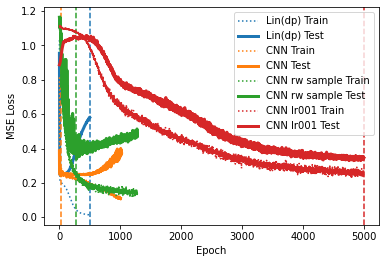

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2880, out_features=10, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [49]:
# make model
seq_len = len(train_df['upstream_region'].values[0])

lr001_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
lr001_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

# run model
lr001_train_losses_cnn, \
lr001_test_losses_cnn,\
estop = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    lr001_cnn, 
    loss_func,
    lr=0.001,
    epochs=5000,
)

lr001_cnn_data_label = [((lr001_train_losses_cnn,lr001_test_losses_cnn),'CNN lr001',estop)]

tu.quick_loss_plot(
    mer8motif_lin_d_data_label+\
    mer8motif_cnn_data_label+\
    mer8motif_cnn_rw_data_label+\
    lr001_cnn_data_label,
    #sparse_n=20
)

lr001_cnn

### slow learning rate and more filters

In [50]:
# make model
seq_len = len(train_df['upstream_region'].values[0])

f128_lr001_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=128,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
f128_lr001_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

# run model
f128_lr001_train_losses_cnn, \
f128_lr001_test_losses_cnn,\
estop = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    f128_lr001_cnn, 
    loss_func,
    lr=0.001,
    epochs=5000,
)

f128_lr001_cnn_data_label = [((f128_lr001_train_losses_cnn,f128_lr001_test_losses_cnn),'CNN f128 lr001',estop)]

tu.quick_loss_plot(
    mer8motif_lin_d_data_label+\
    mer8motif_cnn_data_label+\
    mer8motif_cnn_rw_data_label+\
    lr001_cnn_data_label+\
    f128_lr001_cnn_data_label,
    #sparse_n=20
)
f128_lr001_cnn

E:41 | train loss:1.099 | val loss: 1.258:   1%|          | 42/5000 [00:31<1:03:00,  1.31it/s]

EarlyStopping counter: 1 out of 1000


E:42 | train loss:1.096 | val loss: 1.257:   1%|          | 43/5000 [00:32<1:03:03,  1.31it/s]

EarlyStopping counter: 2 out of 1000


E:45 | train loss:1.098 | val loss: 1.253:   1%|          | 46/5000 [00:34<1:03:01,  1.31it/s]

EarlyStopping counter: 1 out of 1000


E:46 | train loss:1.096 | val loss: 1.254:   1%|          | 47/5000 [00:35<1:02:59,  1.31it/s]

EarlyStopping counter: 2 out of 1000


E:49 | train loss:1.098 | val loss: 1.252:   1%|          | 50/5000 [00:38<1:03:02,  1.31it/s]

EarlyStopping counter: 1 out of 1000


E:50 | train loss:1.095 | val loss: 1.253:   1%|          | 51/5000 [00:38<1:03:03,  1.31it/s]

EarlyStopping counter: 2 out of 1000


E:52 | train loss:1.102 | val loss: 1.249:   1%|          | 53/5000 [00:40<1:03:00,  1.31it/s]

EarlyStopping counter: 1 out of 1000


E:54 | train loss:1.097 | val loss: 1.246:   1%|          | 55/5000 [00:41<1:03:05,  1.31it/s]

EarlyStopping counter: 1 out of 1000


E:57 | train loss:1.096 | val loss: 1.238:   1%|          | 58/5000 [00:44<1:03:07,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:59 | train loss:1.093 | val loss: 1.235:   1%|          | 60/5000 [00:45<1:03:07,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:60 | train loss:1.091 | val loss: 1.235:   1%|          | 61/5000 [00:46<1:03:01,  1.31it/s]

EarlyStopping counter: 2 out of 1000


E:61 | train loss:1.099 | val loss: 1.235:   1%|          | 62/5000 [00:47<1:02:58,  1.31it/s]

EarlyStopping counter: 3 out of 1000


E:63 | train loss:1.094 | val loss: 1.238:   1%|▏         | 64/5000 [00:48<1:02:59,  1.31it/s]

EarlyStopping counter: 1 out of 1000


E:64 | train loss:1.093 | val loss: 1.233:   1%|▏         | 65/5000 [00:49<1:03:02,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:66 | train loss:1.087 | val loss: 1.230:   1%|▏         | 67/5000 [00:51<1:03:10,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:67 | train loss:1.090 | val loss: 1.232:   1%|▏         | 68/5000 [00:51<1:03:12,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:68 | train loss:1.094 | val loss: 1.232:   1%|▏         | 69/5000 [00:52<1:03:08,  1.30it/s]

EarlyStopping counter: 3 out of 1000


E:72 | train loss:1.090 | val loss: 1.220:   1%|▏         | 73/5000 [00:55<1:03:00,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:73 | train loss:1.081 | val loss: 1.220:   1%|▏         | 74/5000 [00:56<1:03:01,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:74 | train loss:1.088 | val loss: 1.222:   2%|▏         | 75/5000 [00:57<1:03:01,  1.30it/s]

EarlyStopping counter: 3 out of 1000


E:78 | train loss:1.086 | val loss: 1.217:   2%|▏         | 79/5000 [01:00<1:03:01,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:79 | train loss:1.084 | val loss: 1.221:   2%|▏         | 80/5000 [01:01<1:03:00,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:80 | train loss:1.080 | val loss: 1.222:   2%|▏         | 81/5000 [01:01<1:02:53,  1.30it/s]

EarlyStopping counter: 3 out of 1000


E:81 | train loss:1.086 | val loss: 1.219:   2%|▏         | 82/5000 [01:02<1:02:55,  1.30it/s]

EarlyStopping counter: 4 out of 1000


E:82 | train loss:1.086 | val loss: 1.220:   2%|▏         | 83/5000 [01:03<1:03:01,  1.30it/s]

EarlyStopping counter: 5 out of 1000


E:83 | train loss:1.084 | val loss: 1.215:   2%|▏         | 84/5000 [01:04<1:02:59,  1.30it/s]

EarlyStopping counter: 6 out of 1000


E:84 | train loss:1.077 | val loss: 1.216:   2%|▏         | 85/5000 [01:04<1:02:59,  1.30it/s]

EarlyStopping counter: 7 out of 1000


E:85 | train loss:1.080 | val loss: 1.219:   2%|▏         | 86/5000 [01:05<1:03:01,  1.30it/s]

EarlyStopping counter: 8 out of 1000


E:90 | train loss:1.077 | val loss: 1.209:   2%|▏         | 91/5000 [01:09<1:02:56,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:91 | train loss:1.079 | val loss: 1.208:   2%|▏         | 92/5000 [01:10<1:02:55,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:94 | train loss:1.072 | val loss: 1.200:   2%|▏         | 95/5000 [01:12<1:02:56,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:97 | train loss:1.077 | val loss: 1.197:   2%|▏         | 98/5000 [01:14<1:02:55,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:98 | train loss:1.076 | val loss: 1.195:   2%|▏         | 99/5000 [01:15<1:02:53,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:100 | train loss:1.071 | val loss: 1.194:   2%|▏         | 101/5000 [01:17<1:02:47,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:102 | train loss:1.086 | val loss: 1.193:   2%|▏         | 103/5000 [01:18<1:02:52,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:103 | train loss:1.073 | val loss: 1.192:   2%|▏         | 104/5000 [01:19<1:02:50,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:104 | train loss:1.067 | val loss: 1.191:   2%|▏         | 105/5000 [01:20<1:02:51,  1.30it/s]

EarlyStopping counter: 3 out of 1000


E:105 | train loss:1.065 | val loss: 1.193:   2%|▏         | 106/5000 [01:21<1:02:45,  1.30it/s]

EarlyStopping counter: 4 out of 1000


E:106 | train loss:1.077 | val loss: 1.194:   2%|▏         | 107/5000 [01:21<1:02:43,  1.30it/s]

EarlyStopping counter: 5 out of 1000


E:107 | train loss:1.073 | val loss: 1.197:   2%|▏         | 108/5000 [01:22<1:02:48,  1.30it/s]

EarlyStopping counter: 6 out of 1000


E:108 | train loss:1.065 | val loss: 1.192:   2%|▏         | 109/5000 [01:23<1:02:47,  1.30it/s]

EarlyStopping counter: 7 out of 1000


E:109 | train loss:1.073 | val loss: 1.190:   2%|▏         | 110/5000 [01:24<1:02:48,  1.30it/s]

EarlyStopping counter: 8 out of 1000


E:110 | train loss:1.076 | val loss: 1.193:   2%|▏         | 111/5000 [01:24<1:02:46,  1.30it/s]

EarlyStopping counter: 9 out of 1000


E:111 | train loss:1.070 | val loss: 1.193:   2%|▏         | 112/5000 [01:25<1:02:41,  1.30it/s]

EarlyStopping counter: 10 out of 1000


E:115 | train loss:1.069 | val loss: 1.183:   2%|▏         | 116/5000 [01:28<1:02:36,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:117 | train loss:1.056 | val loss: 1.175:   2%|▏         | 118/5000 [01:30<1:02:34,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:118 | train loss:1.076 | val loss: 1.176:   2%|▏         | 119/5000 [01:31<1:02:31,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:119 | train loss:1.059 | val loss: 1.175:   2%|▏         | 120/5000 [01:31<1:02:32,  1.30it/s]

EarlyStopping counter: 3 out of 1000


E:122 | train loss:1.057 | val loss: 1.181:   2%|▏         | 123/5000 [01:34<1:02:34,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:123 | train loss:1.052 | val loss: 1.177:   2%|▏         | 124/5000 [01:34<1:02:36,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:124 | train loss:1.066 | val loss: 1.175:   2%|▎         | 125/5000 [01:35<1:02:38,  1.30it/s]

EarlyStopping counter: 3 out of 1000


E:127 | train loss:1.057 | val loss: 1.170:   3%|▎         | 128/5000 [01:38<1:02:39,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:128 | train loss:1.051 | val loss: 1.172:   3%|▎         | 129/5000 [01:38<1:02:39,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:131 | train loss:1.054 | val loss: 1.175:   3%|▎         | 132/5000 [01:41<1:02:31,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:132 | train loss:1.055 | val loss: 1.171:   3%|▎         | 133/5000 [01:41<1:02:36,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:133 | train loss:1.049 | val loss: 1.178:   3%|▎         | 134/5000 [01:42<1:02:37,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:134 | train loss:1.056 | val loss: 1.177:   3%|▎         | 135/5000 [01:43<1:02:33,  1.30it/s]

EarlyStopping counter: 4 out of 1000


E:135 | train loss:1.051 | val loss: 1.169:   3%|▎         | 136/5000 [01:44<1:02:30,  1.30it/s]

EarlyStopping counter: 5 out of 1000


E:136 | train loss:1.051 | val loss: 1.170:   3%|▎         | 137/5000 [01:44<1:02:28,  1.30it/s]

EarlyStopping counter: 6 out of 1000


E:139 | train loss:1.045 | val loss: 1.166:   3%|▎         | 140/5000 [01:47<1:02:24,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:140 | train loss:1.043 | val loss: 1.167:   3%|▎         | 141/5000 [01:48<1:02:23,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:141 | train loss:1.041 | val loss: 1.165:   3%|▎         | 142/5000 [01:48<1:02:24,  1.30it/s]

EarlyStopping counter: 3 out of 1000


E:142 | train loss:1.046 | val loss: 1.174:   3%|▎         | 143/5000 [01:49<1:02:25,  1.30it/s]

EarlyStopping counter: 4 out of 1000


E:143 | train loss:1.046 | val loss: 1.170:   3%|▎         | 144/5000 [01:50<1:02:24,  1.30it/s]

EarlyStopping counter: 5 out of 1000


E:144 | train loss:1.053 | val loss: 1.165:   3%|▎         | 145/5000 [01:51<1:02:25,  1.30it/s]

EarlyStopping counter: 6 out of 1000


E:147 | train loss:1.044 | val loss: 1.163:   3%|▎         | 148/5000 [01:53<1:02:22,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:148 | train loss:1.043 | val loss: 1.162:   3%|▎         | 149/5000 [01:54<1:02:21,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:153 | train loss:1.033 | val loss: 1.147:   3%|▎         | 154/5000 [01:58<1:02:18,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:154 | train loss:1.042 | val loss: 1.153:   3%|▎         | 155/5000 [01:58<1:02:22,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:155 | train loss:1.031 | val loss: 1.157:   3%|▎         | 156/5000 [01:59<1:02:16,  1.30it/s]

EarlyStopping counter: 3 out of 1000


E:156 | train loss:1.035 | val loss: 1.145:   3%|▎         | 157/5000 [02:00<1:02:14,  1.30it/s]

EarlyStopping counter: 4 out of 1000


E:157 | train loss:1.035 | val loss: 1.144:   3%|▎         | 158/5000 [02:01<1:02:14,  1.30it/s]

EarlyStopping counter: 5 out of 1000


E:158 | train loss:1.031 | val loss: 1.143:   3%|▎         | 159/5000 [02:01<1:02:13,  1.30it/s]

EarlyStopping counter: 6 out of 1000


E:159 | train loss:1.025 | val loss: 1.147:   3%|▎         | 160/5000 [02:02<1:02:11,  1.30it/s]

EarlyStopping counter: 7 out of 1000


E:161 | train loss:1.031 | val loss: 1.144:   3%|▎         | 162/5000 [02:04<1:02:13,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:162 | train loss:1.021 | val loss: 1.144:   3%|▎         | 163/5000 [02:05<1:02:12,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:165 | train loss:1.034 | val loss: 1.142:   3%|▎         | 166/5000 [02:07<1:02:15,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:166 | train loss:1.021 | val loss: 1.145:   3%|▎         | 167/5000 [02:08<1:02:12,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:167 | train loss:1.015 | val loss: 1.155:   3%|▎         | 168/5000 [02:08<1:03:56,  1.26it/s]

EarlyStopping counter: 3 out of 1000


E:168 | train loss:1.027 | val loss: 1.147:   3%|▎         | 169/5000 [02:09<1:03:26,  1.27it/s]

EarlyStopping counter: 4 out of 1000


E:169 | train loss:1.018 | val loss: 1.144:   3%|▎         | 170/5000 [02:10<1:03:10,  1.27it/s]

EarlyStopping counter: 5 out of 1000


E:170 | train loss:1.020 | val loss: 1.149:   3%|▎         | 171/5000 [02:11<1:02:56,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:171 | train loss:1.024 | val loss: 1.145:   3%|▎         | 172/5000 [02:12<1:02:47,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:172 | train loss:1.016 | val loss: 1.138:   3%|▎         | 173/5000 [02:12<1:02:40,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:175 | train loss:1.018 | val loss: 1.131:   4%|▎         | 176/5000 [02:15<1:02:30,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:176 | train loss:1.021 | val loss: 1.122:   4%|▎         | 177/5000 [02:15<1:02:23,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:178 | train loss:1.011 | val loss: 1.128:   4%|▎         | 179/5000 [02:17<1:02:26,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:179 | train loss:1.009 | val loss: 1.118:   4%|▎         | 180/5000 [02:18<1:02:19,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:180 | train loss:1.011 | val loss: 1.122:   4%|▎         | 181/5000 [02:19<1:02:08,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:181 | train loss:1.010 | val loss: 1.122:   4%|▎         | 182/5000 [02:19<1:02:10,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:182 | train loss:1.020 | val loss: 1.123:   4%|▎         | 183/5000 [02:20<1:02:12,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:183 | train loss:1.000 | val loss: 1.123:   4%|▎         | 184/5000 [02:21<1:02:11,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:185 | train loss:1.001 | val loss: 1.108:   4%|▎         | 186/5000 [02:22<1:02:16,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:186 | train loss:1.011 | val loss: 1.117:   4%|▎         | 187/5000 [02:23<1:02:15,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:188 | train loss:1.005 | val loss: 1.112:   4%|▍         | 189/5000 [02:25<1:02:11,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:189 | train loss:0.990 | val loss: 1.106:   4%|▍         | 190/5000 [02:26<1:02:12,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:190 | train loss:1.009 | val loss: 1.118:   4%|▍         | 191/5000 [02:26<1:02:12,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:191 | train loss:1.003 | val loss: 1.106:   4%|▍         | 192/5000 [02:27<1:02:11,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:193 | train loss:0.980 | val loss: 1.113:   4%|▍         | 194/5000 [02:29<1:02:11,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:194 | train loss:0.998 | val loss: 1.108:   4%|▍         | 195/5000 [02:29<1:02:09,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:195 | train loss:0.994 | val loss: 1.113:   4%|▍         | 196/5000 [02:30<1:02:11,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:196 | train loss:0.992 | val loss: 1.104:   4%|▍         | 197/5000 [02:31<1:02:14,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:197 | train loss:0.995 | val loss: 1.101:   4%|▍         | 198/5000 [02:32<1:02:12,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:198 | train loss:0.989 | val loss: 1.100:   4%|▍         | 199/5000 [02:33<1:02:14,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:199 | train loss:0.996 | val loss: 1.107:   4%|▍         | 200/5000 [02:33<1:02:07,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:201 | train loss:0.977 | val loss: 1.106:   4%|▍         | 202/5000 [02:35<1:02:10,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:202 | train loss:0.980 | val loss: 1.101:   4%|▍         | 203/5000 [02:36<1:02:03,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:203 | train loss:0.981 | val loss: 1.098:   4%|▍         | 204/5000 [02:36<1:02:04,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:204 | train loss:0.981 | val loss: 1.105:   4%|▍         | 205/5000 [02:37<1:02:03,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:205 | train loss:0.981 | val loss: 1.107:   4%|▍         | 206/5000 [02:38<1:01:56,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:206 | train loss:0.990 | val loss: 1.103:   4%|▍         | 207/5000 [02:39<1:01:52,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:207 | train loss:0.973 | val loss: 1.093:   4%|▍         | 208/5000 [02:40<1:01:55,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:209 | train loss:0.980 | val loss: 1.092:   4%|▍         | 210/5000 [02:41<1:01:58,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:211 | train loss:0.968 | val loss: 1.082:   4%|▍         | 212/5000 [02:43<1:01:56,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:212 | train loss:0.959 | val loss: 1.094:   4%|▍         | 213/5000 [02:43<1:02:02,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:213 | train loss:0.966 | val loss: 1.078:   4%|▍         | 214/5000 [02:44<1:02:02,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:216 | train loss:0.966 | val loss: 1.074:   4%|▍         | 217/5000 [02:47<1:01:54,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:217 | train loss:0.969 | val loss: 1.069:   4%|▍         | 218/5000 [02:47<1:01:55,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:218 | train loss:0.971 | val loss: 1.070:   4%|▍         | 219/5000 [02:48<1:01:51,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:219 | train loss:0.965 | val loss: 1.072:   4%|▍         | 220/5000 [02:49<1:01:47,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:220 | train loss:0.967 | val loss: 1.074:   4%|▍         | 221/5000 [02:50<1:01:51,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:221 | train loss:0.959 | val loss: 1.080:   4%|▍         | 222/5000 [02:50<1:01:54,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:222 | train loss:0.956 | val loss: 1.068:   4%|▍         | 223/5000 [02:51<1:01:55,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:223 | train loss:0.968 | val loss: 1.075:   4%|▍         | 224/5000 [02:52<1:01:53,  1.29it/s]

EarlyStopping counter: 8 out of 1000


E:224 | train loss:0.965 | val loss: 1.090:   4%|▍         | 225/5000 [02:53<1:01:49,  1.29it/s]

EarlyStopping counter: 9 out of 1000


E:225 | train loss:0.969 | val loss: 1.084:   5%|▍         | 226/5000 [02:54<1:01:51,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:226 | train loss:0.951 | val loss: 1.070:   5%|▍         | 227/5000 [02:54<1:01:57,  1.28it/s]

EarlyStopping counter: 11 out of 1000


E:227 | train loss:0.942 | val loss: 1.064:   5%|▍         | 228/5000 [02:55<1:01:54,  1.28it/s]

EarlyStopping counter: 12 out of 1000


E:228 | train loss:0.960 | val loss: 1.062:   5%|▍         | 229/5000 [02:56<1:01:50,  1.29it/s]

EarlyStopping counter: 13 out of 1000


E:229 | train loss:0.951 | val loss: 1.072:   5%|▍         | 230/5000 [02:57<1:01:46,  1.29it/s]

EarlyStopping counter: 14 out of 1000


E:230 | train loss:0.957 | val loss: 1.067:   5%|▍         | 231/5000 [02:57<1:01:47,  1.29it/s]

EarlyStopping counter: 15 out of 1000


E:234 | train loss:0.937 | val loss: 1.072:   5%|▍         | 235/5000 [03:01<1:01:47,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:235 | train loss:0.951 | val loss: 1.068:   5%|▍         | 236/5000 [03:01<1:01:55,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:236 | train loss:0.944 | val loss: 1.065:   5%|▍         | 237/5000 [03:02<1:01:53,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:237 | train loss:0.950 | val loss: 1.052:   5%|▍         | 238/5000 [03:03<1:01:53,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:238 | train loss:0.946 | val loss: 1.055:   5%|▍         | 239/5000 [03:04<1:01:49,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:239 | train loss:0.948 | val loss: 1.050:   5%|▍         | 240/5000 [03:04<1:01:44,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:240 | train loss:0.934 | val loss: 1.047:   5%|▍         | 241/5000 [03:05<1:01:49,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:241 | train loss:0.939 | val loss: 1.057:   5%|▍         | 242/5000 [03:06<1:01:43,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:242 | train loss:0.928 | val loss: 1.054:   5%|▍         | 243/5000 [03:07<1:01:41,  1.29it/s]

EarlyStopping counter: 9 out of 1000


E:243 | train loss:0.933 | val loss: 1.048:   5%|▍         | 244/5000 [03:08<1:01:41,  1.28it/s]

EarlyStopping counter: 10 out of 1000


E:244 | train loss:0.931 | val loss: 1.063:   5%|▍         | 245/5000 [03:08<1:01:39,  1.29it/s]

EarlyStopping counter: 11 out of 1000


E:245 | train loss:0.920 | val loss: 1.059:   5%|▍         | 246/5000 [03:09<1:01:39,  1.29it/s]

EarlyStopping counter: 12 out of 1000


E:246 | train loss:0.929 | val loss: 1.060:   5%|▍         | 247/5000 [03:10<1:01:41,  1.28it/s]

EarlyStopping counter: 13 out of 1000


E:247 | train loss:0.928 | val loss: 1.049:   5%|▍         | 248/5000 [03:11<1:01:39,  1.28it/s]

EarlyStopping counter: 14 out of 1000


E:248 | train loss:0.924 | val loss: 1.055:   5%|▍         | 249/5000 [03:11<1:01:36,  1.29it/s]

EarlyStopping counter: 15 out of 1000


E:249 | train loss:0.920 | val loss: 1.054:   5%|▌         | 250/5000 [03:12<1:01:41,  1.28it/s]

EarlyStopping counter: 16 out of 1000


E:250 | train loss:0.927 | val loss: 1.046:   5%|▌         | 251/5000 [03:13<1:01:35,  1.29it/s]

EarlyStopping counter: 17 out of 1000


E:253 | train loss:0.915 | val loss: 1.035:   5%|▌         | 254/5000 [03:15<1:01:37,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:254 | train loss:0.931 | val loss: 1.042:   5%|▌         | 255/5000 [03:16<1:01:38,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:255 | train loss:0.917 | val loss: 1.038:   5%|▌         | 256/5000 [03:17<1:01:35,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:259 | train loss:0.902 | val loss: 1.031:   5%|▌         | 260/5000 [03:20<1:01:35,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:260 | train loss:0.914 | val loss: 1.026:   5%|▌         | 261/5000 [03:21<1:01:32,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:261 | train loss:0.900 | val loss: 1.024:   5%|▌         | 262/5000 [03:22<1:01:36,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:262 | train loss:0.908 | val loss: 1.041:   5%|▌         | 263/5000 [03:22<1:01:33,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:263 | train loss:0.897 | val loss: 1.043:   5%|▌         | 264/5000 [03:23<1:01:30,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:264 | train loss:0.905 | val loss: 1.025:   5%|▌         | 265/5000 [03:24<1:01:29,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:265 | train loss:0.922 | val loss: 1.032:   5%|▌         | 266/5000 [03:25<1:01:25,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:266 | train loss:0.894 | val loss: 1.035:   5%|▌         | 267/5000 [03:25<1:01:25,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:268 | train loss:0.891 | val loss: 1.024:   5%|▌         | 269/5000 [03:27<1:01:22,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:269 | train loss:0.897 | val loss: 1.030:   5%|▌         | 270/5000 [03:28<1:01:23,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:270 | train loss:0.905 | val loss: 1.021:   5%|▌         | 271/5000 [03:29<1:01:29,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:271 | train loss:0.886 | val loss: 1.019:   5%|▌         | 272/5000 [03:29<1:01:26,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:273 | train loss:0.884 | val loss: 1.013:   5%|▌         | 274/5000 [03:31<1:01:30,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:274 | train loss:0.884 | val loss: 1.011:   6%|▌         | 275/5000 [03:32<1:01:29,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:276 | train loss:0.885 | val loss: 1.013:   6%|▌         | 277/5000 [03:33<1:01:31,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:277 | train loss:0.898 | val loss: 1.012:   6%|▌         | 278/5000 [03:34<1:01:31,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:279 | train loss:0.883 | val loss: 1.015:   6%|▌         | 280/5000 [03:36<1:01:27,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:280 | train loss:0.881 | val loss: 1.018:   6%|▌         | 281/5000 [03:36<1:01:24,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:281 | train loss:0.874 | val loss: 1.014:   6%|▌         | 282/5000 [03:37<1:01:20,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:282 | train loss:0.885 | val loss: 1.010:   6%|▌         | 283/5000 [03:38<1:01:25,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:283 | train loss:0.869 | val loss: 1.024:   6%|▌         | 284/5000 [03:39<1:01:20,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:284 | train loss:0.873 | val loss: 1.014:   6%|▌         | 285/5000 [03:40<1:01:13,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:287 | train loss:0.876 | val loss: 1.017:   6%|▌         | 288/5000 [03:42<1:01:15,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:288 | train loss:0.864 | val loss: 1.011:   6%|▌         | 289/5000 [03:43<1:01:17,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:289 | train loss:0.861 | val loss: 1.005:   6%|▌         | 290/5000 [03:43<1:01:15,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:290 | train loss:0.869 | val loss: 1.002:   6%|▌         | 291/5000 [03:44<1:01:12,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:291 | train loss:0.858 | val loss: 1.007:   6%|▌         | 292/5000 [03:45<1:01:11,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:292 | train loss:0.859 | val loss: 1.016:   6%|▌         | 293/5000 [03:46<1:01:10,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:296 | train loss:0.862 | val loss: 0.998:   6%|▌         | 297/5000 [03:49<1:01:08,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:298 | train loss:0.849 | val loss: 0.994:   6%|▌         | 299/5000 [03:50<1:01:16,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:299 | train loss:0.852 | val loss: 0.996:   6%|▌         | 300/5000 [03:51<1:01:17,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:300 | train loss:0.863 | val loss: 0.993:   6%|▌         | 301/5000 [03:52<1:01:14,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:301 | train loss:0.858 | val loss: 0.995:   6%|▌         | 302/5000 [03:53<1:01:09,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:302 | train loss:0.840 | val loss: 0.996:   6%|▌         | 303/5000 [03:54<1:01:08,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:303 | train loss:0.837 | val loss: 0.989:   6%|▌         | 304/5000 [03:54<1:01:05,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:304 | train loss:0.841 | val loss: 0.991:   6%|▌         | 305/5000 [03:55<1:01:09,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:305 | train loss:0.841 | val loss: 0.990:   6%|▌         | 306/5000 [03:56<1:01:04,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:306 | train loss:0.835 | val loss: 0.991:   6%|▌         | 307/5000 [03:57<1:00:59,  1.28it/s]

EarlyStopping counter: 9 out of 1000


E:308 | train loss:0.835 | val loss: 0.988:   6%|▌         | 309/5000 [03:58<1:00:58,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:309 | train loss:0.849 | val loss: 0.982:   6%|▌         | 310/5000 [03:59<1:00:57,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:310 | train loss:0.846 | val loss: 0.981:   6%|▌         | 311/5000 [04:00<1:00:51,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:311 | train loss:0.836 | val loss: 0.989:   6%|▌         | 312/5000 [04:01<1:00:49,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:312 | train loss:0.832 | val loss: 0.984:   6%|▋         | 313/5000 [04:01<1:00:53,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:313 | train loss:0.845 | val loss: 0.993:   6%|▋         | 314/5000 [04:02<1:00:51,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:314 | train loss:0.831 | val loss: 0.985:   6%|▋         | 315/5000 [04:03<1:00:53,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:315 | train loss:0.837 | val loss: 0.982:   6%|▋         | 316/5000 [04:04<1:00:46,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:319 | train loss:0.817 | val loss: 0.976:   6%|▋         | 320/5000 [04:07<1:00:41,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:320 | train loss:0.831 | val loss: 0.983:   6%|▋         | 321/5000 [04:08<1:00:37,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:322 | train loss:0.824 | val loss: 0.966:   6%|▋         | 323/5000 [04:09<1:00:40,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:324 | train loss:0.815 | val loss: 0.978:   6%|▋         | 325/5000 [04:11<1:00:33,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:325 | train loss:0.809 | val loss: 0.970:   7%|▋         | 326/5000 [04:11<1:00:31,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:326 | train loss:0.814 | val loss: 0.969:   7%|▋         | 327/5000 [04:12<1:00:30,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:327 | train loss:0.821 | val loss: 0.959:   7%|▋         | 328/5000 [04:13<1:00:27,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:330 | train loss:0.824 | val loss: 0.955:   7%|▋         | 331/5000 [04:15<1:00:23,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:331 | train loss:0.818 | val loss: 0.966:   7%|▋         | 332/5000 [04:16<1:00:23,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:333 | train loss:0.810 | val loss: 0.952:   7%|▋         | 334/5000 [04:18<1:00:25,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:334 | train loss:0.809 | val loss: 0.951:   7%|▋         | 335/5000 [04:18<1:00:21,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:336 | train loss:0.811 | val loss: 0.949:   7%|▋         | 337/5000 [04:20<1:00:23,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:337 | train loss:0.799 | val loss: 0.958:   7%|▋         | 338/5000 [04:21<1:00:22,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:339 | train loss:0.807 | val loss: 0.952:   7%|▋         | 340/5000 [04:22<1:00:18,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:340 | train loss:0.815 | val loss: 0.939:   7%|▋         | 341/5000 [04:23<1:00:16,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:341 | train loss:0.803 | val loss: 0.934:   7%|▋         | 342/5000 [04:24<1:00:14,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:342 | train loss:0.790 | val loss: 0.942:   7%|▋         | 343/5000 [04:25<1:00:10,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:344 | train loss:0.782 | val loss: 0.940:   7%|▋         | 345/5000 [04:26<1:00:03,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:345 | train loss:0.795 | val loss: 0.939:   7%|▋         | 346/5000 [04:27<1:00:03,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:346 | train loss:0.791 | val loss: 0.943:   7%|▋         | 347/5000 [04:28<1:00:07,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:347 | train loss:0.791 | val loss: 0.940:   7%|▋         | 348/5000 [04:29<1:00:09,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:348 | train loss:0.770 | val loss: 0.954:   7%|▋         | 349/5000 [04:29<1:00:06,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:349 | train loss:0.774 | val loss: 0.942:   7%|▋         | 350/5000 [04:30<1:00:02,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:350 | train loss:0.786 | val loss: 0.927:   7%|▋         | 351/5000 [04:31<1:00:00,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:351 | train loss:0.778 | val loss: 0.945:   7%|▋         | 352/5000 [04:32<1:00:00,  1.29it/s]

EarlyStopping counter: 8 out of 1000


E:352 | train loss:0.773 | val loss: 0.933:   7%|▋         | 353/5000 [04:32<1:00:04,  1.29it/s]

EarlyStopping counter: 9 out of 1000


E:353 | train loss:0.781 | val loss: 0.938:   7%|▋         | 354/5000 [04:33<1:00:04,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:354 | train loss:0.763 | val loss: 0.934:   7%|▋         | 355/5000 [04:34<1:00:06,  1.29it/s]

EarlyStopping counter: 11 out of 1000


E:356 | train loss:0.773 | val loss: 0.934:   7%|▋         | 357/5000 [04:36<1:00:08,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:359 | train loss:0.784 | val loss: 0.917:   7%|▋         | 360/5000 [04:38<59:53,  1.29it/s]  

EarlyStopping counter: 1 out of 1000


E:360 | train loss:0.759 | val loss: 0.920:   7%|▋         | 361/5000 [04:39<59:50,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:361 | train loss:0.761 | val loss: 0.912:   7%|▋         | 362/5000 [04:39<59:47,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:363 | train loss:0.774 | val loss: 0.911:   7%|▋         | 364/5000 [04:41<59:42,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:365 | train loss:0.757 | val loss: 0.911:   7%|▋         | 366/5000 [04:42<59:41,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:366 | train loss:0.759 | val loss: 0.915:   7%|▋         | 367/5000 [04:43<59:39,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:367 | train loss:0.766 | val loss: 0.921:   7%|▋         | 368/5000 [04:44<59:47,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:369 | train loss:0.750 | val loss: 0.907:   7%|▋         | 370/5000 [04:46<59:41,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:370 | train loss:0.759 | val loss: 0.910:   7%|▋         | 371/5000 [04:46<59:38,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:371 | train loss:0.764 | val loss: 0.904:   7%|▋         | 372/5000 [04:47<59:37,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:372 | train loss:0.743 | val loss: 0.912:   7%|▋         | 373/5000 [04:48<59:34,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:373 | train loss:0.763 | val loss: 0.919:   7%|▋         | 374/5000 [04:49<59:37,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:374 | train loss:0.765 | val loss: 0.909:   8%|▊         | 375/5000 [04:49<59:35,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:375 | train loss:0.754 | val loss: 0.908:   8%|▊         | 376/5000 [04:50<59:35,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:376 | train loss:0.765 | val loss: 0.915:   8%|▊         | 377/5000 [04:51<59:35,  1.29it/s]

EarlyStopping counter: 8 out of 1000


E:377 | train loss:0.741 | val loss: 0.906:   8%|▊         | 378/5000 [04:52<59:30,  1.29it/s]

EarlyStopping counter: 9 out of 1000


E:378 | train loss:0.740 | val loss: 0.906:   8%|▊         | 379/5000 [04:53<59:29,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:379 | train loss:0.762 | val loss: 0.904:   8%|▊         | 380/5000 [04:53<59:28,  1.29it/s]

EarlyStopping counter: 11 out of 1000


E:381 | train loss:0.738 | val loss: 0.899:   8%|▊         | 382/5000 [04:55<59:30,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:382 | train loss:0.748 | val loss: 0.899:   8%|▊         | 383/5000 [04:56<59:32,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:383 | train loss:0.731 | val loss: 0.916:   8%|▊         | 384/5000 [04:56<59:30,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:384 | train loss:0.736 | val loss: 0.901:   8%|▊         | 385/5000 [04:57<59:30,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:385 | train loss:0.730 | val loss: 0.904:   8%|▊         | 386/5000 [04:58<59:25,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:387 | train loss:0.724 | val loss: 0.903:   8%|▊         | 388/5000 [04:59<59:20,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:388 | train loss:0.739 | val loss: 0.911:   8%|▊         | 389/5000 [05:00<59:19,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:390 | train loss:0.728 | val loss: 0.901:   8%|▊         | 391/5000 [05:02<59:23,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:391 | train loss:0.721 | val loss: 0.901:   8%|▊         | 392/5000 [05:03<59:15,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:392 | train loss:0.734 | val loss: 0.887:   8%|▊         | 393/5000 [05:03<59:13,  1.30it/s]

EarlyStopping counter: 3 out of 1000


E:393 | train loss:0.733 | val loss: 0.884:   8%|▊         | 394/5000 [05:04<59:11,  1.30it/s]

EarlyStopping counter: 4 out of 1000


E:394 | train loss:0.736 | val loss: 0.893:   8%|▊         | 395/5000 [05:05<59:11,  1.30it/s]

EarlyStopping counter: 5 out of 1000


E:395 | train loss:0.741 | val loss: 0.888:   8%|▊         | 396/5000 [05:06<59:14,  1.30it/s]

EarlyStopping counter: 6 out of 1000


E:396 | train loss:0.744 | val loss: 0.894:   8%|▊         | 397/5000 [05:06<59:13,  1.30it/s]

EarlyStopping counter: 7 out of 1000


E:397 | train loss:0.722 | val loss: 0.897:   8%|▊         | 398/5000 [05:07<59:10,  1.30it/s]

EarlyStopping counter: 8 out of 1000


E:399 | train loss:0.719 | val loss: 0.888:   8%|▊         | 400/5000 [05:09<59:12,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:400 | train loss:0.722 | val loss: 0.893:   8%|▊         | 401/5000 [05:10<59:14,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:401 | train loss:0.719 | val loss: 0.886:   8%|▊         | 402/5000 [05:10<59:18,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:402 | train loss:0.719 | val loss: 0.881:   8%|▊         | 403/5000 [05:11<59:17,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:403 | train loss:0.719 | val loss: 0.884:   8%|▊         | 404/5000 [05:12<59:19,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:405 | train loss:0.717 | val loss: 0.879:   8%|▊         | 406/5000 [05:13<59:12,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:406 | train loss:0.711 | val loss: 0.873:   8%|▊         | 407/5000 [05:14<59:13,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:407 | train loss:0.714 | val loss: 0.880:   8%|▊         | 408/5000 [05:15<59:10,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:410 | train loss:0.721 | val loss: 0.885:   8%|▊         | 411/5000 [05:17<59:10,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:411 | train loss:0.705 | val loss: 0.877:   8%|▊         | 412/5000 [05:18<59:08,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:412 | train loss:0.718 | val loss: 0.877:   8%|▊         | 413/5000 [05:19<59:05,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:413 | train loss:0.703 | val loss: 0.867:   8%|▊         | 414/5000 [05:20<59:04,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:414 | train loss:0.686 | val loss: 0.869:   8%|▊         | 415/5000 [05:20<59:06,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:415 | train loss:0.702 | val loss: 0.859:   8%|▊         | 416/5000 [05:21<59:01,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:416 | train loss:0.703 | val loss: 0.859:   8%|▊         | 417/5000 [05:22<59:02,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:417 | train loss:0.708 | val loss: 0.871:   8%|▊         | 418/5000 [05:23<59:07,  1.29it/s]

EarlyStopping counter: 8 out of 1000


E:419 | train loss:0.720 | val loss: 0.874:   8%|▊         | 420/5000 [05:24<59:05,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:422 | train loss:0.706 | val loss: 0.856:   8%|▊         | 423/5000 [05:27<59:14,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:423 | train loss:0.709 | val loss: 0.879:   8%|▊         | 424/5000 [05:27<59:12,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:424 | train loss:0.697 | val loss: 0.855:   8%|▊         | 425/5000 [05:28<59:08,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:425 | train loss:0.703 | val loss: 0.850:   9%|▊         | 426/5000 [05:29<59:10,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:426 | train loss:0.701 | val loss: 0.858:   9%|▊         | 427/5000 [05:30<59:10,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:427 | train loss:0.703 | val loss: 0.859:   9%|▊         | 428/5000 [05:30<59:04,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:428 | train loss:0.678 | val loss: 0.861:   9%|▊         | 429/5000 [05:31<59:02,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:431 | train loss:0.706 | val loss: 0.845:   9%|▊         | 432/5000 [05:34<58:57,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:432 | train loss:0.692 | val loss: 0.851:   9%|▊         | 433/5000 [05:34<58:58,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:433 | train loss:0.704 | val loss: 0.847:   9%|▊         | 434/5000 [05:35<59:00,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:434 | train loss:0.696 | val loss: 0.857:   9%|▊         | 435/5000 [05:36<59:00,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:435 | train loss:0.705 | val loss: 0.858:   9%|▊         | 436/5000 [05:37<59:01,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:436 | train loss:0.694 | val loss: 0.843:   9%|▊         | 437/5000 [05:37<59:03,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:437 | train loss:0.693 | val loss: 0.848:   9%|▉         | 438/5000 [05:38<59:03,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:438 | train loss:0.683 | val loss: 0.853:   9%|▉         | 439/5000 [05:39<59:02,  1.29it/s]

EarlyStopping counter: 8 out of 1000


E:439 | train loss:0.677 | val loss: 0.845:   9%|▉         | 440/5000 [05:40<59:07,  1.29it/s]

EarlyStopping counter: 9 out of 1000


E:440 | train loss:0.690 | val loss: 0.846:   9%|▉         | 441/5000 [05:41<59:06,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:441 | train loss:0.690 | val loss: 0.845:   9%|▉         | 442/5000 [05:41<59:01,  1.29it/s]

EarlyStopping counter: 11 out of 1000


E:442 | train loss:0.679 | val loss: 0.843:   9%|▉         | 443/5000 [05:42<59:05,  1.29it/s]

EarlyStopping counter: 12 out of 1000


E:443 | train loss:0.671 | val loss: 0.847:   9%|▉         | 444/5000 [05:43<59:02,  1.29it/s]

EarlyStopping counter: 13 out of 1000


E:444 | train loss:0.678 | val loss: 0.844:   9%|▉         | 445/5000 [05:44<58:59,  1.29it/s]

EarlyStopping counter: 14 out of 1000


E:445 | train loss:0.690 | val loss: 0.845:   9%|▉         | 446/5000 [05:44<58:54,  1.29it/s]

EarlyStopping counter: 15 out of 1000


E:447 | train loss:0.678 | val loss: 0.842:   9%|▉         | 448/5000 [05:46<58:58,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:450 | train loss:0.671 | val loss: 0.832:   9%|▉         | 451/5000 [05:48<58:53,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:451 | train loss:0.661 | val loss: 0.860:   9%|▉         | 452/5000 [05:49<58:54,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:452 | train loss:0.678 | val loss: 0.829:   9%|▉         | 453/5000 [05:50<58:54,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:453 | train loss:0.667 | val loss: 0.829:   9%|▉         | 454/5000 [05:51<58:55,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:454 | train loss:0.678 | val loss: 0.838:   9%|▉         | 455/5000 [05:51<58:56,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:455 | train loss:0.698 | val loss: 0.830:   9%|▉         | 456/5000 [05:52<58:52,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:457 | train loss:0.681 | val loss: 0.832:   9%|▉         | 458/5000 [05:54<58:48,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:458 | train loss:0.681 | val loss: 0.827:   9%|▉         | 459/5000 [05:55<58:49,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:459 | train loss:0.662 | val loss: 0.834:   9%|▉         | 460/5000 [05:55<58:47,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:460 | train loss:0.658 | val loss: 0.838:   9%|▉         | 461/5000 [05:56<58:46,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:462 | train loss:0.660 | val loss: 0.823:   9%|▉         | 463/5000 [05:58<58:46,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:463 | train loss:0.684 | val loss: 0.829:   9%|▉         | 464/5000 [05:58<58:46,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:464 | train loss:0.639 | val loss: 0.842:   9%|▉         | 465/5000 [05:59<58:47,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:465 | train loss:0.669 | val loss: 0.824:   9%|▉         | 466/5000 [06:00<58:42,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:467 | train loss:0.672 | val loss: 0.824:   9%|▉         | 468/5000 [06:02<58:40,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:468 | train loss:0.669 | val loss: 0.827:   9%|▉         | 469/5000 [06:02<58:42,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:469 | train loss:0.663 | val loss: 0.842:   9%|▉         | 470/5000 [06:03<58:42,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:470 | train loss:0.643 | val loss: 0.817:   9%|▉         | 471/5000 [06:04<58:39,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:471 | train loss:0.657 | val loss: 0.813:   9%|▉         | 472/5000 [06:05<58:40,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:473 | train loss:0.661 | val loss: 0.819:   9%|▉         | 474/5000 [06:06<58:39,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:474 | train loss:0.662 | val loss: 0.820:  10%|▉         | 475/5000 [06:07<58:43,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:475 | train loss:0.678 | val loss: 0.816:  10%|▉         | 476/5000 [06:08<58:41,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:477 | train loss:0.639 | val loss: 0.807:  10%|▉         | 478/5000 [06:09<58:43,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:478 | train loss:0.689 | val loss: 0.821:  10%|▉         | 479/5000 [06:10<58:40,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:479 | train loss:0.671 | val loss: 0.820:  10%|▉         | 480/5000 [06:11<58:39,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:480 | train loss:0.642 | val loss: 0.818:  10%|▉         | 481/5000 [06:12<58:39,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:481 | train loss:0.654 | val loss: 0.816:  10%|▉         | 482/5000 [06:12<58:37,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:483 | train loss:0.656 | val loss: 0.810:  10%|▉         | 484/5000 [06:14<58:38,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:484 | train loss:0.651 | val loss: 0.817:  10%|▉         | 485/5000 [06:15<58:35,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:485 | train loss:0.669 | val loss: 0.816:  10%|▉         | 486/5000 [06:16<58:39,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:486 | train loss:0.642 | val loss: 0.807:  10%|▉         | 487/5000 [06:16<58:36,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:487 | train loss:0.637 | val loss: 0.808:  10%|▉         | 488/5000 [06:17<58:36,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:488 | train loss:0.674 | val loss: 0.835:  10%|▉         | 489/5000 [06:18<58:31,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:489 | train loss:0.646 | val loss: 0.821:  10%|▉         | 490/5000 [06:19<58:30,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:490 | train loss:0.667 | val loss: 0.809:  10%|▉         | 491/5000 [06:19<58:30,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:491 | train loss:0.646 | val loss: 0.818:  10%|▉         | 492/5000 [06:20<58:31,  1.28it/s]

EarlyStopping counter: 9 out of 1000


E:492 | train loss:0.655 | val loss: 0.820:  10%|▉         | 493/5000 [06:21<58:30,  1.28it/s]

EarlyStopping counter: 10 out of 1000


E:493 | train loss:0.645 | val loss: 0.818:  10%|▉         | 494/5000 [06:22<58:32,  1.28it/s]

EarlyStopping counter: 11 out of 1000


E:494 | train loss:0.641 | val loss: 0.804:  10%|▉         | 495/5000 [06:23<58:27,  1.28it/s]

EarlyStopping counter: 12 out of 1000


E:495 | train loss:0.645 | val loss: 0.802:  10%|▉         | 496/5000 [06:23<58:29,  1.28it/s]

EarlyStopping counter: 13 out of 1000


E:496 | train loss:0.634 | val loss: 0.818:  10%|▉         | 497/5000 [06:24<58:28,  1.28it/s]

EarlyStopping counter: 14 out of 1000


E:497 | train loss:0.627 | val loss: 0.811:  10%|▉         | 498/5000 [06:25<58:27,  1.28it/s]

EarlyStopping counter: 15 out of 1000


E:498 | train loss:0.640 | val loss: 0.803:  10%|▉         | 499/5000 [06:26<58:33,  1.28it/s]

EarlyStopping counter: 16 out of 1000


E:500 | train loss:0.651 | val loss: 0.806:  10%|█         | 501/5000 [06:27<58:33,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:501 | train loss:0.654 | val loss: 0.804:  10%|█         | 502/5000 [06:28<58:31,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:502 | train loss:0.642 | val loss: 0.813:  10%|█         | 503/5000 [06:29<58:31,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:503 | train loss:0.649 | val loss: 0.806:  10%|█         | 504/5000 [06:30<58:27,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:504 | train loss:0.646 | val loss: 0.804:  10%|█         | 505/5000 [06:30<58:24,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:505 | train loss:0.641 | val loss: 0.811:  10%|█         | 506/5000 [06:31<58:27,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:506 | train loss:0.632 | val loss: 0.801:  10%|█         | 507/5000 [06:32<58:22,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:507 | train loss:0.634 | val loss: 0.812:  10%|█         | 508/5000 [06:33<58:30,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:510 | train loss:0.628 | val loss: 0.801:  10%|█         | 511/5000 [06:35<58:21,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:511 | train loss:0.634 | val loss: 0.794:  10%|█         | 512/5000 [06:36<58:21,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:513 | train loss:0.623 | val loss: 0.789:  10%|█         | 514/5000 [06:37<58:16,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:514 | train loss:0.629 | val loss: 0.799:  10%|█         | 515/5000 [06:38<58:16,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:515 | train loss:0.653 | val loss: 0.788:  10%|█         | 516/5000 [06:39<58:13,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:516 | train loss:0.626 | val loss: 0.807:  10%|█         | 517/5000 [06:40<58:12,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:517 | train loss:0.625 | val loss: 0.801:  10%|█         | 518/5000 [06:40<58:10,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:518 | train loss:0.621 | val loss: 0.803:  10%|█         | 519/5000 [06:41<58:11,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:519 | train loss:0.629 | val loss: 0.801:  10%|█         | 520/5000 [06:42<58:15,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:520 | train loss:0.603 | val loss: 0.801:  10%|█         | 521/5000 [06:43<58:11,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:521 | train loss:0.650 | val loss: 0.791:  10%|█         | 522/5000 [06:44<58:09,  1.28it/s]

EarlyStopping counter: 9 out of 1000


E:522 | train loss:0.622 | val loss: 0.795:  10%|█         | 523/5000 [06:44<58:11,  1.28it/s]

EarlyStopping counter: 10 out of 1000


E:523 | train loss:0.640 | val loss: 0.785:  10%|█         | 524/5000 [06:45<58:07,  1.28it/s]

EarlyStopping counter: 11 out of 1000


E:524 | train loss:0.620 | val loss: 0.788:  10%|█         | 525/5000 [06:46<58:08,  1.28it/s]

EarlyStopping counter: 12 out of 1000


E:525 | train loss:0.609 | val loss: 0.792:  11%|█         | 526/5000 [06:47<58:06,  1.28it/s]

EarlyStopping counter: 13 out of 1000


E:527 | train loss:0.609 | val loss: 0.785:  11%|█         | 528/5000 [06:48<58:02,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:528 | train loss:0.619 | val loss: 0.793:  11%|█         | 529/5000 [06:49<58:01,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:529 | train loss:0.624 | val loss: 0.785:  11%|█         | 530/5000 [06:50<57:59,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:530 | train loss:0.644 | val loss: 0.784:  11%|█         | 531/5000 [06:51<58:02,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:531 | train loss:0.611 | val loss: 0.796:  11%|█         | 532/5000 [06:51<57:59,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:532 | train loss:0.626 | val loss: 0.790:  11%|█         | 533/5000 [06:52<57:59,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:533 | train loss:0.609 | val loss: 0.788:  11%|█         | 534/5000 [06:53<58:01,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:534 | train loss:0.607 | val loss: 0.781:  11%|█         | 535/5000 [06:54<57:58,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:536 | train loss:0.609 | val loss: 0.774:  11%|█         | 537/5000 [06:55<57:59,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:537 | train loss:0.629 | val loss: 0.782:  11%|█         | 538/5000 [06:56<57:56,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:538 | train loss:0.608 | val loss: 0.784:  11%|█         | 539/5000 [06:57<57:55,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:539 | train loss:0.617 | val loss: 0.781:  11%|█         | 540/5000 [06:58<57:58,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:540 | train loss:0.642 | val loss: 0.783:  11%|█         | 541/5000 [06:58<57:59,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:541 | train loss:0.614 | val loss: 0.786:  11%|█         | 542/5000 [06:59<58:04,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:543 | train loss:0.598 | val loss: 0.776:  11%|█         | 544/5000 [07:01<57:55,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:545 | train loss:0.616 | val loss: 0.763:  11%|█         | 546/5000 [07:02<57:55,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:546 | train loss:0.638 | val loss: 0.765:  11%|█         | 547/5000 [07:03<57:57,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:547 | train loss:0.603 | val loss: 0.762:  11%|█         | 548/5000 [07:04<57:54,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:550 | train loss:0.604 | val loss: 0.755:  11%|█         | 551/5000 [07:06<57:51,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:551 | train loss:0.608 | val loss: 0.758:  11%|█         | 552/5000 [07:07<57:54,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:552 | train loss:0.618 | val loss: 0.766:  11%|█         | 553/5000 [07:08<57:50,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:553 | train loss:0.607 | val loss: 0.761:  11%|█         | 554/5000 [07:09<57:47,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:554 | train loss:0.614 | val loss: 0.776:  11%|█         | 555/5000 [07:09<57:49,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:555 | train loss:0.634 | val loss: 0.770:  11%|█         | 556/5000 [07:10<57:45,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:556 | train loss:0.601 | val loss: 0.768:  11%|█         | 557/5000 [07:11<57:40,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:557 | train loss:0.620 | val loss: 0.771:  11%|█         | 558/5000 [07:12<57:50,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:558 | train loss:0.607 | val loss: 0.776:  11%|█         | 559/5000 [07:12<57:47,  1.28it/s]

EarlyStopping counter: 9 out of 1000


E:559 | train loss:0.613 | val loss: 0.756:  11%|█         | 560/5000 [07:13<57:41,  1.28it/s]

EarlyStopping counter: 10 out of 1000


E:560 | train loss:0.605 | val loss: 0.765:  11%|█         | 561/5000 [07:14<57:39,  1.28it/s]

EarlyStopping counter: 11 out of 1000


E:561 | train loss:0.602 | val loss: 0.773:  11%|█         | 562/5000 [07:15<57:38,  1.28it/s]

EarlyStopping counter: 12 out of 1000


E:562 | train loss:0.596 | val loss: 0.751:  11%|█▏        | 563/5000 [07:16<57:37,  1.28it/s]

EarlyStopping counter: 13 out of 1000


E:563 | train loss:0.600 | val loss: 0.763:  11%|█▏        | 564/5000 [07:16<57:37,  1.28it/s]

EarlyStopping counter: 14 out of 1000


E:564 | train loss:0.620 | val loss: 0.747:  11%|█▏        | 565/5000 [07:17<57:35,  1.28it/s]

EarlyStopping counter: 15 out of 1000


E:565 | train loss:0.609 | val loss: 0.767:  11%|█▏        | 566/5000 [07:18<57:37,  1.28it/s]

EarlyStopping counter: 16 out of 1000


E:566 | train loss:0.593 | val loss: 0.761:  11%|█▏        | 567/5000 [07:19<57:33,  1.28it/s]

EarlyStopping counter: 17 out of 1000


E:567 | train loss:0.623 | val loss: 0.756:  11%|█▏        | 568/5000 [07:19<57:33,  1.28it/s]

EarlyStopping counter: 18 out of 1000


E:568 | train loss:0.599 | val loss: 0.747:  11%|█▏        | 569/5000 [07:20<57:36,  1.28it/s]

EarlyStopping counter: 19 out of 1000


E:569 | train loss:0.601 | val loss: 0.750:  11%|█▏        | 570/5000 [07:21<57:38,  1.28it/s]

EarlyStopping counter: 20 out of 1000


E:571 | train loss:0.600 | val loss: 0.749:  11%|█▏        | 572/5000 [07:23<57:36,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:573 | train loss:0.587 | val loss: 0.750:  11%|█▏        | 574/5000 [07:24<57:38,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:574 | train loss:0.593 | val loss: 0.748:  12%|█▏        | 575/5000 [07:25<57:37,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:575 | train loss:0.590 | val loss: 0.740:  12%|█▏        | 576/5000 [07:26<57:36,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:576 | train loss:0.599 | val loss: 0.742:  12%|█▏        | 577/5000 [07:27<57:38,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:577 | train loss:0.575 | val loss: 0.767:  12%|█▏        | 578/5000 [07:27<57:31,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:578 | train loss:0.593 | val loss: 0.746:  12%|█▏        | 579/5000 [07:28<57:31,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:579 | train loss:0.592 | val loss: 0.736:  12%|█▏        | 580/5000 [07:29<57:28,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:580 | train loss:0.611 | val loss: 0.736:  12%|█▏        | 581/5000 [07:30<57:26,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:581 | train loss:0.594 | val loss: 0.743:  12%|█▏        | 582/5000 [07:30<57:19,  1.28it/s]

EarlyStopping counter: 9 out of 1000


E:582 | train loss:0.602 | val loss: 0.747:  12%|█▏        | 583/5000 [07:31<57:13,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:583 | train loss:0.578 | val loss: 0.744:  12%|█▏        | 584/5000 [07:32<56:58,  1.29it/s]

EarlyStopping counter: 11 out of 1000


E:584 | train loss:0.584 | val loss: 0.762:  12%|█▏        | 585/5000 [07:33<56:56,  1.29it/s]

EarlyStopping counter: 12 out of 1000


E:585 | train loss:0.604 | val loss: 0.750:  12%|█▏        | 586/5000 [07:33<56:45,  1.30it/s]

EarlyStopping counter: 13 out of 1000


E:586 | train loss:0.577 | val loss: 0.735:  12%|█▏        | 587/5000 [07:34<56:43,  1.30it/s]

EarlyStopping counter: 14 out of 1000


E:588 | train loss:0.586 | val loss: 0.746:  12%|█▏        | 589/5000 [07:36<56:27,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:589 | train loss:0.588 | val loss: 0.753:  12%|█▏        | 590/5000 [07:37<56:17,  1.31it/s]

EarlyStopping counter: 2 out of 1000


E:590 | train loss:0.585 | val loss: 0.751:  12%|█▏        | 591/5000 [07:37<56:08,  1.31it/s]

EarlyStopping counter: 3 out of 1000


E:591 | train loss:0.561 | val loss: 0.744:  12%|█▏        | 592/5000 [07:38<56:07,  1.31it/s]

EarlyStopping counter: 4 out of 1000


E:592 | train loss:0.592 | val loss: 0.734:  12%|█▏        | 593/5000 [07:39<55:59,  1.31it/s]

EarlyStopping counter: 5 out of 1000


E:593 | train loss:0.598 | val loss: 0.755:  12%|█▏        | 594/5000 [07:40<55:50,  1.32it/s]

EarlyStopping counter: 6 out of 1000


E:594 | train loss:0.594 | val loss: 0.739:  12%|█▏        | 595/5000 [07:40<55:44,  1.32it/s]

EarlyStopping counter: 7 out of 1000


E:595 | train loss:0.591 | val loss: 0.734:  12%|█▏        | 596/5000 [07:41<55:39,  1.32it/s]

EarlyStopping counter: 8 out of 1000


E:596 | train loss:0.573 | val loss: 0.733:  12%|█▏        | 597/5000 [07:42<55:37,  1.32it/s]

EarlyStopping counter: 9 out of 1000


E:597 | train loss:0.584 | val loss: 0.726:  12%|█▏        | 598/5000 [07:43<55:28,  1.32it/s]

EarlyStopping counter: 10 out of 1000


E:598 | train loss:0.577 | val loss: 0.739:  12%|█▏        | 599/5000 [07:43<55:23,  1.32it/s]

EarlyStopping counter: 11 out of 1000


E:599 | train loss:0.593 | val loss: 0.740:  12%|█▏        | 600/5000 [07:44<55:19,  1.33it/s]

EarlyStopping counter: 12 out of 1000


E:601 | train loss:0.564 | val loss: 0.727:  12%|█▏        | 602/5000 [07:46<55:10,  1.33it/s]

EarlyStopping counter: 1 out of 1000


E:602 | train loss:0.592 | val loss: 0.734:  12%|█▏        | 603/5000 [07:46<55:09,  1.33it/s]

EarlyStopping counter: 2 out of 1000


E:603 | train loss:0.562 | val loss: 0.748:  12%|█▏        | 604/5000 [07:47<55:00,  1.33it/s]

EarlyStopping counter: 3 out of 1000


E:604 | train loss:0.584 | val loss: 0.751:  12%|█▏        | 605/5000 [07:48<55:00,  1.33it/s]

EarlyStopping counter: 4 out of 1000


E:605 | train loss:0.565 | val loss: 0.724:  12%|█▏        | 606/5000 [07:49<54:58,  1.33it/s]

EarlyStopping counter: 5 out of 1000


E:606 | train loss:0.585 | val loss: 0.735:  12%|█▏        | 607/5000 [07:49<54:54,  1.33it/s]

EarlyStopping counter: 6 out of 1000


E:608 | train loss:0.569 | val loss: 0.746:  12%|█▏        | 609/5000 [07:51<54:52,  1.33it/s]

EarlyStopping counter: 1 out of 1000


E:609 | train loss:0.562 | val loss: 0.721:  12%|█▏        | 610/5000 [07:52<54:50,  1.33it/s]

EarlyStopping counter: 2 out of 1000


E:610 | train loss:0.586 | val loss: 0.731:  12%|█▏        | 611/5000 [07:52<54:45,  1.34it/s]

EarlyStopping counter: 3 out of 1000


E:611 | train loss:0.582 | val loss: 0.723:  12%|█▏        | 612/5000 [07:53<54:40,  1.34it/s]

EarlyStopping counter: 4 out of 1000


E:612 | train loss:0.596 | val loss: 0.727:  12%|█▏        | 613/5000 [07:54<54:39,  1.34it/s]

EarlyStopping counter: 5 out of 1000


E:613 | train loss:0.572 | val loss: 0.729:  12%|█▏        | 614/5000 [07:55<54:38,  1.34it/s]

EarlyStopping counter: 6 out of 1000


E:614 | train loss:0.579 | val loss: 0.717:  12%|█▏        | 615/5000 [07:55<54:38,  1.34it/s]

EarlyStopping counter: 7 out of 1000


E:615 | train loss:0.576 | val loss: 0.717:  12%|█▏        | 616/5000 [07:56<54:31,  1.34it/s]

EarlyStopping counter: 8 out of 1000


E:616 | train loss:0.577 | val loss: 0.736:  12%|█▏        | 617/5000 [07:57<54:26,  1.34it/s]

EarlyStopping counter: 9 out of 1000


E:617 | train loss:0.579 | val loss: 0.731:  12%|█▏        | 618/5000 [07:58<54:27,  1.34it/s]

EarlyStopping counter: 10 out of 1000


E:618 | train loss:0.593 | val loss: 0.733:  12%|█▏        | 619/5000 [07:58<54:22,  1.34it/s]

EarlyStopping counter: 11 out of 1000


E:619 | train loss:0.595 | val loss: 0.730:  12%|█▏        | 620/5000 [07:59<54:23,  1.34it/s]

EarlyStopping counter: 12 out of 1000


E:620 | train loss:0.581 | val loss: 0.712:  12%|█▏        | 621/5000 [08:00<54:19,  1.34it/s]

EarlyStopping counter: 13 out of 1000


E:621 | train loss:0.582 | val loss: 0.727:  12%|█▏        | 622/5000 [08:01<54:16,  1.34it/s]

EarlyStopping counter: 14 out of 1000


E:622 | train loss:0.572 | val loss: 0.735:  12%|█▏        | 623/5000 [08:01<54:12,  1.35it/s]

EarlyStopping counter: 15 out of 1000


E:623 | train loss:0.568 | val loss: 0.722:  12%|█▏        | 624/5000 [08:02<54:11,  1.35it/s]

EarlyStopping counter: 16 out of 1000


E:624 | train loss:0.583 | val loss: 0.725:  12%|█▎        | 625/5000 [08:03<54:05,  1.35it/s]

EarlyStopping counter: 17 out of 1000


E:625 | train loss:0.580 | val loss: 0.730:  13%|█▎        | 626/5000 [08:04<54:06,  1.35it/s]

EarlyStopping counter: 18 out of 1000


E:626 | train loss:0.557 | val loss: 0.720:  13%|█▎        | 627/5000 [08:04<54:05,  1.35it/s]

EarlyStopping counter: 19 out of 1000


E:627 | train loss:0.576 | val loss: 0.725:  13%|█▎        | 628/5000 [08:05<54:05,  1.35it/s]

EarlyStopping counter: 20 out of 1000


E:628 | train loss:0.590 | val loss: 0.732:  13%|█▎        | 629/5000 [08:06<54:05,  1.35it/s]

EarlyStopping counter: 21 out of 1000


E:629 | train loss:0.574 | val loss: 0.706:  13%|█▎        | 630/5000 [08:06<54:02,  1.35it/s]

EarlyStopping counter: 22 out of 1000


E:630 | train loss:0.556 | val loss: 0.714:  13%|█▎        | 631/5000 [08:07<54:02,  1.35it/s]

EarlyStopping counter: 23 out of 1000


E:631 | train loss:0.590 | val loss: 0.744:  13%|█▎        | 632/5000 [08:08<54:01,  1.35it/s]

EarlyStopping counter: 24 out of 1000


E:632 | train loss:0.563 | val loss: 0.704:  13%|█▎        | 633/5000 [08:09<53:57,  1.35it/s]

EarlyStopping counter: 25 out of 1000


E:633 | train loss:0.569 | val loss: 0.723:  13%|█▎        | 634/5000 [08:09<53:53,  1.35it/s]

EarlyStopping counter: 26 out of 1000


E:634 | train loss:0.578 | val loss: 0.715:  13%|█▎        | 635/5000 [08:10<53:52,  1.35it/s]

EarlyStopping counter: 27 out of 1000


E:635 | train loss:0.571 | val loss: 0.706:  13%|█▎        | 636/5000 [08:11<53:52,  1.35it/s]

EarlyStopping counter: 28 out of 1000


E:636 | train loss:0.565 | val loss: 0.719:  13%|█▎        | 637/5000 [08:12<53:54,  1.35it/s]

EarlyStopping counter: 29 out of 1000


E:638 | train loss:0.570 | val loss: 0.715:  13%|█▎        | 639/5000 [08:13<54:00,  1.35it/s]

EarlyStopping counter: 1 out of 1000


E:639 | train loss:0.570 | val loss: 0.714:  13%|█▎        | 640/5000 [08:14<54:02,  1.34it/s]

EarlyStopping counter: 2 out of 1000


E:640 | train loss:0.565 | val loss: 0.729:  13%|█▎        | 641/5000 [08:15<53:58,  1.35it/s]

EarlyStopping counter: 3 out of 1000


E:642 | train loss:0.565 | val loss: 0.698:  13%|█▎        | 643/5000 [08:16<53:49,  1.35it/s]

EarlyStopping counter: 1 out of 1000


E:643 | train loss:0.547 | val loss: 0.719:  13%|█▎        | 644/5000 [08:17<53:52,  1.35it/s]

EarlyStopping counter: 2 out of 1000


E:644 | train loss:0.575 | val loss: 0.710:  13%|█▎        | 645/5000 [08:18<53:47,  1.35it/s]

EarlyStopping counter: 3 out of 1000


E:645 | train loss:0.576 | val loss: 0.709:  13%|█▎        | 646/5000 [08:18<53:47,  1.35it/s]

EarlyStopping counter: 4 out of 1000


E:646 | train loss:0.551 | val loss: 0.707:  13%|█▎        | 647/5000 [08:19<53:44,  1.35it/s]

EarlyStopping counter: 5 out of 1000


E:647 | train loss:0.572 | val loss: 0.702:  13%|█▎        | 648/5000 [08:20<53:40,  1.35it/s]

EarlyStopping counter: 6 out of 1000


E:648 | train loss:0.571 | val loss: 0.704:  13%|█▎        | 649/5000 [08:21<53:37,  1.35it/s]

EarlyStopping counter: 7 out of 1000


E:649 | train loss:0.572 | val loss: 0.710:  13%|█▎        | 650/5000 [08:21<53:36,  1.35it/s]

EarlyStopping counter: 8 out of 1000


E:650 | train loss:0.556 | val loss: 0.702:  13%|█▎        | 651/5000 [08:22<53:34,  1.35it/s]

EarlyStopping counter: 9 out of 1000


E:652 | train loss:0.565 | val loss: 0.705:  13%|█▎        | 653/5000 [08:24<53:36,  1.35it/s]

EarlyStopping counter: 1 out of 1000


E:653 | train loss:0.553 | val loss: 0.704:  13%|█▎        | 654/5000 [08:24<53:34,  1.35it/s]

EarlyStopping counter: 2 out of 1000


E:654 | train loss:0.554 | val loss: 0.703:  13%|█▎        | 655/5000 [08:25<53:31,  1.35it/s]

EarlyStopping counter: 3 out of 1000


E:655 | train loss:0.569 | val loss: 0.708:  13%|█▎        | 656/5000 [08:26<53:29,  1.35it/s]

EarlyStopping counter: 4 out of 1000


E:657 | train loss:0.570 | val loss: 0.705:  13%|█▎        | 658/5000 [08:27<53:27,  1.35it/s]

EarlyStopping counter: 1 out of 1000


E:658 | train loss:0.550 | val loss: 0.711:  13%|█▎        | 659/5000 [08:28<53:26,  1.35it/s]

EarlyStopping counter: 2 out of 1000


E:659 | train loss:0.559 | val loss: 0.700:  13%|█▎        | 660/5000 [08:29<53:26,  1.35it/s]

EarlyStopping counter: 3 out of 1000


E:661 | train loss:0.534 | val loss: 0.705:  13%|█▎        | 662/5000 [08:30<53:23,  1.35it/s]

EarlyStopping counter: 1 out of 1000


E:662 | train loss:0.543 | val loss: 0.702:  13%|█▎        | 663/5000 [08:31<53:20,  1.36it/s]

EarlyStopping counter: 2 out of 1000


E:663 | train loss:0.562 | val loss: 0.706:  13%|█▎        | 664/5000 [08:32<53:22,  1.35it/s]

EarlyStopping counter: 3 out of 1000


E:664 | train loss:0.560 | val loss: 0.714:  13%|█▎        | 665/5000 [08:32<53:20,  1.35it/s]

EarlyStopping counter: 4 out of 1000


E:665 | train loss:0.562 | val loss: 0.712:  13%|█▎        | 666/5000 [08:33<53:21,  1.35it/s]

EarlyStopping counter: 5 out of 1000


E:666 | train loss:0.554 | val loss: 0.704:  13%|█▎        | 667/5000 [08:34<53:20,  1.35it/s]

EarlyStopping counter: 6 out of 1000


E:667 | train loss:0.569 | val loss: 0.714:  13%|█▎        | 668/5000 [08:35<53:16,  1.36it/s]

EarlyStopping counter: 7 out of 1000


E:668 | train loss:0.571 | val loss: 0.715:  13%|█▎        | 669/5000 [08:35<53:17,  1.35it/s]

EarlyStopping counter: 8 out of 1000


E:669 | train loss:0.570 | val loss: 0.698:  13%|█▎        | 670/5000 [08:36<53:21,  1.35it/s]

EarlyStopping counter: 9 out of 1000


E:670 | train loss:0.550 | val loss: 0.701:  13%|█▎        | 671/5000 [08:37<53:17,  1.35it/s]

EarlyStopping counter: 10 out of 1000


E:671 | train loss:0.567 | val loss: 0.696:  13%|█▎        | 672/5000 [08:38<53:16,  1.35it/s]

EarlyStopping counter: 11 out of 1000


E:672 | train loss:0.556 | val loss: 0.695:  13%|█▎        | 673/5000 [08:38<53:16,  1.35it/s]

EarlyStopping counter: 12 out of 1000


E:673 | train loss:0.553 | val loss: 0.707:  13%|█▎        | 674/5000 [08:39<53:17,  1.35it/s]

EarlyStopping counter: 13 out of 1000


E:676 | train loss:0.540 | val loss: 0.703:  14%|█▎        | 677/5000 [08:41<53:07,  1.36it/s]

EarlyStopping counter: 1 out of 1000


E:677 | train loss:0.564 | val loss: 0.697:  14%|█▎        | 678/5000 [08:42<53:09,  1.36it/s]

EarlyStopping counter: 2 out of 1000


E:679 | train loss:0.558 | val loss: 0.707:  14%|█▎        | 680/5000 [08:43<53:06,  1.36it/s]

EarlyStopping counter: 1 out of 1000


E:680 | train loss:0.547 | val loss: 0.705:  14%|█▎        | 681/5000 [08:44<53:04,  1.36it/s]

EarlyStopping counter: 2 out of 1000


E:681 | train loss:0.556 | val loss: 0.697:  14%|█▎        | 682/5000 [08:45<53:05,  1.36it/s]

EarlyStopping counter: 3 out of 1000


E:682 | train loss:0.554 | val loss: 0.704:  14%|█▎        | 683/5000 [08:46<53:04,  1.36it/s]

EarlyStopping counter: 4 out of 1000


E:683 | train loss:0.552 | val loss: 0.703:  14%|█▎        | 684/5000 [08:46<53:01,  1.36it/s]

EarlyStopping counter: 5 out of 1000


E:684 | train loss:0.561 | val loss: 0.687:  14%|█▎        | 685/5000 [08:47<53:01,  1.36it/s]

EarlyStopping counter: 6 out of 1000


E:685 | train loss:0.554 | val loss: 0.693:  14%|█▎        | 686/5000 [08:48<53:00,  1.36it/s]

EarlyStopping counter: 7 out of 1000


E:686 | train loss:0.519 | val loss: 0.680:  14%|█▎        | 687/5000 [08:49<52:58,  1.36it/s]

EarlyStopping counter: 8 out of 1000


E:688 | train loss:0.560 | val loss: 0.683:  14%|█▍        | 689/5000 [08:50<53:00,  1.36it/s]

EarlyStopping counter: 1 out of 1000


E:689 | train loss:0.554 | val loss: 0.679:  14%|█▍        | 690/5000 [08:51<52:57,  1.36it/s]

EarlyStopping counter: 2 out of 1000


E:690 | train loss:0.542 | val loss: 0.682:  14%|█▍        | 691/5000 [08:52<52:59,  1.36it/s]

EarlyStopping counter: 3 out of 1000


E:691 | train loss:0.543 | val loss: 0.705:  14%|█▍        | 692/5000 [08:52<52:58,  1.36it/s]

EarlyStopping counter: 4 out of 1000


E:692 | train loss:0.541 | val loss: 0.725:  14%|█▍        | 693/5000 [08:53<52:56,  1.36it/s]

EarlyStopping counter: 5 out of 1000


E:693 | train loss:0.556 | val loss: 0.711:  14%|█▍        | 694/5000 [08:54<52:55,  1.36it/s]

EarlyStopping counter: 6 out of 1000


E:695 | train loss:0.547 | val loss: 0.701:  14%|█▍        | 696/5000 [08:55<52:59,  1.35it/s]

EarlyStopping counter: 1 out of 1000


E:697 | train loss:0.549 | val loss: 0.684:  14%|█▍        | 698/5000 [08:57<53:05,  1.35it/s]

EarlyStopping counter: 1 out of 1000


E:698 | train loss:0.552 | val loss: 0.721:  14%|█▍        | 699/5000 [08:57<53:02,  1.35it/s]

EarlyStopping counter: 2 out of 1000


E:699 | train loss:0.537 | val loss: 0.700:  14%|█▍        | 700/5000 [08:58<52:54,  1.35it/s]

EarlyStopping counter: 3 out of 1000


E:700 | train loss:0.561 | val loss: 0.690:  14%|█▍        | 701/5000 [08:59<52:53,  1.35it/s]

EarlyStopping counter: 4 out of 1000


E:701 | train loss:0.533 | val loss: 0.723:  14%|█▍        | 702/5000 [09:00<52:55,  1.35it/s]

EarlyStopping counter: 5 out of 1000


E:702 | train loss:0.553 | val loss: 0.684:  14%|█▍        | 703/5000 [09:00<52:51,  1.35it/s]

EarlyStopping counter: 6 out of 1000


E:703 | train loss:0.533 | val loss: 0.679:  14%|█▍        | 704/5000 [09:01<52:50,  1.35it/s]

EarlyStopping counter: 7 out of 1000


E:704 | train loss:0.554 | val loss: 0.687:  14%|█▍        | 705/5000 [09:02<52:46,  1.36it/s]

EarlyStopping counter: 8 out of 1000


E:705 | train loss:0.556 | val loss: 0.672:  14%|█▍        | 706/5000 [09:03<52:44,  1.36it/s]

EarlyStopping counter: 9 out of 1000


E:706 | train loss:0.551 | val loss: 0.697:  14%|█▍        | 707/5000 [09:03<52:43,  1.36it/s]

EarlyStopping counter: 10 out of 1000


E:708 | train loss:0.546 | val loss: 0.693:  14%|█▍        | 709/5000 [09:05<52:43,  1.36it/s]

EarlyStopping counter: 1 out of 1000


E:709 | train loss:0.562 | val loss: 0.683:  14%|█▍        | 710/5000 [09:06<52:42,  1.36it/s]

EarlyStopping counter: 2 out of 1000


E:710 | train loss:0.533 | val loss: 0.693:  14%|█▍        | 711/5000 [09:06<52:43,  1.36it/s]

EarlyStopping counter: 3 out of 1000


E:711 | train loss:0.533 | val loss: 0.698:  14%|█▍        | 712/5000 [09:07<52:43,  1.36it/s]

EarlyStopping counter: 4 out of 1000


E:712 | train loss:0.542 | val loss: 0.688:  14%|█▍        | 713/5000 [09:08<52:39,  1.36it/s]

EarlyStopping counter: 5 out of 1000


E:713 | train loss:0.538 | val loss: 0.666:  14%|█▍        | 714/5000 [09:09<52:38,  1.36it/s]

EarlyStopping counter: 6 out of 1000


E:714 | train loss:0.534 | val loss: 0.673:  14%|█▍        | 715/5000 [09:09<52:38,  1.36it/s]

EarlyStopping counter: 7 out of 1000


E:715 | train loss:0.529 | val loss: 0.680:  14%|█▍        | 716/5000 [09:10<52:36,  1.36it/s]

EarlyStopping counter: 8 out of 1000


E:716 | train loss:0.519 | val loss: 0.665:  14%|█▍        | 717/5000 [09:11<52:33,  1.36it/s]

EarlyStopping counter: 9 out of 1000


E:717 | train loss:0.531 | val loss: 0.676:  14%|█▍        | 718/5000 [09:12<52:37,  1.36it/s]

EarlyStopping counter: 10 out of 1000


E:718 | train loss:0.533 | val loss: 0.679:  14%|█▍        | 719/5000 [09:12<52:37,  1.36it/s]

EarlyStopping counter: 11 out of 1000


E:719 | train loss:0.544 | val loss: 0.697:  14%|█▍        | 720/5000 [09:13<52:34,  1.36it/s]

EarlyStopping counter: 12 out of 1000


E:720 | train loss:0.526 | val loss: 0.680:  14%|█▍        | 721/5000 [09:14<52:30,  1.36it/s]

EarlyStopping counter: 13 out of 1000


E:721 | train loss:0.546 | val loss: 0.688:  14%|█▍        | 722/5000 [09:14<52:30,  1.36it/s]

EarlyStopping counter: 14 out of 1000


E:722 | train loss:0.537 | val loss: 0.676:  14%|█▍        | 723/5000 [09:15<52:31,  1.36it/s]

EarlyStopping counter: 15 out of 1000


E:723 | train loss:0.539 | val loss: 0.680:  14%|█▍        | 724/5000 [09:16<52:32,  1.36it/s]

EarlyStopping counter: 16 out of 1000


E:724 | train loss:0.543 | val loss: 0.685:  14%|█▍        | 725/5000 [09:17<52:29,  1.36it/s]

EarlyStopping counter: 17 out of 1000


E:725 | train loss:0.544 | val loss: 0.677:  15%|█▍        | 726/5000 [09:17<52:29,  1.36it/s]

EarlyStopping counter: 18 out of 1000


E:727 | train loss:0.539 | val loss: 0.679:  15%|█▍        | 728/5000 [09:19<52:28,  1.36it/s]

EarlyStopping counter: 1 out of 1000


E:728 | train loss:0.529 | val loss: 0.674:  15%|█▍        | 729/5000 [09:20<52:28,  1.36it/s]

EarlyStopping counter: 2 out of 1000


E:729 | train loss:0.551 | val loss: 0.682:  15%|█▍        | 730/5000 [09:20<52:30,  1.36it/s]

EarlyStopping counter: 3 out of 1000


E:730 | train loss:0.546 | val loss: 0.662:  15%|█▍        | 731/5000 [09:21<52:32,  1.35it/s]

EarlyStopping counter: 4 out of 1000


E:731 | train loss:0.537 | val loss: 0.673:  15%|█▍        | 732/5000 [09:22<52:31,  1.35it/s]

EarlyStopping counter: 5 out of 1000


E:732 | train loss:0.523 | val loss: 0.692:  15%|█▍        | 733/5000 [09:23<52:28,  1.36it/s]

EarlyStopping counter: 6 out of 1000


E:733 | train loss:0.521 | val loss: 0.680:  15%|█▍        | 734/5000 [09:23<52:27,  1.36it/s]

EarlyStopping counter: 7 out of 1000


E:734 | train loss:0.537 | val loss: 0.657:  15%|█▍        | 735/5000 [09:24<52:28,  1.35it/s]

EarlyStopping counter: 8 out of 1000


E:735 | train loss:0.517 | val loss: 0.664:  15%|█▍        | 736/5000 [09:25<52:25,  1.36it/s]

EarlyStopping counter: 9 out of 1000


E:736 | train loss:0.522 | val loss: 0.672:  15%|█▍        | 737/5000 [09:26<52:24,  1.36it/s]

EarlyStopping counter: 10 out of 1000


E:737 | train loss:0.527 | val loss: 0.661:  15%|█▍        | 738/5000 [09:26<52:20,  1.36it/s]

EarlyStopping counter: 11 out of 1000


E:738 | train loss:0.544 | val loss: 0.686:  15%|█▍        | 739/5000 [09:27<52:20,  1.36it/s]

EarlyStopping counter: 12 out of 1000


E:739 | train loss:0.526 | val loss: 0.672:  15%|█▍        | 740/5000 [09:28<52:22,  1.36it/s]

EarlyStopping counter: 13 out of 1000


E:740 | train loss:0.537 | val loss: 0.667:  15%|█▍        | 741/5000 [09:28<52:21,  1.36it/s]

EarlyStopping counter: 14 out of 1000


E:741 | train loss:0.538 | val loss: 0.666:  15%|█▍        | 742/5000 [09:29<52:20,  1.36it/s]

EarlyStopping counter: 15 out of 1000


E:742 | train loss:0.532 | val loss: 0.683:  15%|█▍        | 743/5000 [09:30<52:21,  1.36it/s]

EarlyStopping counter: 16 out of 1000


E:743 | train loss:0.525 | val loss: 0.669:  15%|█▍        | 744/5000 [09:31<52:19,  1.36it/s]

EarlyStopping counter: 17 out of 1000


E:744 | train loss:0.513 | val loss: 0.672:  15%|█▍        | 745/5000 [09:31<52:17,  1.36it/s]

EarlyStopping counter: 18 out of 1000


E:745 | train loss:0.541 | val loss: 0.667:  15%|█▍        | 746/5000 [09:32<52:17,  1.36it/s]

EarlyStopping counter: 19 out of 1000


E:746 | train loss:0.528 | val loss: 0.677:  15%|█▍        | 747/5000 [09:33<52:17,  1.36it/s]

EarlyStopping counter: 20 out of 1000


E:748 | train loss:0.548 | val loss: 0.680:  15%|█▍        | 749/5000 [09:34<52:19,  1.35it/s]

EarlyStopping counter: 1 out of 1000


E:749 | train loss:0.514 | val loss: 0.642:  15%|█▌        | 750/5000 [09:35<52:19,  1.35it/s]

EarlyStopping counter: 2 out of 1000


E:750 | train loss:0.525 | val loss: 0.666:  15%|█▌        | 751/5000 [09:36<52:17,  1.35it/s]

EarlyStopping counter: 3 out of 1000


E:751 | train loss:0.534 | val loss: 0.677:  15%|█▌        | 752/5000 [09:37<52:11,  1.36it/s]

EarlyStopping counter: 4 out of 1000


E:752 | train loss:0.514 | val loss: 0.674:  15%|█▌        | 753/5000 [09:37<52:11,  1.36it/s]

EarlyStopping counter: 5 out of 1000


E:753 | train loss:0.494 | val loss: 0.672:  15%|█▌        | 754/5000 [09:38<52:10,  1.36it/s]

EarlyStopping counter: 6 out of 1000


E:754 | train loss:0.527 | val loss: 0.673:  15%|█▌        | 755/5000 [09:39<52:09,  1.36it/s]

EarlyStopping counter: 7 out of 1000


E:755 | train loss:0.530 | val loss: 0.651:  15%|█▌        | 756/5000 [09:40<52:10,  1.36it/s]

EarlyStopping counter: 8 out of 1000


E:756 | train loss:0.525 | val loss: 0.664:  15%|█▌        | 757/5000 [09:40<52:09,  1.36it/s]

EarlyStopping counter: 9 out of 1000


E:757 | train loss:0.518 | val loss: 0.665:  15%|█▌        | 758/5000 [09:41<52:12,  1.35it/s]

EarlyStopping counter: 10 out of 1000


E:758 | train loss:0.520 | val loss: 0.666:  15%|█▌        | 759/5000 [09:42<52:07,  1.36it/s]

EarlyStopping counter: 11 out of 1000


E:759 | train loss:0.527 | val loss: 0.672:  15%|█▌        | 760/5000 [09:42<52:07,  1.36it/s]

EarlyStopping counter: 12 out of 1000


E:760 | train loss:0.544 | val loss: 0.684:  15%|█▌        | 761/5000 [09:43<52:02,  1.36it/s]

EarlyStopping counter: 13 out of 1000


E:761 | train loss:0.515 | val loss: 0.646:  15%|█▌        | 762/5000 [09:44<52:03,  1.36it/s]

EarlyStopping counter: 14 out of 1000


E:762 | train loss:0.526 | val loss: 0.659:  15%|█▌        | 763/5000 [09:45<52:02,  1.36it/s]

EarlyStopping counter: 15 out of 1000


E:764 | train loss:0.542 | val loss: 0.655:  15%|█▌        | 765/5000 [09:46<52:02,  1.36it/s]

EarlyStopping counter: 1 out of 1000


E:765 | train loss:0.530 | val loss: 0.671:  15%|█▌        | 766/5000 [09:47<52:03,  1.36it/s]

EarlyStopping counter: 2 out of 1000


E:766 | train loss:0.517 | val loss: 0.647:  15%|█▌        | 767/5000 [09:48<52:00,  1.36it/s]

EarlyStopping counter: 3 out of 1000


E:767 | train loss:0.514 | val loss: 0.653:  15%|█▌        | 768/5000 [09:48<51:58,  1.36it/s]

EarlyStopping counter: 4 out of 1000


E:768 | train loss:0.525 | val loss: 0.683:  15%|█▌        | 769/5000 [09:49<51:58,  1.36it/s]

EarlyStopping counter: 5 out of 1000


E:769 | train loss:0.532 | val loss: 0.666:  15%|█▌        | 770/5000 [09:50<52:02,  1.35it/s]

EarlyStopping counter: 6 out of 1000


E:770 | train loss:0.536 | val loss: 0.663:  15%|█▌        | 771/5000 [09:51<51:58,  1.36it/s]

EarlyStopping counter: 7 out of 1000


E:771 | train loss:0.531 | val loss: 0.652:  15%|█▌        | 772/5000 [09:51<51:57,  1.36it/s]

EarlyStopping counter: 8 out of 1000


E:772 | train loss:0.499 | val loss: 0.650:  15%|█▌        | 773/5000 [09:52<51:57,  1.36it/s]

EarlyStopping counter: 9 out of 1000


E:773 | train loss:0.494 | val loss: 0.652:  15%|█▌        | 774/5000 [09:53<51:56,  1.36it/s]

EarlyStopping counter: 10 out of 1000


E:774 | train loss:0.521 | val loss: 0.650:  16%|█▌        | 775/5000 [09:54<51:55,  1.36it/s]

EarlyStopping counter: 11 out of 1000


E:775 | train loss:0.530 | val loss: 0.677:  16%|█▌        | 776/5000 [09:54<51:56,  1.36it/s]

EarlyStopping counter: 12 out of 1000


E:777 | train loss:0.514 | val loss: 0.663:  16%|█▌        | 778/5000 [09:56<51:54,  1.36it/s]

EarlyStopping counter: 1 out of 1000


E:778 | train loss:0.513 | val loss: 0.673:  16%|█▌        | 779/5000 [09:56<51:57,  1.35it/s]

EarlyStopping counter: 2 out of 1000


E:779 | train loss:0.510 | val loss: 0.660:  16%|█▌        | 780/5000 [09:57<51:52,  1.36it/s]

EarlyStopping counter: 3 out of 1000


E:780 | train loss:0.503 | val loss: 0.688:  16%|█▌        | 781/5000 [09:58<51:51,  1.36it/s]

EarlyStopping counter: 4 out of 1000


E:781 | train loss:0.508 | val loss: 0.660:  16%|█▌        | 782/5000 [09:59<51:52,  1.36it/s]

EarlyStopping counter: 5 out of 1000


E:782 | train loss:0.524 | val loss: 0.650:  16%|█▌        | 783/5000 [09:59<51:53,  1.35it/s]

EarlyStopping counter: 6 out of 1000


E:783 | train loss:0.509 | val loss: 0.664:  16%|█▌        | 784/5000 [10:00<51:53,  1.35it/s]

EarlyStopping counter: 7 out of 1000


E:784 | train loss:0.529 | val loss: 0.662:  16%|█▌        | 785/5000 [10:01<51:52,  1.35it/s]

EarlyStopping counter: 8 out of 1000


E:785 | train loss:0.524 | val loss: 0.668:  16%|█▌        | 786/5000 [10:02<51:51,  1.35it/s]

EarlyStopping counter: 9 out of 1000


E:787 | train loss:0.510 | val loss: 0.679:  16%|█▌        | 788/5000 [10:03<51:46,  1.36it/s]

EarlyStopping counter: 1 out of 1000


E:788 | train loss:0.537 | val loss: 0.665:  16%|█▌        | 789/5000 [10:04<51:47,  1.36it/s]

EarlyStopping counter: 2 out of 1000


E:789 | train loss:0.524 | val loss: 0.653:  16%|█▌        | 790/5000 [10:05<51:43,  1.36it/s]

EarlyStopping counter: 3 out of 1000


E:791 | train loss:0.516 | val loss: 0.652:  16%|█▌        | 792/5000 [10:06<51:45,  1.36it/s]

EarlyStopping counter: 1 out of 1000


E:792 | train loss:0.501 | val loss: 0.669:  16%|█▌        | 793/5000 [10:07<51:46,  1.35it/s]

EarlyStopping counter: 2 out of 1000


E:793 | train loss:0.514 | val loss: 0.660:  16%|█▌        | 794/5000 [10:08<51:47,  1.35it/s]

EarlyStopping counter: 3 out of 1000


E:794 | train loss:0.513 | val loss: 0.651:  16%|█▌        | 795/5000 [10:08<51:50,  1.35it/s]

EarlyStopping counter: 4 out of 1000


E:795 | train loss:0.524 | val loss: 0.636:  16%|█▌        | 796/5000 [10:09<51:47,  1.35it/s]

EarlyStopping counter: 5 out of 1000


E:796 | train loss:0.503 | val loss: 0.611:  16%|█▌        | 797/5000 [10:10<51:46,  1.35it/s]

EarlyStopping counter: 6 out of 1000


E:797 | train loss:0.504 | val loss: 0.633:  16%|█▌        | 798/5000 [10:11<51:45,  1.35it/s]

EarlyStopping counter: 7 out of 1000


E:798 | train loss:0.513 | val loss: 0.653:  16%|█▌        | 799/5000 [10:11<51:43,  1.35it/s]

EarlyStopping counter: 8 out of 1000


E:799 | train loss:0.524 | val loss: 0.656:  16%|█▌        | 800/5000 [10:12<51:45,  1.35it/s]

EarlyStopping counter: 9 out of 1000


E:800 | train loss:0.510 | val loss: 0.656:  16%|█▌        | 801/5000 [10:13<51:42,  1.35it/s]

EarlyStopping counter: 10 out of 1000


E:801 | train loss:0.501 | val loss: 0.633:  16%|█▌        | 802/5000 [10:13<51:42,  1.35it/s]

EarlyStopping counter: 11 out of 1000


E:802 | train loss:0.530 | val loss: 0.652:  16%|█▌        | 803/5000 [10:14<51:43,  1.35it/s]

EarlyStopping counter: 12 out of 1000


E:803 | train loss:0.512 | val loss: 0.647:  16%|█▌        | 804/5000 [10:15<51:40,  1.35it/s]

EarlyStopping counter: 13 out of 1000


E:804 | train loss:0.508 | val loss: 0.656:  16%|█▌        | 805/5000 [10:16<51:40,  1.35it/s]

EarlyStopping counter: 14 out of 1000


E:805 | train loss:0.519 | val loss: 0.632:  16%|█▌        | 806/5000 [10:16<51:40,  1.35it/s]

EarlyStopping counter: 15 out of 1000


E:806 | train loss:0.529 | val loss: 0.646:  16%|█▌        | 807/5000 [10:17<51:36,  1.35it/s]

EarlyStopping counter: 16 out of 1000


E:807 | train loss:0.505 | val loss: 0.648:  16%|█▌        | 808/5000 [10:18<51:36,  1.35it/s]

EarlyStopping counter: 17 out of 1000


E:808 | train loss:0.512 | val loss: 0.634:  16%|█▌        | 809/5000 [10:19<51:36,  1.35it/s]

EarlyStopping counter: 18 out of 1000


E:809 | train loss:0.506 | val loss: 0.660:  16%|█▌        | 810/5000 [10:19<51:33,  1.35it/s]

EarlyStopping counter: 19 out of 1000


E:810 | train loss:0.516 | val loss: 0.662:  16%|█▌        | 811/5000 [10:20<51:33,  1.35it/s]

EarlyStopping counter: 20 out of 1000


E:811 | train loss:0.503 | val loss: 0.643:  16%|█▌        | 812/5000 [10:21<51:34,  1.35it/s]

EarlyStopping counter: 21 out of 1000


E:812 | train loss:0.513 | val loss: 0.629:  16%|█▋        | 813/5000 [10:22<51:37,  1.35it/s]

EarlyStopping counter: 22 out of 1000


E:813 | train loss:0.504 | val loss: 0.668:  16%|█▋        | 814/5000 [10:22<51:37,  1.35it/s]

EarlyStopping counter: 4 out of 1000


E:968 | train loss:0.472 | val loss: 0.603:  19%|█▉        | 969/5000 [12:18<50:32,  1.33it/s]

EarlyStopping counter: 1 out of 1000


E:969 | train loss:0.478 | val loss: 0.598:  19%|█▉        | 970/5000 [12:19<50:29,  1.33it/s]

EarlyStopping counter: 2 out of 1000


E:970 | train loss:0.465 | val loss: 0.615:  19%|█▉        | 971/5000 [12:19<50:25,  1.33it/s]

EarlyStopping counter: 3 out of 1000


E:971 | train loss:0.466 | val loss: 0.623:  19%|█▉        | 972/5000 [12:20<50:24,  1.33it/s]

EarlyStopping counter: 4 out of 1000


E:972 | train loss:0.466 | val loss: 0.602:  19%|█▉        | 973/5000 [12:21<50:24,  1.33it/s]

EarlyStopping counter: 5 out of 1000


E:974 | train loss:0.475 | val loss: 0.582:  20%|█▉        | 975/5000 [12:22<50:28,  1.33it/s]

EarlyStopping counter: 1 out of 1000


E:975 | train loss:0.483 | val loss: 0.581:  20%|█▉        | 976/5000 [12:23<50:31,  1.33it/s]

EarlyStopping counter: 2 out of 1000


E:976 | train loss:0.482 | val loss: 0.577:  20%|█▉        | 977/5000 [12:24<50:29,  1.33it/s]

EarlyStopping counter: 3 out of 1000


E:977 | train loss:0.479 | val loss: 0.590:  20%|█▉        | 978/5000 [12:25<50:28,  1.33it/s]

EarlyStopping counter: 4 out of 1000


E:978 | train loss:0.491 | val loss: 0.593:  20%|█▉        | 979/5000 [12:25<50:32,  1.33it/s]

EarlyStopping counter: 5 out of 1000


E:979 | train loss:0.476 | val loss: 0.565:  20%|█▉        | 980/5000 [12:26<50:35,  1.32it/s]

EarlyStopping counter: 6 out of 1000


E:980 | train loss:0.472 | val loss: 0.587:  20%|█▉        | 981/5000 [12:27<50:35,  1.32it/s]

EarlyStopping counter: 7 out of 1000


E:981 | train loss:0.471 | val loss: 0.587:  20%|█▉        | 982/5000 [12:28<50:33,  1.32it/s]

EarlyStopping counter: 8 out of 1000


E:982 | train loss:0.479 | val loss: 0.580:  20%|█▉        | 983/5000 [12:28<50:32,  1.32it/s]

EarlyStopping counter: 9 out of 1000


E:984 | train loss:0.473 | val loss: 0.590:  20%|█▉        | 985/5000 [12:30<50:36,  1.32it/s]

EarlyStopping counter: 1 out of 1000


E:985 | train loss:0.463 | val loss: 0.590:  20%|█▉        | 986/5000 [12:31<50:32,  1.32it/s]

EarlyStopping counter: 2 out of 1000


E:986 | train loss:0.486 | val loss: 0.590:  20%|█▉        | 987/5000 [12:31<50:31,  1.32it/s]

EarlyStopping counter: 3 out of 1000


E:987 | train loss:0.473 | val loss: 0.572:  20%|█▉        | 988/5000 [12:32<50:28,  1.32it/s]

EarlyStopping counter: 4 out of 1000


E:988 | train loss:0.475 | val loss: 0.570:  20%|█▉        | 989/5000 [12:33<50:27,  1.32it/s]

EarlyStopping counter: 5 out of 1000


E:989 | train loss:0.478 | val loss: 0.602:  20%|█▉        | 990/5000 [12:34<50:25,  1.33it/s]

EarlyStopping counter: 6 out of 1000


E:990 | train loss:0.475 | val loss: 0.577:  20%|█▉        | 991/5000 [12:34<50:27,  1.32it/s]

EarlyStopping counter: 7 out of 1000


E:991 | train loss:0.474 | val loss: 0.582:  20%|█▉        | 992/5000 [12:35<50:26,  1.32it/s]

EarlyStopping counter: 8 out of 1000


E:992 | train loss:0.471 | val loss: 0.576:  20%|█▉        | 993/5000 [12:36<50:28,  1.32it/s]

EarlyStopping counter: 9 out of 1000


E:993 | train loss:0.468 | val loss: 0.590:  20%|█▉        | 994/5000 [12:37<50:25,  1.32it/s]

EarlyStopping counter: 10 out of 1000


E:994 | train loss:0.477 | val loss: 0.605:  20%|█▉        | 995/5000 [12:37<50:25,  1.32it/s]

EarlyStopping counter: 11 out of 1000


E:995 | train loss:0.476 | val loss: 0.581:  20%|█▉        | 996/5000 [12:38<50:24,  1.32it/s]

EarlyStopping counter: 12 out of 1000


E:996 | train loss:0.471 | val loss: 0.585:  20%|█▉        | 997/5000 [12:39<50:28,  1.32it/s]

EarlyStopping counter: 13 out of 1000


E:997 | train loss:0.475 | val loss: 0.561:  20%|█▉        | 998/5000 [12:40<50:28,  1.32it/s]

EarlyStopping counter: 14 out of 1000


E:998 | train loss:0.468 | val loss: 0.569:  20%|█▉        | 999/5000 [12:40<50:25,  1.32it/s]

EarlyStopping counter: 15 out of 1000


E:999 | train loss:0.465 | val loss: 0.558:  20%|██        | 1000/5000 [12:41<50:24,  1.32it/s]

EarlyStopping counter: 16 out of 1000


E:1000 | train loss:0.482 | val loss: 0.570:  20%|██        | 1001/5000 [12:42<50:18,  1.32it/s]

EarlyStopping counter: 17 out of 1000


E:1001 | train loss:0.473 | val loss: 0.574:  20%|██        | 1002/5000 [12:43<50:20,  1.32it/s]

EarlyStopping counter: 18 out of 1000


E:1002 | train loss:0.447 | val loss: 0.562:  20%|██        | 1003/5000 [12:43<50:18,  1.32it/s]

EarlyStopping counter: 19 out of 1000


E:1003 | train loss:0.473 | val loss: 0.555:  20%|██        | 1004/5000 [12:44<50:23,  1.32it/s]

EarlyStopping counter: 20 out of 1000


E:1004 | train loss:0.464 | val loss: 0.561:  20%|██        | 1005/5000 [12:45<50:21,  1.32it/s]

EarlyStopping counter: 21 out of 1000


E:1005 | train loss:0.472 | val loss: 0.585:  20%|██        | 1006/5000 [12:46<50:21,  1.32it/s]

EarlyStopping counter: 22 out of 1000


E:1006 | train loss:0.472 | val loss: 0.575:  20%|██        | 1007/5000 [12:47<50:23,  1.32it/s]

EarlyStopping counter: 23 out of 1000


E:1007 | train loss:0.483 | val loss: 0.561:  20%|██        | 1008/5000 [12:47<50:24,  1.32it/s]

EarlyStopping counter: 24 out of 1000


E:1008 | train loss:0.483 | val loss: 0.581:  20%|██        | 1009/5000 [12:48<50:25,  1.32it/s]

EarlyStopping counter: 25 out of 1000


E:1009 | train loss:0.453 | val loss: 0.576:  20%|██        | 1010/5000 [12:49<50:25,  1.32it/s]

EarlyStopping counter: 26 out of 1000


E:1010 | train loss:0.487 | val loss: 0.579:  20%|██        | 1011/5000 [12:50<50:23,  1.32it/s]

EarlyStopping counter: 27 out of 1000


E:1011 | train loss:0.462 | val loss: 0.574:  20%|██        | 1012/5000 [12:50<50:19,  1.32it/s]

EarlyStopping counter: 28 out of 1000


E:1012 | train loss:0.467 | val loss: 0.587:  20%|██        | 1013/5000 [12:51<50:21,  1.32it/s]

EarlyStopping counter: 29 out of 1000


E:1013 | train loss:0.475 | val loss: 0.587:  20%|██        | 1014/5000 [12:52<50:17,  1.32it/s]

EarlyStopping counter: 30 out of 1000


E:1014 | train loss:0.462 | val loss: 0.552:  20%|██        | 1015/5000 [12:53<50:18,  1.32it/s]

EarlyStopping counter: 31 out of 1000


E:1015 | train loss:0.462 | val loss: 0.550:  20%|██        | 1016/5000 [12:53<50:17,  1.32it/s]

EarlyStopping counter: 32 out of 1000


E:1016 | train loss:0.480 | val loss: 0.563:  20%|██        | 1017/5000 [12:54<50:13,  1.32it/s]

EarlyStopping counter: 33 out of 1000


E:1017 | train loss:0.468 | val loss: 0.566:  20%|██        | 1018/5000 [12:55<50:18,  1.32it/s]

EarlyStopping counter: 34 out of 1000


E:1018 | train loss:0.469 | val loss: 0.558:  20%|██        | 1019/5000 [12:56<50:15,  1.32it/s]

EarlyStopping counter: 35 out of 1000


E:1020 | train loss:0.465 | val loss: 0.554:  20%|██        | 1021/5000 [12:57<50:15,  1.32it/s]

EarlyStopping counter: 1 out of 1000


E:1021 | train loss:0.448 | val loss: 0.559:  20%|██        | 1022/5000 [12:58<50:14,  1.32it/s]

EarlyStopping counter: 2 out of 1000


E:1022 | train loss:0.476 | val loss: 0.553:  20%|██        | 1023/5000 [12:59<50:16,  1.32it/s]

EarlyStopping counter: 3 out of 1000


E:1023 | train loss:0.460 | val loss: 0.565:  20%|██        | 1024/5000 [12:59<50:18,  1.32it/s]

EarlyStopping counter: 4 out of 1000


E:1025 | train loss:0.473 | val loss: 0.537:  21%|██        | 1026/5000 [13:01<50:20,  1.32it/s]

EarlyStopping counter: 1 out of 1000


E:1026 | train loss:0.471 | val loss: 0.550:  21%|██        | 1027/5000 [13:02<50:18,  1.32it/s]

EarlyStopping counter: 2 out of 1000


E:1027 | train loss:0.461 | val loss: 0.552:  21%|██        | 1028/5000 [13:02<50:16,  1.32it/s]

EarlyStopping counter: 3 out of 1000


E:1028 | train loss:0.476 | val loss: 0.570:  21%|██        | 1029/5000 [13:03<50:14,  1.32it/s]

EarlyStopping counter: 4 out of 1000


E:1029 | train loss:0.460 | val loss: 0.571:  21%|██        | 1030/5000 [13:04<50:19,  1.31it/s]

EarlyStopping counter: 5 out of 1000


E:1030 | train loss:0.490 | val loss: 0.549:  21%|██        | 1031/5000 [13:05<50:16,  1.32it/s]

EarlyStopping counter: 6 out of 1000


E:1031 | train loss:0.468 | val loss: 0.590:  21%|██        | 1032/5000 [13:05<50:16,  1.32it/s]

EarlyStopping counter: 7 out of 1000


E:1032 | train loss:0.473 | val loss: 0.572:  21%|██        | 1033/5000 [13:06<50:16,  1.32it/s]

EarlyStopping counter: 8 out of 1000


E:1033 | train loss:0.493 | val loss: 0.601:  21%|██        | 1034/5000 [13:07<50:15,  1.32it/s]

EarlyStopping counter: 9 out of 1000


E:1034 | train loss:0.474 | val loss: 0.571:  21%|██        | 1035/5000 [13:08<50:14,  1.32it/s]

EarlyStopping counter: 10 out of 1000


E:1035 | train loss:0.469 | val loss: 0.564:  21%|██        | 1036/5000 [13:09<50:13,  1.32it/s]

EarlyStopping counter: 11 out of 1000


E:1036 | train loss:0.466 | val loss: 0.570:  21%|██        | 1037/5000 [13:09<50:13,  1.32it/s]

EarlyStopping counter: 12 out of 1000


E:1037 | train loss:0.490 | val loss: 0.562:  21%|██        | 1038/5000 [13:10<50:14,  1.31it/s]

EarlyStopping counter: 13 out of 1000


E:1038 | train loss:0.471 | val loss: 0.564:  21%|██        | 1039/5000 [13:11<50:15,  1.31it/s]

EarlyStopping counter: 14 out of 1000


E:1039 | train loss:0.477 | val loss: 0.573:  21%|██        | 1040/5000 [13:12<50:15,  1.31it/s]

EarlyStopping counter: 15 out of 1000


E:1040 | train loss:0.455 | val loss: 0.545:  21%|██        | 1041/5000 [13:12<50:12,  1.31it/s]

EarlyStopping counter: 16 out of 1000


E:1041 | train loss:0.469 | val loss: 0.561:  21%|██        | 1042/5000 [13:13<50:16,  1.31it/s]

EarlyStopping counter: 17 out of 1000


E:1042 | train loss:0.452 | val loss: 0.587:  21%|██        | 1043/5000 [13:14<50:15,  1.31it/s]

EarlyStopping counter: 18 out of 1000


E:1043 | train loss:0.452 | val loss: 0.546:  21%|██        | 1044/5000 [13:15<50:13,  1.31it/s]

EarlyStopping counter: 19 out of 1000


E:1044 | train loss:0.478 | val loss: 0.555:  21%|██        | 1045/5000 [13:15<50:11,  1.31it/s]

EarlyStopping counter: 20 out of 1000


E:1045 | train loss:0.463 | val loss: 0.568:  21%|██        | 1046/5000 [13:16<50:08,  1.31it/s]

EarlyStopping counter: 21 out of 1000


E:1046 | train loss:0.483 | val loss: 0.559:  21%|██        | 1047/5000 [13:17<50:08,  1.31it/s]

EarlyStopping counter: 22 out of 1000


E:1047 | train loss:0.458 | val loss: 0.575:  21%|██        | 1048/5000 [13:18<50:10,  1.31it/s]

EarlyStopping counter: 23 out of 1000


E:1048 | train loss:0.452 | val loss: 0.554:  21%|██        | 1049/5000 [13:18<50:11,  1.31it/s]

EarlyStopping counter: 24 out of 1000


E:1049 | train loss:0.465 | val loss: 0.582:  21%|██        | 1050/5000 [13:19<50:07,  1.31it/s]

EarlyStopping counter: 25 out of 1000


E:1050 | train loss:0.454 | val loss: 0.536:  21%|██        | 1051/5000 [13:20<50:08,  1.31it/s]

EarlyStopping counter: 26 out of 1000


E:1051 | train loss:0.460 | val loss: 0.563:  21%|██        | 1052/5000 [13:21<50:08,  1.31it/s]

EarlyStopping counter: 27 out of 1000


E:1053 | train loss:0.464 | val loss: 0.573:  21%|██        | 1054/5000 [13:22<50:11,  1.31it/s]

EarlyStopping counter: 1 out of 1000


E:1054 | train loss:0.471 | val loss: 0.542:  21%|██        | 1055/5000 [13:23<50:09,  1.31it/s]

EarlyStopping counter: 2 out of 1000


E:1055 | train loss:0.465 | val loss: 0.566:  21%|██        | 1056/5000 [13:24<50:09,  1.31it/s]

EarlyStopping counter: 3 out of 1000


E:1056 | train loss:0.470 | val loss: 0.530:  21%|██        | 1057/5000 [13:25<50:06,  1.31it/s]

EarlyStopping counter: 4 out of 1000


E:1057 | train loss:0.467 | val loss: 0.560:  21%|██        | 1058/5000 [13:25<50:09,  1.31it/s]

EarlyStopping counter: 5 out of 1000


E:1058 | train loss:0.480 | val loss: 0.553:  21%|██        | 1059/5000 [13:26<50:10,  1.31it/s]

EarlyStopping counter: 6 out of 1000


E:1059 | train loss:0.453 | val loss: 0.545:  21%|██        | 1060/5000 [13:27<50:11,  1.31it/s]

EarlyStopping counter: 7 out of 1000


E:1060 | train loss:0.448 | val loss: 0.542:  21%|██        | 1061/5000 [13:28<50:12,  1.31it/s]

EarlyStopping counter: 8 out of 1000


E:1061 | train loss:0.449 | val loss: 0.537:  21%|██        | 1062/5000 [13:28<50:14,  1.31it/s]

EarlyStopping counter: 9 out of 1000


E:1062 | train loss:0.482 | val loss: 0.541:  21%|██▏       | 1063/5000 [13:29<50:06,  1.31it/s]

EarlyStopping counter: 10 out of 1000


E:1063 | train loss:0.462 | val loss: 0.536:  21%|██▏       | 1064/5000 [13:30<50:06,  1.31it/s]

EarlyStopping counter: 11 out of 1000


E:1064 | train loss:0.472 | val loss: 0.566:  21%|██▏       | 1065/5000 [13:31<50:08,  1.31it/s]

EarlyStopping counter: 12 out of 1000


E:1065 | train loss:0.463 | val loss: 0.535:  21%|██▏       | 1066/5000 [13:31<50:09,  1.31it/s]

EarlyStopping counter: 13 out of 1000


E:1066 | train loss:0.465 | val loss: 0.569:  21%|██▏       | 1067/5000 [13:32<50:10,  1.31it/s]

EarlyStopping counter: 14 out of 1000


E:1067 | train loss:0.494 | val loss: 0.541:  21%|██▏       | 1068/5000 [13:33<50:10,  1.31it/s]

EarlyStopping counter: 15 out of 1000


E:1068 | train loss:0.467 | val loss: 0.562:  21%|██▏       | 1069/5000 [13:34<50:07,  1.31it/s]

EarlyStopping counter: 16 out of 1000


E:1069 | train loss:0.466 | val loss: 0.541:  21%|██▏       | 1070/5000 [13:34<50:05,  1.31it/s]

EarlyStopping counter: 17 out of 1000


E:1071 | train loss:0.471 | val loss: 0.552:  21%|██▏       | 1072/5000 [13:36<50:05,  1.31it/s]

EarlyStopping counter: 1 out of 1000


E:1072 | train loss:0.452 | val loss: 0.522:  21%|██▏       | 1073/5000 [13:37<50:01,  1.31it/s]

EarlyStopping counter: 2 out of 1000


E:1073 | train loss:0.469 | val loss: 0.585:  21%|██▏       | 1074/5000 [13:38<50:03,  1.31it/s]

EarlyStopping counter: 3 out of 1000


E:1074 | train loss:0.471 | val loss: 0.578:  22%|██▏       | 1075/5000 [13:38<50:05,  1.31it/s]

EarlyStopping counter: 4 out of 1000


E:1075 | train loss:0.473 | val loss: 0.567:  22%|██▏       | 1076/5000 [13:39<50:03,  1.31it/s]

EarlyStopping counter: 5 out of 1000


E:1076 | train loss:0.453 | val loss: 0.547:  22%|██▏       | 1077/5000 [13:40<50:04,  1.31it/s]

EarlyStopping counter: 6 out of 1000


E:1077 | train loss:0.456 | val loss: 0.553:  22%|██▏       | 1078/5000 [13:41<50:02,  1.31it/s]

EarlyStopping counter: 7 out of 1000


E:1078 | train loss:0.449 | val loss: 0.556:  22%|██▏       | 1079/5000 [13:41<50:00,  1.31it/s]

EarlyStopping counter: 8 out of 1000


E:1079 | train loss:0.438 | val loss: 0.554:  22%|██▏       | 1080/5000 [13:42<50:00,  1.31it/s]

EarlyStopping counter: 9 out of 1000


E:1080 | train loss:0.450 | val loss: 0.531:  22%|██▏       | 1081/5000 [13:43<50:04,  1.30it/s]

EarlyStopping counter: 10 out of 1000


E:1081 | train loss:0.458 | val loss: 0.563:  22%|██▏       | 1082/5000 [13:44<50:08,  1.30it/s]

EarlyStopping counter: 11 out of 1000


E:1082 | train loss:0.454 | val loss: 0.570:  22%|██▏       | 1083/5000 [13:44<50:06,  1.30it/s]

EarlyStopping counter: 12 out of 1000


E:1083 | train loss:0.458 | val loss: 0.525:  22%|██▏       | 1084/5000 [13:45<50:03,  1.30it/s]

EarlyStopping counter: 13 out of 1000


E:1084 | train loss:0.460 | val loss: 0.546:  22%|██▏       | 1085/5000 [13:46<50:02,  1.30it/s]

EarlyStopping counter: 14 out of 1000


E:1085 | train loss:0.471 | val loss: 0.544:  22%|██▏       | 1086/5000 [13:47<50:03,  1.30it/s]

EarlyStopping counter: 15 out of 1000


E:1086 | train loss:0.452 | val loss: 0.543:  22%|██▏       | 1087/5000 [13:48<50:04,  1.30it/s]

EarlyStopping counter: 16 out of 1000


E:1087 | train loss:0.468 | val loss: 0.548:  22%|██▏       | 1088/5000 [13:48<50:03,  1.30it/s]

EarlyStopping counter: 17 out of 1000


E:1088 | train loss:0.462 | val loss: 0.605:  22%|██▏       | 1089/5000 [13:49<50:03,  1.30it/s]

EarlyStopping counter: 18 out of 1000


E:1089 | train loss:0.461 | val loss: 0.540:  22%|██▏       | 1090/5000 [13:50<50:05,  1.30it/s]

EarlyStopping counter: 19 out of 1000


E:1090 | train loss:0.459 | val loss: 0.539:  22%|██▏       | 1091/5000 [13:51<50:06,  1.30it/s]

EarlyStopping counter: 20 out of 1000


E:1091 | train loss:0.470 | val loss: 0.544:  22%|██▏       | 1092/5000 [13:51<50:04,  1.30it/s]

EarlyStopping counter: 21 out of 1000


E:1092 | train loss:0.466 | val loss: 0.538:  22%|██▏       | 1093/5000 [13:52<50:01,  1.30it/s]

EarlyStopping counter: 22 out of 1000


E:1093 | train loss:0.458 | val loss: 0.558:  22%|██▏       | 1094/5000 [13:53<49:53,  1.30it/s]

EarlyStopping counter: 23 out of 1000


E:1094 | train loss:0.459 | val loss: 0.558:  22%|██▏       | 1095/5000 [13:54<49:54,  1.30it/s]

EarlyStopping counter: 24 out of 1000


E:1095 | train loss:0.446 | val loss: 0.554:  22%|██▏       | 1096/5000 [13:54<49:59,  1.30it/s]

EarlyStopping counter: 25 out of 1000


E:1096 | train loss:0.457 | val loss: 0.555:  22%|██▏       | 1097/5000 [13:55<49:58,  1.30it/s]

EarlyStopping counter: 26 out of 1000


E:1097 | train loss:0.453 | val loss: 0.555:  22%|██▏       | 1098/5000 [13:56<50:00,  1.30it/s]

EarlyStopping counter: 27 out of 1000


E:1098 | train loss:0.453 | val loss: 0.548:  22%|██▏       | 1099/5000 [13:57<50:01,  1.30it/s]

EarlyStopping counter: 28 out of 1000


E:1099 | train loss:0.472 | val loss: 0.545:  22%|██▏       | 1100/5000 [13:57<50:03,  1.30it/s]

EarlyStopping counter: 29 out of 1000


E:1100 | train loss:0.465 | val loss: 0.571:  22%|██▏       | 1101/5000 [13:58<49:57,  1.30it/s]

EarlyStopping counter: 30 out of 1000


E:1101 | train loss:0.450 | val loss: 0.522:  22%|██▏       | 1102/5000 [13:59<49:54,  1.30it/s]

EarlyStopping counter: 31 out of 1000


E:1102 | train loss:0.471 | val loss: 0.549:  22%|██▏       | 1103/5000 [14:00<49:54,  1.30it/s]

EarlyStopping counter: 32 out of 1000


E:1103 | train loss:0.465 | val loss: 0.569:  22%|██▏       | 1104/5000 [14:01<49:56,  1.30it/s]

EarlyStopping counter: 33 out of 1000


E:1104 | train loss:0.468 | val loss: 0.546:  22%|██▏       | 1105/5000 [14:01<49:55,  1.30it/s]

EarlyStopping counter: 34 out of 1000


E:1105 | train loss:0.444 | val loss: 0.536:  22%|██▏       | 1106/5000 [14:02<49:56,  1.30it/s]

EarlyStopping counter: 35 out of 1000


E:1106 | train loss:0.469 | val loss: 0.535:  22%|██▏       | 1107/5000 [14:03<49:56,  1.30it/s]

EarlyStopping counter: 36 out of 1000


E:1107 | train loss:0.453 | val loss: 0.569:  22%|██▏       | 1108/5000 [14:04<49:53,  1.30it/s]

EarlyStopping counter: 37 out of 1000


E:1108 | train loss:0.454 | val loss: 0.541:  22%|██▏       | 1109/5000 [14:04<49:53,  1.30it/s]

EarlyStopping counter: 38 out of 1000


E:1109 | train loss:0.463 | val loss: 0.538:  22%|██▏       | 1110/5000 [14:05<49:48,  1.30it/s]

EarlyStopping counter: 39 out of 1000


E:1110 | train loss:0.465 | val loss: 0.548:  22%|██▏       | 1111/5000 [14:06<49:52,  1.30it/s]

EarlyStopping counter: 40 out of 1000


E:1111 | train loss:0.450 | val loss: 0.570:  22%|██▏       | 1112/5000 [14:07<49:50,  1.30it/s]

EarlyStopping counter: 41 out of 1000


E:1112 | train loss:0.452 | val loss: 0.527:  22%|██▏       | 1113/5000 [14:07<49:49,  1.30it/s]

EarlyStopping counter: 42 out of 1000


E:1113 | train loss:0.485 | val loss: 0.575:  22%|██▏       | 1114/5000 [14:08<49:49,  1.30it/s]

EarlyStopping counter: 43 out of 1000


E:1114 | train loss:0.466 | val loss: 0.570:  22%|██▏       | 1115/5000 [14:09<49:48,  1.30it/s]

EarlyStopping counter: 44 out of 1000


E:1115 | train loss:0.443 | val loss: 0.548:  22%|██▏       | 1116/5000 [14:10<49:51,  1.30it/s]

EarlyStopping counter: 45 out of 1000


E:1116 | train loss:0.435 | val loss: 0.559:  22%|██▏       | 1117/5000 [14:11<49:52,  1.30it/s]

EarlyStopping counter: 46 out of 1000


E:1117 | train loss:0.474 | val loss: 0.546:  22%|██▏       | 1118/5000 [14:11<49:51,  1.30it/s]

EarlyStopping counter: 47 out of 1000


E:1118 | train loss:0.444 | val loss: 0.535:  22%|██▏       | 1119/5000 [14:12<49:51,  1.30it/s]

EarlyStopping counter: 48 out of 1000


E:1119 | train loss:0.472 | val loss: 0.565:  22%|██▏       | 1120/5000 [14:13<49:47,  1.30it/s]

EarlyStopping counter: 49 out of 1000


E:1120 | train loss:0.474 | val loss: 0.546:  22%|██▏       | 1121/5000 [14:14<49:45,  1.30it/s]

EarlyStopping counter: 50 out of 1000


E:1121 | train loss:0.452 | val loss: 0.531:  22%|██▏       | 1122/5000 [14:14<49:44,  1.30it/s]

EarlyStopping counter: 51 out of 1000


E:1122 | train loss:0.478 | val loss: 0.555:  22%|██▏       | 1123/5000 [14:15<49:43,  1.30it/s]

EarlyStopping counter: 52 out of 1000


E:1123 | train loss:0.456 | val loss: 0.554:  22%|██▏       | 1124/5000 [14:16<49:40,  1.30it/s]

EarlyStopping counter: 53 out of 1000


E:1124 | train loss:0.444 | val loss: 0.536:  22%|██▎       | 1125/5000 [14:17<49:41,  1.30it/s]

EarlyStopping counter: 54 out of 1000


E:1126 | train loss:0.448 | val loss: 0.573:  23%|██▎       | 1127/5000 [14:18<49:43,  1.30it/s]

EarlyStopping counter: 1 out of 1000


E:1127 | train loss:0.468 | val loss: 0.516:  23%|██▎       | 1128/5000 [14:19<49:44,  1.30it/s]

EarlyStopping counter: 2 out of 1000


E:1128 | train loss:0.450 | val loss: 0.508:  23%|██▎       | 1129/5000 [14:20<49:44,  1.30it/s]

EarlyStopping counter: 3 out of 1000


E:1129 | train loss:0.428 | val loss: 0.521:  23%|██▎       | 1130/5000 [14:21<49:45,  1.30it/s]

EarlyStopping counter: 4 out of 1000


E:1130 | train loss:0.481 | val loss: 0.545:  23%|██▎       | 1131/5000 [14:21<49:43,  1.30it/s]

EarlyStopping counter: 5 out of 1000


E:1131 | train loss:0.463 | val loss: 0.550:  23%|██▎       | 1132/5000 [14:22<49:44,  1.30it/s]

EarlyStopping counter: 6 out of 1000


E:1132 | train loss:0.432 | val loss: 0.538:  23%|██▎       | 1133/5000 [14:23<49:43,  1.30it/s]

EarlyStopping counter: 7 out of 1000


E:1133 | train loss:0.465 | val loss: 0.548:  23%|██▎       | 1134/5000 [14:24<49:40,  1.30it/s]

EarlyStopping counter: 8 out of 1000


E:1134 | train loss:0.457 | val loss: 0.553:  23%|██▎       | 1135/5000 [14:24<49:40,  1.30it/s]

EarlyStopping counter: 9 out of 1000


E:1135 | train loss:0.460 | val loss: 0.575:  23%|██▎       | 1136/5000 [14:25<49:39,  1.30it/s]

EarlyStopping counter: 10 out of 1000


E:1136 | train loss:0.457 | val loss: 0.535:  23%|██▎       | 1137/5000 [14:26<49:40,  1.30it/s]

EarlyStopping counter: 11 out of 1000


E:1137 | train loss:0.450 | val loss: 0.527:  23%|██▎       | 1138/5000 [14:27<49:38,  1.30it/s]

EarlyStopping counter: 12 out of 1000


E:1138 | train loss:0.485 | val loss: 0.530:  23%|██▎       | 1139/5000 [14:28<49:38,  1.30it/s]

EarlyStopping counter: 13 out of 1000


E:1139 | train loss:0.475 | val loss: 0.530:  23%|██▎       | 1140/5000 [14:28<49:43,  1.29it/s]

EarlyStopping counter: 14 out of 1000


E:1140 | train loss:0.458 | val loss: 0.511:  23%|██▎       | 1141/5000 [14:29<49:43,  1.29it/s]

EarlyStopping counter: 15 out of 1000


E:1141 | train loss:0.461 | val loss: 0.519:  23%|██▎       | 1142/5000 [14:30<49:39,  1.29it/s]

EarlyStopping counter: 16 out of 1000


E:1142 | train loss:0.446 | val loss: 0.543:  23%|██▎       | 1143/5000 [14:31<49:38,  1.29it/s]

EarlyStopping counter: 17 out of 1000


E:1143 | train loss:0.446 | val loss: 0.540:  23%|██▎       | 1144/5000 [14:31<49:36,  1.30it/s]

EarlyStopping counter: 18 out of 1000


E:1144 | train loss:0.453 | val loss: 0.537:  23%|██▎       | 1145/5000 [14:32<49:34,  1.30it/s]

EarlyStopping counter: 19 out of 1000


E:1145 | train loss:0.451 | val loss: 0.544:  23%|██▎       | 1146/5000 [14:33<49:36,  1.29it/s]

EarlyStopping counter: 20 out of 1000


E:1146 | train loss:0.452 | val loss: 0.528:  23%|██▎       | 1147/5000 [14:34<49:39,  1.29it/s]

EarlyStopping counter: 21 out of 1000


E:1147 | train loss:0.453 | val loss: 0.515:  23%|██▎       | 1148/5000 [14:34<49:39,  1.29it/s]

EarlyStopping counter: 22 out of 1000


E:1148 | train loss:0.466 | val loss: 0.573:  23%|██▎       | 1149/5000 [14:35<49:35,  1.29it/s]

EarlyStopping counter: 23 out of 1000


E:1149 | train loss:0.456 | val loss: 0.543:  23%|██▎       | 1150/5000 [14:36<49:36,  1.29it/s]

EarlyStopping counter: 24 out of 1000


E:1150 | train loss:0.454 | val loss: 0.555:  23%|██▎       | 1151/5000 [14:37<49:36,  1.29it/s]

EarlyStopping counter: 25 out of 1000


E:1151 | train loss:0.442 | val loss: 0.522:  23%|██▎       | 1152/5000 [14:38<49:36,  1.29it/s]

EarlyStopping counter: 26 out of 1000


E:1152 | train loss:0.467 | val loss: 0.548:  23%|██▎       | 1153/5000 [14:38<49:34,  1.29it/s]

EarlyStopping counter: 27 out of 1000


E:1153 | train loss:0.469 | val loss: 0.530:  23%|██▎       | 1154/5000 [14:39<49:35,  1.29it/s]

EarlyStopping counter: 28 out of 1000


E:1154 | train loss:0.431 | val loss: 0.553:  23%|██▎       | 1155/5000 [14:40<49:33,  1.29it/s]

EarlyStopping counter: 29 out of 1000


E:1156 | train loss:0.468 | val loss: 0.535:  23%|██▎       | 1157/5000 [14:41<49:36,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:1157 | train loss:0.434 | val loss: 0.566:  23%|██▎       | 1158/5000 [14:42<49:32,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:1158 | train loss:0.461 | val loss: 0.535:  23%|██▎       | 1159/5000 [14:43<49:33,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:1159 | train loss:0.437 | val loss: 0.537:  23%|██▎       | 1160/5000 [14:44<49:32,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:1160 | train loss:0.450 | val loss: 0.527:  23%|██▎       | 1161/5000 [14:45<49:33,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:1161 | train loss:0.439 | val loss: 0.543:  23%|██▎       | 1162/5000 [14:45<49:31,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:1162 | train loss:0.451 | val loss: 0.543:  23%|██▎       | 1163/5000 [14:46<49:29,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:1163 | train loss:0.428 | val loss: 0.554:  23%|██▎       | 1164/5000 [14:47<49:29,  1.29it/s]

EarlyStopping counter: 8 out of 1000


E:1164 | train loss:0.431 | val loss: 0.540:  23%|██▎       | 1165/5000 [14:48<49:30,  1.29it/s]

EarlyStopping counter: 9 out of 1000


E:1165 | train loss:0.450 | val loss: 0.554:  23%|██▎       | 1166/5000 [14:48<49:30,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:1166 | train loss:0.438 | val loss: 0.538:  23%|██▎       | 1167/5000 [14:49<49:26,  1.29it/s]

EarlyStopping counter: 11 out of 1000


E:1167 | train loss:0.446 | val loss: 0.543:  23%|██▎       | 1168/5000 [14:50<49:25,  1.29it/s]

EarlyStopping counter: 12 out of 1000


E:1168 | train loss:0.433 | val loss: 0.526:  23%|██▎       | 1169/5000 [14:51<49:19,  1.29it/s]

EarlyStopping counter: 13 out of 1000


E:1169 | train loss:0.456 | val loss: 0.542:  23%|██▎       | 1170/5000 [14:52<49:21,  1.29it/s]

EarlyStopping counter: 14 out of 1000


E:1170 | train loss:0.448 | val loss: 0.561:  23%|██▎       | 1171/5000 [14:52<49:22,  1.29it/s]

EarlyStopping counter: 15 out of 1000


E:1171 | train loss:0.453 | val loss: 0.547:  23%|██▎       | 1172/5000 [14:53<49:22,  1.29it/s]

EarlyStopping counter: 16 out of 1000


E:1172 | train loss:0.467 | val loss: 0.538:  23%|██▎       | 1173/5000 [14:54<49:21,  1.29it/s]

EarlyStopping counter: 17 out of 1000


E:1173 | train loss:0.447 | val loss: 0.544:  23%|██▎       | 1174/5000 [14:55<49:21,  1.29it/s]

EarlyStopping counter: 18 out of 1000


E:1174 | train loss:0.439 | val loss: 0.533:  24%|██▎       | 1175/5000 [14:55<49:22,  1.29it/s]

EarlyStopping counter: 19 out of 1000


E:1175 | train loss:0.440 | val loss: 0.527:  24%|██▎       | 1176/5000 [14:56<49:20,  1.29it/s]

EarlyStopping counter: 20 out of 1000


E:1176 | train loss:0.464 | val loss: 0.523:  24%|██▎       | 1177/5000 [14:57<49:19,  1.29it/s]

EarlyStopping counter: 21 out of 1000


E:1177 | train loss:0.450 | val loss: 0.543:  24%|██▎       | 1178/5000 [14:58<49:18,  1.29it/s]

EarlyStopping counter: 22 out of 1000


E:1178 | train loss:0.440 | val loss: 0.551:  24%|██▎       | 1179/5000 [14:58<49:17,  1.29it/s]

EarlyStopping counter: 23 out of 1000


E:1179 | train loss:0.447 | val loss: 0.520:  24%|██▎       | 1180/5000 [14:59<49:17,  1.29it/s]

EarlyStopping counter: 24 out of 1000


E:1180 | train loss:0.438 | val loss: 0.527:  24%|██▎       | 1181/5000 [15:00<49:16,  1.29it/s]

EarlyStopping counter: 25 out of 1000


E:1181 | train loss:0.445 | val loss: 0.531:  24%|██▎       | 1182/5000 [15:01<49:15,  1.29it/s]

EarlyStopping counter: 26 out of 1000


E:1182 | train loss:0.439 | val loss: 0.557:  24%|██▎       | 1183/5000 [15:02<49:15,  1.29it/s]

EarlyStopping counter: 27 out of 1000


E:1183 | train loss:0.448 | val loss: 0.524:  24%|██▎       | 1184/5000 [15:02<49:10,  1.29it/s]

EarlyStopping counter: 28 out of 1000


E:1184 | train loss:0.459 | val loss: 0.526:  24%|██▎       | 1185/5000 [15:03<49:11,  1.29it/s]

EarlyStopping counter: 29 out of 1000


E:1185 | train loss:0.436 | val loss: 0.521:  24%|██▎       | 1186/5000 [15:04<49:14,  1.29it/s]

EarlyStopping counter: 30 out of 1000


E:1186 | train loss:0.434 | val loss: 0.510:  24%|██▎       | 1187/5000 [15:05<49:11,  1.29it/s]

EarlyStopping counter: 31 out of 1000


E:1187 | train loss:0.452 | val loss: 0.547:  24%|██▍       | 1188/5000 [15:05<49:12,  1.29it/s]

EarlyStopping counter: 32 out of 1000


E:1188 | train loss:0.437 | val loss: 0.514:  24%|██▍       | 1189/5000 [15:06<49:16,  1.29it/s]

EarlyStopping counter: 33 out of 1000


E:1189 | train loss:0.453 | val loss: 0.539:  24%|██▍       | 1190/5000 [15:07<49:19,  1.29it/s]

EarlyStopping counter: 34 out of 1000


E:1190 | train loss:0.456 | val loss: 0.547:  24%|██▍       | 1191/5000 [15:08<49:17,  1.29it/s]

EarlyStopping counter: 35 out of 1000


E:1191 | train loss:0.467 | val loss: 0.532:  24%|██▍       | 1192/5000 [15:09<49:16,  1.29it/s]

EarlyStopping counter: 36 out of 1000


E:1192 | train loss:0.459 | val loss: 0.527:  24%|██▍       | 1193/5000 [15:09<49:18,  1.29it/s]

EarlyStopping counter: 37 out of 1000


E:1193 | train loss:0.448 | val loss: 0.547:  24%|██▍       | 1194/5000 [15:10<49:17,  1.29it/s]

EarlyStopping counter: 38 out of 1000


E:1194 | train loss:0.437 | val loss: 0.526:  24%|██▍       | 1195/5000 [15:11<49:17,  1.29it/s]

EarlyStopping counter: 39 out of 1000


E:1195 | train loss:0.456 | val loss: 0.524:  24%|██▍       | 1196/5000 [15:12<49:15,  1.29it/s]

EarlyStopping counter: 40 out of 1000


E:1196 | train loss:0.456 | val loss: 0.526:  24%|██▍       | 1197/5000 [15:12<49:15,  1.29it/s]

EarlyStopping counter: 41 out of 1000


E:1197 | train loss:0.445 | val loss: 0.510:  24%|██▍       | 1198/5000 [15:13<49:11,  1.29it/s]

EarlyStopping counter: 42 out of 1000


E:1198 | train loss:0.450 | val loss: 0.519:  24%|██▍       | 1199/5000 [15:14<49:07,  1.29it/s]

EarlyStopping counter: 43 out of 1000


E:1199 | train loss:0.440 | val loss: 0.524:  24%|██▍       | 1200/5000 [15:15<49:08,  1.29it/s]

EarlyStopping counter: 44 out of 1000


E:1200 | train loss:0.452 | val loss: 0.512:  24%|██▍       | 1201/5000 [15:16<49:04,  1.29it/s]

EarlyStopping counter: 45 out of 1000


E:1201 | train loss:0.463 | val loss: 0.523:  24%|██▍       | 1202/5000 [15:16<49:03,  1.29it/s]

EarlyStopping counter: 46 out of 1000


E:1202 | train loss:0.446 | val loss: 0.511:  24%|██▍       | 1203/5000 [15:17<49:03,  1.29it/s]

EarlyStopping counter: 47 out of 1000


E:1203 | train loss:0.436 | val loss: 0.503:  24%|██▍       | 1204/5000 [15:18<49:03,  1.29it/s]

EarlyStopping counter: 48 out of 1000


E:1204 | train loss:0.447 | val loss: 0.525:  24%|██▍       | 1205/5000 [15:19<49:03,  1.29it/s]

EarlyStopping counter: 49 out of 1000


E:1205 | train loss:0.459 | val loss: 0.532:  24%|██▍       | 1206/5000 [15:19<49:03,  1.29it/s]

EarlyStopping counter: 50 out of 1000


E:1206 | train loss:0.453 | val loss: 0.513:  24%|██▍       | 1207/5000 [15:20<49:04,  1.29it/s]

EarlyStopping counter: 51 out of 1000


E:1207 | train loss:0.431 | val loss: 0.523:  24%|██▍       | 1208/5000 [15:21<49:05,  1.29it/s]

EarlyStopping counter: 52 out of 1000


E:1208 | train loss:0.470 | val loss: 0.520:  24%|██▍       | 1209/5000 [15:22<49:03,  1.29it/s]

EarlyStopping counter: 53 out of 1000


E:1209 | train loss:0.432 | val loss: 0.539:  24%|██▍       | 1210/5000 [15:23<49:00,  1.29it/s]

EarlyStopping counter: 54 out of 1000


E:1210 | train loss:0.465 | val loss: 0.505:  24%|██▍       | 1211/5000 [15:23<48:59,  1.29it/s]

EarlyStopping counter: 55 out of 1000


E:1211 | train loss:0.457 | val loss: 0.522:  24%|██▍       | 1212/5000 [15:24<48:56,  1.29it/s]

EarlyStopping counter: 56 out of 1000


E:1212 | train loss:0.440 | val loss: 0.516:  24%|██▍       | 1213/5000 [15:25<48:57,  1.29it/s]

EarlyStopping counter: 57 out of 1000


E:1213 | train loss:0.442 | val loss: 0.496:  24%|██▍       | 1214/5000 [15:26<48:58,  1.29it/s]

EarlyStopping counter: 58 out of 1000


E:1214 | train loss:0.454 | val loss: 0.521:  24%|██▍       | 1215/5000 [15:26<49:01,  1.29it/s]

EarlyStopping counter: 59 out of 1000


E:1215 | train loss:0.433 | val loss: 0.526:  24%|██▍       | 1216/5000 [15:27<49:02,  1.29it/s]

EarlyStopping counter: 60 out of 1000


E:1216 | train loss:0.442 | val loss: 0.529:  24%|██▍       | 1217/5000 [15:28<49:02,  1.29it/s]

EarlyStopping counter: 61 out of 1000


E:1217 | train loss:0.460 | val loss: 0.513:  24%|██▍       | 1218/5000 [15:29<49:04,  1.28it/s]

EarlyStopping counter: 62 out of 1000


E:1218 | train loss:0.452 | val loss: 0.507:  24%|██▍       | 1219/5000 [15:30<49:05,  1.28it/s]

EarlyStopping counter: 63 out of 1000


E:1219 | train loss:0.455 | val loss: 0.497:  24%|██▍       | 1220/5000 [15:30<49:07,  1.28it/s]

EarlyStopping counter: 64 out of 1000


E:1220 | train loss:0.451 | val loss: 0.515:  24%|██▍       | 1221/5000 [15:31<49:05,  1.28it/s]

EarlyStopping counter: 65 out of 1000


E:1221 | train loss:0.444 | val loss: 0.489:  24%|██▍       | 1222/5000 [15:32<49:05,  1.28it/s]

EarlyStopping counter: 66 out of 1000


E:1222 | train loss:0.437 | val loss: 0.529:  24%|██▍       | 1223/5000 [15:33<49:02,  1.28it/s]

EarlyStopping counter: 67 out of 1000


E:1223 | train loss:0.456 | val loss: 0.530:  24%|██▍       | 1224/5000 [15:33<49:00,  1.28it/s]

EarlyStopping counter: 68 out of 1000


E:1224 | train loss:0.439 | val loss: 0.521:  24%|██▍       | 1225/5000 [15:34<49:00,  1.28it/s]

EarlyStopping counter: 69 out of 1000


E:1225 | train loss:0.461 | val loss: 0.528:  25%|██▍       | 1226/5000 [15:35<49:04,  1.28it/s]

EarlyStopping counter: 70 out of 1000


E:1226 | train loss:0.433 | val loss: 0.521:  25%|██▍       | 1227/5000 [15:36<49:03,  1.28it/s]

EarlyStopping counter: 71 out of 1000


E:1227 | train loss:0.448 | val loss: 0.497:  25%|██▍       | 1228/5000 [15:37<48:58,  1.28it/s]

EarlyStopping counter: 72 out of 1000


E:1228 | train loss:0.451 | val loss: 0.540:  25%|██▍       | 1229/5000 [15:37<48:59,  1.28it/s]

EarlyStopping counter: 73 out of 1000


E:1229 | train loss:0.442 | val loss: 0.515:  25%|██▍       | 1230/5000 [15:38<48:58,  1.28it/s]

EarlyStopping counter: 74 out of 1000


E:1230 | train loss:0.462 | val loss: 0.521:  25%|██▍       | 1231/5000 [15:39<49:01,  1.28it/s]

EarlyStopping counter: 75 out of 1000


E:1231 | train loss:0.435 | val loss: 0.503:  25%|██▍       | 1232/5000 [15:40<48:53,  1.28it/s]

EarlyStopping counter: 76 out of 1000


E:1232 | train loss:0.453 | val loss: 0.512:  25%|██▍       | 1233/5000 [15:40<48:51,  1.28it/s]

EarlyStopping counter: 77 out of 1000


E:1233 | train loss:0.443 | val loss: 0.519:  25%|██▍       | 1234/5000 [15:41<48:50,  1.28it/s]

EarlyStopping counter: 78 out of 1000


E:1234 | train loss:0.448 | val loss: 0.511:  25%|██▍       | 1235/5000 [15:42<48:51,  1.28it/s]

EarlyStopping counter: 79 out of 1000


E:1235 | train loss:0.432 | val loss: 0.530:  25%|██▍       | 1236/5000 [15:43<48:49,  1.29it/s]

EarlyStopping counter: 80 out of 1000


E:1236 | train loss:0.429 | val loss: 0.538:  25%|██▍       | 1237/5000 [15:44<48:52,  1.28it/s]

EarlyStopping counter: 81 out of 1000


E:1237 | train loss:0.455 | val loss: 0.529:  25%|██▍       | 1238/5000 [15:44<48:52,  1.28it/s]

EarlyStopping counter: 82 out of 1000


E:1238 | train loss:0.440 | val loss: 0.514:  25%|██▍       | 1239/5000 [15:45<48:54,  1.28it/s]

EarlyStopping counter: 83 out of 1000


E:1239 | train loss:0.449 | val loss: 0.531:  25%|██▍       | 1240/5000 [15:46<48:55,  1.28it/s]

EarlyStopping counter: 84 out of 1000


E:1240 | train loss:0.457 | val loss: 0.531:  25%|██▍       | 1241/5000 [15:47<48:56,  1.28it/s]

EarlyStopping counter: 85 out of 1000


E:1241 | train loss:0.456 | val loss: 0.510:  25%|██▍       | 1242/5000 [15:47<48:55,  1.28it/s]

EarlyStopping counter: 86 out of 1000


E:1242 | train loss:0.454 | val loss: 0.497:  25%|██▍       | 1243/5000 [15:48<48:56,  1.28it/s]

EarlyStopping counter: 87 out of 1000


E:1243 | train loss:0.469 | val loss: 0.495:  25%|██▍       | 1244/5000 [15:49<48:52,  1.28it/s]

EarlyStopping counter: 88 out of 1000


E:1244 | train loss:0.446 | val loss: 0.493:  25%|██▍       | 1245/5000 [15:50<48:53,  1.28it/s]

EarlyStopping counter: 89 out of 1000


E:1245 | train loss:0.443 | val loss: 0.502:  25%|██▍       | 1246/5000 [15:51<48:49,  1.28it/s]

EarlyStopping counter: 90 out of 1000


E:1246 | train loss:0.427 | val loss: 0.521:  25%|██▍       | 1247/5000 [15:51<48:47,  1.28it/s]

EarlyStopping counter: 91 out of 1000


E:1247 | train loss:0.459 | val loss: 0.553:  25%|██▍       | 1248/5000 [15:52<48:46,  1.28it/s]

EarlyStopping counter: 92 out of 1000


E:1248 | train loss:0.461 | val loss: 0.507:  25%|██▍       | 1249/5000 [15:53<48:42,  1.28it/s]

EarlyStopping counter: 93 out of 1000


E:1249 | train loss:0.426 | val loss: 0.503:  25%|██▌       | 1250/5000 [15:54<48:42,  1.28it/s]

EarlyStopping counter: 94 out of 1000


E:1250 | train loss:0.442 | val loss: 0.519:  25%|██▌       | 1251/5000 [15:54<48:41,  1.28it/s]

EarlyStopping counter: 95 out of 1000


E:1251 | train loss:0.425 | val loss: 0.490:  25%|██▌       | 1252/5000 [15:55<48:39,  1.28it/s]

EarlyStopping counter: 96 out of 1000


E:1252 | train loss:0.446 | val loss: 0.488:  25%|██▌       | 1253/5000 [15:56<48:43,  1.28it/s]

EarlyStopping counter: 97 out of 1000


E:1253 | train loss:0.439 | val loss: 0.511:  25%|██▌       | 1254/5000 [15:57<48:39,  1.28it/s]

EarlyStopping counter: 98 out of 1000


E:1254 | train loss:0.466 | val loss: 0.504:  25%|██▌       | 1255/5000 [15:58<48:36,  1.28it/s]

EarlyStopping counter: 99 out of 1000


E:1255 | train loss:0.437 | val loss: 0.489:  25%|██▌       | 1256/5000 [15:58<48:40,  1.28it/s]

EarlyStopping counter: 100 out of 1000


E:1256 | train loss:0.437 | val loss: 0.514:  25%|██▌       | 1257/5000 [15:59<48:37,  1.28it/s]

EarlyStopping counter: 101 out of 1000


E:1257 | train loss:0.442 | val loss: 0.523:  25%|██▌       | 1258/5000 [16:00<48:34,  1.28it/s]

EarlyStopping counter: 102 out of 1000


E:1258 | train loss:0.454 | val loss: 0.511:  25%|██▌       | 1259/5000 [16:01<48:31,  1.29it/s]

EarlyStopping counter: 103 out of 1000


E:1259 | train loss:0.438 | val loss: 0.498:  25%|██▌       | 1260/5000 [16:01<48:28,  1.29it/s]

EarlyStopping counter: 104 out of 1000


E:1260 | train loss:0.453 | val loss: 0.522:  25%|██▌       | 1261/5000 [16:02<48:29,  1.29it/s]

EarlyStopping counter: 105 out of 1000


E:1261 | train loss:0.439 | val loss: 0.515:  25%|██▌       | 1262/5000 [16:03<48:26,  1.29it/s]

EarlyStopping counter: 106 out of 1000


E:1262 | train loss:0.442 | val loss: 0.504:  25%|██▌       | 1263/5000 [16:04<48:25,  1.29it/s]

EarlyStopping counter: 107 out of 1000


E:1263 | train loss:0.438 | val loss: 0.498:  25%|██▌       | 1264/5000 [16:05<48:29,  1.28it/s]

EarlyStopping counter: 108 out of 1000


E:1264 | train loss:0.430 | val loss: 0.521:  25%|██▌       | 1265/5000 [16:05<48:28,  1.28it/s]

EarlyStopping counter: 109 out of 1000


E:1265 | train loss:0.444 | val loss: 0.532:  25%|██▌       | 1266/5000 [16:06<48:26,  1.28it/s]

EarlyStopping counter: 110 out of 1000


E:1266 | train loss:0.457 | val loss: 0.499:  25%|██▌       | 1267/5000 [16:07<48:26,  1.28it/s]

EarlyStopping counter: 111 out of 1000


E:1267 | train loss:0.459 | val loss: 0.516:  25%|██▌       | 1268/5000 [16:08<48:26,  1.28it/s]

EarlyStopping counter: 112 out of 1000


E:1268 | train loss:0.452 | val loss: 0.494:  25%|██▌       | 1269/5000 [16:08<48:28,  1.28it/s]

EarlyStopping counter: 113 out of 1000


E:1269 | train loss:0.455 | val loss: 0.524:  25%|██▌       | 1270/5000 [16:09<48:30,  1.28it/s]

EarlyStopping counter: 114 out of 1000


E:1270 | train loss:0.449 | val loss: 0.517:  25%|██▌       | 1271/5000 [16:10<48:28,  1.28it/s]

EarlyStopping counter: 115 out of 1000


E:1272 | train loss:0.438 | val loss: 0.486:  25%|██▌       | 1273/5000 [16:12<48:30,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:1273 | train loss:0.450 | val loss: 0.506:  25%|██▌       | 1274/5000 [16:12<48:27,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:1274 | train loss:0.459 | val loss: 0.500:  26%|██▌       | 1275/5000 [16:13<48:22,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:1275 | train loss:0.434 | val loss: 0.512:  26%|██▌       | 1276/5000 [16:14<48:22,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:1276 | train loss:0.438 | val loss: 0.508:  26%|██▌       | 1277/5000 [16:15<48:22,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:1277 | train loss:0.435 | val loss: 0.499:  26%|██▌       | 1278/5000 [16:16<48:22,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:1278 | train loss:0.449 | val loss: 0.512:  26%|██▌       | 1279/5000 [16:16<48:23,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:1279 | train loss:0.431 | val loss: 0.514:  26%|██▌       | 1280/5000 [16:17<48:22,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:1280 | train loss:0.439 | val loss: 0.526:  26%|██▌       | 1281/5000 [16:18<48:22,  1.28it/s]

EarlyStopping counter: 9 out of 1000


E:1281 | train loss:0.437 | val loss: 0.500:  26%|██▌       | 1282/5000 [16:19<48:22,  1.28it/s]

EarlyStopping counter: 10 out of 1000


E:1282 | train loss:0.449 | val loss: 0.507:  26%|██▌       | 1283/5000 [16:19<48:25,  1.28it/s]

EarlyStopping counter: 11 out of 1000


E:1283 | train loss:0.432 | val loss: 0.521:  26%|██▌       | 1284/5000 [16:20<48:21,  1.28it/s]

EarlyStopping counter: 12 out of 1000


E:1284 | train loss:0.449 | val loss: 0.526:  26%|██▌       | 1285/5000 [16:21<48:22,  1.28it/s]

EarlyStopping counter: 13 out of 1000


E:1285 | train loss:0.436 | val loss: 0.482:  26%|██▌       | 1286/5000 [16:22<48:18,  1.28it/s]

EarlyStopping counter: 14 out of 1000


E:1286 | train loss:0.424 | val loss: 0.495:  26%|██▌       | 1287/5000 [16:23<48:16,  1.28it/s]

EarlyStopping counter: 15 out of 1000


E:1287 | train loss:0.445 | val loss: 0.519:  26%|██▌       | 1288/5000 [16:23<48:16,  1.28it/s]

EarlyStopping counter: 16 out of 1000


E:1288 | train loss:0.440 | val loss: 0.489:  26%|██▌       | 1289/5000 [16:24<48:14,  1.28it/s]

EarlyStopping counter: 17 out of 1000


E:1289 | train loss:0.421 | val loss: 0.505:  26%|██▌       | 1290/5000 [16:25<48:11,  1.28it/s]

EarlyStopping counter: 18 out of 1000


E:1290 | train loss:0.454 | val loss: 0.484:  26%|██▌       | 1291/5000 [16:26<48:07,  1.28it/s]

EarlyStopping counter: 19 out of 1000


E:1291 | train loss:0.433 | val loss: 0.516:  26%|██▌       | 1292/5000 [16:26<48:04,  1.29it/s]

EarlyStopping counter: 20 out of 1000


E:1292 | train loss:0.452 | val loss: 0.533:  26%|██▌       | 1293/5000 [16:27<48:01,  1.29it/s]

EarlyStopping counter: 21 out of 1000


E:1294 | train loss:0.444 | val loss: 0.513:  26%|██▌       | 1295/5000 [16:29<48:05,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:1295 | train loss:0.444 | val loss: 0.532:  26%|██▌       | 1296/5000 [16:30<48:01,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:1296 | train loss:0.438 | val loss: 0.507:  26%|██▌       | 1297/5000 [16:30<48:00,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:1297 | train loss:0.434 | val loss: 0.518:  26%|██▌       | 1298/5000 [16:31<48:01,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:1298 | train loss:0.434 | val loss: 0.526:  26%|██▌       | 1299/5000 [16:32<47:58,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:1299 | train loss:0.446 | val loss: 0.516:  26%|██▌       | 1300/5000 [16:33<47:56,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:1300 | train loss:0.434 | val loss: 0.497:  26%|██▌       | 1301/5000 [16:33<48:00,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:1301 | train loss:0.436 | val loss: 0.484:  26%|██▌       | 1302/5000 [16:34<47:57,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:1302 | train loss:0.429 | val loss: 0.488:  26%|██▌       | 1303/5000 [16:35<47:58,  1.28it/s]

EarlyStopping counter: 9 out of 1000


E:1303 | train loss:0.446 | val loss: 0.500:  26%|██▌       | 1304/5000 [16:36<47:54,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:1304 | train loss:0.437 | val loss: 0.543:  26%|██▌       | 1305/5000 [16:37<47:53,  1.29it/s]

EarlyStopping counter: 11 out of 1000


E:1305 | train loss:0.442 | val loss: 0.481:  26%|██▌       | 1306/5000 [16:37<47:50,  1.29it/s]

EarlyStopping counter: 12 out of 1000


E:1306 | train loss:0.416 | val loss: 0.485:  26%|██▌       | 1307/5000 [16:38<47:54,  1.28it/s]

EarlyStopping counter: 13 out of 1000


E:1307 | train loss:0.422 | val loss: 0.529:  26%|██▌       | 1308/5000 [16:39<47:54,  1.28it/s]

EarlyStopping counter: 14 out of 1000


E:1308 | train loss:0.434 | val loss: 0.491:  26%|██▌       | 1309/5000 [16:40<47:51,  1.29it/s]

EarlyStopping counter: 15 out of 1000


E:1309 | train loss:0.431 | val loss: 0.493:  26%|██▌       | 1310/5000 [16:40<47:52,  1.28it/s]

EarlyStopping counter: 16 out of 1000


E:1310 | train loss:0.434 | val loss: 0.501:  26%|██▌       | 1311/5000 [16:41<47:51,  1.28it/s]

EarlyStopping counter: 17 out of 1000


E:1311 | train loss:0.419 | val loss: 0.493:  26%|██▌       | 1312/5000 [16:42<47:48,  1.29it/s]

EarlyStopping counter: 18 out of 1000


E:1312 | train loss:0.444 | val loss: 0.516:  26%|██▋       | 1313/5000 [16:43<47:43,  1.29it/s]

EarlyStopping counter: 19 out of 1000


E:1313 | train loss:0.437 | val loss: 0.512:  26%|██▋       | 1314/5000 [16:44<47:42,  1.29it/s]

EarlyStopping counter: 20 out of 1000


E:1314 | train loss:0.450 | val loss: 0.506:  26%|██▋       | 1315/5000 [16:44<47:42,  1.29it/s]

EarlyStopping counter: 21 out of 1000


E:1315 | train loss:0.453 | val loss: 0.509:  26%|██▋       | 1316/5000 [16:45<47:39,  1.29it/s]

EarlyStopping counter: 22 out of 1000


E:1316 | train loss:0.423 | val loss: 0.478:  26%|██▋       | 1317/5000 [16:46<47:41,  1.29it/s]

EarlyStopping counter: 23 out of 1000


E:1317 | train loss:0.440 | val loss: 0.509:  26%|██▋       | 1318/5000 [16:47<47:36,  1.29it/s]

EarlyStopping counter: 24 out of 1000


E:1318 | train loss:0.446 | val loss: 0.512:  26%|██▋       | 1319/5000 [16:47<47:35,  1.29it/s]

EarlyStopping counter: 25 out of 1000


E:1319 | train loss:0.433 | val loss: 0.475:  26%|██▋       | 1320/5000 [16:48<47:34,  1.29it/s]

EarlyStopping counter: 26 out of 1000


E:1320 | train loss:0.432 | val loss: 0.492:  26%|██▋       | 1321/5000 [16:49<47:40,  1.29it/s]

EarlyStopping counter: 27 out of 1000


E:1321 | train loss:0.431 | val loss: 0.502:  26%|██▋       | 1322/5000 [16:50<47:37,  1.29it/s]

EarlyStopping counter: 28 out of 1000


E:1322 | train loss:0.427 | val loss: 0.497:  26%|██▋       | 1323/5000 [16:51<47:37,  1.29it/s]

EarlyStopping counter: 29 out of 1000


E:1323 | train loss:0.422 | val loss: 0.492:  26%|██▋       | 1324/5000 [16:51<47:36,  1.29it/s]

EarlyStopping counter: 30 out of 1000


E:1324 | train loss:0.440 | val loss: 0.479:  26%|██▋       | 1325/5000 [16:52<47:33,  1.29it/s]

EarlyStopping counter: 31 out of 1000


E:1325 | train loss:0.434 | val loss: 0.512:  27%|██▋       | 1326/5000 [16:53<47:30,  1.29it/s]

EarlyStopping counter: 32 out of 1000


E:1326 | train loss:0.435 | val loss: 0.503:  27%|██▋       | 1327/5000 [16:54<47:25,  1.29it/s]

EarlyStopping counter: 33 out of 1000


E:1327 | train loss:0.431 | val loss: 0.490:  27%|██▋       | 1328/5000 [16:54<47:23,  1.29it/s]

EarlyStopping counter: 34 out of 1000


E:1328 | train loss:0.429 | val loss: 0.504:  27%|██▋       | 1329/5000 [16:55<47:20,  1.29it/s]

EarlyStopping counter: 35 out of 1000


E:1329 | train loss:0.436 | val loss: 0.498:  27%|██▋       | 1330/5000 [16:56<47:19,  1.29it/s]

EarlyStopping counter: 36 out of 1000


E:1330 | train loss:0.421 | val loss: 0.483:  27%|██▋       | 1331/5000 [16:57<47:20,  1.29it/s]

EarlyStopping counter: 37 out of 1000


E:1331 | train loss:0.435 | val loss: 0.507:  27%|██▋       | 1332/5000 [16:58<47:19,  1.29it/s]

EarlyStopping counter: 38 out of 1000


E:1332 | train loss:0.412 | val loss: 0.499:  27%|██▋       | 1333/5000 [16:58<47:16,  1.29it/s]

EarlyStopping counter: 39 out of 1000


E:1333 | train loss:0.421 | val loss: 0.490:  27%|██▋       | 1334/5000 [16:59<47:14,  1.29it/s]

EarlyStopping counter: 40 out of 1000


E:1334 | train loss:0.437 | val loss: 0.489:  27%|██▋       | 1335/5000 [17:00<47:13,  1.29it/s]

EarlyStopping counter: 41 out of 1000


E:1335 | train loss:0.425 | val loss: 0.469:  27%|██▋       | 1336/5000 [17:01<47:17,  1.29it/s]

EarlyStopping counter: 42 out of 1000


E:1336 | train loss:0.407 | val loss: 0.505:  27%|██▋       | 1337/5000 [17:01<47:14,  1.29it/s]

EarlyStopping counter: 43 out of 1000


E:1337 | train loss:0.438 | val loss: 0.495:  27%|██▋       | 1338/5000 [17:02<47:14,  1.29it/s]

EarlyStopping counter: 44 out of 1000


E:1338 | train loss:0.434 | val loss: 0.492:  27%|██▋       | 1339/5000 [17:03<47:15,  1.29it/s]

EarlyStopping counter: 45 out of 1000


E:1339 | train loss:0.455 | val loss: 0.491:  27%|██▋       | 1340/5000 [17:04<47:14,  1.29it/s]

EarlyStopping counter: 46 out of 1000


E:1340 | train loss:0.425 | val loss: 0.494:  27%|██▋       | 1341/5000 [17:04<47:11,  1.29it/s]

EarlyStopping counter: 47 out of 1000


E:1341 | train loss:0.447 | val loss: 0.498:  27%|██▋       | 1342/5000 [17:05<47:08,  1.29it/s]

EarlyStopping counter: 48 out of 1000


E:1342 | train loss:0.429 | val loss: 0.517:  27%|██▋       | 1343/5000 [17:06<47:08,  1.29it/s]

EarlyStopping counter: 49 out of 1000


E:1343 | train loss:0.413 | val loss: 0.485:  27%|██▋       | 1344/5000 [17:07<47:04,  1.29it/s]

EarlyStopping counter: 50 out of 1000


E:1344 | train loss:0.438 | val loss: 0.493:  27%|██▋       | 1345/5000 [17:08<47:06,  1.29it/s]

EarlyStopping counter: 51 out of 1000


E:1345 | train loss:0.442 | val loss: 0.486:  27%|██▋       | 1346/5000 [17:08<47:03,  1.29it/s]

EarlyStopping counter: 52 out of 1000


E:1346 | train loss:0.432 | val loss: 0.508:  27%|██▋       | 1347/5000 [17:09<47:02,  1.29it/s]

EarlyStopping counter: 53 out of 1000


E:1347 | train loss:0.433 | val loss: 0.486:  27%|██▋       | 1348/5000 [17:10<47:01,  1.29it/s]

EarlyStopping counter: 54 out of 1000


E:1348 | train loss:0.426 | val loss: 0.502:  27%|██▋       | 1349/5000 [17:11<47:01,  1.29it/s]

EarlyStopping counter: 55 out of 1000


E:1349 | train loss:0.440 | val loss: 0.511:  27%|██▋       | 1350/5000 [17:11<47:00,  1.29it/s]

EarlyStopping counter: 56 out of 1000


E:1350 | train loss:0.447 | val loss: 0.495:  27%|██▋       | 1351/5000 [17:12<47:00,  1.29it/s]

EarlyStopping counter: 57 out of 1000


E:1351 | train loss:0.445 | val loss: 0.500:  27%|██▋       | 1352/5000 [17:13<47:00,  1.29it/s]

EarlyStopping counter: 58 out of 1000


E:1352 | train loss:0.435 | val loss: 0.493:  27%|██▋       | 1353/5000 [17:14<46:59,  1.29it/s]

EarlyStopping counter: 59 out of 1000


E:1353 | train loss:0.426 | val loss: 0.486:  27%|██▋       | 1354/5000 [17:15<46:56,  1.29it/s]

EarlyStopping counter: 60 out of 1000


E:1354 | train loss:0.449 | val loss: 0.495:  27%|██▋       | 1355/5000 [17:15<46:55,  1.29it/s]

EarlyStopping counter: 61 out of 1000


E:1355 | train loss:0.440 | val loss: 0.490:  27%|██▋       | 1356/5000 [17:16<46:54,  1.29it/s]

EarlyStopping counter: 62 out of 1000


E:1357 | train loss:0.442 | val loss: 0.490:  27%|██▋       | 1358/5000 [17:18<46:54,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:1358 | train loss:0.449 | val loss: 0.470:  27%|██▋       | 1359/5000 [17:18<46:52,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:1359 | train loss:0.435 | val loss: 0.503:  27%|██▋       | 1360/5000 [17:19<46:51,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:1360 | train loss:0.436 | val loss: 0.515:  27%|██▋       | 1361/5000 [17:20<46:50,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:1361 | train loss:0.436 | val loss: 0.482:  27%|██▋       | 1362/5000 [17:21<46:50,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:1362 | train loss:0.430 | val loss: 0.486:  27%|██▋       | 1363/5000 [17:21<46:52,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:1363 | train loss:0.431 | val loss: 0.504:  27%|██▋       | 1364/5000 [17:22<46:48,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:1364 | train loss:0.430 | val loss: 0.463:  27%|██▋       | 1365/5000 [17:23<46:47,  1.29it/s]

EarlyStopping counter: 8 out of 1000


E:1365 | train loss:0.440 | val loss: 0.487:  27%|██▋       | 1366/5000 [17:24<46:45,  1.30it/s]

EarlyStopping counter: 9 out of 1000


E:1366 | train loss:0.418 | val loss: 0.453:  27%|██▋       | 1367/5000 [17:25<46:44,  1.30it/s]

EarlyStopping counter: 10 out of 1000


E:1367 | train loss:0.427 | val loss: 0.489:  27%|██▋       | 1368/5000 [17:25<46:39,  1.30it/s]

EarlyStopping counter: 11 out of 1000


E:1368 | train loss:0.436 | val loss: 0.478:  27%|██▋       | 1369/5000 [17:26<46:41,  1.30it/s]

EarlyStopping counter: 12 out of 1000


E:1369 | train loss:0.430 | val loss: 0.489:  27%|██▋       | 1370/5000 [17:27<46:40,  1.30it/s]

EarlyStopping counter: 13 out of 1000


E:1370 | train loss:0.440 | val loss: 0.477:  27%|██▋       | 1371/5000 [17:28<46:42,  1.29it/s]

EarlyStopping counter: 14 out of 1000


E:1371 | train loss:0.431 | val loss: 0.484:  27%|██▋       | 1372/5000 [17:28<46:39,  1.30it/s]

EarlyStopping counter: 15 out of 1000


E:1372 | train loss:0.421 | val loss: 0.468:  27%|██▋       | 1373/5000 [17:29<46:38,  1.30it/s]

EarlyStopping counter: 16 out of 1000


E:1373 | train loss:0.431 | val loss: 0.482:  27%|██▋       | 1374/5000 [17:30<46:35,  1.30it/s]

EarlyStopping counter: 17 out of 1000


E:1374 | train loss:0.444 | val loss: 0.462:  28%|██▊       | 1375/5000 [17:31<46:36,  1.30it/s]

EarlyStopping counter: 18 out of 1000


E:1375 | train loss:0.421 | val loss: 0.488:  28%|██▊       | 1376/5000 [17:31<46:35,  1.30it/s]

EarlyStopping counter: 19 out of 1000


E:1376 | train loss:0.429 | val loss: 0.474:  28%|██▊       | 1377/5000 [17:32<46:31,  1.30it/s]

EarlyStopping counter: 20 out of 1000


E:1377 | train loss:0.430 | val loss: 0.494:  28%|██▊       | 1378/5000 [17:33<46:30,  1.30it/s]

EarlyStopping counter: 21 out of 1000


E:1378 | train loss:0.438 | val loss: 0.485:  28%|██▊       | 1379/5000 [17:34<46:30,  1.30it/s]

EarlyStopping counter: 22 out of 1000


E:1379 | train loss:0.426 | val loss: 0.483:  28%|██▊       | 1380/5000 [17:35<46:31,  1.30it/s]

EarlyStopping counter: 23 out of 1000


E:1380 | train loss:0.442 | val loss: 0.471:  28%|██▊       | 1381/5000 [17:35<46:31,  1.30it/s]

EarlyStopping counter: 24 out of 1000


E:1381 | train loss:0.423 | val loss: 0.479:  28%|██▊       | 1382/5000 [17:36<46:30,  1.30it/s]

EarlyStopping counter: 25 out of 1000


E:1382 | train loss:0.417 | val loss: 0.463:  28%|██▊       | 1383/5000 [17:37<46:28,  1.30it/s]

EarlyStopping counter: 26 out of 1000


E:1383 | train loss:0.453 | val loss: 0.498:  28%|██▊       | 1384/5000 [17:38<46:29,  1.30it/s]

EarlyStopping counter: 27 out of 1000


E:1384 | train loss:0.430 | val loss: 0.471:  28%|██▊       | 1385/5000 [17:38<46:27,  1.30it/s]

EarlyStopping counter: 28 out of 1000


E:1385 | train loss:0.420 | val loss: 0.453:  28%|██▊       | 1386/5000 [17:39<46:27,  1.30it/s]

EarlyStopping counter: 29 out of 1000


E:1386 | train loss:0.445 | val loss: 0.479:  28%|██▊       | 1387/5000 [17:40<46:27,  1.30it/s]

EarlyStopping counter: 30 out of 1000


E:1387 | train loss:0.436 | val loss: 0.455:  28%|██▊       | 1388/5000 [17:41<46:29,  1.29it/s]

EarlyStopping counter: 31 out of 1000


E:1388 | train loss:0.445 | val loss: 0.482:  28%|██▊       | 1389/5000 [17:42<46:30,  1.29it/s]

EarlyStopping counter: 32 out of 1000


E:1389 | train loss:0.427 | val loss: 0.466:  28%|██▊       | 1390/5000 [17:42<46:31,  1.29it/s]

EarlyStopping counter: 33 out of 1000


E:1390 | train loss:0.429 | val loss: 0.468:  28%|██▊       | 1391/5000 [17:43<46:28,  1.29it/s]

EarlyStopping counter: 34 out of 1000


E:1391 | train loss:0.426 | val loss: 0.472:  28%|██▊       | 1392/5000 [17:44<46:26,  1.29it/s]

EarlyStopping counter: 35 out of 1000


E:1392 | train loss:0.413 | val loss: 0.479:  28%|██▊       | 1393/5000 [17:45<46:25,  1.29it/s]

EarlyStopping counter: 36 out of 1000


E:1393 | train loss:0.439 | val loss: 0.506:  28%|██▊       | 1394/5000 [17:45<46:23,  1.30it/s]

EarlyStopping counter: 37 out of 1000


E:1394 | train loss:0.428 | val loss: 0.469:  28%|██▊       | 1395/5000 [17:46<46:24,  1.29it/s]

EarlyStopping counter: 38 out of 1000


E:1395 | train loss:0.425 | val loss: 0.480:  28%|██▊       | 1396/5000 [17:47<46:25,  1.29it/s]

EarlyStopping counter: 39 out of 1000


E:1396 | train loss:0.424 | val loss: 0.478:  28%|██▊       | 1397/5000 [17:48<46:27,  1.29it/s]

EarlyStopping counter: 40 out of 1000


E:1397 | train loss:0.399 | val loss: 0.483:  28%|██▊       | 1398/5000 [17:48<46:27,  1.29it/s]

EarlyStopping counter: 41 out of 1000


E:1398 | train loss:0.421 | val loss: 0.459:  28%|██▊       | 1399/5000 [17:49<46:25,  1.29it/s]

EarlyStopping counter: 42 out of 1000


E:1399 | train loss:0.420 | val loss: 0.475:  28%|██▊       | 1400/5000 [17:50<46:28,  1.29it/s]

EarlyStopping counter: 43 out of 1000


E:1400 | train loss:0.415 | val loss: 0.488:  28%|██▊       | 1401/5000 [17:51<46:26,  1.29it/s]

EarlyStopping counter: 44 out of 1000


E:1402 | train loss:0.419 | val loss: 0.474:  28%|██▊       | 1403/5000 [17:52<46:24,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:1403 | train loss:0.420 | val loss: 0.477:  28%|██▊       | 1404/5000 [17:53<46:25,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:1404 | train loss:0.410 | val loss: 0.463:  28%|██▊       | 1405/5000 [17:54<46:26,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:1405 | train loss:0.415 | val loss: 0.476:  28%|██▊       | 1406/5000 [17:55<46:26,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:1406 | train loss:0.440 | val loss: 0.467:  28%|██▊       | 1407/5000 [17:55<46:25,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:1407 | train loss:0.440 | val loss: 0.485:  28%|██▊       | 1408/5000 [17:56<46:26,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:1408 | train loss:0.439 | val loss: 0.473:  28%|██▊       | 1409/5000 [17:57<46:25,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:1409 | train loss:0.437 | val loss: 0.463:  28%|██▊       | 1410/5000 [17:58<46:23,  1.29it/s]

EarlyStopping counter: 8 out of 1000


E:1410 | train loss:0.427 | val loss: 0.506:  28%|██▊       | 1411/5000 [17:59<46:23,  1.29it/s]

EarlyStopping counter: 9 out of 1000


E:1411 | train loss:0.438 | val loss: 0.465:  28%|██▊       | 1412/5000 [17:59<46:21,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:1412 | train loss:0.451 | val loss: 0.486:  28%|██▊       | 1413/5000 [18:00<46:24,  1.29it/s]

EarlyStopping counter: 11 out of 1000


E:1413 | train loss:0.427 | val loss: 0.474:  28%|██▊       | 1414/5000 [18:01<46:23,  1.29it/s]

EarlyStopping counter: 12 out of 1000


E:1414 | train loss:0.426 | val loss: 0.468:  28%|██▊       | 1415/5000 [18:02<46:23,  1.29it/s]

EarlyStopping counter: 13 out of 1000


E:1415 | train loss:0.433 | val loss: 0.460:  28%|██▊       | 1416/5000 [18:02<46:19,  1.29it/s]

EarlyStopping counter: 14 out of 1000


E:1416 | train loss:0.430 | val loss: 0.480:  28%|██▊       | 1417/5000 [18:03<46:20,  1.29it/s]

EarlyStopping counter: 15 out of 1000


E:1417 | train loss:0.425 | val loss: 0.474:  28%|██▊       | 1418/5000 [18:04<46:16,  1.29it/s]

EarlyStopping counter: 16 out of 1000


E:1418 | train loss:0.432 | val loss: 0.486:  28%|██▊       | 1419/5000 [18:05<46:13,  1.29it/s]

EarlyStopping counter: 17 out of 1000


E:1419 | train loss:0.418 | val loss: 0.456:  28%|██▊       | 1420/5000 [18:06<46:15,  1.29it/s]

EarlyStopping counter: 18 out of 1000


E:1420 | train loss:0.423 | val loss: 0.492:  28%|██▊       | 1421/5000 [18:06<46:19,  1.29it/s]

EarlyStopping counter: 19 out of 1000


E:1421 | train loss:0.416 | val loss: 0.502:  28%|██▊       | 1422/5000 [18:07<46:18,  1.29it/s]

EarlyStopping counter: 20 out of 1000


E:1422 | train loss:0.432 | val loss: 0.461:  28%|██▊       | 1423/5000 [18:08<46:16,  1.29it/s]

EarlyStopping counter: 21 out of 1000


E:1423 | train loss:0.436 | val loss: 0.483:  28%|██▊       | 1424/5000 [18:09<46:10,  1.29it/s]

EarlyStopping counter: 22 out of 1000


E:1424 | train loss:0.421 | val loss: 0.482:  28%|██▊       | 1425/5000 [18:09<46:07,  1.29it/s]

EarlyStopping counter: 23 out of 1000


E:1425 | train loss:0.420 | val loss: 0.465:  29%|██▊       | 1426/5000 [18:10<46:07,  1.29it/s]

EarlyStopping counter: 24 out of 1000


E:1426 | train loss:0.429 | val loss: 0.465:  29%|██▊       | 1427/5000 [18:11<46:08,  1.29it/s]

EarlyStopping counter: 25 out of 1000


E:1427 | train loss:0.418 | val loss: 0.461:  29%|██▊       | 1428/5000 [18:12<46:07,  1.29it/s]

EarlyStopping counter: 26 out of 1000


E:1428 | train loss:0.434 | val loss: 0.462:  29%|██▊       | 1429/5000 [18:13<46:10,  1.29it/s]

EarlyStopping counter: 27 out of 1000


E:1429 | train loss:0.410 | val loss: 0.460:  29%|██▊       | 1430/5000 [18:13<46:07,  1.29it/s]

EarlyStopping counter: 28 out of 1000


E:1430 | train loss:0.434 | val loss: 0.480:  29%|██▊       | 1431/5000 [18:14<46:08,  1.29it/s]

EarlyStopping counter: 29 out of 1000


E:1431 | train loss:0.444 | val loss: 0.490:  29%|██▊       | 1432/5000 [18:15<46:04,  1.29it/s]

EarlyStopping counter: 30 out of 1000


E:1432 | train loss:0.434 | val loss: 0.460:  29%|██▊       | 1433/5000 [18:16<46:06,  1.29it/s]

EarlyStopping counter: 31 out of 1000


E:1433 | train loss:0.441 | val loss: 0.474:  29%|██▊       | 1434/5000 [18:16<46:14,  1.29it/s]

EarlyStopping counter: 32 out of 1000


E:1434 | train loss:0.436 | val loss: 0.460:  29%|██▊       | 1435/5000 [18:17<46:09,  1.29it/s]

EarlyStopping counter: 33 out of 1000


E:1435 | train loss:0.423 | val loss: 0.455:  29%|██▊       | 1436/5000 [18:18<46:09,  1.29it/s]

EarlyStopping counter: 34 out of 1000


E:1436 | train loss:0.429 | val loss: 0.462:  29%|██▊       | 1437/5000 [18:19<46:07,  1.29it/s]

EarlyStopping counter: 35 out of 1000


E:1437 | train loss:0.429 | val loss: 0.470:  29%|██▉       | 1438/5000 [18:20<46:09,  1.29it/s]

EarlyStopping counter: 36 out of 1000


E:1438 | train loss:0.425 | val loss: 0.466:  29%|██▉       | 1439/5000 [18:20<46:09,  1.29it/s]

EarlyStopping counter: 37 out of 1000


E:1439 | train loss:0.415 | val loss: 0.481:  29%|██▉       | 1440/5000 [18:21<46:06,  1.29it/s]

EarlyStopping counter: 38 out of 1000


E:1440 | train loss:0.434 | val loss: 0.476:  29%|██▉       | 1441/5000 [18:22<46:05,  1.29it/s]

EarlyStopping counter: 39 out of 1000


E:1441 | train loss:0.413 | val loss: 0.456:  29%|██▉       | 1442/5000 [18:23<46:02,  1.29it/s]

EarlyStopping counter: 40 out of 1000


E:1442 | train loss:0.428 | val loss: 0.487:  29%|██▉       | 1443/5000 [18:23<46:01,  1.29it/s]

EarlyStopping counter: 41 out of 1000


E:1443 | train loss:0.445 | val loss: 0.483:  29%|██▉       | 1444/5000 [18:24<46:04,  1.29it/s]

EarlyStopping counter: 42 out of 1000


E:1444 | train loss:0.411 | val loss: 0.482:  29%|██▉       | 1445/5000 [18:25<46:00,  1.29it/s]

EarlyStopping counter: 43 out of 1000


E:1445 | train loss:0.420 | val loss: 0.459:  29%|██▉       | 1446/5000 [18:26<45:58,  1.29it/s]

EarlyStopping counter: 44 out of 1000


E:1446 | train loss:0.420 | val loss: 0.499:  29%|██▉       | 1447/5000 [18:26<45:56,  1.29it/s]

EarlyStopping counter: 45 out of 1000


E:1447 | train loss:0.431 | val loss: 0.479:  29%|██▉       | 1448/5000 [18:27<45:58,  1.29it/s]

EarlyStopping counter: 46 out of 1000


E:1448 | train loss:0.411 | val loss: 0.473:  29%|██▉       | 1449/5000 [18:28<46:04,  1.28it/s]

EarlyStopping counter: 47 out of 1000


E:1449 | train loss:0.423 | val loss: 0.460:  29%|██▉       | 1450/5000 [18:29<46:01,  1.29it/s]

EarlyStopping counter: 48 out of 1000


E:1450 | train loss:0.416 | val loss: 0.457:  29%|██▉       | 1451/5000 [18:30<45:58,  1.29it/s]

EarlyStopping counter: 49 out of 1000


E:1451 | train loss:0.419 | val loss: 0.477:  29%|██▉       | 1452/5000 [18:30<45:55,  1.29it/s]

EarlyStopping counter: 50 out of 1000


E:1452 | train loss:0.417 | val loss: 0.451:  29%|██▉       | 1453/5000 [18:31<45:52,  1.29it/s]

EarlyStopping counter: 51 out of 1000


E:1453 | train loss:0.417 | val loss: 0.476:  29%|██▉       | 1454/5000 [18:32<45:58,  1.29it/s]

EarlyStopping counter: 52 out of 1000


E:1454 | train loss:0.436 | val loss: 0.488:  29%|██▉       | 1455/5000 [18:33<45:55,  1.29it/s]

EarlyStopping counter: 53 out of 1000


E:1455 | train loss:0.419 | val loss: 0.454:  29%|██▉       | 1456/5000 [18:33<45:55,  1.29it/s]

EarlyStopping counter: 54 out of 1000


E:1456 | train loss:0.437 | val loss: 0.455:  29%|██▉       | 1457/5000 [18:34<45:58,  1.28it/s]

EarlyStopping counter: 55 out of 1000


E:1457 | train loss:0.413 | val loss: 0.459:  29%|██▉       | 1458/5000 [18:35<45:57,  1.28it/s]

EarlyStopping counter: 56 out of 1000


E:1458 | train loss:0.420 | val loss: 0.455:  29%|██▉       | 1459/5000 [18:36<45:54,  1.29it/s]

EarlyStopping counter: 57 out of 1000


E:1459 | train loss:0.406 | val loss: 0.461:  29%|██▉       | 1460/5000 [18:37<45:56,  1.28it/s]

EarlyStopping counter: 58 out of 1000


E:1460 | train loss:0.427 | val loss: 0.505:  29%|██▉       | 1461/5000 [18:37<45:56,  1.28it/s]

EarlyStopping counter: 59 out of 1000


E:1461 | train loss:0.410 | val loss: 0.443:  29%|██▉       | 1462/5000 [18:38<45:58,  1.28it/s]

EarlyStopping counter: 60 out of 1000


E:1462 | train loss:0.430 | val loss: 0.446:  29%|██▉       | 1463/5000 [18:39<45:55,  1.28it/s]

EarlyStopping counter: 61 out of 1000


E:1463 | train loss:0.415 | val loss: 0.474:  29%|██▉       | 1464/5000 [18:40<45:52,  1.28it/s]

EarlyStopping counter: 62 out of 1000


E:1464 | train loss:0.423 | val loss: 0.448:  29%|██▉       | 1465/5000 [18:41<45:54,  1.28it/s]

EarlyStopping counter: 63 out of 1000


E:1465 | train loss:0.411 | val loss: 0.469:  29%|██▉       | 1466/5000 [18:41<45:53,  1.28it/s]

EarlyStopping counter: 64 out of 1000


E:1466 | train loss:0.406 | val loss: 0.470:  29%|██▉       | 1467/5000 [18:42<45:53,  1.28it/s]

EarlyStopping counter: 65 out of 1000


E:1467 | train loss:0.433 | val loss: 0.483:  29%|██▉       | 1468/5000 [18:43<45:52,  1.28it/s]

EarlyStopping counter: 66 out of 1000


E:1468 | train loss:0.409 | val loss: 0.453:  29%|██▉       | 1469/5000 [18:44<45:49,  1.28it/s]

EarlyStopping counter: 67 out of 1000


E:1469 | train loss:0.427 | val loss: 0.459:  29%|██▉       | 1470/5000 [18:44<45:53,  1.28it/s]

EarlyStopping counter: 68 out of 1000


E:1470 | train loss:0.416 | val loss: 0.450:  29%|██▉       | 1471/5000 [18:45<45:49,  1.28it/s]

EarlyStopping counter: 69 out of 1000


E:1471 | train loss:0.423 | val loss: 0.473:  29%|██▉       | 1472/5000 [18:46<45:45,  1.28it/s]

EarlyStopping counter: 70 out of 1000


E:1472 | train loss:0.409 | val loss: 0.464:  29%|██▉       | 1473/5000 [18:47<45:48,  1.28it/s]

EarlyStopping counter: 71 out of 1000


E:1474 | train loss:0.428 | val loss: 0.462:  30%|██▉       | 1475/5000 [18:48<45:48,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:1475 | train loss:0.413 | val loss: 0.465:  30%|██▉       | 1476/5000 [18:49<45:48,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:1476 | train loss:0.434 | val loss: 0.481:  30%|██▉       | 1477/5000 [18:50<45:48,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:1477 | train loss:0.408 | val loss: 0.447:  30%|██▉       | 1478/5000 [18:51<45:46,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:1478 | train loss:0.421 | val loss: 0.444:  30%|██▉       | 1479/5000 [18:51<45:45,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:1479 | train loss:0.432 | val loss: 0.451:  30%|██▉       | 1480/5000 [18:52<45:48,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:1480 | train loss:0.417 | val loss: 0.440:  30%|██▉       | 1481/5000 [18:53<45:44,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:1482 | train loss:0.419 | val loss: 0.471:  30%|██▉       | 1483/5000 [18:55<45:41,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:1483 | train loss:0.410 | val loss: 0.470:  30%|██▉       | 1484/5000 [18:55<45:35,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:1484 | train loss:0.414 | val loss: 0.467:  30%|██▉       | 1485/5000 [18:56<45:32,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:1485 | train loss:0.428 | val loss: 0.462:  30%|██▉       | 1486/5000 [18:57<45:35,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:1486 | train loss:0.429 | val loss: 0.473:  30%|██▉       | 1487/5000 [18:58<45:33,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:1487 | train loss:0.419 | val loss: 0.468:  30%|██▉       | 1488/5000 [18:58<45:32,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:1488 | train loss:0.421 | val loss: 0.465:  30%|██▉       | 1489/5000 [18:59<45:31,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:1489 | train loss:0.430 | val loss: 0.472:  30%|██▉       | 1490/5000 [19:00<45:33,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:1490 | train loss:0.437 | val loss: 0.459:  30%|██▉       | 1491/5000 [19:01<45:35,  1.28it/s]

EarlyStopping counter: 9 out of 1000


E:1491 | train loss:0.422 | val loss: 0.449:  30%|██▉       | 1492/5000 [19:02<45:31,  1.28it/s]

EarlyStopping counter: 10 out of 1000


E:1492 | train loss:0.413 | val loss: 0.448:  30%|██▉       | 1493/5000 [19:02<45:31,  1.28it/s]

EarlyStopping counter: 11 out of 1000


E:1493 | train loss:0.399 | val loss: 0.445:  30%|██▉       | 1494/5000 [19:03<45:34,  1.28it/s]

EarlyStopping counter: 12 out of 1000


E:1494 | train loss:0.420 | val loss: 0.437:  30%|██▉       | 1495/5000 [19:04<45:33,  1.28it/s]

EarlyStopping counter: 13 out of 1000


E:1495 | train loss:0.424 | val loss: 0.476:  30%|██▉       | 1496/5000 [19:05<45:32,  1.28it/s]

EarlyStopping counter: 14 out of 1000


E:1496 | train loss:0.400 | val loss: 0.465:  30%|██▉       | 1497/5000 [19:05<45:29,  1.28it/s]

EarlyStopping counter: 15 out of 1000


E:1497 | train loss:0.422 | val loss: 0.489:  30%|██▉       | 1498/5000 [19:06<45:30,  1.28it/s]

EarlyStopping counter: 16 out of 1000


E:1498 | train loss:0.404 | val loss: 0.464:  30%|██▉       | 1499/5000 [19:07<45:29,  1.28it/s]

EarlyStopping counter: 17 out of 1000


E:1499 | train loss:0.424 | val loss: 0.458:  30%|███       | 1500/5000 [19:08<45:25,  1.28it/s]

EarlyStopping counter: 18 out of 1000


E:1500 | train loss:0.431 | val loss: 0.470:  30%|███       | 1501/5000 [19:09<45:26,  1.28it/s]

EarlyStopping counter: 19 out of 1000


E:1501 | train loss:0.423 | val loss: 0.444:  30%|███       | 1502/5000 [19:09<45:27,  1.28it/s]

EarlyStopping counter: 20 out of 1000


E:1502 | train loss:0.423 | val loss: 0.460:  30%|███       | 1503/5000 [19:10<45:28,  1.28it/s]

EarlyStopping counter: 21 out of 1000


E:1503 | train loss:0.418 | val loss: 0.467:  30%|███       | 1504/5000 [19:11<45:28,  1.28it/s]

EarlyStopping counter: 22 out of 1000


E:1504 | train loss:0.411 | val loss: 0.476:  30%|███       | 1505/5000 [19:12<45:29,  1.28it/s]

EarlyStopping counter: 23 out of 1000


E:1505 | train loss:0.414 | val loss: 0.462:  30%|███       | 1506/5000 [19:12<45:29,  1.28it/s]

EarlyStopping counter: 24 out of 1000


E:1506 | train loss:0.414 | val loss: 0.462:  30%|███       | 1507/5000 [19:13<45:28,  1.28it/s]

EarlyStopping counter: 25 out of 1000


E:1507 | train loss:0.412 | val loss: 0.462:  30%|███       | 1508/5000 [19:14<45:27,  1.28it/s]

EarlyStopping counter: 26 out of 1000


E:1508 | train loss:0.402 | val loss: 0.473:  30%|███       | 1509/5000 [19:15<45:23,  1.28it/s]

EarlyStopping counter: 27 out of 1000


E:1509 | train loss:0.429 | val loss: 0.452:  30%|███       | 1510/5000 [19:16<45:22,  1.28it/s]

EarlyStopping counter: 28 out of 1000


E:1510 | train loss:0.427 | val loss: 0.443:  30%|███       | 1511/5000 [19:16<45:22,  1.28it/s]

EarlyStopping counter: 29 out of 1000


E:1511 | train loss:0.399 | val loss: 0.451:  30%|███       | 1512/5000 [19:17<45:20,  1.28it/s]

EarlyStopping counter: 30 out of 1000


E:1512 | train loss:0.424 | val loss: 0.459:  30%|███       | 1513/5000 [19:18<45:17,  1.28it/s]

EarlyStopping counter: 31 out of 1000


E:1513 | train loss:0.415 | val loss: 0.443:  30%|███       | 1514/5000 [19:19<45:16,  1.28it/s]

EarlyStopping counter: 32 out of 1000


E:1514 | train loss:0.414 | val loss: 0.459:  30%|███       | 1515/5000 [19:19<45:15,  1.28it/s]

EarlyStopping counter: 33 out of 1000


E:1516 | train loss:0.423 | val loss: 0.433:  30%|███       | 1517/5000 [19:21<45:13,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:1517 | train loss:0.424 | val loss: 0.458:  30%|███       | 1518/5000 [19:22<45:11,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:1518 | train loss:0.415 | val loss: 0.464:  30%|███       | 1519/5000 [19:23<45:06,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:1519 | train loss:0.423 | val loss: 0.437:  30%|███       | 1520/5000 [19:23<45:06,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:1520 | train loss:0.429 | val loss: 0.465:  30%|███       | 1521/5000 [19:24<45:08,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:1521 | train loss:0.416 | val loss: 0.448:  30%|███       | 1522/5000 [19:25<45:06,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:1522 | train loss:0.400 | val loss: 0.473:  30%|███       | 1523/5000 [19:26<45:06,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:1523 | train loss:0.407 | val loss: 0.470:  30%|███       | 1524/5000 [19:26<45:05,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:1524 | train loss:0.437 | val loss: 0.472:  30%|███       | 1525/5000 [19:27<45:07,  1.28it/s]

EarlyStopping counter: 9 out of 1000


E:1525 | train loss:0.419 | val loss: 0.472:  31%|███       | 1526/5000 [19:28<45:01,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:1526 | train loss:0.427 | val loss: 0.432:  31%|███       | 1527/5000 [19:29<44:57,  1.29it/s]

EarlyStopping counter: 11 out of 1000


E:1527 | train loss:0.407 | val loss: 0.454:  31%|███       | 1528/5000 [19:30<44:57,  1.29it/s]

EarlyStopping counter: 12 out of 1000


E:1528 | train loss:0.413 | val loss: 0.449:  31%|███       | 1529/5000 [19:30<44:57,  1.29it/s]

EarlyStopping counter: 13 out of 1000


E:1529 | train loss:0.417 | val loss: 0.459:  31%|███       | 1530/5000 [19:31<44:56,  1.29it/s]

EarlyStopping counter: 14 out of 1000


E:1530 | train loss:0.437 | val loss: 0.452:  31%|███       | 1531/5000 [19:32<44:54,  1.29it/s]

EarlyStopping counter: 15 out of 1000


E:1531 | train loss:0.420 | val loss: 0.448:  31%|███       | 1532/5000 [19:33<44:49,  1.29it/s]

EarlyStopping counter: 16 out of 1000


E:1532 | train loss:0.423 | val loss: 0.439:  31%|███       | 1533/5000 [19:33<44:48,  1.29it/s]

EarlyStopping counter: 17 out of 1000


E:1533 | train loss:0.431 | val loss: 0.441:  31%|███       | 1534/5000 [19:34<44:46,  1.29it/s]

EarlyStopping counter: 18 out of 1000


E:1534 | train loss:0.419 | val loss: 0.448:  31%|███       | 1535/5000 [19:35<44:45,  1.29it/s]

EarlyStopping counter: 19 out of 1000


E:1535 | train loss:0.431 | val loss: 0.446:  31%|███       | 1536/5000 [19:36<44:44,  1.29it/s]

EarlyStopping counter: 20 out of 1000


E:1536 | train loss:0.417 | val loss: 0.450:  31%|███       | 1537/5000 [19:37<44:43,  1.29it/s]

EarlyStopping counter: 21 out of 1000


E:1537 | train loss:0.435 | val loss: 0.464:  31%|███       | 1538/5000 [19:37<44:42,  1.29it/s]

EarlyStopping counter: 22 out of 1000


E:1538 | train loss:0.402 | val loss: 0.449:  31%|███       | 1539/5000 [19:38<44:45,  1.29it/s]

EarlyStopping counter: 23 out of 1000


E:1539 | train loss:0.419 | val loss: 0.458:  31%|███       | 1540/5000 [19:39<44:44,  1.29it/s]

EarlyStopping counter: 24 out of 1000


E:1540 | train loss:0.418 | val loss: 0.439:  31%|███       | 1541/5000 [19:40<44:43,  1.29it/s]

EarlyStopping counter: 25 out of 1000


E:1541 | train loss:0.428 | val loss: 0.457:  31%|███       | 1542/5000 [19:40<44:39,  1.29it/s]

EarlyStopping counter: 26 out of 1000


E:1542 | train loss:0.406 | val loss: 0.454:  31%|███       | 1543/5000 [19:41<44:37,  1.29it/s]

EarlyStopping counter: 27 out of 1000


E:1543 | train loss:0.421 | val loss: 0.445:  31%|███       | 1544/5000 [19:42<44:38,  1.29it/s]

EarlyStopping counter: 28 out of 1000


E:1544 | train loss:0.403 | val loss: 0.444:  31%|███       | 1545/5000 [19:43<44:37,  1.29it/s]

EarlyStopping counter: 29 out of 1000


E:1545 | train loss:0.425 | val loss: 0.440:  31%|███       | 1546/5000 [19:44<44:37,  1.29it/s]

EarlyStopping counter: 30 out of 1000


E:1546 | train loss:0.398 | val loss: 0.472:  31%|███       | 1547/5000 [19:44<44:35,  1.29it/s]

EarlyStopping counter: 31 out of 1000


E:1547 | train loss:0.412 | val loss: 0.442:  31%|███       | 1548/5000 [19:45<44:36,  1.29it/s]

EarlyStopping counter: 32 out of 1000


E:1548 | train loss:0.409 | val loss: 0.459:  31%|███       | 1549/5000 [19:46<44:33,  1.29it/s]

EarlyStopping counter: 33 out of 1000


E:1550 | train loss:0.411 | val loss: 0.444:  31%|███       | 1551/5000 [19:47<44:34,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:1551 | train loss:0.418 | val loss: 0.440:  31%|███       | 1552/5000 [19:48<44:30,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:1552 | train loss:0.392 | val loss: 0.455:  31%|███       | 1553/5000 [19:49<44:28,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:1553 | train loss:0.416 | val loss: 0.449:  31%|███       | 1554/5000 [19:50<44:27,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:1554 | train loss:0.420 | val loss: 0.432:  31%|███       | 1555/5000 [19:51<44:27,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:1555 | train loss:0.432 | val loss: 0.460:  31%|███       | 1556/5000 [19:51<44:24,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:1556 | train loss:0.403 | val loss: 0.465:  31%|███       | 1557/5000 [19:52<44:28,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:1557 | train loss:0.407 | val loss: 0.456:  31%|███       | 1558/5000 [19:53<44:23,  1.29it/s]

EarlyStopping counter: 8 out of 1000


E:1558 | train loss:0.420 | val loss: 0.449:  31%|███       | 1559/5000 [19:54<44:21,  1.29it/s]

EarlyStopping counter: 9 out of 1000


E:1559 | train loss:0.392 | val loss: 0.448:  31%|███       | 1560/5000 [19:54<44:23,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:1560 | train loss:0.421 | val loss: 0.426:  31%|███       | 1561/5000 [19:55<44:27,  1.29it/s]

EarlyStopping counter: 11 out of 1000


E:1561 | train loss:0.426 | val loss: 0.435:  31%|███       | 1562/5000 [19:56<44:26,  1.29it/s]

EarlyStopping counter: 12 out of 1000


E:1562 | train loss:0.427 | val loss: 0.437:  31%|███▏      | 1563/5000 [19:57<44:25,  1.29it/s]

EarlyStopping counter: 13 out of 1000


E:1563 | train loss:0.412 | val loss: 0.436:  31%|███▏      | 1564/5000 [19:57<44:23,  1.29it/s]

EarlyStopping counter: 14 out of 1000


E:1564 | train loss:0.420 | val loss: 0.439:  31%|███▏      | 1565/5000 [19:58<44:23,  1.29it/s]

EarlyStopping counter: 15 out of 1000


E:1565 | train loss:0.412 | val loss: 0.434:  31%|███▏      | 1566/5000 [19:59<44:21,  1.29it/s]

EarlyStopping counter: 16 out of 1000


E:1566 | train loss:0.444 | val loss: 0.443:  31%|███▏      | 1567/5000 [20:00<44:23,  1.29it/s]

EarlyStopping counter: 17 out of 1000


E:1567 | train loss:0.419 | val loss: 0.458:  31%|███▏      | 1568/5000 [20:01<44:18,  1.29it/s]

EarlyStopping counter: 18 out of 1000


E:1568 | train loss:0.413 | val loss: 0.450:  31%|███▏      | 1569/5000 [20:01<44:17,  1.29it/s]

EarlyStopping counter: 19 out of 1000


E:1569 | train loss:0.410 | val loss: 0.455:  31%|███▏      | 1570/5000 [20:02<44:18,  1.29it/s]

EarlyStopping counter: 20 out of 1000


E:1570 | train loss:0.412 | val loss: 0.476:  31%|███▏      | 1571/5000 [20:03<44:17,  1.29it/s]

EarlyStopping counter: 21 out of 1000


E:1572 | train loss:0.405 | val loss: 0.434:  31%|███▏      | 1573/5000 [20:04<44:18,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:1573 | train loss:0.412 | val loss: 0.435:  31%|███▏      | 1574/5000 [20:05<44:12,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:1574 | train loss:0.415 | val loss: 0.431:  32%|███▏      | 1575/5000 [20:06<44:11,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:1575 | train loss:0.412 | val loss: 0.430:  32%|███▏      | 1576/5000 [20:07<44:10,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:1576 | train loss:0.413 | val loss: 0.424:  32%|███▏      | 1577/5000 [20:08<44:09,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:1577 | train loss:0.423 | val loss: 0.424:  32%|███▏      | 1578/5000 [20:08<44:07,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:1578 | train loss:0.412 | val loss: 0.441:  32%|███▏      | 1579/5000 [20:09<44:08,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:1579 | train loss:0.407 | val loss: 0.431:  32%|███▏      | 1580/5000 [20:10<44:09,  1.29it/s]

EarlyStopping counter: 8 out of 1000


E:1580 | train loss:0.392 | val loss: 0.471:  32%|███▏      | 1581/5000 [20:11<44:08,  1.29it/s]

EarlyStopping counter: 9 out of 1000


E:1581 | train loss:0.421 | val loss: 0.445:  32%|███▏      | 1582/5000 [20:11<44:06,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:1583 | train loss:0.419 | val loss: 0.455:  32%|███▏      | 1584/5000 [20:13<44:04,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:1584 | train loss:0.405 | val loss: 0.420:  32%|███▏      | 1585/5000 [20:14<44:03,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:1585 | train loss:0.420 | val loss: 0.462:  32%|███▏      | 1586/5000 [20:15<44:00,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:1586 | train loss:0.401 | val loss: 0.448:  32%|███▏      | 1587/5000 [20:15<44:00,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:1587 | train loss:0.433 | val loss: 0.436:  32%|███▏      | 1588/5000 [20:16<43:57,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:1588 | train loss:0.421 | val loss: 0.416:  32%|███▏      | 1589/5000 [20:17<43:59,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:1589 | train loss:0.409 | val loss: 0.466:  32%|███▏      | 1590/5000 [20:18<43:56,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:1590 | train loss:0.410 | val loss: 0.434:  32%|███▏      | 1591/5000 [20:18<43:57,  1.29it/s]

EarlyStopping counter: 8 out of 1000


E:1591 | train loss:0.408 | val loss: 0.429:  32%|███▏      | 1592/5000 [20:19<43:57,  1.29it/s]

EarlyStopping counter: 9 out of 1000


E:1592 | train loss:0.410 | val loss: 0.451:  32%|███▏      | 1593/5000 [20:20<43:57,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:1593 | train loss:0.406 | val loss: 0.427:  32%|███▏      | 1594/5000 [20:21<43:56,  1.29it/s]

EarlyStopping counter: 11 out of 1000


E:1594 | train loss:0.413 | val loss: 0.444:  32%|███▏      | 1595/5000 [20:21<43:55,  1.29it/s]

EarlyStopping counter: 12 out of 1000


E:1595 | train loss:0.406 | val loss: 0.437:  32%|███▏      | 1596/5000 [20:22<43:52,  1.29it/s]

EarlyStopping counter: 13 out of 1000


E:1596 | train loss:0.419 | val loss: 0.451:  32%|███▏      | 1597/5000 [20:23<43:49,  1.29it/s]

EarlyStopping counter: 14 out of 1000


E:1597 | train loss:0.422 | val loss: 0.443:  32%|███▏      | 1598/5000 [20:24<43:47,  1.29it/s]

EarlyStopping counter: 15 out of 1000


E:1598 | train loss:0.434 | val loss: 0.430:  32%|███▏      | 1599/5000 [20:25<43:44,  1.30it/s]

EarlyStopping counter: 16 out of 1000


E:1599 | train loss:0.406 | val loss: 0.429:  32%|███▏      | 1600/5000 [20:25<43:46,  1.29it/s]

EarlyStopping counter: 17 out of 1000


E:1600 | train loss:0.397 | val loss: 0.452:  32%|███▏      | 1601/5000 [20:26<43:47,  1.29it/s]

EarlyStopping counter: 18 out of 1000


E:1601 | train loss:0.406 | val loss: 0.482:  32%|███▏      | 1602/5000 [20:27<43:41,  1.30it/s]

EarlyStopping counter: 19 out of 1000


E:1602 | train loss:0.393 | val loss: 0.439:  32%|███▏      | 1603/5000 [20:28<43:43,  1.30it/s]

EarlyStopping counter: 20 out of 1000


E:1603 | train loss:0.380 | val loss: 0.426:  32%|███▏      | 1604/5000 [20:28<43:41,  1.30it/s]

EarlyStopping counter: 21 out of 1000


E:1604 | train loss:0.412 | val loss: 0.430:  32%|███▏      | 1605/5000 [20:29<43:41,  1.30it/s]

EarlyStopping counter: 22 out of 1000


E:1605 | train loss:0.402 | val loss: 0.463:  32%|███▏      | 1606/5000 [20:30<43:39,  1.30it/s]

EarlyStopping counter: 23 out of 1000


E:1606 | train loss:0.406 | val loss: 0.428:  32%|███▏      | 1607/5000 [20:31<43:38,  1.30it/s]

EarlyStopping counter: 24 out of 1000


E:1607 | train loss:0.414 | val loss: 0.431:  32%|███▏      | 1608/5000 [20:32<43:38,  1.30it/s]

EarlyStopping counter: 25 out of 1000


E:1608 | train loss:0.425 | val loss: 0.421:  32%|███▏      | 1609/5000 [20:32<43:38,  1.30it/s]

EarlyStopping counter: 26 out of 1000


E:1609 | train loss:0.394 | val loss: 0.425:  32%|███▏      | 1610/5000 [20:33<43:35,  1.30it/s]

EarlyStopping counter: 27 out of 1000


E:1610 | train loss:0.407 | val loss: 0.437:  32%|███▏      | 1611/5000 [20:34<43:36,  1.30it/s]

EarlyStopping counter: 28 out of 1000


E:1611 | train loss:0.411 | val loss: 0.429:  32%|███▏      | 1612/5000 [20:35<43:32,  1.30it/s]

EarlyStopping counter: 29 out of 1000


E:1612 | train loss:0.400 | val loss: 0.454:  32%|███▏      | 1613/5000 [20:35<43:31,  1.30it/s]

EarlyStopping counter: 30 out of 1000


E:1613 | train loss:0.434 | val loss: 0.454:  32%|███▏      | 1614/5000 [20:36<43:33,  1.30it/s]

EarlyStopping counter: 31 out of 1000


E:1614 | train loss:0.401 | val loss: 0.419:  32%|███▏      | 1615/5000 [20:37<43:31,  1.30it/s]

EarlyStopping counter: 32 out of 1000


E:1615 | train loss:0.400 | val loss: 0.445:  32%|███▏      | 1616/5000 [20:38<43:29,  1.30it/s]

EarlyStopping counter: 33 out of 1000


E:1616 | train loss:0.404 | val loss: 0.442:  32%|███▏      | 1617/5000 [20:38<43:31,  1.30it/s]

EarlyStopping counter: 34 out of 1000


E:1617 | train loss:0.405 | val loss: 0.426:  32%|███▏      | 1618/5000 [20:39<43:35,  1.29it/s]

EarlyStopping counter: 35 out of 1000


E:1618 | train loss:0.416 | val loss: 0.443:  32%|███▏      | 1619/5000 [20:40<43:30,  1.30it/s]

EarlyStopping counter: 36 out of 1000


E:1619 | train loss:0.407 | val loss: 0.428:  32%|███▏      | 1620/5000 [20:41<43:33,  1.29it/s]

EarlyStopping counter: 37 out of 1000


E:1620 | train loss:0.381 | val loss: 0.442:  32%|███▏      | 1621/5000 [20:42<43:34,  1.29it/s]

EarlyStopping counter: 38 out of 1000


E:1621 | train loss:0.421 | val loss: 0.432:  32%|███▏      | 1622/5000 [20:42<43:31,  1.29it/s]

EarlyStopping counter: 39 out of 1000


E:1622 | train loss:0.392 | val loss: 0.424:  32%|███▏      | 1623/5000 [20:43<43:28,  1.29it/s]

EarlyStopping counter: 40 out of 1000


E:1623 | train loss:0.398 | val loss: 0.437:  32%|███▏      | 1624/5000 [20:44<43:27,  1.29it/s]

EarlyStopping counter: 41 out of 1000


E:1624 | train loss:0.400 | val loss: 0.428:  32%|███▎      | 1625/5000 [20:45<43:27,  1.29it/s]

EarlyStopping counter: 42 out of 1000


E:1625 | train loss:0.411 | val loss: 0.423:  33%|███▎      | 1626/5000 [20:45<43:27,  1.29it/s]

EarlyStopping counter: 43 out of 1000


E:1626 | train loss:0.407 | val loss: 0.441:  33%|███▎      | 1627/5000 [20:46<43:27,  1.29it/s]

EarlyStopping counter: 44 out of 1000


E:1627 | train loss:0.407 | val loss: 0.445:  33%|███▎      | 1628/5000 [20:47<43:28,  1.29it/s]

EarlyStopping counter: 45 out of 1000


E:1628 | train loss:0.415 | val loss: 0.424:  33%|███▎      | 1629/5000 [20:48<43:26,  1.29it/s]

EarlyStopping counter: 46 out of 1000


E:1629 | train loss:0.396 | val loss: 0.442:  33%|███▎      | 1630/5000 [20:49<43:22,  1.29it/s]

EarlyStopping counter: 47 out of 1000


E:1630 | train loss:0.410 | val loss: 0.433:  33%|███▎      | 1631/5000 [20:49<43:28,  1.29it/s]

EarlyStopping counter: 48 out of 1000


E:1631 | train loss:0.420 | val loss: 0.416:  33%|███▎      | 1632/5000 [20:50<43:28,  1.29it/s]

EarlyStopping counter: 49 out of 1000


E:1632 | train loss:0.400 | val loss: 0.468:  33%|███▎      | 1633/5000 [20:51<43:28,  1.29it/s]

EarlyStopping counter: 50 out of 1000


E:1633 | train loss:0.406 | val loss: 0.420:  33%|███▎      | 1634/5000 [20:52<44:39,  1.26it/s]

EarlyStopping counter: 51 out of 1000


E:1634 | train loss:0.388 | val loss: 0.416:  33%|███▎      | 1635/5000 [20:52<44:16,  1.27it/s]

EarlyStopping counter: 52 out of 1000


E:1635 | train loss:0.395 | val loss: 0.469:  33%|███▎      | 1636/5000 [20:53<44:03,  1.27it/s]

EarlyStopping counter: 53 out of 1000


E:1636 | train loss:0.428 | val loss: 0.461:  33%|███▎      | 1637/5000 [20:54<43:51,  1.28it/s]

EarlyStopping counter: 54 out of 1000


E:1637 | train loss:0.396 | val loss: 0.472:  33%|███▎      | 1638/5000 [20:55<43:42,  1.28it/s]

EarlyStopping counter: 55 out of 1000


E:1638 | train loss:0.412 | val loss: 0.415:  33%|███▎      | 1639/5000 [20:56<43:37,  1.28it/s]

EarlyStopping counter: 56 out of 1000


E:1639 | train loss:0.400 | val loss: 0.437:  33%|███▎      | 1640/5000 [20:56<43:31,  1.29it/s]

EarlyStopping counter: 57 out of 1000


E:1640 | train loss:0.427 | val loss: 0.432:  33%|███▎      | 1641/5000 [20:57<43:28,  1.29it/s]

EarlyStopping counter: 58 out of 1000


E:1641 | train loss:0.410 | val loss: 0.424:  33%|███▎      | 1642/5000 [20:58<43:25,  1.29it/s]

EarlyStopping counter: 59 out of 1000


E:1642 | train loss:0.409 | val loss: 0.442:  33%|███▎      | 1643/5000 [20:59<43:23,  1.29it/s]

EarlyStopping counter: 60 out of 1000


E:1643 | train loss:0.416 | val loss: 0.440:  33%|███▎      | 1644/5000 [20:59<43:23,  1.29it/s]

EarlyStopping counter: 61 out of 1000


E:1644 | train loss:0.415 | val loss: 0.422:  33%|███▎      | 1645/5000 [21:00<43:24,  1.29it/s]

EarlyStopping counter: 62 out of 1000


E:1645 | train loss:0.403 | val loss: 0.433:  33%|███▎      | 1646/5000 [21:01<43:20,  1.29it/s]

EarlyStopping counter: 63 out of 1000


E:1646 | train loss:0.396 | val loss: 0.425:  33%|███▎      | 1647/5000 [21:02<43:18,  1.29it/s]

EarlyStopping counter: 64 out of 1000


E:1647 | train loss:0.435 | val loss: 0.435:  33%|███▎      | 1648/5000 [21:03<43:17,  1.29it/s]

EarlyStopping counter: 65 out of 1000


E:1648 | train loss:0.410 | val loss: 0.423:  33%|███▎      | 1649/5000 [21:03<43:15,  1.29it/s]

EarlyStopping counter: 66 out of 1000


E:1649 | train loss:0.424 | val loss: 0.440:  33%|███▎      | 1650/5000 [21:04<43:17,  1.29it/s]

EarlyStopping counter: 67 out of 1000


E:1650 | train loss:0.401 | val loss: 0.436:  33%|███▎      | 1651/5000 [21:05<43:19,  1.29it/s]

EarlyStopping counter: 68 out of 1000


E:1652 | train loss:0.410 | val loss: 0.421:  33%|███▎      | 1653/5000 [21:06<43:14,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:1653 | train loss:0.409 | val loss: 0.431:  33%|███▎      | 1654/5000 [21:07<43:13,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:1654 | train loss:0.394 | val loss: 0.413:  33%|███▎      | 1655/5000 [21:08<43:12,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:1655 | train loss:0.391 | val loss: 0.412:  33%|███▎      | 1656/5000 [21:09<43:12,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:1656 | train loss:0.415 | val loss: 0.422:  33%|███▎      | 1657/5000 [21:10<43:11,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:1657 | train loss:0.399 | val loss: 0.426:  33%|███▎      | 1658/5000 [21:10<43:10,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:1658 | train loss:0.403 | val loss: 0.441:  33%|███▎      | 1659/5000 [21:11<43:12,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:1659 | train loss:0.405 | val loss: 0.429:  33%|███▎      | 1660/5000 [21:12<43:13,  1.29it/s]

EarlyStopping counter: 8 out of 1000


E:1660 | train loss:0.405 | val loss: 0.427:  33%|███▎      | 1661/5000 [21:13<43:10,  1.29it/s]

EarlyStopping counter: 9 out of 1000


E:1661 | train loss:0.412 | val loss: 0.431:  33%|███▎      | 1662/5000 [21:13<43:09,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:1662 | train loss:0.397 | val loss: 0.429:  33%|███▎      | 1663/5000 [21:14<43:08,  1.29it/s]

EarlyStopping counter: 11 out of 1000


E:1663 | train loss:0.404 | val loss: 0.430:  33%|███▎      | 1664/5000 [21:15<43:12,  1.29it/s]

EarlyStopping counter: 12 out of 1000


E:1664 | train loss:0.416 | val loss: 0.428:  33%|███▎      | 1665/5000 [21:16<43:08,  1.29it/s]

EarlyStopping counter: 13 out of 1000


E:1665 | train loss:0.401 | val loss: 0.442:  33%|███▎      | 1666/5000 [21:17<43:08,  1.29it/s]

EarlyStopping counter: 14 out of 1000


E:1666 | train loss:0.415 | val loss: 0.423:  33%|███▎      | 1667/5000 [21:17<43:08,  1.29it/s]

EarlyStopping counter: 15 out of 1000


E:1667 | train loss:0.399 | val loss: 0.421:  33%|███▎      | 1668/5000 [21:18<43:05,  1.29it/s]

EarlyStopping counter: 16 out of 1000


E:1668 | train loss:0.393 | val loss: 0.423:  33%|███▎      | 1669/5000 [21:19<43:04,  1.29it/s]

EarlyStopping counter: 17 out of 1000


E:1670 | train loss:0.398 | val loss: 0.432:  33%|███▎      | 1671/5000 [21:20<43:02,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:1671 | train loss:0.391 | val loss: 0.437:  33%|███▎      | 1672/5000 [21:21<43:02,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:1672 | train loss:0.406 | val loss: 0.407:  33%|███▎      | 1673/5000 [21:22<43:00,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:1673 | train loss:0.412 | val loss: 0.426:  33%|███▎      | 1674/5000 [21:23<42:59,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:1674 | train loss:0.397 | val loss: 0.416:  34%|███▎      | 1675/5000 [21:23<42:59,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:1675 | train loss:0.415 | val loss: 0.423:  34%|███▎      | 1676/5000 [21:24<43:01,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:1676 | train loss:0.387 | val loss: 0.434:  34%|███▎      | 1677/5000 [21:25<43:01,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:1677 | train loss:0.419 | val loss: 0.418:  34%|███▎      | 1678/5000 [21:26<42:59,  1.29it/s]

EarlyStopping counter: 8 out of 1000


E:1678 | train loss:0.390 | val loss: 0.425:  34%|███▎      | 1679/5000 [21:27<42:59,  1.29it/s]

EarlyStopping counter: 9 out of 1000


E:1679 | train loss:0.402 | val loss: 0.404:  34%|███▎      | 1680/5000 [21:27<43:00,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:1680 | train loss:0.413 | val loss: 0.426:  34%|███▎      | 1681/5000 [21:28<42:57,  1.29it/s]

EarlyStopping counter: 11 out of 1000


E:1681 | train loss:0.396 | val loss: 0.445:  34%|███▎      | 1682/5000 [21:29<42:55,  1.29it/s]

EarlyStopping counter: 12 out of 1000


E:1682 | train loss:0.402 | val loss: 0.421:  34%|███▎      | 1683/5000 [21:30<42:55,  1.29it/s]

EarlyStopping counter: 13 out of 1000


E:1683 | train loss:0.392 | val loss: 0.401:  34%|███▎      | 1684/5000 [21:30<42:58,  1.29it/s]

EarlyStopping counter: 14 out of 1000


E:1684 | train loss:0.390 | val loss: 0.449:  34%|███▎      | 1685/5000 [21:31<42:58,  1.29it/s]

EarlyStopping counter: 15 out of 1000


E:1685 | train loss:0.397 | val loss: 0.414:  34%|███▎      | 1686/5000 [21:32<42:54,  1.29it/s]

EarlyStopping counter: 16 out of 1000


E:1686 | train loss:0.405 | val loss: 0.430:  34%|███▎      | 1687/5000 [21:33<42:50,  1.29it/s]

EarlyStopping counter: 17 out of 1000


E:1687 | train loss:0.400 | val loss: 0.400:  34%|███▍      | 1688/5000 [21:34<42:51,  1.29it/s]

EarlyStopping counter: 18 out of 1000


E:1688 | train loss:0.407 | val loss: 0.426:  34%|███▍      | 1689/5000 [21:34<42:52,  1.29it/s]

EarlyStopping counter: 19 out of 1000


E:1689 | train loss:0.397 | val loss: 0.459:  34%|███▍      | 1690/5000 [21:35<42:50,  1.29it/s]

EarlyStopping counter: 20 out of 1000


E:1690 | train loss:0.390 | val loss: 0.423:  34%|███▍      | 1691/5000 [21:36<42:49,  1.29it/s]

EarlyStopping counter: 21 out of 1000


E:1691 | train loss:0.399 | val loss: 0.413:  34%|███▍      | 1692/5000 [21:37<42:49,  1.29it/s]

EarlyStopping counter: 22 out of 1000


E:1692 | train loss:0.397 | val loss: 0.415:  34%|███▍      | 1693/5000 [21:37<42:49,  1.29it/s]

EarlyStopping counter: 23 out of 1000


E:1693 | train loss:0.408 | val loss: 0.436:  34%|███▍      | 1694/5000 [21:38<42:48,  1.29it/s]

EarlyStopping counter: 24 out of 1000


E:1694 | train loss:0.396 | val loss: 0.449:  34%|███▍      | 1695/5000 [21:39<42:49,  1.29it/s]

EarlyStopping counter: 25 out of 1000


E:1695 | train loss:0.395 | val loss: 0.414:  34%|███▍      | 1696/5000 [21:40<42:47,  1.29it/s]

EarlyStopping counter: 26 out of 1000


E:1696 | train loss:0.395 | val loss: 0.430:  34%|███▍      | 1697/5000 [21:41<42:47,  1.29it/s]

EarlyStopping counter: 27 out of 1000


E:1697 | train loss:0.400 | val loss: 0.410:  34%|███▍      | 1698/5000 [21:41<42:48,  1.29it/s]

EarlyStopping counter: 28 out of 1000


E:1698 | train loss:0.411 | val loss: 0.431:  34%|███▍      | 1699/5000 [21:42<42:47,  1.29it/s]

EarlyStopping counter: 29 out of 1000


E:1699 | train loss:0.405 | val loss: 0.432:  34%|███▍      | 1700/5000 [21:43<42:43,  1.29it/s]

EarlyStopping counter: 30 out of 1000


E:1700 | train loss:0.421 | val loss: 0.426:  34%|███▍      | 1701/5000 [21:44<42:42,  1.29it/s]

EarlyStopping counter: 31 out of 1000


E:1701 | train loss:0.390 | val loss: 0.436:  34%|███▍      | 1702/5000 [21:44<42:41,  1.29it/s]

EarlyStopping counter: 32 out of 1000


E:1702 | train loss:0.371 | val loss: 0.434:  34%|███▍      | 1703/5000 [21:45<42:40,  1.29it/s]

EarlyStopping counter: 33 out of 1000


E:1703 | train loss:0.387 | val loss: 0.426:  34%|███▍      | 1704/5000 [21:46<42:41,  1.29it/s]

EarlyStopping counter: 34 out of 1000


E:1704 | train loss:0.403 | val loss: 0.413:  34%|███▍      | 1705/5000 [21:47<42:41,  1.29it/s]

EarlyStopping counter: 35 out of 1000


E:1705 | train loss:0.394 | val loss: 0.411:  34%|███▍      | 1706/5000 [21:48<42:39,  1.29it/s]

EarlyStopping counter: 36 out of 1000


E:1706 | train loss:0.422 | val loss: 0.423:  34%|███▍      | 1707/5000 [21:48<42:40,  1.29it/s]

EarlyStopping counter: 37 out of 1000


E:1707 | train loss:0.408 | val loss: 0.415:  34%|███▍      | 1708/5000 [21:49<42:41,  1.29it/s]

EarlyStopping counter: 38 out of 1000


E:1708 | train loss:0.383 | val loss: 0.413:  34%|███▍      | 1709/5000 [21:50<42:39,  1.29it/s]

EarlyStopping counter: 39 out of 1000


E:1709 | train loss:0.392 | val loss: 0.415:  34%|███▍      | 1710/5000 [21:51<42:36,  1.29it/s]

EarlyStopping counter: 40 out of 1000


E:1710 | train loss:0.409 | val loss: 0.422:  34%|███▍      | 1711/5000 [21:51<42:35,  1.29it/s]

EarlyStopping counter: 41 out of 1000


E:1711 | train loss:0.406 | val loss: 0.415:  34%|███▍      | 1712/5000 [21:52<42:37,  1.29it/s]

EarlyStopping counter: 42 out of 1000


E:1712 | train loss:0.395 | val loss: 0.411:  34%|███▍      | 1713/5000 [21:53<42:34,  1.29it/s]

EarlyStopping counter: 43 out of 1000


E:1713 | train loss:0.402 | val loss: 0.423:  34%|███▍      | 1714/5000 [21:54<42:35,  1.29it/s]

EarlyStopping counter: 44 out of 1000


E:1714 | train loss:0.410 | val loss: 0.406:  34%|███▍      | 1715/5000 [21:55<42:35,  1.29it/s]

EarlyStopping counter: 45 out of 1000


E:1715 | train loss:0.416 | val loss: 0.418:  34%|███▍      | 1716/5000 [21:55<42:35,  1.28it/s]

EarlyStopping counter: 46 out of 1000


E:1716 | train loss:0.407 | val loss: 0.438:  34%|███▍      | 1717/5000 [21:56<42:34,  1.29it/s]

EarlyStopping counter: 47 out of 1000


E:1718 | train loss:0.385 | val loss: 0.430:  34%|███▍      | 1719/5000 [21:58<42:32,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:1719 | train loss:0.388 | val loss: 0.450:  34%|███▍      | 1720/5000 [21:58<42:34,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:1720 | train loss:0.421 | val loss: 0.402:  34%|███▍      | 1721/5000 [21:59<42:32,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:1721 | train loss:0.405 | val loss: 0.415:  34%|███▍      | 1722/5000 [22:00<42:30,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:1722 | train loss:0.394 | val loss: 0.449:  34%|███▍      | 1723/5000 [22:01<42:28,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:1723 | train loss:0.419 | val loss: 0.442:  34%|███▍      | 1724/5000 [22:02<42:31,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:1724 | train loss:0.362 | val loss: 0.410:  34%|███▍      | 1725/5000 [22:02<42:31,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:1725 | train loss:0.406 | val loss: 0.423:  35%|███▍      | 1726/5000 [22:03<42:29,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:1726 | train loss:0.381 | val loss: 0.425:  35%|███▍      | 1727/5000 [22:04<42:26,  1.29it/s]

EarlyStopping counter: 9 out of 1000


E:1727 | train loss:0.407 | val loss: 0.445:  35%|███▍      | 1728/5000 [22:05<42:25,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:1728 | train loss:0.408 | val loss: 0.414:  35%|███▍      | 1729/5000 [22:05<42:28,  1.28it/s]

EarlyStopping counter: 11 out of 1000


E:1729 | train loss:0.399 | val loss: 0.414:  35%|███▍      | 1730/5000 [22:06<42:27,  1.28it/s]

EarlyStopping counter: 12 out of 1000


E:1730 | train loss:0.396 | val loss: 0.419:  35%|███▍      | 1731/5000 [22:07<42:23,  1.29it/s]

EarlyStopping counter: 13 out of 1000


E:1731 | train loss:0.406 | val loss: 0.426:  35%|███▍      | 1732/5000 [22:08<42:25,  1.28it/s]

EarlyStopping counter: 14 out of 1000


E:1732 | train loss:0.394 | val loss: 0.424:  35%|███▍      | 1733/5000 [22:09<42:24,  1.28it/s]

EarlyStopping counter: 15 out of 1000


E:1733 | train loss:0.405 | val loss: 0.413:  35%|███▍      | 1734/5000 [22:09<42:21,  1.29it/s]

EarlyStopping counter: 16 out of 1000


E:1734 | train loss:0.396 | val loss: 0.405:  35%|███▍      | 1735/5000 [22:10<42:23,  1.28it/s]

EarlyStopping counter: 17 out of 1000


E:1735 | train loss:0.367 | val loss: 0.410:  35%|███▍      | 1736/5000 [22:11<42:22,  1.28it/s]

EarlyStopping counter: 18 out of 1000


E:1736 | train loss:0.406 | val loss: 0.415:  35%|███▍      | 1737/5000 [22:12<42:26,  1.28it/s]

EarlyStopping counter: 19 out of 1000


E:1737 | train loss:0.405 | val loss: 0.399:  35%|███▍      | 1738/5000 [22:12<42:23,  1.28it/s]

EarlyStopping counter: 20 out of 1000


E:1738 | train loss:0.387 | val loss: 0.412:  35%|███▍      | 1739/5000 [22:13<42:21,  1.28it/s]

EarlyStopping counter: 21 out of 1000


E:1739 | train loss:0.429 | val loss: 0.447:  35%|███▍      | 1740/5000 [22:14<42:21,  1.28it/s]

EarlyStopping counter: 22 out of 1000


E:1740 | train loss:0.415 | val loss: 0.412:  35%|███▍      | 1741/5000 [22:15<42:20,  1.28it/s]

EarlyStopping counter: 23 out of 1000


E:1741 | train loss:0.402 | val loss: 0.408:  35%|███▍      | 1742/5000 [22:16<42:24,  1.28it/s]

EarlyStopping counter: 24 out of 1000


E:1742 | train loss:0.385 | val loss: 0.404:  35%|███▍      | 1743/5000 [22:16<42:21,  1.28it/s]

EarlyStopping counter: 25 out of 1000


E:1743 | train loss:0.391 | val loss: 0.426:  35%|███▍      | 1744/5000 [22:17<42:21,  1.28it/s]

EarlyStopping counter: 26 out of 1000


E:1744 | train loss:0.400 | val loss: 0.401:  35%|███▍      | 1745/5000 [22:18<42:18,  1.28it/s]

EarlyStopping counter: 27 out of 1000


E:1745 | train loss:0.419 | val loss: 0.420:  35%|███▍      | 1746/5000 [22:19<42:18,  1.28it/s]

EarlyStopping counter: 28 out of 1000


E:1746 | train loss:0.386 | val loss: 0.417:  35%|███▍      | 1747/5000 [22:20<42:17,  1.28it/s]

EarlyStopping counter: 29 out of 1000


E:1747 | train loss:0.392 | val loss: 0.410:  35%|███▍      | 1748/5000 [22:20<42:14,  1.28it/s]

EarlyStopping counter: 30 out of 1000


E:1748 | train loss:0.383 | val loss: 0.425:  35%|███▍      | 1749/5000 [22:21<42:15,  1.28it/s]

EarlyStopping counter: 31 out of 1000


E:1749 | train loss:0.398 | val loss: 0.406:  35%|███▌      | 1750/5000 [22:22<42:14,  1.28it/s]

EarlyStopping counter: 32 out of 1000


E:1751 | train loss:0.370 | val loss: 0.411:  35%|███▌      | 1752/5000 [22:23<42:13,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:1752 | train loss:0.399 | val loss: 0.427:  35%|███▌      | 1753/5000 [22:24<42:09,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:1753 | train loss:0.386 | val loss: 0.454:  35%|███▌      | 1754/5000 [22:25<42:08,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:1754 | train loss:0.405 | val loss: 0.429:  35%|███▌      | 1755/5000 [22:26<42:10,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:1755 | train loss:0.388 | val loss: 0.429:  35%|███▌      | 1756/5000 [22:27<42:09,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:1756 | train loss:0.393 | val loss: 0.434:  35%|███▌      | 1757/5000 [22:27<42:08,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:1757 | train loss:0.400 | val loss: 0.416:  35%|███▌      | 1758/5000 [22:28<42:10,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:1758 | train loss:0.390 | val loss: 0.418:  35%|███▌      | 1759/5000 [22:29<42:11,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:1759 | train loss:0.409 | val loss: 0.430:  35%|███▌      | 1760/5000 [22:30<42:07,  1.28it/s]

EarlyStopping counter: 9 out of 1000


E:1760 | train loss:0.413 | val loss: 0.421:  35%|███▌      | 1761/5000 [22:30<42:08,  1.28it/s]

EarlyStopping counter: 10 out of 1000


E:1761 | train loss:0.393 | val loss: 0.415:  35%|███▌      | 1762/5000 [22:31<42:05,  1.28it/s]

EarlyStopping counter: 11 out of 1000


E:1762 | train loss:0.409 | val loss: 0.437:  35%|███▌      | 1763/5000 [22:32<42:06,  1.28it/s]

EarlyStopping counter: 12 out of 1000


E:1763 | train loss:0.400 | val loss: 0.402:  35%|███▌      | 1764/5000 [22:33<42:07,  1.28it/s]

EarlyStopping counter: 13 out of 1000


E:1764 | train loss:0.412 | val loss: 0.419:  35%|███▌      | 1765/5000 [22:34<42:04,  1.28it/s]

EarlyStopping counter: 14 out of 1000


E:1765 | train loss:0.405 | val loss: 0.409:  35%|███▌      | 1766/5000 [22:34<42:07,  1.28it/s]

EarlyStopping counter: 15 out of 1000


E:1766 | train loss:0.402 | val loss: 0.432:  35%|███▌      | 1767/5000 [22:35<42:04,  1.28it/s]

EarlyStopping counter: 16 out of 1000


E:1767 | train loss:0.396 | val loss: 0.432:  35%|███▌      | 1768/5000 [22:36<42:06,  1.28it/s]

EarlyStopping counter: 17 out of 1000


E:1768 | train loss:0.385 | val loss: 0.425:  35%|███▌      | 1769/5000 [22:37<42:04,  1.28it/s]

EarlyStopping counter: 18 out of 1000


E:1769 | train loss:0.392 | val loss: 0.412:  35%|███▌      | 1770/5000 [22:37<42:03,  1.28it/s]

EarlyStopping counter: 19 out of 1000


E:1770 | train loss:0.396 | val loss: 0.419:  35%|███▌      | 1771/5000 [22:38<42:00,  1.28it/s]

EarlyStopping counter: 20 out of 1000


E:1771 | train loss:0.391 | val loss: 0.411:  35%|███▌      | 1772/5000 [22:39<41:58,  1.28it/s]

EarlyStopping counter: 21 out of 1000


E:1772 | train loss:0.397 | val loss: 0.400:  35%|███▌      | 1773/5000 [22:40<41:55,  1.28it/s]

EarlyStopping counter: 22 out of 1000


E:1773 | train loss:0.404 | val loss: 0.403:  35%|███▌      | 1774/5000 [22:41<41:56,  1.28it/s]

EarlyStopping counter: 23 out of 1000


E:1774 | train loss:0.385 | val loss: 0.404:  36%|███▌      | 1775/5000 [22:41<42:02,  1.28it/s]

EarlyStopping counter: 24 out of 1000


E:1775 | train loss:0.406 | val loss: 0.412:  36%|███▌      | 1776/5000 [22:42<41:57,  1.28it/s]

EarlyStopping counter: 25 out of 1000


E:1776 | train loss:0.400 | val loss: 0.391:  36%|███▌      | 1777/5000 [22:43<42:00,  1.28it/s]

EarlyStopping counter: 26 out of 1000


E:1777 | train loss:0.389 | val loss: 0.409:  36%|███▌      | 1778/5000 [22:44<41:55,  1.28it/s]

EarlyStopping counter: 27 out of 1000


E:1778 | train loss:0.376 | val loss: 0.416:  36%|███▌      | 1779/5000 [22:44<41:53,  1.28it/s]

EarlyStopping counter: 28 out of 1000


E:1779 | train loss:0.421 | val loss: 0.420:  36%|███▌      | 1780/5000 [22:45<41:53,  1.28it/s]

EarlyStopping counter: 29 out of 1000


E:1780 | train loss:0.394 | val loss: 0.422:  36%|███▌      | 1781/5000 [22:46<41:50,  1.28it/s]

EarlyStopping counter: 30 out of 1000


E:1781 | train loss:0.381 | val loss: 0.402:  36%|███▌      | 1782/5000 [22:47<41:54,  1.28it/s]

EarlyStopping counter: 31 out of 1000


E:1782 | train loss:0.413 | val loss: 0.402:  36%|███▌      | 1783/5000 [22:48<41:51,  1.28it/s]

EarlyStopping counter: 32 out of 1000


E:1784 | train loss:0.389 | val loss: 0.388:  36%|███▌      | 1785/5000 [22:49<41:50,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:1785 | train loss:0.379 | val loss: 0.383:  36%|███▌      | 1786/5000 [22:50<41:50,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:1786 | train loss:0.385 | val loss: 0.411:  36%|███▌      | 1787/5000 [22:51<41:53,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:1787 | train loss:0.380 | val loss: 0.426:  36%|███▌      | 1788/5000 [22:52<41:52,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:1788 | train loss:0.391 | val loss: 0.399:  36%|███▌      | 1789/5000 [22:52<41:55,  1.28it/s]

EarlyStopping counter: 5 out of 1000


E:1789 | train loss:0.408 | val loss: 0.413:  36%|███▌      | 1790/5000 [22:53<41:54,  1.28it/s]

EarlyStopping counter: 6 out of 1000


E:1790 | train loss:0.386 | val loss: 0.440:  36%|███▌      | 1791/5000 [22:54<41:52,  1.28it/s]

EarlyStopping counter: 7 out of 1000


E:1791 | train loss:0.403 | val loss: 0.406:  36%|███▌      | 1792/5000 [22:55<41:53,  1.28it/s]

EarlyStopping counter: 8 out of 1000


E:1792 | train loss:0.406 | val loss: 0.415:  36%|███▌      | 1793/5000 [22:55<41:51,  1.28it/s]

EarlyStopping counter: 9 out of 1000


E:1793 | train loss:0.389 | val loss: 0.410:  36%|███▌      | 1794/5000 [22:56<41:47,  1.28it/s]

EarlyStopping counter: 10 out of 1000


E:1794 | train loss:0.378 | val loss: 0.418:  36%|███▌      | 1795/5000 [22:57<41:49,  1.28it/s]

EarlyStopping counter: 11 out of 1000


E:1795 | train loss:0.366 | val loss: 0.416:  36%|███▌      | 1796/5000 [22:58<41:46,  1.28it/s]

EarlyStopping counter: 12 out of 1000


E:1796 | train loss:0.379 | val loss: 0.410:  36%|███▌      | 1797/5000 [22:59<41:48,  1.28it/s]

EarlyStopping counter: 13 out of 1000


E:1797 | train loss:0.410 | val loss: 0.406:  36%|███▌      | 1798/5000 [22:59<41:48,  1.28it/s]

EarlyStopping counter: 14 out of 1000


E:1798 | train loss:0.398 | val loss: 0.399:  36%|███▌      | 1799/5000 [23:00<41:45,  1.28it/s]

EarlyStopping counter: 15 out of 1000


E:1799 | train loss:0.385 | val loss: 0.419:  36%|███▌      | 1800/5000 [23:01<41:42,  1.28it/s]

EarlyStopping counter: 16 out of 1000


E:1800 | train loss:0.401 | val loss: 0.416:  36%|███▌      | 1801/5000 [23:02<41:39,  1.28it/s]

EarlyStopping counter: 17 out of 1000


E:1801 | train loss:0.405 | val loss: 0.399:  36%|███▌      | 1802/5000 [23:02<41:39,  1.28it/s]

EarlyStopping counter: 18 out of 1000


E:1802 | train loss:0.411 | val loss: 0.393:  36%|███▌      | 1803/5000 [23:03<41:40,  1.28it/s]

EarlyStopping counter: 19 out of 1000


E:1803 | train loss:0.380 | val loss: 0.418:  36%|███▌      | 1804/5000 [23:04<41:39,  1.28it/s]

EarlyStopping counter: 20 out of 1000


E:1804 | train loss:0.390 | val loss: 0.383:  36%|███▌      | 1805/5000 [23:05<41:41,  1.28it/s]

EarlyStopping counter: 21 out of 1000


E:1805 | train loss:0.407 | val loss: 0.421:  36%|███▌      | 1806/5000 [23:06<41:40,  1.28it/s]

EarlyStopping counter: 22 out of 1000


E:1806 | train loss:0.401 | val loss: 0.397:  36%|███▌      | 1807/5000 [23:06<41:39,  1.28it/s]

EarlyStopping counter: 23 out of 1000


E:1807 | train loss:0.373 | val loss: 0.407:  36%|███▌      | 1808/5000 [23:07<41:36,  1.28it/s]

EarlyStopping counter: 24 out of 1000


E:1808 | train loss:0.386 | val loss: 0.400:  36%|███▌      | 1809/5000 [23:08<41:37,  1.28it/s]

EarlyStopping counter: 25 out of 1000


E:1809 | train loss:0.380 | val loss: 0.401:  36%|███▌      | 1810/5000 [23:09<41:35,  1.28it/s]

EarlyStopping counter: 26 out of 1000


E:1810 | train loss:0.422 | val loss: 0.397:  36%|███▌      | 1811/5000 [23:10<41:36,  1.28it/s]

EarlyStopping counter: 27 out of 1000


E:1811 | train loss:0.382 | val loss: 0.401:  36%|███▌      | 1812/5000 [23:10<41:32,  1.28it/s]

EarlyStopping counter: 28 out of 1000


E:1812 | train loss:0.373 | val loss: 0.400:  36%|███▋      | 1813/5000 [23:11<41:32,  1.28it/s]

EarlyStopping counter: 29 out of 1000


E:1813 | train loss:0.413 | val loss: 0.421:  36%|███▋      | 1814/5000 [23:12<41:32,  1.28it/s]

EarlyStopping counter: 30 out of 1000


E:1814 | train loss:0.391 | val loss: 0.404:  36%|███▋      | 1815/5000 [23:13<41:30,  1.28it/s]

EarlyStopping counter: 31 out of 1000


E:1815 | train loss:0.410 | val loss: 0.397:  36%|███▋      | 1816/5000 [23:13<41:28,  1.28it/s]

EarlyStopping counter: 32 out of 1000


E:1816 | train loss:0.378 | val loss: 0.394:  36%|███▋      | 1817/5000 [23:14<41:28,  1.28it/s]

EarlyStopping counter: 33 out of 1000


E:1817 | train loss:0.388 | val loss: 0.405:  36%|███▋      | 1818/5000 [23:15<41:27,  1.28it/s]

EarlyStopping counter: 34 out of 1000


E:1818 | train loss:0.380 | val loss: 0.410:  36%|███▋      | 1819/5000 [23:16<41:27,  1.28it/s]

EarlyStopping counter: 35 out of 1000


E:1819 | train loss:0.381 | val loss: 0.399:  36%|███▋      | 1820/5000 [23:17<41:28,  1.28it/s]

EarlyStopping counter: 36 out of 1000


E:1820 | train loss:0.390 | val loss: 0.405:  36%|███▋      | 1821/5000 [23:17<41:25,  1.28it/s]

EarlyStopping counter: 37 out of 1000


E:1821 | train loss:0.401 | val loss: 0.399:  36%|███▋      | 1822/5000 [23:18<41:22,  1.28it/s]

EarlyStopping counter: 38 out of 1000


E:1822 | train loss:0.380 | val loss: 0.403:  36%|███▋      | 1823/5000 [23:19<41:20,  1.28it/s]

EarlyStopping counter: 39 out of 1000


E:1823 | train loss:0.385 | val loss: 0.405:  36%|███▋      | 1824/5000 [23:20<41:18,  1.28it/s]

EarlyStopping counter: 40 out of 1000


E:1824 | train loss:0.392 | val loss: 0.387:  36%|███▋      | 1825/5000 [23:20<41:16,  1.28it/s]

EarlyStopping counter: 41 out of 1000


E:1825 | train loss:0.381 | val loss: 0.389:  37%|███▋      | 1826/5000 [23:21<41:16,  1.28it/s]

EarlyStopping counter: 42 out of 1000


E:1826 | train loss:0.393 | val loss: 0.406:  37%|███▋      | 1827/5000 [23:22<41:17,  1.28it/s]

EarlyStopping counter: 43 out of 1000


E:1827 | train loss:0.389 | val loss: 0.397:  37%|███▋      | 1828/5000 [23:23<41:14,  1.28it/s]

EarlyStopping counter: 44 out of 1000


E:1828 | train loss:0.396 | val loss: 0.413:  37%|███▋      | 1829/5000 [23:24<41:13,  1.28it/s]

EarlyStopping counter: 45 out of 1000


E:1829 | train loss:0.388 | val loss: 0.397:  37%|███▋      | 1830/5000 [23:24<41:13,  1.28it/s]

EarlyStopping counter: 46 out of 1000


E:1830 | train loss:0.401 | val loss: 0.394:  37%|███▋      | 1831/5000 [23:25<41:12,  1.28it/s]

EarlyStopping counter: 47 out of 1000


E:1831 | train loss:0.403 | val loss: 0.404:  37%|███▋      | 1832/5000 [23:26<41:14,  1.28it/s]

EarlyStopping counter: 48 out of 1000


E:1832 | train loss:0.406 | val loss: 0.401:  37%|███▋      | 1833/5000 [23:27<41:12,  1.28it/s]

EarlyStopping counter: 49 out of 1000


E:1833 | train loss:0.399 | val loss: 0.401:  37%|███▋      | 1834/5000 [23:27<41:09,  1.28it/s]

EarlyStopping counter: 50 out of 1000


E:1834 | train loss:0.395 | val loss: 0.410:  37%|███▋      | 1835/5000 [23:28<41:06,  1.28it/s]

EarlyStopping counter: 51 out of 1000


E:1835 | train loss:0.377 | val loss: 0.405:  37%|███▋      | 1836/5000 [23:29<41:02,  1.28it/s]

EarlyStopping counter: 52 out of 1000


E:1836 | train loss:0.395 | val loss: 0.417:  37%|███▋      | 1837/5000 [23:30<41:07,  1.28it/s]

EarlyStopping counter: 53 out of 1000


E:1837 | train loss:0.369 | val loss: 0.401:  37%|███▋      | 1838/5000 [23:31<41:02,  1.28it/s]

EarlyStopping counter: 54 out of 1000


E:1838 | train loss:0.393 | val loss: 0.418:  37%|███▋      | 1839/5000 [23:31<41:04,  1.28it/s]

EarlyStopping counter: 55 out of 1000


E:1840 | train loss:0.398 | val loss: 0.396:  37%|███▋      | 1841/5000 [23:33<41:01,  1.28it/s]

EarlyStopping counter: 1 out of 1000


E:1841 | train loss:0.392 | val loss: 0.392:  37%|███▋      | 1842/5000 [23:34<41:04,  1.28it/s]

EarlyStopping counter: 2 out of 1000


E:1842 | train loss:0.375 | val loss: 0.397:  37%|███▋      | 1843/5000 [23:35<40:59,  1.28it/s]

EarlyStopping counter: 3 out of 1000


E:1843 | train loss:0.374 | val loss: 0.397:  37%|███▋      | 1844/5000 [23:35<40:57,  1.28it/s]

EarlyStopping counter: 4 out of 1000


E:1844 | train loss:0.386 | val loss: 0.404:  37%|███▋      | 1845/5000 [23:36<40:54,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:1845 | train loss:0.372 | val loss: 0.396:  37%|███▋      | 1846/5000 [23:37<40:50,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:1846 | train loss:0.374 | val loss: 0.399:  37%|███▋      | 1847/5000 [23:38<40:48,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:1847 | train loss:0.381 | val loss: 0.440:  37%|███▋      | 1848/5000 [23:38<40:47,  1.29it/s]

EarlyStopping counter: 8 out of 1000


E:1848 | train loss:0.392 | val loss: 0.397:  37%|███▋      | 1849/5000 [23:39<40:47,  1.29it/s]

EarlyStopping counter: 9 out of 1000


E:1849 | train loss:0.394 | val loss: 0.386:  37%|███▋      | 1850/5000 [23:40<40:47,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:1850 | train loss:0.366 | val loss: 0.395:  37%|███▋      | 1851/5000 [23:41<40:43,  1.29it/s]

EarlyStopping counter: 11 out of 1000


E:1851 | train loss:0.400 | val loss: 0.403:  37%|███▋      | 1852/5000 [23:41<40:43,  1.29it/s]

EarlyStopping counter: 12 out of 1000


E:1852 | train loss:0.394 | val loss: 0.386:  37%|███▋      | 1853/5000 [23:42<40:43,  1.29it/s]

EarlyStopping counter: 13 out of 1000


E:1853 | train loss:0.388 | val loss: 0.386:  37%|███▋      | 1854/5000 [23:43<40:41,  1.29it/s]

EarlyStopping counter: 14 out of 1000


E:1854 | train loss:0.403 | val loss: 0.387:  37%|███▋      | 1855/5000 [23:44<40:38,  1.29it/s]

EarlyStopping counter: 15 out of 1000


E:1855 | train loss:0.393 | val loss: 0.411:  37%|███▋      | 1856/5000 [23:45<40:37,  1.29it/s]

EarlyStopping counter: 16 out of 1000


E:1856 | train loss:0.384 | val loss: 0.418:  37%|███▋      | 1857/5000 [23:45<40:35,  1.29it/s]

EarlyStopping counter: 17 out of 1000


E:1857 | train loss:0.386 | val loss: 0.387:  37%|███▋      | 1858/5000 [23:46<40:34,  1.29it/s]

EarlyStopping counter: 18 out of 1000


E:1858 | train loss:0.382 | val loss: 0.379:  37%|███▋      | 1859/5000 [23:47<40:33,  1.29it/s]

EarlyStopping counter: 19 out of 1000


E:1859 | train loss:0.371 | val loss: 0.392:  37%|███▋      | 1860/5000 [23:48<40:31,  1.29it/s]

EarlyStopping counter: 20 out of 1000


E:1860 | train loss:0.364 | val loss: 0.396:  37%|███▋      | 1861/5000 [23:48<40:32,  1.29it/s]

EarlyStopping counter: 21 out of 1000


E:1861 | train loss:0.394 | val loss: 0.406:  37%|███▋      | 1862/5000 [23:49<40:33,  1.29it/s]

EarlyStopping counter: 22 out of 1000


E:1862 | train loss:0.383 | val loss: 0.391:  37%|███▋      | 1863/5000 [23:50<40:31,  1.29it/s]

EarlyStopping counter: 23 out of 1000


E:1863 | train loss:0.369 | val loss: 0.387:  37%|███▋      | 1864/5000 [23:51<40:24,  1.29it/s]

EarlyStopping counter: 24 out of 1000


E:1864 | train loss:0.363 | val loss: 0.379:  37%|███▋      | 1865/5000 [23:52<40:23,  1.29it/s]

EarlyStopping counter: 25 out of 1000


E:1865 | train loss:0.382 | val loss: 0.406:  37%|███▋      | 1866/5000 [23:52<40:26,  1.29it/s]

EarlyStopping counter: 26 out of 1000


E:1866 | train loss:0.387 | val loss: 0.389:  37%|███▋      | 1867/5000 [23:53<40:26,  1.29it/s]

EarlyStopping counter: 27 out of 1000


E:1867 | train loss:0.380 | val loss: 0.404:  37%|███▋      | 1868/5000 [23:54<40:25,  1.29it/s]

EarlyStopping counter: 28 out of 1000


E:1868 | train loss:0.401 | val loss: 0.410:  37%|███▋      | 1869/5000 [23:55<40:24,  1.29it/s]

EarlyStopping counter: 29 out of 1000


E:1869 | train loss:0.388 | val loss: 0.414:  37%|███▋      | 1870/5000 [23:55<40:21,  1.29it/s]

EarlyStopping counter: 30 out of 1000


E:1870 | train loss:0.399 | val loss: 0.408:  37%|███▋      | 1871/5000 [23:56<40:20,  1.29it/s]

EarlyStopping counter: 31 out of 1000


E:1871 | train loss:0.378 | val loss: 0.392:  37%|███▋      | 1872/5000 [23:57<40:19,  1.29it/s]

EarlyStopping counter: 32 out of 1000


E:1872 | train loss:0.380 | val loss: 0.403:  37%|███▋      | 1873/5000 [23:58<40:19,  1.29it/s]

EarlyStopping counter: 33 out of 1000


E:1873 | train loss:0.380 | val loss: 0.393:  37%|███▋      | 1874/5000 [23:59<40:17,  1.29it/s]

EarlyStopping counter: 34 out of 1000


E:1874 | train loss:0.386 | val loss: 0.405:  38%|███▊      | 1875/5000 [23:59<40:16,  1.29it/s]

EarlyStopping counter: 35 out of 1000


E:1875 | train loss:0.400 | val loss: 0.401:  38%|███▊      | 1876/5000 [24:00<40:13,  1.29it/s]

EarlyStopping counter: 36 out of 1000


E:1876 | train loss:0.381 | val loss: 0.404:  38%|███▊      | 1877/5000 [24:01<40:14,  1.29it/s]

EarlyStopping counter: 37 out of 1000


E:1877 | train loss:0.381 | val loss: 0.391:  38%|███▊      | 1878/5000 [24:02<40:15,  1.29it/s]

EarlyStopping counter: 38 out of 1000


E:1878 | train loss:0.399 | val loss: 0.397:  38%|███▊      | 1879/5000 [24:02<40:14,  1.29it/s]

EarlyStopping counter: 39 out of 1000


E:1879 | train loss:0.380 | val loss: 0.379:  38%|███▊      | 1880/5000 [24:03<40:11,  1.29it/s]

EarlyStopping counter: 40 out of 1000


E:1880 | train loss:0.358 | val loss: 0.397:  38%|███▊      | 1881/5000 [24:04<40:11,  1.29it/s]

EarlyStopping counter: 41 out of 1000


E:1881 | train loss:0.376 | val loss: 0.411:  38%|███▊      | 1882/5000 [24:05<40:12,  1.29it/s]

EarlyStopping counter: 42 out of 1000


E:1882 | train loss:0.370 | val loss: 0.391:  38%|███▊      | 1883/5000 [24:05<40:10,  1.29it/s]

EarlyStopping counter: 43 out of 1000


E:1883 | train loss:0.401 | val loss: 0.397:  38%|███▊      | 1884/5000 [24:06<40:07,  1.29it/s]

EarlyStopping counter: 44 out of 1000


E:1884 | train loss:0.374 | val loss: 0.388:  38%|███▊      | 1885/5000 [24:07<40:07,  1.29it/s]

EarlyStopping counter: 45 out of 1000


E:1885 | train loss:0.383 | val loss: 0.394:  38%|███▊      | 1886/5000 [24:08<40:06,  1.29it/s]

EarlyStopping counter: 46 out of 1000


E:1886 | train loss:0.358 | val loss: 0.404:  38%|███▊      | 1887/5000 [24:09<40:06,  1.29it/s]

EarlyStopping counter: 47 out of 1000


E:1887 | train loss:0.376 | val loss: 0.383:  38%|███▊      | 1888/5000 [24:09<40:05,  1.29it/s]

EarlyStopping counter: 48 out of 1000


E:1888 | train loss:0.382 | val loss: 0.404:  38%|███▊      | 1889/5000 [24:10<40:06,  1.29it/s]

EarlyStopping counter: 49 out of 1000


E:1889 | train loss:0.389 | val loss: 0.395:  38%|███▊      | 1890/5000 [24:11<40:05,  1.29it/s]

EarlyStopping counter: 50 out of 1000


E:1890 | train loss:0.377 | val loss: 0.403:  38%|███▊      | 1891/5000 [24:12<40:05,  1.29it/s]

EarlyStopping counter: 51 out of 1000


E:1891 | train loss:0.395 | val loss: 0.416:  38%|███▊      | 1892/5000 [24:12<40:04,  1.29it/s]

EarlyStopping counter: 52 out of 1000


E:1892 | train loss:0.395 | val loss: 0.413:  38%|███▊      | 1893/5000 [24:13<40:02,  1.29it/s]

EarlyStopping counter: 53 out of 1000


E:1893 | train loss:0.369 | val loss: 0.428:  38%|███▊      | 1894/5000 [24:14<40:01,  1.29it/s]

EarlyStopping counter: 54 out of 1000


E:1894 | train loss:0.390 | val loss: 0.406:  38%|███▊      | 1895/5000 [24:15<39:58,  1.29it/s]

EarlyStopping counter: 55 out of 1000


E:1895 | train loss:0.387 | val loss: 0.411:  38%|███▊      | 1896/5000 [24:16<39:59,  1.29it/s]

EarlyStopping counter: 56 out of 1000


E:1896 | train loss:0.373 | val loss: 0.407:  38%|███▊      | 1897/5000 [24:16<39:56,  1.29it/s]

EarlyStopping counter: 57 out of 1000


E:1897 | train loss:0.397 | val loss: 0.400:  38%|███▊      | 1898/5000 [24:17<39:54,  1.30it/s]

EarlyStopping counter: 58 out of 1000


E:1898 | train loss:0.365 | val loss: 0.405:  38%|███▊      | 1899/5000 [24:18<39:52,  1.30it/s]

EarlyStopping counter: 59 out of 1000


E:1899 | train loss:0.389 | val loss: 0.389:  38%|███▊      | 1900/5000 [24:19<39:50,  1.30it/s]

EarlyStopping counter: 60 out of 1000


E:1900 | train loss:0.377 | val loss: 0.386:  38%|███▊      | 1901/5000 [24:19<39:51,  1.30it/s]

EarlyStopping counter: 61 out of 1000


E:1901 | train loss:0.380 | val loss: 0.388:  38%|███▊      | 1902/5000 [24:20<39:49,  1.30it/s]

EarlyStopping counter: 62 out of 1000


E:1902 | train loss:0.382 | val loss: 0.383:  38%|███▊      | 1903/5000 [24:21<39:49,  1.30it/s]

EarlyStopping counter: 63 out of 1000


E:1903 | train loss:0.352 | val loss: 0.394:  38%|███▊      | 1904/5000 [24:22<39:52,  1.29it/s]

EarlyStopping counter: 64 out of 1000


E:1904 | train loss:0.395 | val loss: 0.382:  38%|███▊      | 1905/5000 [24:22<39:51,  1.29it/s]

EarlyStopping counter: 65 out of 1000


E:1905 | train loss:0.367 | val loss: 0.389:  38%|███▊      | 1906/5000 [24:23<39:48,  1.30it/s]

EarlyStopping counter: 66 out of 1000


E:1906 | train loss:0.366 | val loss: 0.390:  38%|███▊      | 1907/5000 [24:24<39:47,  1.30it/s]

EarlyStopping counter: 67 out of 1000


E:1907 | train loss:0.373 | val loss: 0.386:  38%|███▊      | 1908/5000 [24:25<39:46,  1.30it/s]

EarlyStopping counter: 68 out of 1000


E:1908 | train loss:0.373 | val loss: 0.400:  38%|███▊      | 1909/5000 [24:26<39:45,  1.30it/s]

EarlyStopping counter: 69 out of 1000


E:1909 | train loss:0.375 | val loss: 0.400:  38%|███▊      | 1910/5000 [24:26<39:45,  1.30it/s]

EarlyStopping counter: 70 out of 1000


E:1910 | train loss:0.375 | val loss: 0.398:  38%|███▊      | 1911/5000 [24:27<39:41,  1.30it/s]

EarlyStopping counter: 71 out of 1000


E:1911 | train loss:0.381 | val loss: 0.407:  38%|███▊      | 1912/5000 [24:28<39:42,  1.30it/s]

EarlyStopping counter: 72 out of 1000


E:1912 | train loss:0.389 | val loss: 0.402:  38%|███▊      | 1913/5000 [24:29<39:40,  1.30it/s]

EarlyStopping counter: 73 out of 1000


E:1913 | train loss:0.374 | val loss: 0.386:  38%|███▊      | 1914/5000 [24:29<39:40,  1.30it/s]

EarlyStopping counter: 74 out of 1000


E:1914 | train loss:0.391 | val loss: 0.394:  38%|███▊      | 1915/5000 [24:30<39:40,  1.30it/s]

EarlyStopping counter: 75 out of 1000


E:1915 | train loss:0.375 | val loss: 0.392:  38%|███▊      | 1916/5000 [24:31<39:41,  1.30it/s]

EarlyStopping counter: 76 out of 1000


E:1916 | train loss:0.389 | val loss: 0.388:  38%|███▊      | 1917/5000 [24:32<39:39,  1.30it/s]

EarlyStopping counter: 77 out of 1000


E:1917 | train loss:0.374 | val loss: 0.385:  38%|███▊      | 1918/5000 [24:33<39:39,  1.30it/s]

EarlyStopping counter: 78 out of 1000


E:1918 | train loss:0.381 | val loss: 0.373:  38%|███▊      | 1919/5000 [24:33<39:38,  1.30it/s]

EarlyStopping counter: 79 out of 1000


E:1919 | train loss:0.362 | val loss: 0.407:  38%|███▊      | 1920/5000 [24:34<39:40,  1.29it/s]

EarlyStopping counter: 80 out of 1000


E:1920 | train loss:0.391 | val loss: 0.377:  38%|███▊      | 1921/5000 [24:35<39:41,  1.29it/s]

EarlyStopping counter: 81 out of 1000


E:1921 | train loss:0.383 | val loss: 0.395:  38%|███▊      | 1922/5000 [24:36<39:41,  1.29it/s]

EarlyStopping counter: 82 out of 1000


E:1922 | train loss:0.369 | val loss: 0.391:  38%|███▊      | 1923/5000 [24:36<39:40,  1.29it/s]

EarlyStopping counter: 83 out of 1000


E:1923 | train loss:0.389 | val loss: 0.404:  38%|███▊      | 1924/5000 [24:37<39:40,  1.29it/s]

EarlyStopping counter: 84 out of 1000


E:1924 | train loss:0.371 | val loss: 0.388:  38%|███▊      | 1925/5000 [24:38<39:39,  1.29it/s]

EarlyStopping counter: 85 out of 1000


E:1925 | train loss:0.384 | val loss: 0.401:  39%|███▊      | 1926/5000 [24:39<39:37,  1.29it/s]

EarlyStopping counter: 86 out of 1000


E:1926 | train loss:0.363 | val loss: 0.393:  39%|███▊      | 1927/5000 [24:39<39:38,  1.29it/s]

EarlyStopping counter: 87 out of 1000


E:1927 | train loss:0.366 | val loss: 0.402:  39%|███▊      | 1928/5000 [24:40<39:42,  1.29it/s]

EarlyStopping counter: 88 out of 1000


E:1928 | train loss:0.368 | val loss: 0.379:  39%|███▊      | 1929/5000 [24:41<39:39,  1.29it/s]

EarlyStopping counter: 89 out of 1000


E:1929 | train loss:0.378 | val loss: 0.388:  39%|███▊      | 1930/5000 [24:42<39:35,  1.29it/s]

EarlyStopping counter: 90 out of 1000


E:1930 | train loss:0.389 | val loss: 0.385:  39%|███▊      | 1931/5000 [24:43<39:35,  1.29it/s]

EarlyStopping counter: 91 out of 1000


E:1931 | train loss:0.376 | val loss: 0.402:  39%|███▊      | 1932/5000 [24:43<39:35,  1.29it/s]

EarlyStopping counter: 92 out of 1000


E:1932 | train loss:0.352 | val loss: 0.400:  39%|███▊      | 1933/5000 [24:44<39:31,  1.29it/s]

EarlyStopping counter: 93 out of 1000


E:1933 | train loss:0.363 | val loss: 0.389:  39%|███▊      | 1934/5000 [24:45<39:31,  1.29it/s]

EarlyStopping counter: 94 out of 1000


E:1934 | train loss:0.374 | val loss: 0.406:  39%|███▊      | 1935/5000 [24:46<39:30,  1.29it/s]

EarlyStopping counter: 95 out of 1000


E:1935 | train loss:0.389 | val loss: 0.400:  39%|███▊      | 1936/5000 [24:46<39:31,  1.29it/s]

EarlyStopping counter: 96 out of 1000


E:1936 | train loss:0.406 | val loss: 0.381:  39%|███▊      | 1937/5000 [24:47<39:32,  1.29it/s]

EarlyStopping counter: 97 out of 1000


E:1937 | train loss:0.366 | val loss: 0.399:  39%|███▉      | 1938/5000 [24:48<39:32,  1.29it/s]

EarlyStopping counter: 98 out of 1000


E:1938 | train loss:0.392 | val loss: 0.387:  39%|███▉      | 1939/5000 [24:49<39:32,  1.29it/s]

EarlyStopping counter: 99 out of 1000


E:1939 | train loss:0.375 | val loss: 0.387:  39%|███▉      | 1940/5000 [24:50<39:31,  1.29it/s]

EarlyStopping counter: 100 out of 1000


E:1940 | train loss:0.369 | val loss: 0.372:  39%|███▉      | 1941/5000 [24:50<39:28,  1.29it/s]

EarlyStopping counter: 101 out of 1000


E:1941 | train loss:0.377 | val loss: 0.388:  39%|███▉      | 1942/5000 [24:51<39:31,  1.29it/s]

EarlyStopping counter: 102 out of 1000


E:1942 | train loss:0.364 | val loss: 0.393:  39%|███▉      | 1943/5000 [24:52<39:30,  1.29it/s]

EarlyStopping counter: 103 out of 1000


E:1943 | train loss:0.366 | val loss: 0.382:  39%|███▉      | 1944/5000 [24:53<39:26,  1.29it/s]

EarlyStopping counter: 104 out of 1000


E:1944 | train loss:0.369 | val loss: 0.391:  39%|███▉      | 1945/5000 [24:53<39:27,  1.29it/s]

EarlyStopping counter: 105 out of 1000


E:1945 | train loss:0.367 | val loss: 0.376:  39%|███▉      | 1946/5000 [24:54<39:29,  1.29it/s]

EarlyStopping counter: 106 out of 1000


E:1946 | train loss:0.374 | val loss: 0.397:  39%|███▉      | 1947/5000 [24:55<39:30,  1.29it/s]

EarlyStopping counter: 107 out of 1000


E:1947 | train loss:0.361 | val loss: 0.398:  39%|███▉      | 1948/5000 [24:56<39:32,  1.29it/s]

EarlyStopping counter: 108 out of 1000


E:1948 | train loss:0.366 | val loss: 0.386:  39%|███▉      | 1949/5000 [24:57<39:28,  1.29it/s]

EarlyStopping counter: 109 out of 1000


E:1949 | train loss:0.375 | val loss: 0.401:  39%|███▉      | 1950/5000 [24:57<39:27,  1.29it/s]

EarlyStopping counter: 110 out of 1000


E:1950 | train loss:0.378 | val loss: 0.379:  39%|███▉      | 1951/5000 [24:58<39:24,  1.29it/s]

EarlyStopping counter: 111 out of 1000


E:1951 | train loss:0.368 | val loss: 0.421:  39%|███▉      | 1952/5000 [24:59<39:24,  1.29it/s]

EarlyStopping counter: 112 out of 1000


E:1952 | train loss:0.381 | val loss: 0.393:  39%|███▉      | 1953/5000 [25:00<39:23,  1.29it/s]

EarlyStopping counter: 113 out of 1000


E:1953 | train loss:0.373 | val loss: 0.381:  39%|███▉      | 1954/5000 [25:00<39:21,  1.29it/s]

EarlyStopping counter: 114 out of 1000


E:1954 | train loss:0.359 | val loss: 0.397:  39%|███▉      | 1955/5000 [25:01<39:21,  1.29it/s]

EarlyStopping counter: 115 out of 1000


E:1955 | train loss:0.370 | val loss: 0.401:  39%|███▉      | 1956/5000 [25:02<39:20,  1.29it/s]

EarlyStopping counter: 116 out of 1000


E:1956 | train loss:0.374 | val loss: 0.391:  39%|███▉      | 1957/5000 [25:03<39:20,  1.29it/s]

EarlyStopping counter: 117 out of 1000


E:1957 | train loss:0.362 | val loss: 0.384:  39%|███▉      | 1958/5000 [25:04<39:18,  1.29it/s]

EarlyStopping counter: 118 out of 1000


E:1960 | train loss:0.407 | val loss: 0.386:  39%|███▉      | 1961/5000 [25:06<39:22,  1.29it/s]

EarlyStopping counter: 1 out of 1000


E:1961 | train loss:0.348 | val loss: 0.384:  39%|███▉      | 1962/5000 [25:07<39:18,  1.29it/s]

EarlyStopping counter: 2 out of 1000


E:1962 | train loss:0.369 | val loss: 0.384:  39%|███▉      | 1963/5000 [25:07<39:18,  1.29it/s]

EarlyStopping counter: 3 out of 1000


E:1963 | train loss:0.351 | val loss: 0.392:  39%|███▉      | 1964/5000 [25:08<39:16,  1.29it/s]

EarlyStopping counter: 4 out of 1000


E:1964 | train loss:0.348 | val loss: 0.378:  39%|███▉      | 1965/5000 [25:09<39:20,  1.29it/s]

EarlyStopping counter: 5 out of 1000


E:1965 | train loss:0.381 | val loss: 0.396:  39%|███▉      | 1966/5000 [25:10<39:19,  1.29it/s]

EarlyStopping counter: 6 out of 1000


E:1966 | train loss:0.375 | val loss: 0.386:  39%|███▉      | 1967/5000 [25:11<39:19,  1.29it/s]

EarlyStopping counter: 7 out of 1000


E:1967 | train loss:0.364 | val loss: 0.384:  39%|███▉      | 1968/5000 [25:11<39:18,  1.29it/s]

EarlyStopping counter: 8 out of 1000


E:1968 | train loss:0.372 | val loss: 0.385:  39%|███▉      | 1969/5000 [25:12<39:19,  1.28it/s]

EarlyStopping counter: 9 out of 1000


E:1969 | train loss:0.375 | val loss: 0.376:  39%|███▉      | 1970/5000 [25:13<39:17,  1.29it/s]

EarlyStopping counter: 10 out of 1000


E:1970 | train loss:0.384 | val loss: 0.380:  39%|███▉      | 1971/5000 [25:14<39:18,  1.28it/s]

EarlyStopping counter: 11 out of 1000


E:1971 | train loss:0.389 | val loss: 0.381:  39%|███▉      | 1972/5000 [25:14<39:14,  1.29it/s]

EarlyStopping counter: 12 out of 1000


E:1972 | train loss:0.395 | val loss: 0.393:  39%|███▉      | 1973/5000 [25:15<39:13,  1.29it/s]

EarlyStopping counter: 13 out of 1000


E:1973 | train loss:0.385 | val loss: 0.399:  39%|███▉      | 1974/5000 [25:16<39:10,  1.29it/s]

EarlyStopping counter: 14 out of 1000


E:1974 | train loss:0.360 | val loss: 0.387:  40%|███▉      | 1975/5000 [25:17<39:08,  1.29it/s]

EarlyStopping counter: 15 out of 1000


E:1975 | train loss:0.367 | val loss: 0.390:  40%|███▉      | 1976/5000 [25:17<39:09,  1.29it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



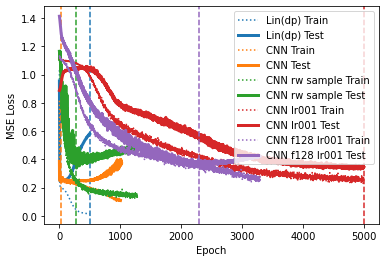

In [54]:
loss_data = mer8motif_lin_d_data_label+mer8motif_cnn_data_label+mer8motif_cnn_rw_data_label+lr001_cnn_data_label+f128_lr001_cnn_data_label
tu.quick_loss_plot(loss_data)


In [117]:
def quick_loss_plot(data_label_list,loss_type="MSE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,((train_data,test_data),label,epoch_stop) in enumerate(data_label_list):
        # plot only 1 in every sparse_n points
        if sparse_n:
            train_data = [x for i,x in enumerate(train_data) if (i%sparse_n==0)]
            test_data = [x for i,x in enumerate(test_data) if (i%sparse_n==0)]
            epoch_stop = epoch_stop/sparse_n
            
        plt.plot(train_data,linestyle='dotted',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,color=f"C{i}", label=f"{label} Test",linewidth=3.0)
        plt.axvline(x=epoch_stop,c=f"C{i}",linestyle='--')

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

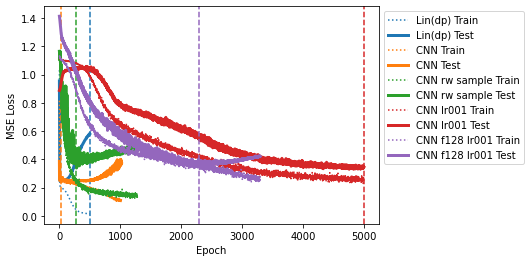

In [118]:
quick_loss_plot(loss_data)


Running CNN RW


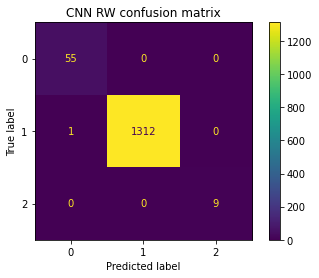

Running CNN lr001


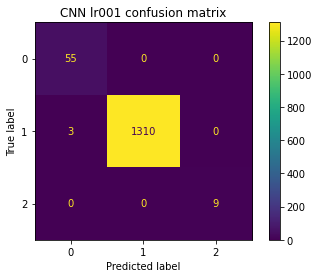

Running CNN f128 lr001


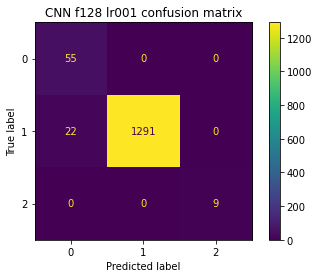

Running CNN RW


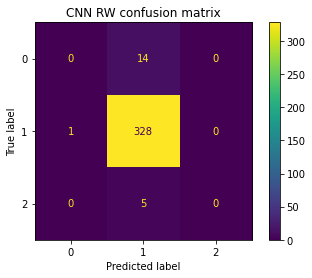

Running CNN lr001


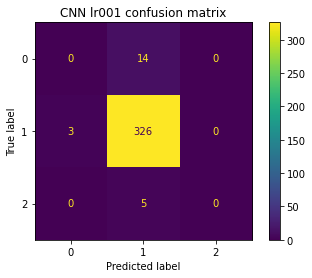

Running CNN f128 lr001


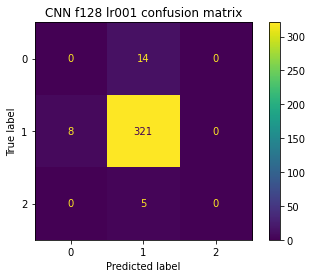

Running CNN RW


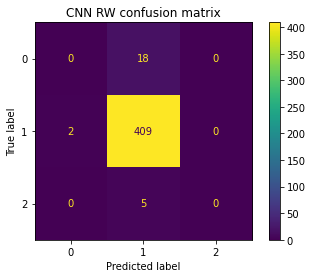

Running CNN lr001


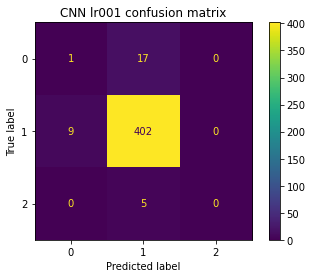

Running CNN f128 lr001


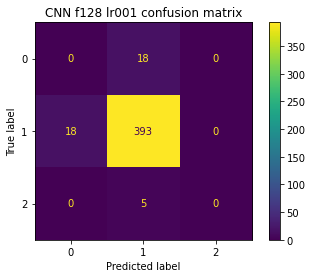

In [55]:
models = [
    #("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN RW",mer8motif_model_cnn,DatasetSpec('ohe')),
    ("CNN lr001",lr001_cnn,DatasetSpec('ohe')),
    ("CNN f128 lr001",f128_lr001_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


train_seqs =  train_df['locus_tag'].values #val_df['locus_tag'].values #
val_seqs =  val_df['locus_tag'].values #val_df['locus_tag'].values #
test_seqs =  test_df['locus_tag'].values #val_df['locus_tag'].values #
task = "5G_CuLR_classification"

oracle_reg = dict([(a,[b]) for a,b in XYdf[['locus_tag',reg]].values])


dfs_train = plot_confusion(models, train_seqs, oracle_reg,[task])
dfs_val = plot_confusion(models, val_seqs, oracle_reg,[task])
dfs_test = plot_confusion(models, test_seqs, oracle_reg,[task])

In [56]:
#cnn_res_rw = dfs_val['CNN'][1]

cnn_res_rw = dfs_val['CNN RW'][1]
cnn_res_lr001 = dfs_val['CNN lr001'][1]
cnn_res_f128_lr001 = dfs_val['CNN f128 lr001'][1]

cls_report(lind_res,"LinearDeep")
print()
cls_report(cnn_res,"CNN")
print()
cls_report(cnn_res_rw,"CNN RW")
print()
cls_report(cnn_res_lr001,"CNN lr001")
print()
cls_report(cnn_res_f128_lr001,"CNN f128 lr001")

LinearDeep (acc=0.945)
micro: p=0.945	 r=0.945	 f1=0.945
macro: p=0.315	 r=0.333	 f1=0.324

CNN (acc=0.945)
micro: p=0.945	 r=0.945	 f1=0.945
macro: p=0.315	 r=0.333	 f1=0.324

CNN RW (acc=0.943)
micro: p=0.943	 r=0.943	 f1=0.943
macro: p=0.315	 r=0.332	 f1=0.323

CNN lr001 (acc=0.937)
micro: p=0.937	 r=0.937	 f1=0.937
macro: p=0.315	 r=0.330	 f1=0.322

CNN f128 lr001 (acc=0.922)
micro: p=0.922	 r=0.922	 f1=0.922
macro: p=0.315	 r=0.325	 f1=0.320


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mis_c = quick_classify(mer8motif_model_cnn, val_seqs, oracle_syn)

# filter viz

In [124]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    #print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0).to(DEVICE)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    
#     with tqdm.trange(epochs) as pbar:
#         for i in pbar:
            
    for seq in tqdm.tqdm(seqs):
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>0)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

import logomaker
def view_filters_and_logos(model_weights,filter_activations, num_cols=8,ysc=1.0):
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 20*ysc))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(model_weights.shape[2]))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

Total convolutional layers: 2


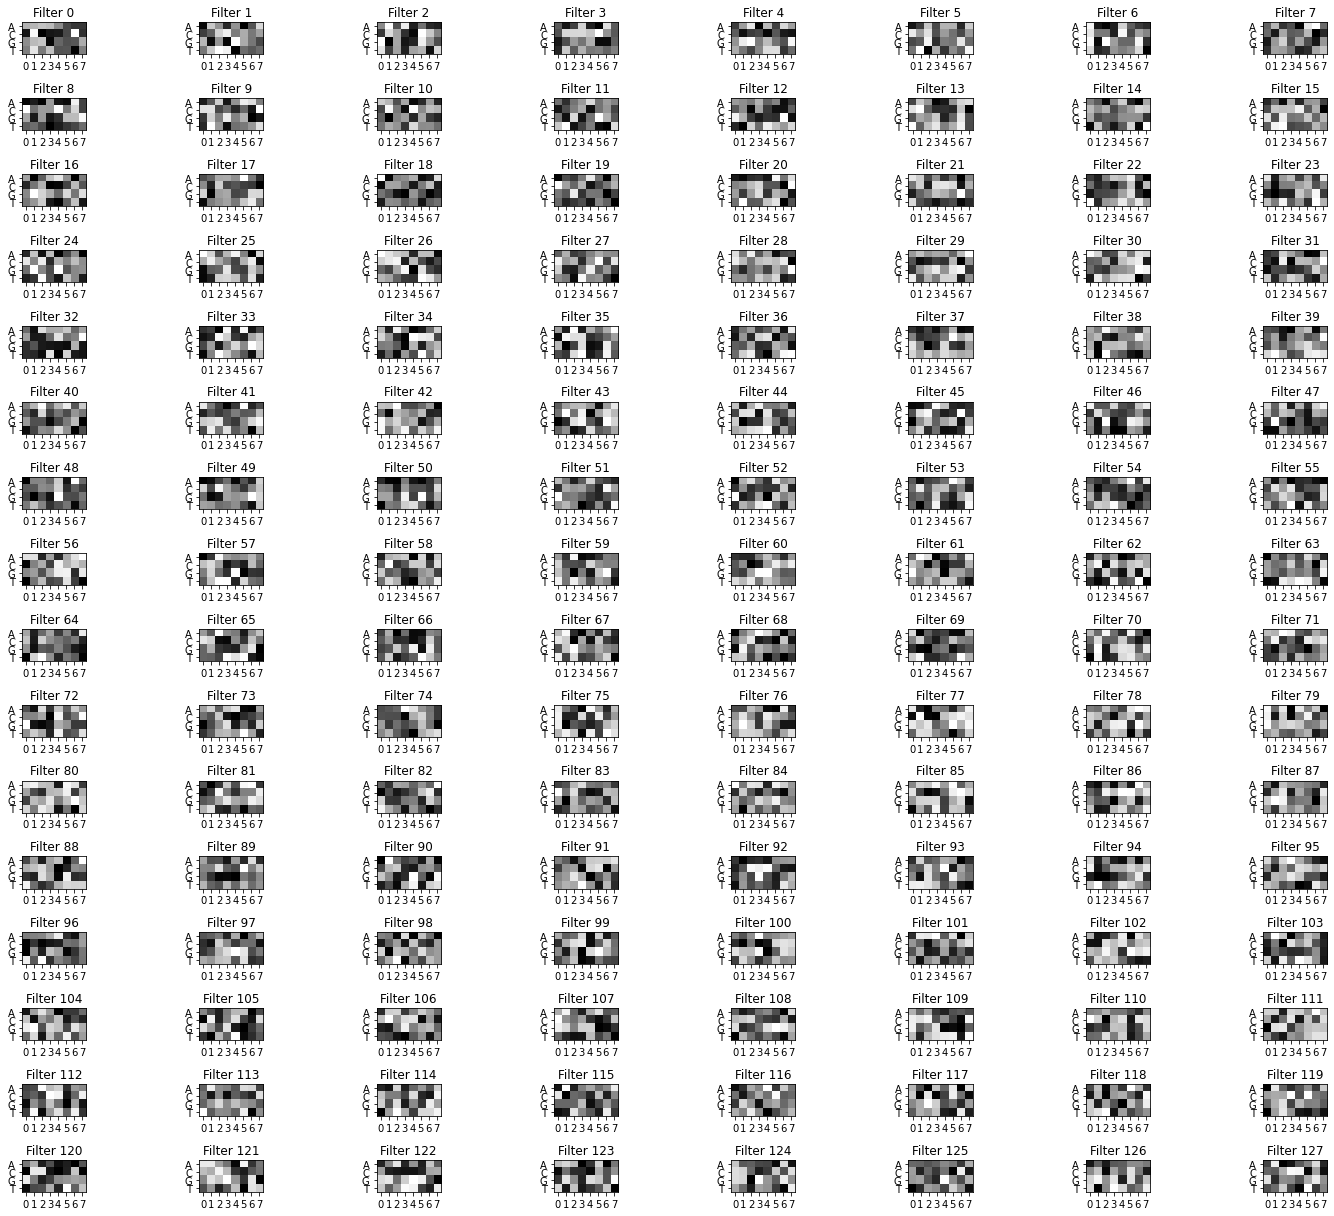

In [125]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(f128_lr001_cnn)
view_filters(model_weights)

In [126]:
seqs = [loc2seq[x] for x in train_df['locus_tag'].values[:500]]

filter_activations = get_filter_activations(seqs, conv_layers[0])

Num filters 128
filt_width 8


100%|██████████| 500/500 [06:24<00:00,  1.30it/s]


torch.Size([128, 4, 8])


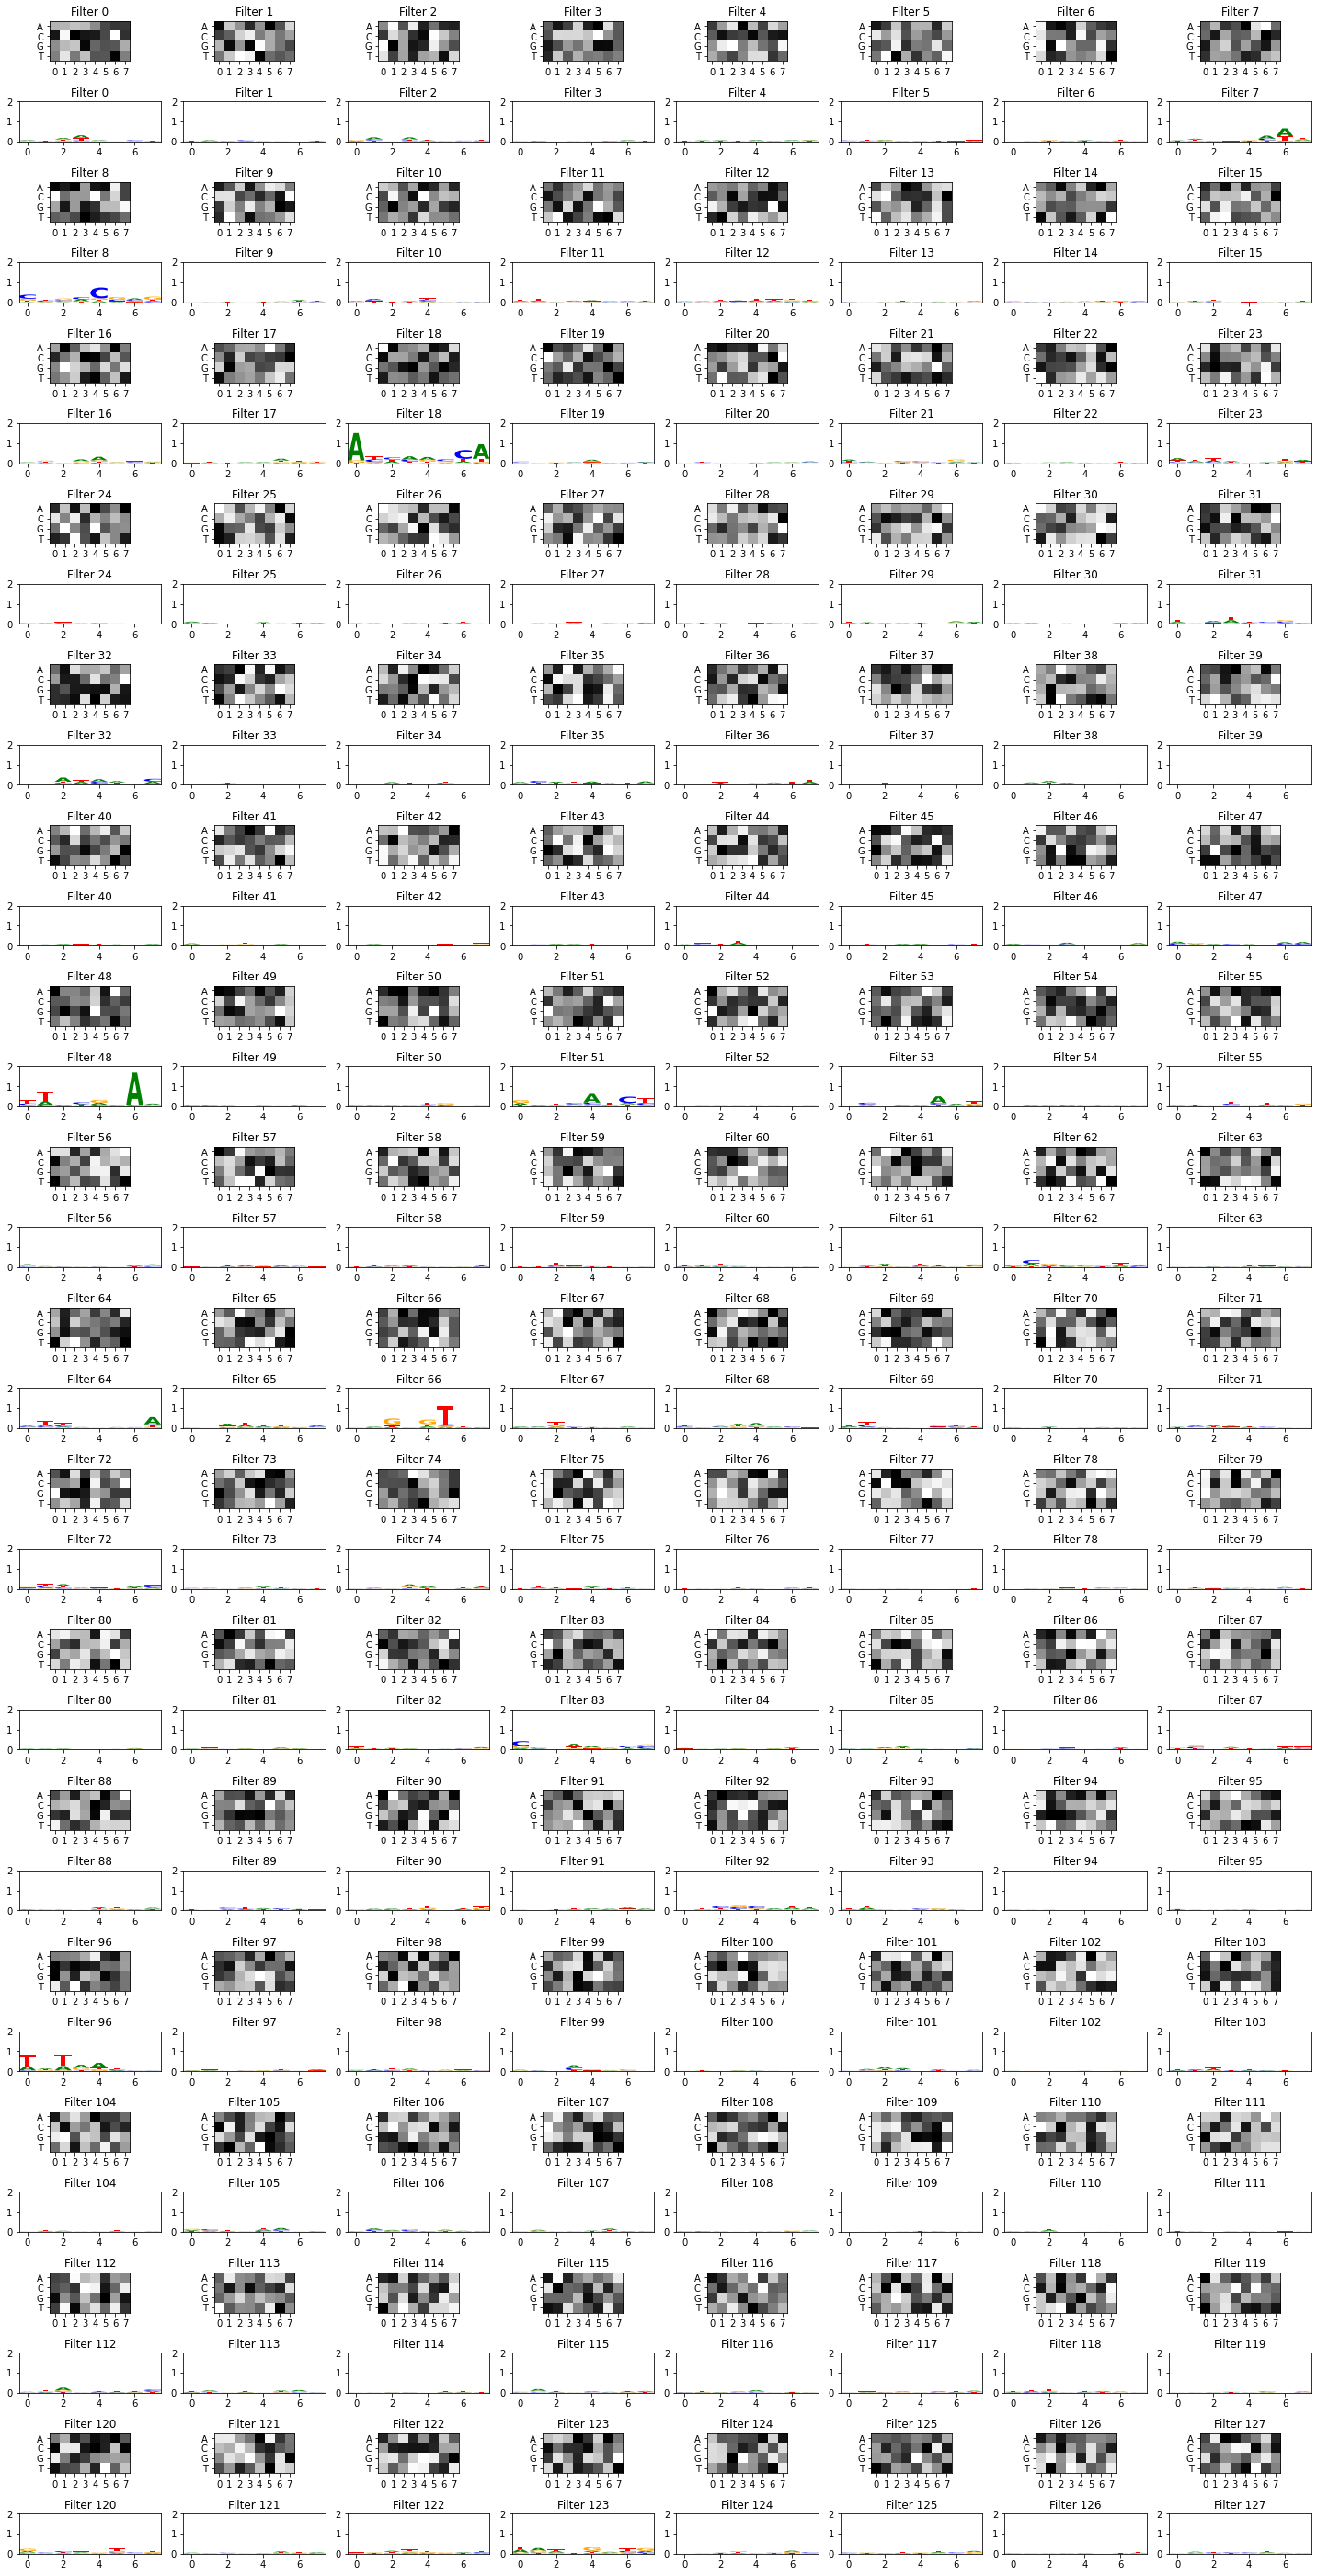

In [129]:
view_filters_and_logos(model_weights,filter_activations,ysc=2)

### some tinkering with KFold CV... maybe come back later

In [50]:
from sklearn.model_selection import StratifiedKFold

In [85]:
cv = StratifiedKFold(5,shuffle=True)

In [115]:
X = np.array(ft)
y = list(np.array(ft['highCu_reg_UD'].values))

trains = []
tests = []
for fold,(train_ids, test_ids) in enumerate(cv.split(X,y)):
    print("fold",fold)
    xtrain = ft.reset_index().iloc[train_ids]
    xtest = ft.reset_index().iloc[test_ids]
    trains.append(xtrain)
    tests.append(xtest)

fold 0
fold 1
fold 2
fold 3
fold 4


In [119]:
for i in range(5):
    traini = trains[i]
    testi = tests[i]
    
    print("fold",i)
    print("TRAIN")
    print(traini['highCu_reg_UD'].value_counts())
    print("TEST")
    print(testi['highCu_reg_UD'].value_counts())
    print()

fold 0
TRAIN
1    1313
0      55
2      12
Name: highCu_reg_UD, dtype: int64
TEST
1    329
0     14
2      2
Name: highCu_reg_UD, dtype: int64

fold 1
TRAIN
1    1314
0      55
2      11
Name: highCu_reg_UD, dtype: int64
TEST
1    328
0     14
2      3
Name: highCu_reg_UD, dtype: int64

fold 2
TRAIN
1    1314
0      55
2      11
Name: highCu_reg_UD, dtype: int64
TEST
1    328
0     14
2      3
Name: highCu_reg_UD, dtype: int64

fold 3
TRAIN
1    1314
0      55
2      11
Name: highCu_reg_UD, dtype: int64
TEST
1    328
0     14
2      3
Name: highCu_reg_UD, dtype: int64

fold 4
TRAIN
1    1313
0      56
2      11
Name: highCu_reg_UD, dtype: int64
TEST
1    329
0     13
2      3
Name: highCu_reg_UD, dtype: int64



## Old tinkering

In [46]:
w = torch.tensor([10.0,100.0,1.0])
cel = nn.CrossEntropyLoss()
celw = nn.CrossEntropyLoss(weight=w)

In [48]:
a = torch.tensor([[1.0,2.0,3.0],
                  [1.0,3.0,2.0],
                  [3.0,1.0,2.0]])

b = torch.tensor([2,1,2])
c = torch.tensor([0,1,2])

print('normal')
print(cel(a,b))
print(cel(a,c))
print()
print('weighted')
print(celw(a,b))
print(celw(a,c))

normal
tensor(0.7409)
tensor(1.4076)

weighted
tensor(0.4174)
tensor(0.5968)


In [45]:
print(a.shape)
print(b.shape)

torch.Size([2, 3])
torch.Size([2])


In [104]:
seqs = train_df['locus_tag'].values #val_df['locus_tag'].values

p = quick_classify(mer8motif_model_cnn,seqs,oracle_syn)

EQU24_RS06320: pred:2 actual:0
EQU24_RS06320: pred:2 actual:0 ([6.231020450592041, -6.871827602386475, 6.793558597564697])
EQU24_RS06855: pred:1 actual:0
EQU24_RS06855: pred:1 actual:0 ([5.818170547485352, 6.306614875793457, -5.028451919555664])
EQU24_RS16240: pred:1 actual:0
EQU24_RS16240: pred:1 actual:0 ([6.875643253326416, 7.228374004364014, -6.141620635986328])


In [93]:
p.tolist()[0]

[6.06266975402832, 2.4189703464508057, -2.8052988052368164]

In [67]:
genes = train_df['locus_tag'].values
seqs = [torch.tensor(u.one_hot_encode(loc2seq[x])).unsqueeze(0).to(DEVICE).float() for x in genes]

preds = mer8motif_model_cnn(torch.stack(seqs).squeeze(1))

In [85]:
preds

tensor([[9.9989e-01, 1.0368e-04, 8.5303e-06],
        [9.9997e-01, 2.7287e-05, 2.8173e-06],
        [9.8730e-01, 5.0449e-05, 1.2647e-02],
        ...,
        [9.9740e-01, 1.9590e-05, 2.5840e-03],
        [9.9967e-01, 2.5071e-04, 8.1230e-05],
        [9.9950e-01, 4.3107e-04, 6.7942e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [85]:
val_df.value_counts('reg')

reg
0    334
2     11
1      8
dtype: int64

In [110]:
genes_with_motifs = ['EQU24_RS00275','EQU24_RS01000','EQU24_RS01145','EQU24_RS01350','EQU24_RS01510','EQU24_RS01840','EQU24_RS01895','EQU24_RS01900','EQU24_RS02065','EQU24_RS02090','EQU24_RS02305','EQU24_RS02735','EQU24_RS02990','EQU24_RS03550','EQU24_RS03555','EQU24_RS03610','EQU24_RS04575','EQU24_RS04690','EQU24_RS05030','EQU24_RS05090','EQU24_RS05095','EQU24_RS05810','EQU24_RS05885','EQU24_RS06285','EQU24_RS06410','EQU24_RS06960','EQU24_RS07465','EQU24_RS07825','EQU24_RS08030','EQU24_RS08830','EQU24_RS08840','EQU24_RS08860','EQU24_RS08880','EQU24_RS09300','EQU24_RS09730','EQU24_RS09760','EQU24_RS09900','EQU24_RS10145','EQU24_RS10685','EQU24_RS10700','EQU24_RS10745','EQU24_RS12075','EQU24_RS12370','EQU24_RS12810','EQU24_RS13170','EQU24_RS13370','EQU24_RS13465','EQU24_RS14795','EQU24_RS14835','EQU24_RS15280','EQU24_RS15800','EQU24_RS15850','EQU24_RS16395','EQU24_RS16400','EQU24_RS16545','EQU24_RS16935','EQU24_RS17340','EQU24_RS17960','EQU24_RS18175','EQU24_RS18350','EQU24_RS18600','EQU24_RS18860','EQU24_RS19095','EQU24_RS19160','EQU24_RS19290','EQU24_RS19580','EQU24_RS20100','EQU24_RS20210','EQU24_RS20225','EQU24_RS20485','EQU24_RS20940','EQU24_RS21145','EQU24_RS21675','EQU24_RS21805','EQU24_RS21815']
seqs_with_motifs = [loc2seq[x] for x in genes_with_motifs]
seqs_with_motifs = [torch.tensor(u.one_hot_encode(seq)).unsqueeze(0).to(DEVICE).float() for seq in seqs_with_motifs]
preds = mer8motif_model_cnn(torch.stack(seqs_with_motifs).squeeze(1))

In [113]:
quick_classify(mer8motif_model_cnn,genes_with_motifs,oracle_syn)

done
